# Imports

In [1]:
import pandas as pd
import numpy as np
import catboost as cb
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV
from scipy.stats.distributions import expon
from scipy.stats import uniform
import glob
import re
import h2o
from tqdm import tqdm

%matplotlib inline
rng = np.random.RandomState(42)

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%reload_ext autoreload
%autoreload 2

import gps_lib.parse_raw_utils as p_utils
import gps_lib.exp_utils as e_utils
import gps_lib.data_sets as ds

# Load data

In [2]:
resources = {
    'species_dict': "../resources/species_dict.json",
    'VAMP': {
        'geno': '../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMPr.results.for.Amit',
        'pheno': '../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data',
        'run2bio': '../resources/28.12.21//VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_SAM_and_SRR_list.csv',
        'filter_list': '../resources/28.12.21//VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_filtered_SRR_list.20211228.xlsx',
    },
    'PATAKI': {
        'geno': '../resources/28.12.21/Pataki_paper/PATAKI_final_for_Amit.2021.12.28/Pataki.results.for.Amit',
        'pheno': '../resources/26.12.21/Pataki_paper/AST_2548_all', 
        'run2bio': '../resources/28.12.21/Pataki_paper/PATAKI_final_for_Amit.2021.12.28/PATAKI_full_SAM_and_SRR_list.xlsx',
        'filter_list': '../resources/28.12.21/Pataki_paper/PATAKI_final_for_Amit.2021.12.28/PATAKI_filtered_SRR_list_for_Amit.xlsx',
    },
    'PATRIC': {
        'geno': '/sise/liorrk-group/AmitdanwMaranoMotroy/all.QC.passed.spades.20220313/',
        'pheno': '../resources/data/PATRIC_AMR_ESKAPE_etal_with_numericalAST_only.xlsx', 
        'run2bio': '../resources/data/PATRIC_genome_final_db.20220223.xlsx',
        'filter_list': '',
    },
    'PA': {
        'geno': "../resources/data/PA.dataset.400.for.Amit/",
        'pheno': '../resources/data/Pseudomonas_paper_AST.xlsx', 
        'run2bio': '../resources/data/PA.dataset.400.RunInfo.xlsx',
        'filter_list': '',
    }
}

## Load PATAKI data

In [211]:
pataki = ds.PATAKICDataSet(resources['PATAKI'])

100%|██████████| 2548/2548 [00:20<00:00, 121.93it/s]


In [212]:
pataki.all_ASR.columns

Index(['biosample_id', 'antibiotic_name', 'multi_dilution_distance',
       'is_multi_mic', 'run_id', 'species_fam', 'test_standard',
       'standard_year', 'measurement_type', 'measurement', 'units', 'sign',
       'resistance_phenotype', 'platform', 'DB', 'measurement_has_/',
       'measurement2', 'exact_value', 'is_max_mic', 'is_min_mic',
       'multi_too_different'],
      dtype='object')

In [213]:
pataki.all_ASR[['biosample_id', 'run_id', 'species_fam', 'antibiotic_name', 'DB', 'sign', 'test_standard', 'units', 'resistance_phenotype', 'measurement_has_/']].describe()

biosample_id     run_id          species_fam antibiotic_name      DB  \
count          29002      29002                29002           29002   29002   
unique          2081       2081                    2              48       1   
top     SAMD00126359  DRR148122  Salmonella enterica   ciprofloxacin  PATAKI   
freq              22         22                23178            2081   29002   

         sign test_standard  units resistance_phenotype measurement_has_/  
count   29002         29002  29002                27344             29002  
unique      4             5      2                    3                 1  
top         =          clsi   mg/L                    S             False  
freq    15924         22457  28989                21980             29002

In [56]:
pataki.generate_dataset()

run_id
DRR148122     1.000000
DRR148123     2.000000
DRR148125     0.000000
DRR148126     1.000000
DRR148127     1.000000
                ...   
DRR148363     1.000000
DRR148364     1.000000
DRR148365     1.000000
DRR148366     0.000000
ERR2010911    4.247928
Name: measurement, Length: 179, dtype: float64
<class 'pandas.core.series.Series'>
[1.         2.         0.         4.         3.         4.24792751]
<class 'numpy.ndarray'>
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

KeyError: "None of [Float64Index([              1.0,               1.0,               1.0,\n                            1.0,               1.0,               1.0,\n                            1.0,               1.0,               1.0,\n                            1.0,\n              ...\n                            0.0,               0.0,               0.0,\n                            0.0,               0.0,               0.0,\n                            0.0,               4.0,               3.0,\n              4.247927513443585],\n             dtype='float64', name='run_id', length=141)] are in the [index]"

## Load VAMP data

In [217]:
vamp = ds.VAMPDataSet(resources['VAMP'])

100%|██████████| 3377/3377 [00:28<00:00, 118.17it/s]


In [218]:
vamp.all_ASR.columns

Index(['biosample_id', 'antibiotic_name', 'multi_dilution_distance',
       'is_multi_mic', 'species_fam', 'run_id', 'resistance_phenotype', 'sign',
       'measurement', 'units', 'measurement_type', 'platform', 'platform1',
       'platform2', 'test_standard', 'measurement_has_/', 'measurement2', 'DB',
       'standard_year', 'exact_value', 'is_max_mic', 'is_min_mic',
       'multi_too_different'],
      dtype='object')

In [219]:
vamp.all_ASR[['biosample_id', 'run_id', 'species_fam', 'antibiotic_name', 'DB', 'sign', 'test_standard', 'units', 'resistance_phenotype', 'measurement_has_/', 'platform', 'platform1', 'platform2']].describe()

biosample_id      run_id          species_fam  \
count          45677       45677                45677   
unique          2655        2655                    8   
top     SAMN03892126  SRR2134674  Salmonella enterica   
freq              39          39                18062   

                      antibiotic_name     DB   sign test_standard  units  \
count                           45677  45677  45677         45483  45677   
unique                             61      1      5             2      2   
top     trimethoprim_sulfamethoxazole   VAMP      =          clsi   mg/L   
freq                             2805  45677  15075         43079  45588   

       resistance_phenotype measurement_has_/ platform   platform1  \
count                 44532             45677    18623       19490   
unique                    3                 2        7           5   
top                       S             False    vitek  biomérieux   
freq                  24076             39375     7582        7638   

                     platform2  
count                     4185  
unique                       7  
top     trek specialized panel  
freq                      2533

## Load PA data

In [214]:
pa = ds.PADataSet(resources['PA'])

In [215]:
pa.all_ASR.columns

Index(['biosample_id', 'antibiotic_name', 'multi_dilution_distance',
       'is_multi_mic', 'run_id', 'platform', 'platform1', 'species_fam',
       'Isolate', 'resistance_phenotype', 'measurement', 'sign', 'DB', 'units',
       'measurement_has_/', 'measurement2', 'measurement_type',
       'test_standard', 'standard_year', 'exact_value', 'is_max_mic',
       'is_min_mic', 'multi_too_different'],
      dtype='object')

In [216]:
pa.all_ASR[['biosample_id', 'run_id', 'species_fam', 'antibiotic_name', 'DB', 'sign', 'test_standard', 'units', 'resistance_phenotype', 'measurement_has_/', 'platform', 'platform1']].describe()

biosample_id      run_id             species_fam antibiotic_name  \
count           1652        1652                    1652            1652   
unique           413         413                       1               4   
top     SAMN11110332  SRR8737420  Pseudomonas aeruginosa     ceftazidime   
freq               4           4                    1652             413   

          DB  sign test_standard units resistance_phenotype measurement_has_/  \
count   1652  1652          1652  1652                 1652              1652   
unique     1     2             1     1                    3                 1   
top       PA     =          clsi  mg/L                    R             False   
freq    1652  1650          1652  1652                  737              1652   

        platform            platform1  
count       1652                 1652  
unique         1                    1  
top     illumina  illumina hiseq 2500  
freq        1652                 1652

## Load PATRIC data

In [220]:
patric = ds.PATRICDataSet(resources['PATRIC'])

/sise/home/amitdanw/GPS/gps_lib/data_sets.py:232: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [221]:
patric.all_ASR.columns

Index(['biosample_id', 'antibiotic_name', 'multi_dilution_distance',
       'is_multi_mic', 'genome_id', 'species_fam', 'resistance_phenotype',
       'measurement', 'sign', 'units', 'measurement_type', 'platform2',
       'platform', 'platform1', 'test_standard', 'standard_year', 'DB',
       'measurement2', 'measurement_has_/', 'run_id', 'exact_value',
       'is_max_mic', 'is_min_mic', 'multi_too_different'],
      dtype='object')

In [222]:
patric.all_ASR[['biosample_id', 'run_id', 'species_fam', 'antibiotic_name', 'DB', 'sign', 'test_standard', 'units', 'resistance_phenotype', 'measurement_has_/', 'platform', 'platform1', 'platform2']].describe()

biosample_id      run_id            species_fam antibiotic_name  \
count          23624       23624                  23624           23624   
unique          3068        3068                      9              77   
top     SAMN04448237  SRR3222075  Klebsiella pneumoniae      ampicillin   
freq              37          37                   6902            1587   

            DB   sign test_standard  units resistance_phenotype  \
count    23624  23624         12056  22881                 8364   
unique       1      5             3      2                    3   
top     PATRIC      =          clsi   mg/L                    S   
freq     23624  11132          8416  22049                 4368   

       measurement_has_/    platform   platform1 platform2  
count              23624        8344        8658      2052  
unique                 2           7           3        10  
top                False  bd_phoenix  biomérieux        gn  
freq               22398        2961        4905       584

In [223]:
patric.all_ASR[patric.all_ASR['is_multi_mic']][patric.all_ASR['multi_dilution_distance']==0]

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Empty DataFrame
Columns: [biosample_id, antibiotic_name, multi_dilution_distance, is_multi_mic, genome_id, species_fam, resistance_phenotype, measurement, sign, units, measurement_type, platform2, platform, platform1, test_standard, standard_year, DB, measurement2, measurement_has_/, run_id, exact_value, is_max_mic, is_min_mic, multi_too_different]
Index: []

[0 rows x 24 columns]

# work with all data

In [224]:
dbs_list = [pataki, vamp, pa, patric]
data = ds.CollectionDataSet(dbs_list)

/sise/home/amitdanw/GPS/gps_lib/data_sets.py:237: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df['standard_year'] = df['standard_year'].fillna(df.loc[i, 'standard_year'])
/sise/home/amitdanw/GPS/gps_lib/data_sets.py:238: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df


In [225]:
data.all_ASR.columns

Index(['biosample_id', 'antibiotic_name', 'multi_dilution_distance',
       'is_multi_mic', 'run_id', 'species_fam', 'test_standard',
       'standard_year', 'measurement_type', 'measurement', 'units', 'sign',
       'resistance_phenotype', 'platform', 'DB', 'measurement_has_/',
       'measurement2', 'platform1', 'platform2', 'Isolate', 'genome_id',
       'exact_value', 'is_max_mic', 'is_min_mic', 'multi_too_different'],
      dtype='object')

In [226]:
data.all_ASR[['biosample_id', 'run_id', 'species_fam', 'antibiotic_name', 'DB', 'sign', 'test_standard', 'units', 'measurement_type', 'resistance_phenotype', 'measurement_has_/', 'platform', 'platform1', 'platform2']].describe()

biosample_id      run_id          species_fam antibiotic_name     DB  \
count          71391       71391                71391           71391  71391   
unique          7104        7104                   11              89      4   
top     SAMN03892126  SRR2134674  Salmonella enterica      ampicillin   VAMP   
freq              39          39                24290            5206  31443   

         sign test_standard  units measurement_type resistance_phenotype  \
count   71391         61770  70733            66761                57023   
unique      5             6      2                6                    3   
top         =          clsi   mg/L              mic                    S   
freq    31117         53147  69799            64806                28068   

       measurement_has_/    platform   platform1               platform2  
count              71391       43785       25478                    3649  
unique                 2          17           7                      16  
top                False  sensititre  biomérieux  trek specialized panel  
freq               65452       15578       11332                    1070

In [38]:
try:
    geno = pd.read_csv('../pre_proccesing/base_line/PATRIC/geno.csv')
except:
    geno, error = p_utils.get_genotype_per_db("/sise/liorrk-group/AmitdanwMaranoMotroy/all.QC.passed.spades.20220313/")
    geno.to_csv('../pre_proccesing/base_line/PATRIC/geno.csv', index=False)

In [39]:
try:
    pheno = pd.read_csv('../pre_proccesing/base_line/PATRIC/pheno.csv')
    pheno['genome_id'] = pheno['genome_id'].astype(str)
except:
    pheno, error = p_utils.get_phenotype_per_db('../resources/data/PATRIC_AMR_ESKAPE_etal_with_numericalAST_only.xlsx', db_name='PATRIC')
    pheno.to_csv('../pre_proccesing/base_line/PATRIC/pheno.csv', index=False)

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (9,10,11,12,16,19,21,22,32,34,37,38,39,41,42,45,48,49,52,53,56,59,62,65,66,68,69,71,73,74,75,80,81,82,84,85,87,88,89,91,93,94,96,100,104,105,106) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [64]:
try:
    filtered_data_PATRIC = pd.read_csv('../pre_proccesing/base_line/PATRIC/filtered_data.csv')
    labels_PATRIC = list(pd.read_csv('../pre_proccesing/base_line/PATRIC/labels.csv')['labels'].values)
    features_PATRIC = list(pd.read_csv('../pre_proccesing/base_line/PATRIC/features.csv')['features'].values)
except:
    filtered_data_PATRIC, labels_PATRIC, features_PATRIC = p_utils.merge_gen2phen(geno, 
                                                 pheno, 
                                                 '../resources/data/PATRIC_genome_final_db.20220223.xlsx', 
                                                 '', 
                                                 'PATRIC')
    filtered_data_PATRIC.to_csv('../pre_proccesing/base_line/PATRIC/filtered_data.csv', index=False)
    pd.Series(labels_PATRIC, name='labels').to_csv('../pre_proccesing/base_line/PATRIC/labels.csv', index=False)
    pd.Series(features_PATRIC, name='features').to_csv('../pre_proccesing/base_line/PATRIC/features.csv', index=False)

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (3,4,7,8,9,10,11,12,15,16,17,19,20,21,22,23,25,26,27,28,29,30,31,32,33,35,36,37,38,39,42,45,46,48,49,50,51,52,53,56,57,58,59,60,62,63,64,65,66,69,72,73,74,77,78,79,80,81,82,83,84,85,88,91,92,94,97,99,100,101,103,104,105,108,109) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


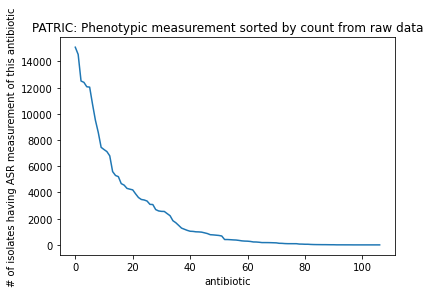

In [36]:
e_utils.anti_presence_in_isolates_figure(pheno, 'PATRIC')

### Geno

In [7]:
patric_dir_path = "/sise/liorrk-group/AmitdanwMaranoMotroy/all.QC.passed.spades.20220313/"

In [8]:
genotypic = pd.DataFrame({})
error_id = []
for SRR_dir in tqdm(os.listdir(patric_dir_path)):
    srr_features = get_isolate_features(patric_dir_path+'/'+SRR_dir)
    if type(srr_features) is not str:
        genotypic = pd.concat([genotypic, srr_features], axis=0)
    else:
        error_id += [srr_features]
# genotypic = genotypic.set_index('run_id')

100%|██████████| 3699/3699 [07:01<00:00,  8.77it/s]


In [9]:
print('Patric: ')
print('\tGEN: ')
print('\t\tOut of {} folders, only {} where valid'.format(len(os.listdir(patric_dir_path)), len(genotypic)))
print('\t\tThis are the problematic IDs: {}'.format(error_id))


Patric: 
	GEN: 
		Out of 3699 folders, only 3699 where valid
		This are the problematic IDs: []


Text(0, 0.5, '# of isolates contining this gene')

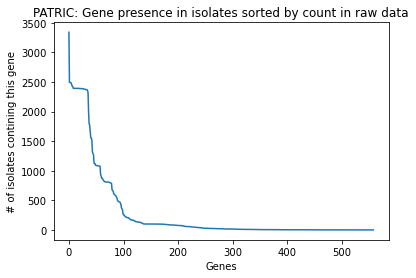

In [10]:
plt.plot(genotypic.describe().iloc[0].iloc[0:-1:2].sort_values(ascending=False).values)
plt.title('PATRIC: Gene presence in isolates sorted by count in raw data')
plt.xlabel('Genes')
plt.ylabel('# of isolates contining this gene')

Text(0, 0.5, '# of isolates with this number of genes')

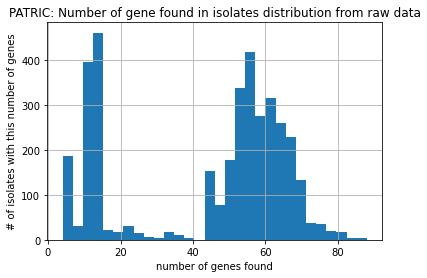

In [11]:
genotypic.set_index('run_id').count(axis=1).apply(lambda x: x/2).hist(bins=30)
plt.title('PATRIC: Number of gene found in isolates distribution from raw data')
plt.xlabel('number of genes found')
plt.ylabel('# of isolates with this number of genes')

In [12]:
genotypic.columns

Index(['Bifidobacterium_adolescentis_rpoB_conferring_resistance_to_rifampicin->seq_id',
       'Bifidobacterium_adolescentis_rpoB_conferring_resistance_to_rifampicin->seq_cov',
       'RlmA(II)->seq_id', 'RlmA(II)->seq_cov', 'patA->seq_id',
       'patA->seq_cov', 'pmrA->seq_id', 'pmrA->seq_cov', 'run_id',
       'AAC(2')-Ic->seq_id',
       ...
       'VIM-27->seq_id', 'VIM-27->seq_cov', 'dfrA23->seq_id',
       'dfrA23->seq_cov', 'VIM-19->seq_id', 'VIM-19->seq_cov',
       'dfrA30->seq_id', 'dfrA30->seq_cov', 'CTX-M-2->seq_id',
       'CTX-M-2->seq_cov'],
      dtype='object', name='col_name', length=1117)

### Pheno

In [83]:
AST_file = '../resources/data/PATRIC_AMR_ESKAPE_etal_with_numericalAST_only.xlsx'

In [84]:
AST_patric = pd.read_excel(AST_file)

In [85]:
AST_patric.columns

Index(['genome_id', 'genus', 'species', 'genome_name', 'taxon_id',
       'antibiotic', 'resistant_phenotype', 'measurement', 'measurement_sign',
       'measurement_value', 'measurement_unit', 'laboratory_typing_method',
       'laboratory_typing_method_version', 'laboratory_typing_platform',
       'vendor', 'testing_standard', 'testing_standard_year', 'source'],
      dtype='object')

In [86]:
AST_patric.head()

genome_id          genus                  species  \
0    470.593  Acinetobacter  Acinetobacter baumannii   
1    470.593  Acinetobacter  Acinetobacter baumannii   
2    470.593  Acinetobacter  Acinetobacter baumannii   
3    470.593  Acinetobacter  Acinetobacter baumannii   
4    470.593  Acinetobacter  Acinetobacter baumannii   

                          genome_name  taxon_id              antibiotic  \
0  Acinetobacter baumannii 1999BJAB11     470.0                amikacin   
1  Acinetobacter baumannii 1999BJAB11     470.0                cefepime   
2  Acinetobacter baumannii 1999BJAB11     470.0  cefoperazone_sulbactam   
3  Acinetobacter baumannii 1999BJAB11     470.0             ceftazidime   
4  Acinetobacter baumannii 1999BJAB11     470.0           ciprofloxacin   

  resistant_phenotype measurement measurement_sign measurement_value  \
0                 NaN         8.0              NaN               8.0   
1                 NaN        >256                >             256.0   
2                 NaN        64.0              NaN              64.0   
3                 NaN        >256                >             256.0   
4                 NaN         >32                >              32.0   

  measurement_unit laboratory_typing_method laboratory_typing_method_version  \
0             mg/L                      mic                              NaN   
1             mg/L                      mic                              NaN   
2             mg/L                      mic                              NaN   
3             mg/L                      mic                              NaN   
4             mg/L                      mic                              NaN   

  laboratory_typing_platform vendor testing_standard  testing_standard_year  \
0                        NaN    NaN              NaN                    NaN   
1                        NaN    NaN              NaN                    NaN   
2                        NaN    NaN              NaN                    NaN   
3                        NaN    NaN              NaN                    NaN   
4                        NaN    NaN              NaN                    NaN   

  source  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN

In [87]:
AST_patric['measurement_sign'].fillna('=', inplace=True)
AST_patric['measurement_sign'].replace('==', '=', inplace=True)

In [88]:
AST_patric['genome_id'] = AST_patric['genome_id'].astype(str)
AST_patric['genome_id'].unique()

array(['470.593', '470.576', '470.575', ..., '1313.5964', '1313.5917',
       '1313.13725'], dtype=object)

In [89]:
from datetime import datetime
def set_MIC_value(row, log2=True, choose_first_dash=True):
    sign = row['measurement_sign']
    value = row['measurement_value']
    values_float = []
    values_str = []
    # try:
    if sign == '==' or sign == '':
        sign = '='

    if type(value) == str:
        if choose_first_dash:
            values_float.append(float(value.split('/')[0]))
        else:
            values_float.append(float(value.split('/')[0]))
            values_float.append(float(value.split('/')[1]))
    elif type(value) == datetime:
        if value.date().year == 2022:
            values_float.append(value.date().month)
            values_float.append(value.date().day)
        else:
            values_float.append(value.date().month)
            values_float.append(int(str(value.date().year)[2:]))
    else:
        values_float.append(value)

    for val in values_float:

        if log2:
            if val == 0:
                sign = '<'
                values_str.append('-7')
            else:
                values_str.append(str(np.log2(val)))
        else:
            values_str.append(str(val))
    # except:
    #     
    #     print()

    if len(values_str)>1:
        return '{} {}/{}'.format(sign, values_str[0], values_str[1])
    else:
        return '{} {}'.format(sign, values_str[0])

In [90]:
AST_patric.apply(set_MIC_value, axis=1)

0          = 3.0
1          > 8.0
2          = 6.0
3          > 8.0
4          > 5.0
           ...  
268214     = 1.0
268215     = 1.0
268216     = 1.0
268217    = -3.0
268218    = -3.0
Length: 268219, dtype: object

In [91]:
AST_patric['measurement'] = AST_patric.apply(set_MIC_value, axis=1)

In [92]:
AST_patric.drop_duplicates(subset=['genome_id', 'antibiotic'], keep='first', inplace=True)

In [93]:
phenotypic_patric = AST_patric.pivot(index='genome_id', values='measurement', columns = 'antibiotic')

Text(0, 0.5, '# of isolates having ASR measurement of this antibiotic')

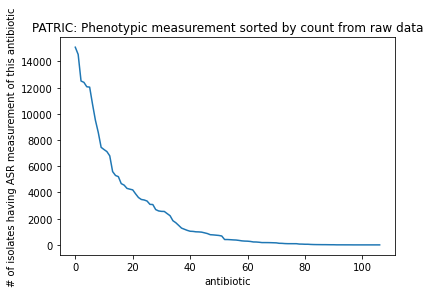

In [94]:
plt.plot(phenotypic_patric.describe().iloc[0].sort_values(ascending=False).values)
plt.title('PATRIC: Phenotypic measurement sorted by count from raw data')
plt.xlabel('antibiotic')
plt.ylabel('# of isolates having ASR measurement of this antibiotic')

### Matching phen2gen ID

In [95]:
run2biosam_path_patric = '../resources/data/PATRIC_genome_final_db.20220223.xlsx'
run2biosam_patric = pd.read_excel(run2biosam_path_patric)
run2biosam_patric.columns

Index(['run_accession', 'PATRIC_ID', 'sample_accession', 'study_accession',
       'instrument_platform', 'library_layout', 'Species'],
      dtype='object')

In [99]:
run2biosam_patric['PATRIC_ID'] = run2biosam_patric['PATRIC_ID'].astype(str)

In [101]:
run2biosam_patric.describe()

run_accession  PATRIC_ID sample_accession study_accession  \
count           7704       7704             7704            7704   
unique          7704       6523             6523             502   
top        ERR049082  1400148.3     SAMN02356609     PRJNA540750   
freq               1          8                8             835   

       instrument_platform library_layout                   Species  
count                 7704           7704                      7704  
unique                   1              1                        18  
top               ILLUMINA         PAIRED  Streptococcus pneumoniae  
freq                  7704           7704                      3340

In [105]:
run2biosam_patric = run2biosam_patric[['run_accession', 'PATRIC_ID', 'sample_accession', 'Species']]
run2biosam_patric.columns = ['run_id', 'genome_id', 'biosample_id', 'species_fam']
run2biosam_patric.describe()

run_id  genome_id  biosample_id               species_fam
count        7704       7704          7704                      7704
unique       7704       6523          6523                        18
top     ERR049082  1400148.3  SAMN02356609  Streptococcus pneumoniae
freq            1          8             8                      3340

In [113]:
filter_data_patric = run2biosam_patric.merge(right=genotypic, how='inner', on='run_id')
filter_data_patric[['run_id', 'genome_id']].describe()

run_id genome_id
count         3689      3689
unique        3689      3068
top     ERR1912619   550.622
freq             1         6

In [114]:
filter_data_patric = filter_data_patric.merge(right=phenotypic_patric, how='inner', on='genome_id')
filter_data_patric['DB'] = 'PATRIC'
filter_data_patric[['run_id', 'genome_id']].describe()

run_id genome_id
count         3689      3689
unique        3689      3068
top     ERR1912619   550.622
freq             1         6

In [115]:
dup_bio = filter_data_patric.groupby(by='biosample_id')['run_id'].count() > 1
dup_bio = dup_bio[dup_bio == True].index.values

In [116]:
filter_data_patric[filter_data_patric['biosample_id'].isin(dup_bio)][['run_id', 'biosample_id']].describe()

run_id  biosample_id
count         1003          1003
unique        1003           382
top     ERR1034576  SAMN04448597
freq             1             6

In [117]:
dup_df = filter_data_patric[filter_data_patric['biosample_id'].isin(dup_bio)][['run_id', 'biosample_id']]
dup_df.to_csv('../resources/reports/patric_dup_run_id_with_biosample_id.txt')

In [118]:
filter_data_patric = filter_data_patric.drop_duplicates(subset='biosample_id', keep='first')

In [120]:
filter_data_patric[['run_id','biosample_id']].describe()

run_id    biosample_id
count         3068            3068
unique        3068            3068
top     ERR1912619  SAMEA103923484
freq             1               1

In [126]:
filter_data_patric.columns

Index(['run_id', 'genome_id', 'biosample_id', 'species_fam',
       'Bifidobacterium_adolescentis_rpoB_conferring_resistance_to_rifampicin->seq_id',
       'Bifidobacterium_adolescentis_rpoB_conferring_resistance_to_rifampicin->seq_cov',
       'RlmA(II)->seq_id', 'RlmA(II)->seq_cov', 'patA->seq_id',
       'patA->seq_cov',
       ...
       'tigecycline', 'tilmicosin', 'tobramycin', 'trimethoprim',
       'trimethoprim_sulphamethoxazole', 'trovafloxacin', 'tulathromycin',
       'tylosin', 'vancomycin', 'DB'],
      dtype='object', length=1228)

In [125]:
patric_labels = list(phenotypic_patric.columns)
patric_features = list(set(genotypic.columns)-set(['run_id']))

Text(0, 0.5, '# of isolates contining this gene')

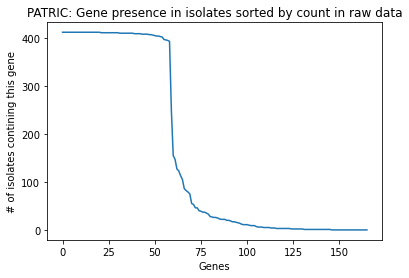

In [130]:
plt.plot(genotypic.describe().iloc[0].iloc[0:-1:2].sort_values(ascending=False).values)
plt.title('PATRIC: Gene presence in isolates sorted by count in raw data')
plt.xlabel('Genes')
plt.ylabel('# of isolates contining this gene')

Text(0, 0.5, '# of isolates with this number of genes')

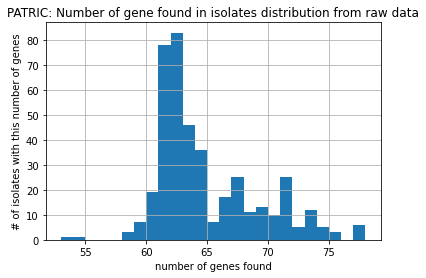

In [132]:
genotypic.set_index('run_id').count(axis=1).apply(lambda x: x/2).hist(bins=25)
plt.title('PATRIC: Number of gene found in isolates distribution from raw data')
plt.xlabel('number of genes found')
plt.ylabel('# of isolates with this number of genes')

In [133]:
genotypic.columns

Index(['APH(3')-IIb->seq_id', 'APH(3')-IIb->seq_cov', 'APH(6)-Ic->seq_id',
       'APH(6)-Ic->seq_cov', 'ArmR->seq_id', 'ArmR->seq_cov',
       'Bifidobacterium_adolescentis_rpoB_conferring_resistance_to_rifampicin->seq_id',
       'Bifidobacterium_adolescentis_rpoB_conferring_resistance_to_rifampicin->seq_cov',
       'CRP->seq_id', 'CRP->seq_cov',
       ...
       'PER-1->seq_id', 'PER-1->seq_cov', 'OXA-141->seq_id',
       'OXA-141->seq_cov', 'aadA24->seq_id', 'aadA24->seq_cov',
       'VIM-4->seq_id', 'VIM-4->seq_cov', 'OXA-392->seq_id',
       'OXA-392->seq_cov'],
      dtype='object', name='col_name', length=333)

In [19]:
AST_file = '../resources/data/Pseudomonas_paper_AST.xlsx'

In [20]:
AST_patric = pd.read_excel(AST_file, sheet_name='Strain and MIC', header=1)

In [8]:
AST_patric.columns

Index(['Unnamed: 0', 'Isolate', 'Supplier (Geographic origin)', 'tobramycin',
       'tobramycin MIC', 'ciprofloxacin', 'ciprofloxacin MIC', 'meropenem',
       'meropenem MIC', 'ceftazidime', 'ceftazidime MIC', ' '],
      dtype='object')

In [54]:
run2biosam_path = '../resources/data/PA.dataset.400.RunInfo.xlsx'

In [251]:
filter_list = ''

In [55]:
run2biosam = pd.read_excel(run2biosam_path)

In [58]:
run2biosam.columns

Index(['Run', 'ReleaseDate', 'LoadDate', 'spots', 'bases', 'spots_with_mates',
       'avgLength', 'size_MB', 'AssemblyName', 'download_path', 'Experiment',
       'LibraryName', 'LibraryStrategy', 'LibrarySelection', 'LibrarySource',
       'LibraryLayout', 'InsertSize', 'InsertDev', 'Platform', 'Model',
       'SRAStudy', 'BioProject', 'Study_Pubmed_id', 'ProjectID', 'Sample',
       'BioSample', 'SampleType', 'TaxID', 'ScientificName', 'SampleName',
       'g1k_pop_code', 'source', 'g1k_analysis_group', 'Subject_ID', 'Sex',
       'Disease', 'Tumor', 'Affection_Status', 'Analyte_Type',
       'Histological_Type', 'Body_Site', 'CenterName', 'Submission',
       'dbgap_study_accession', 'Consent', 'RunHash', 'ReadHash'],
      dtype='object')

In [61]:
run2biosam = run2biosam[['Run', 'SampleName']]

In [62]:
run2biosam.columns = ['run_id', 'biosample_id']
run2biosam.describe()

run_id biosample_id
count          414          414
unique         414          414
top     SRR8737583       CH2597
freq             1            1

In [65]:
if not os.path.exists('../pre_proccesing/base_line/PATAKI'):
    os.makedirs('../pre_proccesing/base_line/PATAKI')

In [66]:
try:
    geno = pd.read_csv('../pre_proccesing/base_line/PATAKI/geno.csv')
except:
    geno, error = p_utils.get_genotype_per_db("../resources/28.12.21/Pataki_paper/PATAKI_final_for_Amit.2021.12.28/Pataki.results.for.Amit")
    geno.to_csv('../pre_proccesing/base_line/PATAKI/geno.csv', index=False)

 16%|█▌        | 401/2548 [00:24<01:57, 18.34it/s]

SRR3710053: is missing csv file


 67%|██████▋   | 1718/2548 [01:42<00:29, 28.26it/s]

SRR10992711: is missing csv file
SRR10992710: is missing csv file
SRR10992703: is missing csv file
SRR10992702: is missing csv file


 69%|██████▊   | 1747/2548 [01:42<00:14, 53.98it/s]

ERR2438153: is missing csv file
ERR2438152: is missing csv file
ERR2438151: is missing csv file
ERR2438150: is missing csv file
ERR2438149: is missing csv file
ERR2438148: is missing csv file
ERR2438147: is missing csv file
ERR2438146: is missing csv file
ERR2438145: is missing csv file
ERR2438144: is missing csv file
ERR2438143: is missing csv file
ERR2438142: is missing csv file
ERR2438141: is missing csv file
ERR2438140: is missing csv file
ERR2438139: is missing csv file
ERR2438138: is missing csv file
ERR2438136: is missing csv file


 73%|███████▎  | 1869/2548 [01:51<00:39, 17.19it/s]

ERR2044146: is missing csv file
ERR2044145: is missing csv file


100%|██████████| 2548/2548 [02:43<00:00, 15.62it/s]


In [67]:
try:
    pheno = pd.read_csv('../pre_proccesing/base_line/PATAKI/pheno.csv')
except:
    pheno, error = p_utils.get_phenotype_per_db('../resources/26.12.21/Pataki_paper/AST_2548_all', db_name='PATAKI')
    pheno.to_csv('../pre_proccesing/base_line/PATAKI/pheno.csv', index=False)

 69%|██████▊   | 1750/2548 [00:20<00:15, 50.98it/s]

SAMEA3993605: not excepted measure values


 87%|████████▋ | 2210/2548 [00:30<00:06, 52.31it/s]

../resources/26.12.21/Pataki_paper/AST_2548_all/SAMEA104107449_Ecoli100uploadantibiogram.tsv: problem loading file
SAMEA104107449_Ecoli100uploadantibiogram.tsv


100%|██████████| 2548/2548 [00:37<00:00, 68.32it/s]


In [71]:
try:
    filtered_data_PATAKI = pd.read_csv('../pre_proccesing/base_line/PATAKI/filtered_data.csv')
    labels_PATAKI = list(pd.read_csv('../pre_proccesing/base_line/PATAKI/labels.csv')['labels'].values)
    features_PATAKI = list(pd.read_csv('../pre_proccesing/base_line/PATAKI/features.csv')['features'].values)
except:
    filtered_data_PATAKI, labels_PATAKI, features_PATAKI = p_utils.merge_gen2phen(geno, 
                                                 pheno, 
                                                 '../resources/28.12.21/Pataki_paper/PATAKI_final_for_Amit.2021.12.28/PATAKI_full_SAM_and_SRR_list.xlsx', 
                                                 '../resources/28.12.21/Pataki_paper/PATAKI_final_for_Amit.2021.12.28/PATAKI_filtered_SRR_list_for_Amit.xlsx', 
                                                 'PATAKI')
    filtered_data_PATAKI.to_csv('../pre_proccesing/base_line/PATAKI/filtered_data.csv', index=False)
    pd.Series(labels_PATAKI, name='labels').to_csv('../pre_proccesing/base_line/PATAKI/labels.csv', index=False)
    pd.Series(features_PATAKI, name='features').to_csv('../pre_proccesing/base_line/PATAKI/features.csv', index=False)



In [93]:
filtered_data_PATAKI

species_fam      run_id  biosample_id sulfisoxazole ampicillin  \
0          ecoli   DRR148122  SAMD00126359           NaN      > 7.0   
1          ecoli   DRR148123  SAMD00126360           NaN      > 7.0   
2          ecoli   DRR148125  SAMD00126362           NaN      > 7.0   
3          ecoli   DRR148126  SAMD00126363           NaN      > 7.0   
4          ecoli   DRR148127  SAMD00126364           NaN      > 7.0   
...          ...         ...           ...           ...        ...   
2076   senterica  SRR5573144  SAMN02912014         > 8.0     <= 0.0   
2077   senterica  SRR5573145  SAMN02912015         > 8.0     <= 0.0   
2078   senterica  SRR3932966  SAMN05416460         = 5.0     <= 0.0   
2079   senterica  SRR3932967  SAMN05416461         = 5.0     <= 0.0   
2080   senterica  SRR3932968  SAMN05416462         = 6.0     <= 0.0   

     chloramphenicol tetracycline amoxicillin_clavulanic_acid azithromycin  \
0                NaN          NaN                         NaN          NaN   
1                NaN          NaN                         NaN          NaN   
2                NaN          NaN                         NaN          NaN   
3                NaN          NaN                         NaN          NaN   
4                NaN          NaN                         NaN          NaN   
...              ...          ...                         ...          ...   
2076           = 3.0        > 5.0                      <= 0.0        = 2.0   
2077           = 3.0        > 5.0                      <= 0.0        = 2.0   
2078           = 3.0       <= 2.0                      <= 0.0        = 2.0   
2079           = 3.0        > 5.0                      <= 0.0        = 2.0   
2080           = 2.0        > 5.0                      <= 0.0        = 2.0   

     nalidixic_acid  ... CTX-M-24->seq_cov TEM-63->seq_id TEM-63->seq_cov  \
0             > 4.0  ...               NaN            NaN             NaN   
1             > 4.0  ...               NaN            NaN             NaN   
2             > 4.0  ...               NaN            NaN             NaN   
3             > 4.0  ...               NaN            NaN             NaN   
4             > 4.0  ...               NaN            NaN             NaN   
...             ...  ...               ...            ...             ...   
2076          = 2.0  ...               NaN            NaN             NaN   
2077          = 1.0  ...               NaN            NaN             NaN   
2078          = 2.0  ...               NaN            NaN             NaN   
2079          = 2.0  ...               NaN            NaN             NaN   
2080          = 1.0  ...               NaN            NaN             NaN   

     CTX-M-2->seq_id CTX-M-2->seq_cov ACT-22->seq_id ACT-22->seq_cov  \
0                NaN              NaN            NaN             NaN   
1                NaN              NaN            NaN             NaN   
2                NaN              NaN            NaN             NaN   
3                NaN              NaN            NaN             NaN   
4                NaN              NaN            NaN             NaN   
...              ...              ...            ...             ...   
2076             NaN              NaN            NaN             NaN   
2077             NaN              NaN            NaN             NaN   
2078             NaN              NaN            NaN             NaN   
2079             NaN              NaN            NaN             NaN   
2080             NaN              NaN            NaN             NaN   

     CTX-M-66->seq_id CTX-M-66->seq_cov      DB  
0                 NaN               NaN  PATAKI  
1                 NaN               NaN  PATAKI  
2                 NaN               NaN  PATAKI  
3                 NaN               NaN  PATAKI  
4                 NaN               NaN  PATAKI  
...               ...               ...     ...  
2076              NaN               NaN  PATAKI  
2077              NaN    

### Geno

In [11]:
pataki_dir_path = "../resources/28.12.21/Pataki_paper/PATAKI_final_for_Amit.2021.12.28/Pataki.results.for.Amit"

In [12]:
genotypic = pd.DataFrame({})
error_id = []
for SRR_dir in os.listdir(pataki_dir_path):
    srr_features = get_isolate_features(pataki_dir_path+'/'+SRR_dir)
    if type(srr_features) is not str:
        genotypic = pd.concat([genotypic, srr_features], axis=0)
    else:
        error_id += [srr_features]
# genotypic = genotypic.set_index('run_id')

SRR3710053: is missing csv file
SRR10992711: is missing csv file
SRR10992710: is missing csv file
SRR10992703: is missing csv file
SRR10992702: is missing csv file
ERR2438153: is missing csv file
ERR2438152: is missing csv file
ERR2438151: is missing csv file
ERR2438150: is missing csv file
ERR2438149: is missing csv file
ERR2438148: is missing csv file
ERR2438147: is missing csv file
ERR2438146: is missing csv file
ERR2438145: is missing csv file
ERR2438144: is missing csv file
ERR2438143: is missing csv file
ERR2438142: is missing csv file
ERR2438141: is missing csv file
ERR2438140: is missing csv file
ERR2438139: is missing csv file
ERR2438138: is missing csv file
ERR2438136: is missing csv file
ERR2044146: is missing csv file
ERR2044145: is missing csv file


In [13]:
print('Pataki: ')
print('\tGEN: ')
print('\t\tOut of {} folders, only {} where valid'.format(len(os.listdir(pataki_dir_path)), len(genotypic)))
print('\t\tThis are the problematic IDs: {}'.format(error_id))


Pataki: 
	GEN: 
		Out of 2548 folders, only 2524 where valid
		This are the problematic IDs: ['SRR3710053', 'SRR10992711', 'SRR10992710', 'SRR10992703', 'SRR10992702', 'ERR2438153', 'ERR2438152', 'ERR2438151', 'ERR2438150', 'ERR2438149', 'ERR2438148', 'ERR2438147', 'ERR2438146', 'ERR2438145', 'ERR2438144', 'ERR2438143', 'ERR2438142', 'ERR2438141', 'ERR2438140', 'ERR2438139', 'ERR2438138', 'ERR2438136', 'ERR2044146', 'ERR2044145']


In [14]:
pd.DataFrame({"run_id": error_id}).to_csv('../resources/reports/pataki_missing_gene_file_run_id.txt')

Text(0, 0.5, '# of isolates contining this gene')

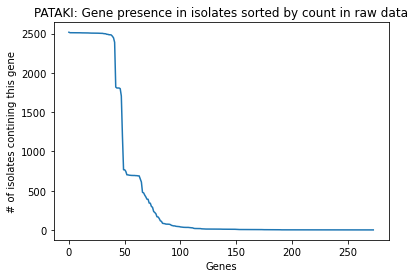

In [15]:
plt.plot(genotypic.describe().iloc[0].iloc[0:-1:2].sort_values(ascending=False).values)
plt.title('PATAKI: Gene presence in isolates sorted by count in raw data')
plt.xlabel('Genes')
plt.ylabel('# of isolates contining this gene')

In [16]:
list(genotypic.describe().iloc[0].iloc[0:-1:2].sort_values(ascending=False).reset_index()['col_name'].apply(lambda x: x[:-8]).values)

['Nocardia_rifampin_resistant_beta-subunit_of_RNA_polymerase_(rpoB2)',
 'Klebsiella_pneumoniae_OmpK37',
 'acrB',
 'mdtH',
 'baeR',
 'baeS',
 'rosB',
 'rosA',
 'mdtC',
 'mdtG',
 'Klebsiella_pneumoniae_KpnE',
 'Escherichia_coli_mdfA',
 'emrA',
 'Escherichia_coli_acrA',
 'tolC',
 'msbA',
 'emrR',
 'mdtB',
 'acrD',
 'macB',
 'bacA',
 'mdtA',
 'Escherichia_coli_ampC1_beta-lactamase',
 'marA',
 'arnA',
 'Klebsiella_pneumoniae_KpnF',
 'emrB',
 'pmrF',
 'cpxA',
 'eptA',
 'Escherichia_coli_ampH',
 'acrS',
 'H-NS',
 'yojI',
 'sdiA',
 'mdtK',
 'ugd',
 'CRP',
 'acrE',
 'acrF',
 'kdpE',
 'mdtM',
 'ramA',
 'mdsB',
 'golS',
 'mdsA',
 'mdsC',
 'Bifidobacterium_adolescentis_rpoB_conferring_resistance_to_rifampicin',
 "AAC(6')-Iy",
 "APH(3'')-Ib",
 'APH(6)-Id',
 'tet(A)',
 'mdtO',
 'mdtP',
 'mdtN',
 'evgS',
 'evgA',
 'Escherichia_coli_ampC',
 'emrY',
 'mdtF',
 'gadW',
 'emrK',
 'gadX',
 'mdtE',
 'sul2',
 "AAC(6')-Iaa",
 'Escherichia_coli_emrE',
 'sul1',
 'mphB',
 "AAC(6')-Ib7",
 "ANT(3'')-IIa",
 'TEM-1'

In [17]:
len(list(genotypic.describe().iloc[0].iloc[0:-1:2].sort_values(ascending=False).reset_index()['col_name'].apply(lambda x: x[:-8]).values))

274

Text(0, 0.5, '# of isolates with this number of genes')

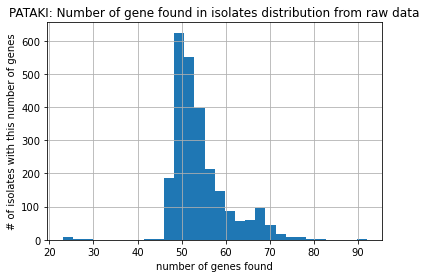

In [18]:
genotypic.set_index('run_id').count(axis=1).apply(lambda x: x/2).hist(bins=30)
plt.title('PATAKI: Number of gene found in isolates distribution from raw data')
plt.xlabel('number of genes found')
plt.ylabel('# of isolates with this number of genes')

### Pheno

In [19]:
AST_dir = '../resources/26.12.21/Pataki_paper/AST_2548_all'

In [20]:
phenotypic = pd.DataFrame({})
error_id = []
for sam_dir in tqdm(os.listdir(AST_dir)):
    sam_labels = get_isolate_labels(AST_dir+'/'+sam_dir)
    if type(sam_labels) is not str:
        phenotypic = pd.concat([phenotypic, sam_labels], axis=0)
    else:
        print(sam_dir)
        error_id += [sam_dir]
# phenotypic = phenotypic.set_index('biosample_id')

 69%|██████▊   | 1750/2548 [00:16<00:09, 86.39it/s] 

SAMEA3993605: not excepted measure values


 87%|████████▋ | 2214/2548 [00:22<00:04, 70.01it/s]

../resources/26.12.21/Pataki_paper/AST_2548_all/SAMEA104107449_Ecoli100uploadantibiogram.tsv: problem loading file
None
SAMEA104107449_Ecoli100uploadantibiogram.tsv


100%|██████████| 2548/2548 [00:28<00:00, 90.78it/s]


In [21]:
print('Pataki: ')
print('\tPhen: ')
print('\t\tOut of {} folders, only {} where valid'.format(len(os.listdir(AST_dir)), len(phenotypic)))
print('\t\tThis are the problematic IDs: {}'.format(error_id))


Pataki: 
	Phen: 
		Out of 2548 folders, only 2547 where valid
		This are the problematic IDs: ['SAMEA104107449_Ecoli100uploadantibiogram.tsv']


In [22]:
pd.DataFrame({"file_name": error_id}).to_csv('../resources/reports/pataki_missing_phen_file_biosample_id.txt')

In [23]:
phenotypic

antibiotic_name sulfisoxazole ampicillin chloramphenicol tetracycline  \
biosample_id                                                            
SAMN05771806            > 8.0      > 5.0           > 5.0        = 5.0   
SAMN05771805            > 8.0      > 5.0           = 3.0        > 5.0   
SAMN05771804            > 8.0      > 5.0           = 3.0        > 5.0   
SAMN05771803            > 8.0      > 5.0           = 3.0        > 5.0   
SAMN05771802            = 5.0     <= 0.0           = 2.0        > 5.0   
...                       ...        ...             ...          ...   
SAMD00126362              NaN      > 7.0             NaN          NaN   
SAMD00126361              NaN      > 7.0             NaN          NaN   
SAMD00126360              NaN      > 7.0             NaN          NaN   
SAMD00126359              NaN      > 7.0             NaN          NaN   
SAMD00126358              NaN      > 7.0             NaN          NaN   

antibiotic_name amoxicillin-clavulanic acid azithromycin nalidixic acid  \
biosample_id                                                              
SAMN05771806                          = 4.0        = 2.0          = 2.0   
SAMN05771805                          > 5.0        = 2.0          = 2.0   
SAMN05771804                          > 5.0        = 2.0          = 1.0   
SAMN05771803                          > 5.0        = 2.0          = 1.0   
SAMN05771802                         <= 0.0        = 1.0          = 1.0   
...                                     ...          ...            ...   
SAMD00126362                            NaN          NaN          > 4.0   
SAMD00126361                            NaN          NaN          > 4.0   
SAMD00126360                            NaN          NaN          > 4.0   
SAMD00126359                            NaN          NaN          > 4.0   
SAMD00126358                            NaN          NaN          = 4.0   

antibiotic_name cefoxitin ceftiofur gentamicin  ... kanamycin mezlocillin  \
biosample_id                                    ...                         
SAMN05771806        = 1.0    = -1.0     = -1.0  ...       NaN         NaN   
SAMN05771805        > 5.0     > 3.0    <= -2.0  ...       NaN         NaN   
SAMN05771804        > 5.0     = 3.0    <= -2.0  ...       NaN         NaN   
SAMN05771803        > 5.0     > 3.0    <= -2.0  ...       NaN         NaN   
SAMN05771802        = 1.0    = -1.0     = -1.0  ...       NaN         NaN   
...                   ...       ...        ...  ...       ...         ...   
SAMD00126362          NaN       NaN        NaN  ...       NaN         NaN   
SAMD00126361          NaN       NaN        NaN  ...       NaN         NaN   
SAMD00126360          NaN       NaN        NaN  ...       NaN         NaN   
SAMD00126359          NaN       NaN        NaN  ...       NaN         NaN   
SAMD00126358          NaN       NaN        NaN  ...       NaN         NaN   

antibiotic_name oxytetracycline piperacillin cefaclor cefotiam levofloxacin  \
biosample_id                                                                  
SAMN05771806                NaN          NaN      NaN      NaN          NaN   
SAMN05771805                NaN          NaN      NaN      NaN          NaN   
SAMN05771804                NaN          NaN      NaN      NaN          NaN   
SAMN05771803                NaN          NaN      NaN      NaN          NaN   
SAMN05771802                NaN          NaN      NaN      NaN          NaN   
...                         ...          ...      ...      ...          ...   
SAMD00126362                NaN        > 7.0    > 7.0    = 6.0        = 4.0   
SAMD00126361                NaN        > 7.0    > 7.0    = 7.0        = 5.0   
SAMD00126360                NaN        = 7.0    = 7.0    = 4.0        = 3.0   
SAMD00126359                NaN        = 7.0    > 7.0    = 3.0        = 3.0   
SAMD00126358                NaN        > 7.0    > 7.0    = 7.0        = 5.0   

antibiotic_name aztreonam minocycline cefpod

In [24]:
phenotypic.columns

Index(['sulfisoxazole', 'ampicillin', 'chloramphenicol', 'tetracycline',
       'amoxicillin-clavulanic acid', 'azithromycin', 'nalidixic acid',
       'cefoxitin', 'ceftiofur', 'gentamicin', 'ceftriaxone',
       'trimethoprim-sulfamethoxazole', 'ciprofloxacin', 'species_fam',
       'vancomycin', 'ampicillin-sulbactam', 'imipenem', 'linezolid',
       'quinupristin-dalfopristin', 'teicoplanin', 'tigecycline',
       'sulfamethoxazole', 'trimethoprim', 'cefotaxime', 'temocillin',
       'cefepime', 'ceftazidime', 'colistin', 'ceftazidime-clavulanic acid',
       'cefotaxime-clavulanic acid', 'meropenem', 'ertapenem', 'cefuroxime',
       'fosfomycin', 'nitrofurantoin', 'tobramycin', 'piperacillin-tazobactam',
       'amikacin', 'cefixime', 'norfloxacin', 'doxycycline', 'streptomycin',
       'erythromycin', 'kanamycin', 'mezlocillin', 'oxytetracycline',
       'piperacillin', 'cefaclor', 'cefotiam', 'levofloxacin', 'aztreonam',
       'minocycline', 'cefpodoxime'],
      dtype='object

In [25]:
phenotypic.drop('species_fam', axis=1).describe().iloc[0].sort_values(ascending=False).index.values

array(['ciprofloxacin', 'ampicillin', 'nalidixic acid',
       'trimethoprim-sulfamethoxazole', 'gentamicin', 'chloramphenicol',
       'tetracycline', 'azithromycin', 'cefoxitin',
       'amoxicillin-clavulanic acid', 'ceftriaxone', 'ceftiofur',
       'sulfisoxazole', 'ceftazidime', 'cefotaxime', 'meropenem',
       'amikacin', 'imipenem', 'piperacillin-tazobactam', 'trimethoprim',
       'colistin', 'ceftazidime-clavulanic acid', 'ampicillin-sulbactam',
       'tigecycline', 'cefpodoxime', 'minocycline', 'aztreonam',
       'levofloxacin', 'cefotiam', 'cefaclor', 'piperacillin',
       'sulfamethoxazole', 'streptomycin', 'fosfomycin', 'tobramycin',
       'cefuroxime', 'nitrofurantoin', 'oxytetracycline', 'mezlocillin',
       'erythromycin', 'kanamycin', 'doxycycline', 'norfloxacin',
       'cefixime', 'ertapenem', 'cefotaxime-clavulanic acid', 'cefepime',
       'temocillin', 'vancomycin', 'linezolid', 'teicoplanin',
       'quinupristin-dalfopristin'], dtype=object)

In [26]:
len(phenotypic.drop('species_fam', axis=1).describe().iloc[0].sort_values(ascending=False).index.values)

52

In [27]:
phenotypic.drop('species_fam', axis=1).describe().iloc[0].sort_values(ascending=False)

antibiotic_name
ciprofloxacin                    2518
ampicillin                       2515
nalidixic acid                   2398
trimethoprim-sulfamethoxazole    2176
gentamicin                       2168
chloramphenicol                  2057
tetracycline                     2056
azithromycin                     1995
cefoxitin                        1961
amoxicillin-clavulanic acid      1829
ceftriaxone                      1818
ceftiofur                        1717
sulfisoxazole                    1694
ceftazidime                       698
cefotaxime                        697
meropenem                         683
amikacin                          448
imipenem                          424
piperacillin-tazobactam           358
trimethoprim                      350
colistin                          350
ceftazidime-clavulanic acid       288
ampicillin-sulbactam              273
tigecycline                       264
cefpodoxime                       247
minocycline                       

Text(0, 0.5, '# of isolates having ASR measurement of this antibiotic')

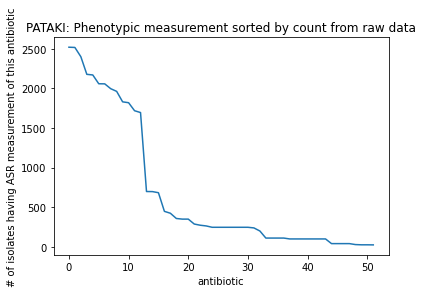

In [28]:
plt.plot(phenotypic.drop('species_fam', axis=1).describe().iloc[0].sort_values(ascending=False).values)
plt.title('PATAKI: Phenotypic measurement sorted by count from raw data')
plt.xlabel('antibiotic')
plt.ylabel('# of isolates having ASR measurement of this antibiotic')

In [29]:
phenotypic['species_fam'].value_counts()

salmonella enterica                                        1717
escherichia coli                                            701
salmonella enterica subsp. enterica serovar typhimurium     100
enterococcus faecium                                         29
Name: species_fam, dtype: int64

<AxesSubplot:title={'center':'PATAKI: Species from raw data'}>

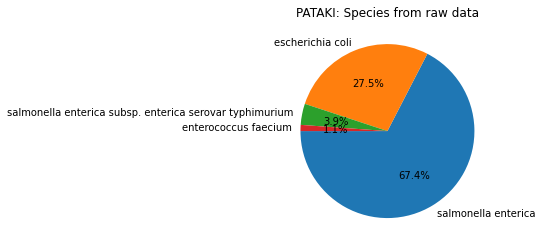

In [30]:
a = phenotypic['species_fam'].value_counts()
a.name=''
a.plot.pie(title='PATAKI: Species from raw data', startangle=180, autopct='%1.1f%%')

In [31]:
phenotypic

antibiotic_name sulfisoxazole ampicillin chloramphenicol tetracycline  \
biosample_id                                                            
SAMN05771806            > 8.0      > 5.0           > 5.0        = 5.0   
SAMN05771805            > 8.0      > 5.0           = 3.0        > 5.0   
SAMN05771804            > 8.0      > 5.0           = 3.0        > 5.0   
SAMN05771803            > 8.0      > 5.0           = 3.0        > 5.0   
SAMN05771802            = 5.0     <= 0.0           = 2.0        > 5.0   
...                       ...        ...             ...          ...   
SAMD00126362              NaN      > 7.0             NaN          NaN   
SAMD00126361              NaN      > 7.0             NaN          NaN   
SAMD00126360              NaN      > 7.0             NaN          NaN   
SAMD00126359              NaN      > 7.0             NaN          NaN   
SAMD00126358              NaN      > 7.0             NaN          NaN   

antibiotic_name amoxicillin-clavulanic acid azithromycin nalidixic acid  \
biosample_id                                                              
SAMN05771806                          = 4.0        = 2.0          = 2.0   
SAMN05771805                          > 5.0        = 2.0          = 2.0   
SAMN05771804                          > 5.0        = 2.0          = 1.0   
SAMN05771803                          > 5.0        = 2.0          = 1.0   
SAMN05771802                         <= 0.0        = 1.0          = 1.0   
...                                     ...          ...            ...   
SAMD00126362                            NaN          NaN          > 4.0   
SAMD00126361                            NaN          NaN          > 4.0   
SAMD00126360                            NaN          NaN          > 4.0   
SAMD00126359                            NaN          NaN          > 4.0   
SAMD00126358                            NaN          NaN          = 4.0   

antibiotic_name cefoxitin ceftiofur gentamicin  ... kanamycin mezlocillin  \
biosample_id                                    ...                         
SAMN05771806        = 1.0    = -1.0     = -1.0  ...       NaN         NaN   
SAMN05771805        > 5.0     > 3.0    <= -2.0  ...       NaN         NaN   
SAMN05771804        > 5.0     = 3.0    <= -2.0  ...       NaN         NaN   
SAMN05771803        > 5.0     > 3.0    <= -2.0  ...       NaN         NaN   
SAMN05771802        = 1.0    = -1.0     = -1.0  ...       NaN         NaN   
...                   ...       ...        ...  ...       ...         ...   
SAMD00126362          NaN       NaN        NaN  ...       NaN         NaN   
SAMD00126361          NaN       NaN        NaN  ...       NaN         NaN   
SAMD00126360          NaN       NaN        NaN  ...       NaN         NaN   
SAMD00126359          NaN       NaN        NaN  ...       NaN         NaN   
SAMD00126358          NaN       NaN        NaN  ...       NaN         NaN   

antibiotic_name oxytetracycline piperacillin cefaclor cefotiam levofloxacin  \
biosample_id                                                                  
SAMN05771806                NaN          NaN      NaN      NaN          NaN   
SAMN05771805                NaN          NaN      NaN      NaN          NaN   
SAMN05771804                NaN          NaN      NaN      NaN          NaN   
SAMN05771803                NaN          NaN      NaN      NaN          NaN   
SAMN05771802                NaN          NaN      NaN      NaN          NaN   
...                         ...          ...      ...      ...          ...   
SAMD00126362                NaN        > 7.0    > 7.0    = 6.0        = 4.0   
SAMD00126361                NaN        > 7.0    > 7.0    = 7.0        = 5.0   
SAMD00126360                NaN        = 7.0    = 7.0    = 4.0        = 3.0   
SAMD00126359                NaN        = 7.0    > 7.0    = 3.0        = 3.0   
SAMD00126358                NaN        > 7.0    > 7.0    = 7.0        = 5.0   

antibiotic_name aztreonam minocycline cefpod

### Matching pen2gen ID

In [32]:
run2biosam_path = '../resources/28.12.21/Pataki_paper/PATAKI_final_for_Amit.2021.12.28/PATAKI_full_SAM_and_SRR_list.xlsx'

In [33]:
filter_list = '../resources/28.12.21/Pataki_paper/PATAKI_final_for_Amit.2021.12.28/PATAKI_filtered_SRR_list_for_Amit.xlsx'

In [34]:
run2biosam = pd.read_excel(run2biosam_path)

In [35]:
run2biosam.columns

Index(['Run', 'BioSample'], dtype='object')

In [36]:
for col in run2biosam.columns:
    print(col + ' uniques is: ', len(np.unique(run2biosam[col].values)))

Run uniques is:  5653
BioSample uniques is:  5611


In [37]:
run2biosam.columns = ['run_id', 'biosample_id']
run2biosam.describe()

run_id  biosample_id
count        5653          5653
unique       5653          5611
top     DRR148121  SAMN03988471
freq            1             5

In [38]:
filtered_data = pd.read_excel(filter_list)
filtered_data.columns = ['species_fam_filter', 'run_id']

In [39]:
filtered_data = filtered_data.merge(right=run2biosam, how='inner', on='run_id')

In [40]:
filtered_data[['run_id', 'biosample_id']].describe()

run_id  biosample_id
count        2082          2082
unique       2082          2082
top     DRR148122  SAMD00126359
freq            1             1

In [41]:
filtered_data = filtered_data.merge(right=phenotypic, how='inner', on='biosample_id')
filtered_data = filtered_data.merge(right=genotypic, how='inner', on='run_id')
filtered_data['DB'] = 'PATAKI'
filtered_data

species_fam_filter      run_id  biosample_id sulfisoxazole ampicillin  \
0                 ecoli   DRR148122  SAMD00126359           NaN      > 7.0   
1                 ecoli   DRR148123  SAMD00126360           NaN      > 7.0   
2                 ecoli   DRR148125  SAMD00126362           NaN      > 7.0   
3                 ecoli   DRR148126  SAMD00126363           NaN      > 7.0   
4                 ecoli   DRR148127  SAMD00126364           NaN      > 7.0   
...                 ...         ...           ...           ...        ...   
2076          senterica  SRR5573144  SAMN02912014         > 8.0     <= 0.0   
2077          senterica  SRR5573145  SAMN02912015         > 8.0     <= 0.0   
2078          senterica  SRR3932966  SAMN05416460         = 5.0     <= 0.0   
2079          senterica  SRR3932967  SAMN05416461         = 5.0     <= 0.0   
2080          senterica  SRR3932968  SAMN05416462         = 6.0     <= 0.0   

     chloramphenicol tetracycline amoxicillin-clavulanic acid azithromycin  \
0                NaN          NaN                         NaN          NaN   
1                NaN          NaN                         NaN          NaN   
2                NaN          NaN                         NaN          NaN   
3                NaN          NaN                         NaN          NaN   
4                NaN          NaN                         NaN          NaN   
...              ...          ...                         ...          ...   
2076           = 3.0        > 5.0                      <= 0.0        = 2.0   
2077           = 3.0        > 5.0                      <= 0.0        = 2.0   
2078           = 3.0       <= 2.0                      <= 0.0        = 2.0   
2079           = 3.0        > 5.0                      <= 0.0        = 2.0   
2080           = 2.0        > 5.0                      <= 0.0        = 2.0   

     nalidixic acid  ... CTX-M-24->seq_cov TEM-63->seq_id TEM-63->seq_cov  \
0             > 4.0  ...               NaN            NaN             NaN   
1             > 4.0  ...               NaN            NaN             NaN   
2             > 4.0  ...               NaN            NaN             NaN   
3             > 4.0  ...               NaN            NaN             NaN   
4             > 4.0  ...               NaN            NaN             NaN   
...             ...  ...               ...            ...             ...   
2076          = 2.0  ...               NaN            NaN             NaN   
2077          = 1.0  ...               NaN            NaN             NaN   
2078          = 2.0  ...               NaN            NaN             NaN   
2079          = 2.0  ...               NaN            NaN             NaN   
2080          = 1.0  ...               NaN            NaN             NaN   

     CTX-M-2->seq_id CTX-M-2->seq_cov ACT-22->seq_id ACT-22->seq_cov  \
0                NaN              NaN            NaN             NaN   
1                NaN              NaN            NaN             NaN   
2                NaN              NaN            NaN             NaN   
3                NaN              NaN            NaN             NaN   
4                NaN              NaN            NaN             NaN   
...              ...              ...            ...             ...   
2076             NaN              NaN            NaN             NaN   
2077             NaN              NaN            NaN             NaN   
2078             NaN              NaN            NaN             NaN   
2079             NaN              NaN            NaN             NaN   
2080             NaN              NaN            NaN             NaN   

     CTX-M-66->seq_id CTX-M-66->seq_cov      DB  
0                 NaN               NaN  PATAKI  
1                 NaN               NaN  PATAKI  
2                 NaN               NaN  PATAKI  
3                 NaN               NaN  PATAKI  
4                 NaN               NaN  PATAKI  
...               ...               ...  

<AxesSubplot:title={'center':'Species'}>

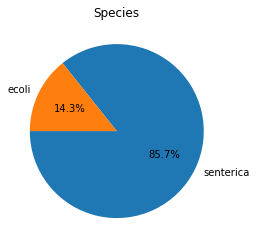

In [42]:
a = filtered_data['species_fam_filter'].value_counts()
a.name=''
a.plot.pie(title='Species', startangle=180, autopct='%1.1f%%')

In [43]:
filtered_data[['species_fam_filter', 'species_fam']].value_counts()

species_fam_filter  species_fam                                            
senterica           salmonella enterica                                        1687
ecoli               escherichia coli                                            296
senterica           salmonella enterica subsp. enterica serovar typhimurium      96
ecoli               salmonella enterica                                           1
senterica           escherichia coli                                              1
dtype: int64

In [44]:
filtered_data[['run_id','biosample_id']].describe()

run_id  biosample_id
count        2081          2081
unique       2081          2081
top     DRR148122  SAMD00126359
freq            1             1

In [45]:
pataki_labels = list(set(phenotypic.columns)-set(['species_fam', 'species_fam_filter', 'biosample_id']))
pataki_features = list(set(genotypic.columns)-set(['run_id']))

In [94]:
if not os.path.exists('../pre_proccesing/base_line/VAMP'):
    os.makedirs('../pre_proccesing/base_line/VAMP')

In [95]:
try:
    geno = pd.read_csv('../pre_proccesing/base_line/VAMP/geno.csv')
except:
    geno, error = p_utils.get_genotype_per_db("../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMPr.results.for.Amit")
    geno.to_csv('../pre_proccesing/base_line/VAMP/geno.csv', index=False)

  9%|▉         | 301/3202 [00:21<03:26, 14.03it/s]

SRR5168376: is missing csv file


100%|██████████| 3202/3202 [04:41<00:00, 11.37it/s]


In [96]:
try:
    pheno = pd.read_csv('../pre_proccesing/base_line/VAMP/pheno.csv')
except:
    pheno, error = p_utils.get_phenotype_per_db("../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data", db_name='VAMP')
    pheno.to_csv('../pre_proccesing/base_line/VAMP/pheno.csv', index=False)

  0%|          | 8/3376 [00:00<00:44, 75.13it/s]

SAMN08045836: not excepted measure values
SAMN08045835: not excepted measure values
SAMN07450858: not excepted measure values
SAMN07450857: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07450854.csv: problem loading file
SAMN07450854.csv
SAMN07450853: not excepted measure values
SAMN07450852: not excepted measure values
SAMN07450850: not excepted measure values
SAMN07450848: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07450847.csv: problem loading file
SAMN07450847.csv
SAMN07450845: not excepted measure values
SAMN07450844: not excepted measure values
SAMN07410719: not excepted measure values
SAMN07410718: not excepted measure values
SAMN07410716: not excepted measure values
SAMN07410714: not excepted measure values
SAMN07410713: not excepted measure values
SAMN07410712: not excepted measure values


  1%|          | 37/3376 [00:00<00:37, 89.80it/s]

SAMN07410711: not excepted measure values
SAMN07410710: not excepted measure values
SAMN07410709: not excepted measure values
SAMN07410708: not excepted measure values
SAMN07410707: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07332520.csv: problem loading file
SAMN07332520.csv
SAMN07332519: not excepted measure values
SAMN07332518: not excepted measure values
SAMN07332517: not excepted measure values
SAMN07332516: not excepted measure values
SAMN07332515: not excepted measure values
SAMN07332514: not excepted measure values
SAMN07332513: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07332512.csv: problem loading file
SAMN07332512.csv
SAMN07332511: not excepted measure values
SAMN07332510: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07332509.csv: problem load

  1%|▏         | 46/3376 [00:00<00:43, 76.29it/s]

SAMN07325907: not excepted measure values
SAMN07325906: not excepted measure values
SAMN07325905: not excepted measure values
SAMN07325904: not excepted measure values
SAMN07325903: not excepted measure values
SAMN07325902: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07325901.csv: problem loading file
SAMN07325901.csv
SAMN07325899: not excepted measure values
SAMN07325898: not excepted measure values
SAMN07325896: not excepted measure values
SAMN07325895: not excepted measure values
SAMN07325894: not excepted measure values
SAMN07325893: not excepted measure values
SAMN07291569: not excepted measure values


  2%|▏         | 63/3376 [00:00<00:45, 73.42it/s]

SAMN07291568: not excepted measure values
SAMN07291567: not excepted measure values
SAMN07291566: not excepted measure values
SAMN07291565: not excepted measure values
SAMN07291564: not excepted measure values
SAMN07291563: not excepted measure values
SAMN07291562: not excepted measure values
SAMN07291561: not excepted measure values
SAMN07291560: not excepted measure values
SAMN07291559: not excepted measure values
SAMN07291558: not excepted measure values
SAMN07291557: not excepted measure values
SAMN07291555: not excepted measure values
SAMN07291554: not excepted measure values
SAMN07291553: not excepted measure values
SAMN07291552: not excepted measure values


  2%|▏         | 79/3376 [00:01<00:44, 73.39it/s]

SAMN07291551: not excepted measure values
SAMN07291550: not excepted measure values
SAMN07291549: not excepted measure values
SAMN07291548: not excepted measure values
SAMN07291547: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07291545.csv: problem loading file
SAMN07291545.csv
SAMN07291544: not excepted measure values
SAMN07291543: not excepted measure values
SAMN07291542: not excepted measure values
SAMN07291541: not excepted measure values
SAMN07291540: not excepted measure values
SAMN07291539: not excepted measure values
SAMN07291538: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07291537.csv: problem loading file
SAMN07291537.csv
SAMN07291536: not excepted measure values
SAMN07291535: not excepted measure values


  3%|▎         | 97/3376 [00:01<00:43, 75.42it/s]

SAMN07291534: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07291533.csv: problem loading file
SAMN07291533.csv
SAMN07291532: not excepted measure values
SAMN07291531: not excepted measure values
SAMN07291530: not excepted measure values
SAMN07291529: not excepted measure values
SAMN07291528: not excepted measure values
SAMN07291527: not excepted measure values
SAMN07291526: not excepted measure values
SAMN07291524: not excepted measure values
SAMN07291521: not excepted measure values
SAMN07291519: not excepted measure values
SAMN07291517: not excepted measure values
SAMN07291515: not excepted measure values
SAMN07291514: not excepted measure values
SAMN07291513: not excepted measure values


  3%|▎         | 114/3376 [00:01<00:43, 75.07it/s]

SAMN07291512: not excepted measure values
SAMN07291511: not excepted measure values
SAMN07291506: not excepted measure values
SAMN07291505: not excepted measure values
SAMN07291504: not excepted measure values
SAMN07291503: not excepted measure values
SAMN07291502: not excepted measure values
SAMN07291501: not excepted measure values
SAMN07291500: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07291499.csv: problem loading file
SAMN07291499.csv
SAMN07291498: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07291497.csv: problem loading file
SAMN07291497.csv
SAMN07291496: not excepted measure values
SAMN07291495: not excepted measure values
SAMN07291494: not excepted measure values
SAMN07265011: not excepted measure values


  4%|▎         | 122/3376 [00:01<00:46, 70.16it/s]

SAMN06754743: not excepted measure values
SAMN06754743(1): not excepted measure values
SAMN06754742: not excepted measure values
SAMN06754741: not excepted measure values
SAMN06754739: not excepted measure values
SAMN06754738: not excepted measure values
SAMN06754737: not excepted measure values
SAMN06754736: not excepted measure values
SAMN06754735: not excepted measure values
SAMN06754734: not excepted measure values
SAMN06754733: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN06754732.csv: problem loading file
SAMN06754732.csv
SAMN06754731: not excepted measure values
SAMN06754730: not excepted measure values
SAMN06754729: not excepted measure values


  4%|▍         | 139/3376 [00:01<00:45, 70.64it/s]

SAMN06680411: not excepted measure values
SAMN06680409: not excepted measure values
SAMN06680408: not excepted measure values
SAMN06680406: not excepted measure values
SAMN06680405: not excepted measure values
SAMN06680404: not excepted measure values
SAMN06680403: not excepted measure values
SAMN06680401: not excepted measure values
SAMN06680400: not excepted measure values
SAMN06680399: not excepted measure values
SAMN06680398: not excepted measure values
SAMN06672151: not excepted measure values
SAMN06672150: not excepted measure values
SAMN06672149: not excepted measure values


  5%|▍         | 156/3376 [00:02<00:43, 73.82it/s]

SAMN06546425: not excepted measure values
SAMN06546424: not excepted measure values
SAMN06546423: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN06546420.csv: problem loading file
SAMN06546420.csv
SAMN06546419: not excepted measure values
SAMN06311521: not excepted measure values
SAMN06311519: not excepted measure values
SAMN06311518: not excepted measure values
SAMN06311517: not excepted measure values
SAMN06311516: not excepted measure values
SAMN06311515: not excepted measure values
SAMN06129827: not excepted measure values
SAMN06129826: not excepted measure values
SAMN06129824: not excepted measure values
SAMN06124915: not excepted measure values


  5%|▌         | 173/3376 [00:02<00:41, 78.00it/s]

SAMN06015669: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN06015668.csv: problem loading file
SAMN06015668.csv
SAMN06015667: not excepted measure values
SAMN06015666: not excepted measure values
SAMN06015665: not excepted measure values
SAMN06015664: not excepted measure values
SAMN06015663: not excepted measure values
SAMN06015662: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN06015658.csv: problem loading file
SAMN06015658.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN06007776.csv: problem loading file
SAMN06007776.csv
SAMN06007775: not excepted measure values
SAMN06007774: not excepted measure values
SAMN06007773: not excepted measure values
SAMN06007771: not excepted measure values
SAMN06007770: not excepted measure values
SAMN06007769: not excepted measure values
SAMN06007768: no

  6%|▌         | 189/3376 [00:02<00:44, 71.79it/s]

SAMN05898669: not excepted measure values
SAMN05898668: not excepted measure values
SAMN05898667: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898666.csv: problem loading file
SAMN05898666.csv
SAMN05898665: not excepted measure values
SAMN05898664: not excepted measure values
SAMN05898663: not excepted measure values
SAMN05898662: not excepted measure values
SAMN05898661: not excepted measure values
SAMN05898660: not excepted measure values
SAMN05898659: not excepted measure values
SAMN05898658: not excepted measure values
SAMN05898657: not excepted measure values
SAMN05898656: not excepted measure values


  6%|▌         | 205/3376 [00:02<00:43, 72.54it/s]

SAMN05898655: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898654.csv: problem loading file
SAMN05898654.csv
SAMN05898653: not excepted measure values
SAMN05898652: not excepted measure values
SAMN05898651: not excepted measure values
SAMN05898650: not excepted measure values
SAMN05898649: not excepted measure values
SAMN05898648: not excepted measure values
SAMN05898647: not excepted measure values
SAMN05898646: not excepted measure values
SAMN05898645: not excepted measure values
SAMN05898644: not excepted measure values
SAMN05898643: not excepted measure values
SAMN05898642: not excepted measure values


  7%|▋         | 221/3376 [00:02<00:43, 71.79it/s]

SAMN05898641: not excepted measure values
SAMN05898640: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898639.csv: problem loading file
SAMN05898639.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898638.csv: problem loading file
SAMN05898638.csv
SAMN05898637: not excepted measure values
SAMN05898636: not excepted measure values
SAMN05898635: not excepted measure values
SAMN05898634: not excepted measure values
SAMN05898633: not excepted measure values
SAMN05898632: not excepted measure values
SAMN05898631: not excepted measure values
SAMN05898630: not excepted measure values
SAMN05898629: not excepted measure values
SAMN05898628: not excepted measure values
SAMN05898627: not excepted measure values
SAMN05898626: not excepted measure values
SAMN05898625: not excepted measure values


  7%|▋         | 229/3376 [00:03<00:44, 70.46it/s]

SAMN05898624: not excepted measure values
SAMN05898623: not excepted measure values
SAMN05898622: not excepted measure values
SAMN05898621: not excepted measure values
SAMN05898620: not excepted measure values
SAMN05898619: not excepted measure values
SAMN05898618: not excepted measure values
SAMN05898617: not excepted measure values
SAMN05898616: not excepted measure values
SAMN05898615: not excepted measure values
SAMN05898614: not excepted measure values
SAMN05898613: not excepted measure values
SAMN05898612: not excepted measure values


  7%|▋         | 253/3376 [00:03<00:44, 70.06it/s]

SAMN05898611: not excepted measure values
SAMN05898610: not excepted measure values
SAMN05898609: not excepted measure values
SAMN05898608: not excepted measure values
SAMN05898607: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898606.csv: problem loading file
SAMN05898606.csv
SAMN05898605: not excepted measure values
SAMN05898604: not excepted measure values
SAMN05898603: not excepted measure values
SAMN05898602: not excepted measure values
SAMN05898601: not excepted measure values
SAMN05898600: not excepted measure values
SAMN05898599: not excepted measure values
SAMN05898598: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898597.csv: problem loading file
SAMN05898597.csv
SAMN05898596: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898595.csv: problem load

  8%|▊         | 263/3376 [00:03<00:40, 76.77it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898593.csv: problem loading file
SAMN05898593.csv
SAMN05898592: not excepted measure values
SAMN05898591: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898590.csv: problem loading file
SAMN05898590.csv
SAMN05898589: not excepted measure values
SAMN05898588: not excepted measure values
SAMN05898587: not excepted measure values
SAMN05898586: not excepted measure values
SAMN05898585: not excepted measure values
SAMN05898584: not excepted measure values
SAMN05898583: not excepted measure values
SAMN05898582: not excepted measure values
SAMN05898581: not excepted measure values
SAMN05898580: not excepted measure values
SAMN05898579: not excepted measure values
SAMN05898578: not excepted measure values


  8%|▊         | 279/3376 [00:03<00:42, 73.42it/s]

SAMN05898577: not excepted measure values
SAMN05898576: not excepted measure values
SAMN05898575: not excepted measure values
SAMN05898574: not excepted measure values
SAMN05898573: not excepted measure values
SAMN05898572: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898571.csv: problem loading file
SAMN05898571.csv
SAMN05898570: not excepted measure values
SAMN05898569: not excepted measure values
SAMN05898568: not excepted measure values
SAMN05898567: not excepted measure values
SAMN05898566: not excepted measure values
SAMN05898565: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898564.csv: problem loading file
SAMN05898564.csv
SAMN05898563: not excepted measure values
SAMN05898562: not excepted measure values


  9%|▉         | 296/3376 [00:03<00:39, 77.63it/s]

SAMN05898561: not excepted measure values
SAMN05898560: not excepted measure values
SAMN05898559: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898558.csv: problem loading file
SAMN05898558.csv
SAMN05898557: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898556.csv: problem loading file
SAMN05898556.csv
SAMN05898555: not excepted measure values
SAMN05898554: not excepted measure values
SAMN05898553: not excepted measure values
SAMN05898552: not excepted measure values
SAMN05898551: not excepted measure values
SAMN05898550: not excepted measure values
SAMN05898549: not excepted measure values
SAMN05898548: not excepted measure values
SAMN05898547: not excepted measure values
SAMN05898546: not excepted measure values


  9%|▉         | 312/3376 [00:04<00:42, 72.29it/s]

SAMN05898545: not excepted measure values
SAMN05898544: not excepted measure values
SAMN05898543: not excepted measure values
SAMN05898542: not excepted measure values
SAMN05898541: not excepted measure values
SAMN05898540: not excepted measure values
SAMN05898539: not excepted measure values
SAMN05898538: not excepted measure values
SAMN05898537: not excepted measure values
SAMN05898536: not excepted measure values
SAMN05898535: not excepted measure values
SAMN05898534: not excepted measure values
SAMN05898533: not excepted measure values
SAMN05806176: not excepted measure values


 10%|▉         | 329/3376 [00:04<00:42, 71.90it/s]

SAMN05806175: not excepted measure values
SAMN05806174: not excepted measure values
SAMN05806169: not excepted measure values
SAMN05806168: not excepted measure values
SAMN05806167: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05806166.csv: problem loading file
SAMN05806166.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05806165.csv: problem loading file
SAMN05806165.csv
SAMN05806164: not excepted measure values
SAMN05806164(1): not excepted measure values
SAMN05806162: not excepted measure values
SAMN05806161: not excepted measure values
SAMN05774085: not excepted measure values
SAMN05774084: not excepted measure values
SAMN05774083: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05774082.csv: problem loading file
SAMN05774082.csv
SAMN05774081: not excepted measure values


 10%|█         | 345/3376 [00:04<00:41, 72.25it/s]

SAMN05774080: not excepted measure values
SAMN05774079: not excepted measure values
SAMN05774078: not excepted measure values
SAMN05774077: not excepted measure values
SAMN05774076: not excepted measure values
SAMN05774075: not excepted measure values
SAMN05774073: not excepted measure values
SAMN05510459: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05510457.csv: problem loading file
SAMN05510457.csv
SAMN05510456: not excepted measure values
SAMN05510455: not excepted measure values
SAMN05510454: not excepted measure values
SAMN05510453: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05463124.csv: problem loading file
SAMN05463124.csv
SAMN05463123: not excepted measure values


 11%|█         | 362/3376 [00:04<00:42, 70.78it/s]

SAMN05374486: not excepted measure values
SAMN05374484: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05374483.csv: problem loading file
SAMN05374483.csv
SAMN05374482: not excepted measure values
SAMN05374481: not excepted measure values
SAMN05374480: not excepted measure values
SAMN05374479: not excepted measure values
SAMN05374478: not excepted measure values
SAMN05210256: not excepted measure values
SAMN05210136: not excepted measure values
SAMN05202020: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05202019.csv: problem loading file
SAMN05202019.csv
SAMN05202018: not excepted measure values
SAMN05202017: not excepted measure values
SAMN05202016: not excepted measure values


 11%|█         | 370/3376 [00:05<00:43, 68.38it/s]

SAMN05202015: not excepted measure values
SAMN05202014: not excepted measure values
SAMN05202013: not excepted measure values
SAMN05202012: not excepted measure values
SAMN05202011: not excepted measure values
SAMN05202010: not excepted measure values
SAMN05202009: not excepted measure values
SAMN05202008: not excepted measure values
SAMN05202007: not excepted measure values
SAMN05202006: not excepted measure values
SAMN05202005: not excepted measure values
SAMN05202004: not excepted measure values
SAMN05202003: not excepted measure values


 11%|█▏        | 384/3376 [00:05<00:47, 63.46it/s]

SAMN05202002: not excepted measure values
SAMN05202001: not excepted measure values
SAMN05202000: not excepted measure values
SAMN05201999: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201998.csv: problem loading file
SAMN05201998.csv
SAMN05201997: not excepted measure values
SAMN05201996: not excepted measure values
SAMN05201995: not excepted measure values
SAMN05201994: not excepted measure values
SAMN05201993: not excepted measure values
SAMN05201992: not excepted measure values
SAMN05201991: not excepted measure values
SAMN05201990: not excepted measure values


 12%|█▏        | 398/3376 [00:05<00:50, 58.98it/s]

SAMN05201989: not excepted measure values
SAMN05201988: not excepted measure values
SAMN05201987: not excepted measure values
SAMN05201986: not excepted measure values
SAMN05201985: not excepted measure values
SAMN05201984: not excepted measure values
SAMN05201983: not excepted measure values
SAMN05201982: not excepted measure values
SAMN05201981: not excepted measure values
SAMN05201980: not excepted measure values
SAMN05201979: not excepted measure values


 12%|█▏        | 410/3376 [00:05<00:54, 54.44it/s]

SAMN05201978: not excepted measure values
SAMN05201977: not excepted measure values
SAMN05201976: not excepted measure values
SAMN05201975: not excepted measure values
SAMN05201974: not excepted measure values
SAMN05201973: not excepted measure values
SAMN05201973(1): not excepted measure values
SAMN05201972: not excepted measure values
SAMN05201971: not excepted measure values
SAMN05201970: not excepted measure values
SAMN05201969: not excepted measure values


 12%|█▏        | 417/3376 [00:05<00:52, 56.60it/s]

SAMN05201968: not excepted measure values
SAMN05201967: not excepted measure values
SAMN05201967(1): not excepted measure values
SAMN05201966: not excepted measure values
SAMN05201965: not excepted measure values
SAMN05201964: not excepted measure values
SAMN05201963: not excepted measure values
SAMN05201962: not excepted measure values
SAMN05201961: not excepted measure values


 13%|█▎        | 430/3376 [00:06<00:58, 50.38it/s]

SAMN05201960: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201959.csv: problem loading file
SAMN05201959.csv
SAMN05201958: not excepted measure values
SAMN05201957: not excepted measure values
SAMN05201956: not excepted measure values
SAMN05201955: not excepted measure values
SAMN05201954: not excepted measure values
SAMN05201953: not excepted measure values
SAMN05201952: not excepted measure values
SAMN05201951: not excepted measure values
SAMN05201950: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201949.csv: problem loading file
SAMN05201949.csv
SAMN05201948: not excepted measure values
SAMN05201947: not excepted measure values
SAMN05201946: not excepted measure values


 13%|█▎        | 442/3376 [00:06<00:58, 50.55it/s]

SAMN05201945: not excepted measure values
SAMN05201944: not excepted measure values
SAMN05201943: not excepted measure values
SAMN05201942: not excepted measure values
SAMN05201941: not excepted measure values
SAMN05201940: not excepted measure values
SAMN05201939: not excepted measure values
SAMN05201938: not excepted measure values
SAMN05201937: not excepted measure values
SAMN05201936: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201935.csv: problem loading file
SAMN05201935.csv


 13%|█▎        | 455/3376 [00:06<00:53, 54.44it/s]

SAMN05201934: not excepted measure values
SAMN05201933: not excepted measure values
SAMN05201932: not excepted measure values
SAMN05201931: not excepted measure values
SAMN05201930: not excepted measure values
SAMN05201929: not excepted measure values
SAMN05201928: not excepted measure values
SAMN05201927: not excepted measure values
SAMN05201926: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201925.csv: problem loading file
SAMN05201925.csv
SAMN05201924: not excepted measure values
SAMN05201923: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201922.csv: problem loading file
SAMN05201922.csv
SAMN05201921: not excepted measure values


 14%|█▍        | 469/3376 [00:06<00:49, 58.58it/s]

SAMN05201920: not excepted measure values
SAMN05201919: not excepted measure values
SAMN05201918: not excepted measure values
SAMN05201917: not excepted measure values
SAMN05201916: not excepted measure values
SAMN05201915: not excepted measure values
SAMN05201914: not excepted measure values
SAMN05201913: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201912.csv: problem loading file
SAMN05201912.csv
SAMN05201911: not excepted measure values
SAMN05201910: not excepted measure values
SAMN05201909: not excepted measure values


 14%|█▍        | 481/3376 [00:07<00:52, 55.20it/s]

SAMN05201908: not excepted measure values
SAMN05201907: not excepted measure values
SAMN05201906: not excepted measure values
SAMN05201905: not excepted measure values
SAMN05201904: not excepted measure values
SAMN05201903: not excepted measure values
SAMN05201902: not excepted measure values
SAMN05201901: not excepted measure values
SAMN05201900: not excepted measure values
SAMN05201899: not excepted measure values
SAMN05201898: not excepted measure values
SAMN05201897: not excepted measure values


 15%|█▍        | 493/3376 [00:07<00:52, 55.33it/s]

SAMN05201896: not excepted measure values
SAMN05201895: not excepted measure values
SAMN05201894: not excepted measure values
SAMN05201893: not excepted measure values
SAMN05201892: not excepted measure values
SAMN05201891: not excepted measure values
SAMN05201890: not excepted measure values
SAMN05201889: not excepted measure values
SAMN05201888: not excepted measure values
SAMN05201887: not excepted measure values
SAMN05201886: not excepted measure values
SAMN05201885: not excepted measure values


 15%|█▍        | 506/3376 [00:07<00:50, 57.36it/s]

SAMN05201884: not excepted measure values
SAMN05201883: not excepted measure values
SAMN05201882: not excepted measure values
SAMN05201881: not excepted measure values
SAMN05201880: not excepted measure values
SAMN05201879: not excepted measure values
SAMN05201878: not excepted measure values
SAMN05201877: not excepted measure values
SAMN05201876: not excepted measure values
SAMN05201875: not excepted measure values
SAMN05201874: not excepted measure values
SAMN05201873: not excepted measure values
SAMN05201872: not excepted measure values


 15%|█▌        | 520/3376 [00:07<00:45, 62.16it/s]

SAMN05201871: not excepted measure values
SAMN05201870: not excepted measure values
SAMN05201869: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201868.csv: problem loading file
SAMN05201868.csv
SAMN05201867: not excepted measure values
SAMN05201866: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201865.csv: problem loading file
SAMN05201865.csv
SAMN05201864: not excepted measure values
SAMN05201863: not excepted measure values
SAMN05201862: not excepted measure values
SAMN05201861: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201860.csv: problem loading file
SAMN05201860.csv
SAMN05201859: not excepted measure values
SAMN05201858: not excepted measure values
SAMN05201857: not excepted measure values


 16%|█▌        | 535/3376 [00:07<00:44, 63.40it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201856.csv: problem loading file
SAMN05201856.csv
SAMN05201855: not excepted measure values
SAMN05201854: not excepted measure values
SAMN05201853: not excepted measure values
SAMN05201852: not excepted measure values
SAMN05201851: not excepted measure values
SAMN05201850: not excepted measure values
SAMN05201849: not excepted measure values
SAMN05201848: not excepted measure values
SAMN05201847: not excepted measure values
SAMN05201846: not excepted measure values
SAMN05201845: not excepted measure values
SAMN05201844: not excepted measure values


 16%|█▋        | 549/3376 [00:08<00:47, 59.36it/s]

SAMN05201843: not excepted measure values
SAMN05201842: not excepted measure values
SAMN05201841: not excepted measure values
SAMN05201840: not excepted measure values
SAMN05201839: not excepted measure values
SAMN05201838: not excepted measure values
SAMN05201837: not excepted measure values
SAMN05201836: not excepted measure values
SAMN05201835: not excepted measure values
SAMN05201834: not excepted measure values
SAMN05201833: not excepted measure values
SAMN05201832: not excepted measure values


 16%|█▋        | 555/3376 [00:08<00:47, 59.33it/s]

SAMN05201831: not excepted measure values
SAMN05201830: not excepted measure values
SAMN05201829: not excepted measure values
SAMN05201828: not excepted measure values
SAMN05201827: not excepted measure values
SAMN05201826: not excepted measure values
SAMN05201825: not excepted measure values
SAMN05201824: not excepted measure values
SAMN05201823: not excepted measure values
SAMN05201822: not excepted measure values
SAMN05201821: not excepted measure values
SAMN05201820: not excepted measure values
SAMN05201819: not excepted measure values


 17%|█▋        | 568/3376 [00:08<00:54, 51.20it/s]

SAMN05201818: not excepted measure values
SAMN05201817: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201816.csv: problem loading file
SAMN05201816.csv
SAMN05201815: not excepted measure values
SAMN05201814: not excepted measure values
SAMN05201813: not excepted measure values
SAMN05201812: not excepted measure values
SAMN05201811: not excepted measure values
SAMN05201810: not excepted measure values
SAMN05201809: not excepted measure values


 17%|█▋        | 580/3376 [00:08<00:55, 50.04it/s]

SAMN05201808: not excepted measure values
SAMN05201807: not excepted measure values
SAMN05201806: not excepted measure values
SAMN05201805: not excepted measure values
SAMN05201804: not excepted measure values
SAMN05201803: not excepted measure values
SAMN05201802: not excepted measure values
SAMN05201801: not excepted measure values
SAMN05201800: not excepted measure values
SAMN05201799: not excepted measure values
SAMN05201798: not excepted measure values


 18%|█▊        | 592/3376 [00:09<00:54, 51.42it/s]

SAMN05201797: not excepted measure values
SAMN05201796: not excepted measure values
SAMN05201795: not excepted measure values
SAMN05201794: not excepted measure values
SAMN05201793: not excepted measure values
SAMN05201792: not excepted measure values
SAMN05201791: not excepted measure values
SAMN05201790: not excepted measure values
SAMN05201789: not excepted measure values
SAMN05201788: not excepted measure values
SAMN05201787: not excepted measure values
SAMN05201786: not excepted measure values


 18%|█▊        | 605/3376 [00:09<00:48, 57.61it/s]

SAMN05201785: not excepted measure values
SAMN05201784: not excepted measure values
SAMN05201783: not excepted measure values
SAMN05201782: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201781.csv: problem loading file
SAMN05201781.csv
SAMN05201780: not excepted measure values
SAMN05201779: not excepted measure values
SAMN05201778: not excepted measure values
SAMN05201777: not excepted measure values
SAMN05201776: not excepted measure values
SAMN05201775: not excepted measure values
SAMN05201774: not excepted measure values
SAMN05201773: not excepted measure values
SAMN05201772: not excepted measure values


 18%|█▊        | 620/3376 [00:09<00:42, 64.87it/s]

SAMN05201771: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201770.csv: problem loading file
SAMN05201770.csv
SAMN05201769: not excepted measure values
SAMN05201768: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201767.csv: problem loading file
SAMN05201767.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201766.csv: problem loading file
SAMN05201766.csv
SAMN05201765: not excepted measure values
SAMN05201764: not excepted measure values
SAMN05201763: not excepted measure values
SAMN05201762: not excepted measure values
SAMN05201761: not excepted measure values
SAMN05201760: not excepted measure values
SAMN05201759: not excepted measure values
SAMN05201758: not excepted measure values
SAMN05201757: not excepted measure values
SAMN05201756: not excepted measure values


 19%|█▉        | 634/3376 [00:09<00:47, 57.57it/s]

SAMN05201755: not excepted measure values
SAMN05201754: not excepted measure values
SAMN05201753: not excepted measure values
SAMN05201751: not excepted measure values
SAMN05201750: not excepted measure values
SAMN05201749: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201748.csv: problem loading file
SAMN05201748.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201747.csv: problem loading file
SAMN05201747.csv
SAMN05201746: not excepted measure values
SAMN05201745: not excepted measure values


 19%|█▉        | 646/3376 [00:09<00:48, 56.14it/s]

SAMN05201744: not excepted measure values
SAMN05201743: not excepted measure values
SAMN05201742: not excepted measure values
SAMN05201741: not excepted measure values
SAMN05201740: not excepted measure values
SAMN05201739: not excepted measure values
SAMN05201738: not excepted measure values
SAMN05201737: not excepted measure values
SAMN05201736: not excepted measure values
SAMN05201735: not excepted measure values
SAMN05201734: not excepted measure values
SAMN05201733: not excepted measure values
SAMN05201732: not excepted measure values


 19%|█▉        | 658/3376 [00:10<00:52, 52.06it/s]

SAMN05201731: not excepted measure values
SAMN05201730: not excepted measure values
SAMN05201729: not excepted measure values
SAMN05201728: not excepted measure values
SAMN05201727: not excepted measure values
SAMN05201726: not excepted measure values
SAMN05201725: not excepted measure values
SAMN05201724: not excepted measure values
SAMN05201723: not excepted measure values
SAMN05201722: not excepted measure values


 20%|█▉        | 671/3376 [00:10<00:48, 55.73it/s]

SAMN05201721: not excepted measure values
SAMN05201720: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201719.csv: problem loading file
SAMN05201719.csv
SAMN05201718: not excepted measure values
SAMN05201717: not excepted measure values
SAMN05201716: not excepted measure values
SAMN05201715: not excepted measure values
SAMN05201714: not excepted measure values
SAMN05201713: not excepted measure values
SAMN05201712: not excepted measure values
SAMN05201711: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201710.csv: problem loading file
SAMN05201710.csv
SAMN05201709: not excepted measure values


 20%|██        | 677/3376 [00:10<00:51, 52.75it/s]

SAMN05201708: not excepted measure values
SAMN05201707: not excepted measure values
SAMN05201706: not excepted measure values
SAMN05201705: not excepted measure values
SAMN05201704: not excepted measure values
SAMN05201703: not excepted measure values
SAMN05201702: not excepted measure values
SAMN05201701: not excepted measure values
SAMN05201700: not excepted measure values
SAMN05201699: not excepted measure values
SAMN05201698: not excepted measure values


 20%|██        | 689/3376 [00:10<00:53, 50.02it/s]

SAMN05201697: not excepted measure values
SAMN05201696: not excepted measure values
SAMN05201695: not excepted measure values
SAMN05201694: not excepted measure values
SAMN05201693: not excepted measure values
SAMN05201692: not excepted measure values
SAMN05201691: not excepted measure values
SAMN05201690: not excepted measure values
SAMN05201689: not excepted measure values
SAMN05201688: not excepted measure values


 21%|██        | 702/3376 [00:11<00:50, 52.79it/s]

SAMN05201687: not excepted measure values
SAMN05201686: not excepted measure values
SAMN05201685: not excepted measure values
SAMN05201684: not excepted measure values
SAMN05201683: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201682.csv: problem loading file
SAMN05201682.csv
SAMN05201681: not excepted measure values
SAMN05201680: not excepted measure values
SAMN05201679: not excepted measure values
SAMN05201678: not excepted measure values
SAMN05201677: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201676.csv: problem loading file
SAMN05201676.csv
SAMN05201675: not excepted measure values


 21%|██        | 714/3376 [00:11<00:53, 49.94it/s]

SAMN05201674: not excepted measure values
SAMN05201673: not excepted measure values
SAMN05201672: not excepted measure values
SAMN05201671: not excepted measure values
SAMN05201670: not excepted measure values
SAMN05201669: not excepted measure values
SAMN05201668: not excepted measure values
SAMN05201667: not excepted measure values
SAMN05201666: not excepted measure values
SAMN05201665: not excepted measure values


 22%|██▏       | 727/3376 [00:11<00:50, 52.65it/s]

SAMN05201664: not excepted measure values
SAMN05201663: not excepted measure values
SAMN05201662: not excepted measure values
SAMN05201661: not excepted measure values
SAMN05201660: not excepted measure values
SAMN05201659: not excepted measure values
SAMN05201658: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201657.csv: problem loading file
SAMN05201657.csv
SAMN05201656: not excepted measure values
SAMN05201655: not excepted measure values
SAMN05201654: not excepted measure values
SAMN05201653: not excepted measure values


 22%|██▏       | 734/3376 [00:11<00:47, 55.94it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201652.csv: problem loading file
SAMN05201652.csv
SAMN05201651: not excepted measure values
SAMN05201650: not excepted measure values
SAMN05201649: not excepted measure values
SAMN05201648: not excepted measure values
SAMN05201647: not excepted measure values
SAMN05201646: not excepted measure values
SAMN05201645: not excepted measure values
SAMN05201644: not excepted measure values
SAMN05201643: not excepted measure values
SAMN05201642: not excepted measure values


 22%|██▏       | 747/3376 [00:11<00:46, 56.09it/s]

SAMN05201641: not excepted measure values
SAMN05201640: not excepted measure values
SAMN05201639: not excepted measure values
SAMN05201638: not excepted measure values
SAMN05201637: not excepted measure values
SAMN05201636: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201635.csv: problem loading file
SAMN05201635.csv
SAMN05201634: not excepted measure values
SAMN05201633: not excepted measure values
SAMN05201632: not excepted measure values
SAMN05201631: not excepted measure values
SAMN05201630: not excepted measure values
SAMN05201629: not excepted measure values


 22%|██▏       | 759/3376 [00:12<00:48, 53.42it/s]

SAMN05201628: not excepted measure values
SAMN05201627: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201626.csv: problem loading file
SAMN05201626.csv
SAMN05201625: not excepted measure values
SAMN05201624: not excepted measure values
SAMN05201623: not excepted measure values
SAMN05201622: not excepted measure values
SAMN05201621: not excepted measure values
SAMN05201620: not excepted measure values
SAMN05201619: not excepted measure values


 23%|██▎       | 771/3376 [00:12<00:51, 51.02it/s]

SAMN05201618: not excepted measure values
SAMN05201617: not excepted measure values
SAMN05201616: not excepted measure values
SAMN05201615: not excepted measure values
SAMN05201614: not excepted measure values
SAMN05201613: not excepted measure values
SAMN05201612: not excepted measure values
SAMN05201611: not excepted measure values
SAMN05201610: not excepted measure values
SAMN05201609: not excepted measure values
SAMN05201608: not excepted measure values


 23%|██▎       | 783/3376 [00:12<00:50, 51.25it/s]

SAMN05201607: not excepted measure values
SAMN05201606: not excepted measure values
SAMN05201605: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201604.csv: problem loading file
SAMN05201604.csv
SAMN05201603: not excepted measure values
SAMN05201602: not excepted measure values
SAMN05201601: not excepted measure values
SAMN05201600: not excepted measure values
SAMN05201599: not excepted measure values
SAMN05201598: not excepted measure values
SAMN05201597: not excepted measure values
SAMN05201596: not excepted measure values


 23%|██▎       | 789/3376 [00:12<00:54, 47.24it/s]

SAMN05201595: not excepted measure values
SAMN05201594: not excepted measure values
SAMN05201593: not excepted measure values
SAMN05201592: not excepted measure values
SAMN05201591: not excepted measure values
SAMN05201590: not excepted measure values
SAMN05201589: not excepted measure values
SAMN05201588: not excepted measure values
SAMN05201587: not excepted measure values
SAMN05201586: not excepted measure values


 24%|██▎       | 801/3376 [00:13<00:53, 48.20it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201585.csv: problem loading file
SAMN05201585.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201584.csv: problem loading file
SAMN05201584.csv
SAMN05201583: not excepted measure values
SAMN05201582: not excepted measure values
SAMN05201581: not excepted measure values
SAMN05201580: not excepted measure values
SAMN05201579: not excepted measure values
SAMN05201578: not excepted measure values
SAMN05201577: not excepted measure values
SAMN05201576: not excepted measure values


 24%|██▍       | 811/3376 [00:13<00:55, 46.03it/s]

SAMN05201575: not excepted measure values
SAMN05201574: not excepted measure values
SAMN05201573: not excepted measure values
SAMN05201572: not excepted measure values
SAMN05201571: not excepted measure values
SAMN05201570: not excepted measure values
SAMN05201569: not excepted measure values
SAMN05201568: not excepted measure values
SAMN05201567: not excepted measure values
SAMN05201566: not excepted measure values
SAMN05201565: not excepted measure values
SAMN05201564: not excepted measure values


 24%|██▍       | 822/3376 [00:13<00:56, 45.13it/s]

SAMN05201563: not excepted measure values
SAMN05201562: not excepted measure values
SAMN05201561: not excepted measure values
SAMN05201560: not excepted measure values
SAMN05201559: not excepted measure values
SAMN05201558: not excepted measure values
SAMN05201557: not excepted measure values
SAMN05201556: not excepted measure values
SAMN05201555: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201554.csv: problem loading file
SAMN05201554.csv
SAMN05201553: not excepted measure values
SAMN05201552: not excepted measure values


 25%|██▍       | 835/3376 [00:13<00:50, 50.56it/s]

SAMN05201551: not excepted measure values
SAMN05201550: not excepted measure values
SAMN05201549: not excepted measure values
SAMN05201548: not excepted measure values
SAMN05201547: not excepted measure values
SAMN05201546: not excepted measure values
SAMN05201545: not excepted measure values
SAMN05201544: not excepted measure values
SAMN05201543: not excepted measure values
SAMN05201542: not excepted measure values
SAMN05201541: not excepted measure values
SAMN05201540: not excepted measure values


 25%|██▌       | 847/3376 [00:13<00:49, 51.25it/s]

SAMN05201539: not excepted measure values
SAMN05201538: not excepted measure values
SAMN05201537: not excepted measure values
SAMN05201536: not excepted measure values
SAMN05201535: not excepted measure values
SAMN05201534: not excepted measure values
SAMN05201533: not excepted measure values
SAMN05201532: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201531.csv: problem loading file
SAMN05201531.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201530.csv: problem loading file
SAMN05201530.csv
SAMN05201529: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201528.csv: problem loading file
SAMN05201528.csv
SAMN05201527: not excepted measure values
SAMN05201526: not excepted measure values


 26%|██▌       | 863/3376 [00:14<00:42, 59.26it/s]

SAMN05201525: not excepted measure values
SAMN05201524: not excepted measure values
SAMN05201523: not excepted measure values
SAMN05201522: not excepted measure values
SAMN05201521: not excepted measure values
SAMN05201520: not excepted measure values
SAMN05201519: not excepted measure values
SAMN05201518: not excepted measure values
SAMN05201517: not excepted measure values
SAMN05201516: not excepted measure values
SAMN05201515: not excepted measure values
SAMN05201514: not excepted measure values


 26%|██▌       | 877/3376 [00:14<00:40, 61.55it/s]

SAMN05201513: not excepted measure values
SAMN05201512: not excepted measure values
SAMN05201511: not excepted measure values
SAMN05201510: not excepted measure values
SAMN05201509: not excepted measure values
SAMN05201508: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201507.csv: problem loading file
SAMN05201507.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201506.csv: problem loading file
SAMN05201506.csv
SAMN05201505: not excepted measure values
SAMN05201504: not excepted measure values
SAMN05201503: not excepted measure values
SAMN05201502: not excepted measure values
SAMN05201501: not excepted measure values
SAMN05201500: not excepted measure values


 26%|██▋       | 891/3376 [00:14<00:43, 56.62it/s]

SAMN05201499: not excepted measure values
SAMN05201498: not excepted measure values
SAMN05201497: not excepted measure values
SAMN05201496: not excepted measure values
SAMN05201495: not excepted measure values
SAMN05201494: not excepted measure values
SAMN05201493: not excepted measure values
SAMN05201492: not excepted measure values
SAMN05201491: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201490.csv: problem loading file
SAMN05201490.csv
SAMN05201489: not excepted measure values
SAMN05201488: not excepted measure values


 27%|██▋       | 897/3376 [00:14<00:45, 53.99it/s]

SAMN05201487: not excepted measure values
SAMN05201486: not excepted measure values
SAMN05201485: not excepted measure values
SAMN05194544: not excepted measure values
SAMN05194543: not excepted measure values
SAMN05194542: not excepted measure values
SAMN05194541: not excepted measure values
SAMN05194540: not excepted measure values
SAMN05194539: not excepted measure values
SAMN05194538: not excepted measure values
SAMN05194537: not excepted measure values


 27%|██▋       | 917/3376 [00:15<00:42, 57.44it/s]

SAMN05194535: not excepted measure values
SAMN05194531: not excepted measure values
SAMN05194390: not excepted measure values
SAMN05194389: not excepted measure values
SAMN05178549: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05178548.csv: problem loading file
SAMN05178548.csv
SAMN05178547: not excepted measure values
SAMN05170360: not excepted measure values
SAMN05170359: not excepted measure values
SAMN05170358: not excepted measure values
SAMN05170357: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170356.csv: problem loading file
SAMN05170356.csv
SAMN05170355: not excepted measure values
SAMN05170354: not excepted measure values


 27%|██▋       | 923/3376 [00:15<00:46, 52.55it/s]

SAMN05170353: not excepted measure values
SAMN05170352: not excepted measure values
SAMN05170351: not excepted measure values
SAMN05170350: not excepted measure values
SAMN05170349: not excepted measure values
SAMN05170348: not excepted measure values
SAMN05170347: not excepted measure values
SAMN05170346: not excepted measure values
SAMN05170345: not excepted measure values
SAMN05170344: not excepted measure values
SAMN05170343: not excepted measure values


 28%|██▊       | 936/3376 [00:15<00:45, 53.85it/s]

SAMN05170342: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170341.csv: problem loading file
SAMN05170341.csv
SAMN05170340: not excepted measure values
SAMN05170339: not excepted measure values
SAMN05170337: not excepted measure values
SAMN05170336: not excepted measure values
SAMN05170335: not excepted measure values
SAMN05170334: not excepted measure values
SAMN05170332: not excepted measure values
SAMN05170331: not excepted measure values
SAMN05170330: not excepted measure values
SAMN05170329: not excepted measure values
SAMN05170328: not excepted measure values


 28%|██▊       | 948/3376 [00:15<00:45, 52.97it/s]

SAMN05170327: not excepted measure values
SAMN05170326: not excepted measure values
SAMN05170325: not excepted measure values
SAMN05170324: not excepted measure values
SAMN05170323: not excepted measure values
SAMN05170322: not excepted measure values
SAMN05170321: not excepted measure values
SAMN05170320: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170319.csv: problem loading file
SAMN05170319.csv
SAMN05170318: not excepted measure values
SAMN05170317: not excepted measure values
SAMN05170316: not excepted measure values
SAMN05170315: not excepted measure values


 28%|██▊       | 960/3376 [00:16<00:46, 52.13it/s]

SAMN05170314: not excepted measure values
SAMN05170313: not excepted measure values
SAMN05170312: not excepted measure values
SAMN05170311: not excepted measure values
SAMN05170310: not excepted measure values
SAMN05170309: not excepted measure values
SAMN05170308: not excepted measure values
SAMN05170307: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170306.csv: problem loading file
SAMN05170306.csv
SAMN05170305: not excepted measure values
SAMN05170304: not excepted measure values
SAMN05170272: not excepted measure values


 29%|██▉       | 973/3376 [00:16<00:46, 51.27it/s]

SAMN05170271: not excepted measure values
SAMN05170270: not excepted measure values
SAMN05170269: not excepted measure values
SAMN05170268: not excepted measure values
SAMN05170267: not excepted measure values
SAMN05170266: not excepted measure values
SAMN05170265: not excepted measure values
SAMN05170264: not excepted measure values
SAMN05170263: not excepted measure values
SAMN05170262: not excepted measure values
SAMN05170261: not excepted measure values


 29%|██▉       | 986/3376 [00:16<00:43, 55.40it/s]

SAMN05170260: not excepted measure values
SAMN05170259: not excepted measure values
SAMN05170258: not excepted measure values
SAMN05170257: not excepted measure values
SAMN05170256: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170255.csv: problem loading file
SAMN05170255.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170254.csv: problem loading file
SAMN05170254.csv
SAMN05170253: not excepted measure values
SAMN05170252: not excepted measure values
SAMN05170251: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170250.csv: problem loading file
SAMN05170250.csv
SAMN05170249: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170248.csv: problem loading file
SAMN05170248.csv
SAMN05170247: not excepted measure val

 30%|██▉       | 999/3376 [00:16<00:42, 55.93it/s]

SAMN05170246: not excepted measure values
SAMN05170245: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170244.csv: problem loading file
SAMN05170244.csv
SAMN05170243: not excepted measure values
SAMN05170242: not excepted measure values
SAMN05170241: not excepted measure values
SAMN05170240: not excepted measure values
SAMN05170239: not excepted measure values
SAMN05170238: not excepted measure values
SAMN05170237: not excepted measure values
SAMN05170236: not excepted measure values


 30%|██▉       | 1011/3376 [00:16<00:48, 49.14it/s]

SAMN05170235: not excepted measure values
SAMN05170233: not excepted measure values
SAMN05170232: not excepted measure values
SAMN05170231: not excepted measure values
SAMN05170230: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170229.csv: problem loading file
SAMN05170229.csv
SAMN05170228: not excepted measure values
SAMN05170227: not excepted measure values
SAMN05170226: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170225.csv: problem loading file
SAMN05170225.csv
SAMN05170224: not excepted measure values


 30%|███       | 1023/3376 [00:17<00:45, 52.26it/s]

SAMN05170223: not excepted measure values
SAMN05170222: not excepted measure values
SAMN05170221: not excepted measure values
SAMN05170220: not excepted measure values
SAMN05170219: not excepted measure values
SAMN05170218: not excepted measure values
SAMN05170217: not excepted measure values
SAMN05170216: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170215.csv: problem loading file
SAMN05170215.csv
SAMN05170214: not excepted measure values
SAMN05170213: not excepted measure values
SAMN05170212: not excepted measure values


 30%|███       | 1029/3376 [00:17<00:45, 51.69it/s]

SAMN05170211: not excepted measure values
SAMN05170210: not excepted measure values
SAMN05170209: not excepted measure values
SAMN05170208: not excepted measure values
SAMN05170207: not excepted measure values
SAMN05170206: not excepted measure values
SAMN05170205: not excepted measure values
SAMN05170204: not excepted measure values
SAMN05170203: not excepted measure values


 31%|███       | 1041/3376 [00:17<00:51, 45.70it/s]

SAMN05170202: not excepted measure values
SAMN05170201: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170200.csv: problem loading file
SAMN05170200.csv
SAMN05170199: not excepted measure values
SAMN05170198: not excepted measure values
SAMN05170197: not excepted measure values
SAMN05170196: not excepted measure values
SAMN05170195: not excepted measure values
SAMN05170194: not excepted measure values
SAMN05170193: not excepted measure values
SAMN05170192: not excepted measure values


 31%|███       | 1053/3376 [00:17<00:45, 50.50it/s]

SAMN05170191: not excepted measure values
SAMN05170190: not excepted measure values
SAMN05170189: not excepted measure values
SAMN05170188: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170187.csv: problem loading file
SAMN05170187.csv
SAMN05170186: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170185.csv: problem loading file
SAMN05170185.csv
SAMN05170184: not excepted measure values
SAMN05170183: not excepted measure values
SAMN05170182: not excepted measure values
SAMN05170181: not excepted measure values
SAMN05170180: not excepted measure values


 32%|███▏      | 1065/3376 [00:18<00:46, 49.91it/s]

SAMN05170179: not excepted measure values
SAMN05170178: not excepted measure values
SAMN05170177: not excepted measure values
SAMN05170176: not excepted measure values
SAMN05170175: not excepted measure values
SAMN05170174: not excepted measure values
SAMN05170173: not excepted measure values
SAMN05170172: not excepted measure values
SAMN05170171: not excepted measure values
SAMN05170170: not excepted measure values
SAMN05170168: not excepted measure values


 32%|███▏      | 1076/3376 [00:18<00:46, 49.00it/s]

SAMN05170167: not excepted measure values
SAMN05170166: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170165.csv: problem loading file
SAMN05170165.csv
SAMN05170164: not excepted measure values
SAMN05170163: not excepted measure values
SAMN05170161: not excepted measure values
SAMN05170159: not excepted measure values
SAMN05170158: not excepted measure values
SAMN05170156: not excepted measure values
SAMN05170155: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170154.csv: problem loading file
SAMN05170154.csv
SAMN05170153: not excepted measure values


 32%|███▏      | 1088/3376 [00:18<00:44, 51.58it/s]

SAMN05170152: not excepted measure values
SAMN05170151: not excepted measure values
SAMN05170150: not excepted measure values
SAMN05170149: not excepted measure values
SAMN05170148: not excepted measure values
SAMN05170147: not excepted measure values
SAMN05170146: not excepted measure values
SAMN05170145: not excepted measure values
SAMN05170144: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170143.csv: problem loading file
SAMN05170143.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170142.csv: problem loading file
SAMN05170142.csv
SAMN05170141: not excepted measure values


 33%|███▎      | 1101/3376 [00:18<00:41, 54.41it/s]

SAMN05170140: not excepted measure values
SAMN05170139: not excepted measure values
SAMN05170138: not excepted measure values
SAMN05170137: not excepted measure values
SAMN05170136: not excepted measure values
SAMN05170135: not excepted measure values
SAMN05170134: not excepted measure values
SAMN05170133: not excepted measure values
SAMN05170132: not excepted measure values
SAMN05170131: not excepted measure values
SAMN05170130: not excepted measure values


 33%|███▎      | 1113/3376 [00:18<00:41, 54.46it/s]

SAMN05170129: not excepted measure values
SAMN05170128: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170127.csv: problem loading file
SAMN05170127.csv
SAMN05170126: not excepted measure values
SAMN05170125: not excepted measure values
SAMN05170124: not excepted measure values
SAMN05170123: not excepted measure values
SAMN05170122: not excepted measure values
SAMN05170121: not excepted measure values
SAMN05170120: not excepted measure values
SAMN05170119: not excepted measure values


 33%|███▎      | 1119/3376 [00:19<00:45, 49.66it/s]

SAMN05170118: not excepted measure values
SAMN05170117: not excepted measure values
SAMN05170116: not excepted measure values
SAMN05170115: not excepted measure values
SAMN05170115(1): not excepted measure values
SAMN05170114: not excepted measure values
SAMN05170113: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170112.csv: problem loading file
SAMN05170112.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170111.csv: problem loading file
SAMN05170111.csv
SAMN05170110: not excepted measure values
SAMN05170109: not excepted measure values
SAMN05170108: not excepted measure values


 34%|███▎      | 1132/3376 [00:19<00:45, 49.08it/s]

SAMN05170107: not excepted measure values
SAMN05170106: not excepted measure values
SAMN05170105: not excepted measure values
SAMN05170104: not excepted measure values
SAMN05170103: not excepted measure values
SAMN05170102: not excepted measure values
SAMN05170101: not excepted measure values
SAMN05170100: not excepted measure values


 34%|███▍      | 1144/3376 [00:19<00:46, 48.15it/s]

SAMN05170099: not excepted measure values
SAMN05170098: not excepted measure values
SAMN05170097: not excepted measure values
SAMN05170096: not excepted measure values
SAMN05170095: not excepted measure values
SAMN05170094: not excepted measure values
SAMN05170093: not excepted measure values
SAMN05170092: not excepted measure values
SAMN05170091: not excepted measure values
SAMN05170090: not excepted measure values
SAMN05170089: not excepted measure values


 34%|███▍      | 1150/3376 [00:19<00:46, 47.87it/s]

SAMN05170088: not excepted measure values
SAMN05170087: not excepted measure values
SAMN05170086: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170085.csv: problem loading file
SAMN05170085.csv
SAMN05170084: not excepted measure values
SAMN05170083: not excepted measure values
SAMN05170082: not excepted measure values
SAMN05170081: not excepted measure values
SAMN05170080: not excepted measure values
SAMN05170078: not excepted measure values


 34%|███▍      | 1160/3376 [00:20<00:50, 44.03it/s]

SAMN05170077: not excepted measure values
SAMN05170076: not excepted measure values
SAMN05170075: not excepted measure values
SAMN05170074: not excepted measure values
SAMN05170072: not excepted measure values
SAMN05170071: not excepted measure values
SAMN05170070: not excepted measure values
SAMN05170069: not excepted measure values


 35%|███▍      | 1170/3376 [00:20<00:51, 42.67it/s]

SAMN05170068: not excepted measure values
SAMN05170067: not excepted measure values
SAMN05170066: not excepted measure values
SAMN05170065: not excepted measure values
SAMN05170064: not excepted measure values
SAMN05170063: not excepted measure values
SAMN05170062: not excepted measure values
SAMN05170061: not excepted measure values
SAMN05170060: not excepted measure values


 35%|███▍      | 1180/3376 [00:20<00:54, 40.50it/s]

SAMN05170059: not excepted measure values
SAMN05170058: not excepted measure values
SAMN05170057: not excepted measure values
SAMN05170056: not excepted measure values
SAMN05170055: not excepted measure values
SAMN05170054: not excepted measure values
SAMN04901703: not excepted measure values
SAMN04901702: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04901701.csv: problem loading file
SAMN04901701.csv


 35%|███▌      | 1185/3376 [00:20<00:52, 42.05it/s]

SAMN04901700: not excepted measure values
SAMN04901699: not excepted measure values
SAMN04901698: not excepted measure values
SAMN04901697: not excepted measure values
SAMN04901696: not excepted measure values
SAMN04901695: not excepted measure values
SAMN04901694: not excepted measure values


 35%|███▌      | 1195/3376 [00:20<00:55, 39.60it/s]

SAMN04901693: not excepted measure values
SAMN04901692: not excepted measure values
SAMN04901691: not excepted measure values
SAMN04901690: not excepted measure values
SAMN04901689: not excepted measure values
SAMN04901688: not excepted measure values
SAMN04901687: not excepted measure values
SAMN04901686: not excepted measure values
SAMN04901685: not excepted measure values
SAMN04901684: not excepted measure values


 36%|███▌      | 1206/3376 [00:21<00:49, 43.41it/s]

SAMN04901683: not excepted measure values
SAMN04901682: not excepted measure values
SAMN04901681: not excepted measure values
SAMN04901680: not excepted measure values
SAMN04901679: not excepted measure values
SAMN04901678: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04901677.csv: problem loading file
SAMN04901677.csv
SAMN04901676: not excepted measure values
SAMN04901675: not excepted measure values
SAMN04901674: not excepted measure values
SAMN04901673: not excepted measure values


 36%|███▌      | 1216/3376 [00:21<00:49, 43.46it/s]

SAMN04901672: not excepted measure values
SAMN04901671: not excepted measure values
SAMN04901670: not excepted measure values
SAMN04901669: not excepted measure values
SAMN04901668: not excepted measure values
SAMN04901667: not excepted measure values
SAMN04901665: not excepted measure values
SAMN04901664: not excepted measure values
SAMN04901663: not excepted measure values


 36%|███▋      | 1226/3376 [00:21<00:48, 44.41it/s]

SAMN04901662: not excepted measure values
SAMN04901661: not excepted measure values
SAMN04901660: not excepted measure values
SAMN04901659: not excepted measure values
SAMN04901658: not excepted measure values
SAMN04901657: not excepted measure values
SAMN04901656: not excepted measure values
SAMN04901655: not excepted measure values
SAMN04901654: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04901653.csv: problem loading file
SAMN04901653.csv
SAMN04901652: not excepted measure values


 37%|███▋      | 1237/3376 [00:21<00:46, 46.08it/s]

SAMN04901651: not excepted measure values
SAMN04901650: not excepted measure values
SAMN04901649: not excepted measure values
SAMN04901648: not excepted measure values
SAMN04901647: not excepted measure values
SAMN04901646: not excepted measure values
SAMN04901645: not excepted measure values
SAMN04901644: not excepted measure values
SAMN04901643: not excepted measure values
SAMN04901642: not excepted measure values


 37%|███▋      | 1248/3376 [00:22<00:48, 43.54it/s]

SAMN04901641: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04901640.csv: problem loading file
SAMN04901640.csv
SAMN04901639: not excepted measure values
SAMN04901638: not excepted measure values
SAMN04901637: not excepted measure values
SAMN04901636: not excepted measure values
SAMN04901635: not excepted measure values
SAMN04901634: not excepted measure values
SAMN04901633: not excepted measure values


 37%|███▋      | 1254/3376 [00:22<00:46, 45.56it/s]

SAMN04901632: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04901631.csv: problem loading file
SAMN04901631.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04901630.csv: problem loading file
SAMN04901630.csv
SAMN04901629: not excepted measure values
SAMN04901628: not excepted measure values
SAMN04901627: not excepted measure values
SAMN04901626: not excepted measure values
SAMN04901625: not excepted measure values
SAMN04901624: not excepted measure values


 37%|███▋      | 1264/3376 [00:22<00:52, 40.04it/s]

SAMN04901623: not excepted measure values
SAMN04901622: not excepted measure values
SAMN04901621: not excepted measure values
SAMN04901620: not excepted measure values
SAMN04901619: not excepted measure values
SAMN04901618: not excepted measure values
SAMN04901617: not excepted measure values
SAMN04901616: not excepted measure values


 38%|███▊      | 1269/3376 [00:22<00:58, 35.74it/s]

SAMN04901615: not excepted measure values
SAMN04901614: not excepted measure values
SAMN04901613: not excepted measure values
SAMN04901612: not excepted measure values
SAMN04901611: not excepted measure values
SAMN04901610: not excepted measure values
SAMN04901609: not excepted measure values


 38%|███▊      | 1280/3376 [00:22<00:48, 43.07it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04901608.csv: problem loading file
SAMN04901608.csv
SAMN04901607: not excepted measure values
SAMN04901606: not excepted measure values
SAMN04901605: not excepted measure values
SAMN04622928: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04622927.csv: problem loading file
SAMN04622927.csv
SAMN04622926: not excepted measure values
SAMN04622925: not excepted measure values
SAMN04622924: not excepted measure values
SAMN04622923: not excepted measure values
SAMN04622922: not excepted measure values
SAMN04622921: not excepted measure values


 38%|███▊      | 1294/3376 [00:23<00:38, 53.93it/s]

SAMN04622920: not excepted measure values
SAMN04622919: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04622917.csv: problem loading file
SAMN04622917.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04571745.csv: problem loading file
SAMN04571745.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04571743.csv: problem loading file
SAMN04571743.csv
SAMN04571742: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04571741.csv: problem loading file
SAMN04571741.csv
SAMN04568523: not excepted measure values
SAMN04568522: not excepted measure values
SAMN04568521: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04568520.csv: problem loading file
SAMN04568520.csv
SAMN04568519: not 

 39%|███▊      | 1308/3376 [00:23<00:37, 55.09it/s]

SAMN04568514: not excepted measure values
SAMN04568513: not excepted measure values
SAMN04568512: not excepted measure values
SAMN04568511: not excepted measure values
SAMN04568510: not excepted measure values
SAMN04568509: not excepted measure values
SAMN04568508: not excepted measure values
SAMN04568507: not excepted measure values
SAMN04568506: not excepted measure values
SAMN04568505: not excepted measure values
SAMN04568504: not excepted measure values


 39%|███▉      | 1320/3376 [00:23<00:39, 52.47it/s]

SAMN04568502: not excepted measure values
SAMN04555521: not excepted measure values
SAMN04555520: not excepted measure values
SAMN04555519: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555518.csv: problem loading file
SAMN04555518.csv
SAMN04555517: not excepted measure values
SAMN04555516: not excepted measure values
SAMN04555515: not excepted measure values
SAMN04555514: not excepted measure values
SAMN04555513: not excepted measure values
SAMN04555512: not excepted measure values


 39%|███▉      | 1332/3376 [00:23<00:42, 48.63it/s]

SAMN04555511: not excepted measure values
SAMN04555510: not excepted measure values
SAMN04555509: not excepted measure values
SAMN04555508: not excepted measure values
SAMN04555507: not excepted measure values
SAMN04555506: not excepted measure values
SAMN04555505: not excepted measure values
SAMN04555504: not excepted measure values
SAMN04555503: not excepted measure values
SAMN04555502: not excepted measure values


 40%|███▉      | 1342/3376 [00:24<00:42, 47.91it/s]

SAMN04555501: not excepted measure values
SAMN04555500: not excepted measure values
SAMN04555499: not excepted measure values
SAMN04555498: not excepted measure values
SAMN04555497: not excepted measure values
SAMN04555496: not excepted measure values
SAMN04555495: not excepted measure values
SAMN04555494: not excepted measure values
SAMN04555493: not excepted measure values
SAMN04555492: not excepted measure values
SAMN04555491: not excepted measure values


 40%|████      | 1352/3376 [00:24<00:42, 47.93it/s]

SAMN04555490: not excepted measure values
SAMN04555489: not excepted measure values
SAMN04555488: not excepted measure values
SAMN04555487: not excepted measure values
SAMN04555486: not excepted measure values
SAMN04555485: not excepted measure values
SAMN04555484: not excepted measure values
SAMN04555483: not excepted measure values
SAMN04555482: not excepted measure values
SAMN04555481: not excepted measure values


 40%|████      | 1365/3376 [00:24<00:38, 52.38it/s]

SAMN04555480: not excepted measure values
SAMN04555479: not excepted measure values
SAMN04555310: not excepted measure values
SAMN04555309: not excepted measure values
SAMN04555308: not excepted measure values
SAMN04555307: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555306.csv: problem loading file
SAMN04555306.csv
SAMN04555305: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555304.csv: problem loading file
SAMN04555304.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555303.csv: problem loading file
SAMN04555303.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555302.csv: problem loading file
SAMN04555302.csv
SAMN04555301: not excepted measure values


 41%|████      | 1371/3376 [00:24<00:38, 51.89it/s]

SAMN04555300: not excepted measure values
SAMN04555299: not excepted measure values
SAMN04555298: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555297.csv: problem loading file
SAMN04555297.csv
SAMN04555296: not excepted measure values
SAMN04555295: not excepted measure values
SAMN04555294: not excepted measure values
SAMN04555293: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555292.csv: problem loading file
SAMN04555292.csv
SAMN04555291: not excepted measure values
SAMN04555290: not excepted measure values


 41%|████      | 1383/3376 [00:24<00:40, 48.72it/s]

SAMN04555289: not excepted measure values
SAMN04555234: not excepted measure values
SAMN04555233: not excepted measure values
SAMN04555232: not excepted measure values
SAMN04555231: not excepted measure values
SAMN04555230: not excepted measure values
SAMN04555229: not excepted measure values
SAMN04555228: not excepted measure values
SAMN04555227: not excepted measure values
SAMN04555226: not excepted measure values


 41%|████▏     | 1395/3376 [00:25<00:38, 51.16it/s]

SAMN04555225: not excepted measure values
SAMN04555224: not excepted measure values
SAMN04555223: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555222.csv: problem loading file
SAMN04555222.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555221.csv: problem loading file
SAMN04555221.csv
SAMN04555220: not excepted measure values
SAMN04555219: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555218.csv: problem loading file
SAMN04555218.csv
SAMN04555217: not excepted measure values
SAMN04555216: not excepted measure values
SAMN04555215: not excepted measure values
SAMN04555214: not excepted measure values


 42%|████▏     | 1406/3376 [00:25<00:42, 46.67it/s]

SAMN04555213: not excepted measure values
SAMN04555212: not excepted measure values
SAMN04555211: not excepted measure values
SAMN04555210: not excepted measure values
SAMN04555209: not excepted measure values
SAMN04555208: not excepted measure values
SAMN04555207: not excepted measure values
SAMN04555206: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555205.csv: problem loading file
SAMN04555205.csv
SAMN04555204: not excepted measure values
SAMN04555203: not excepted measure values


 42%|████▏     | 1417/3376 [00:25<00:42, 46.55it/s]

SAMN04555202: not excepted measure values
SAMN04555201: not excepted measure values
SAMN04555200: not excepted measure values
SAMN04555199: not excepted measure values
SAMN04555198: not excepted measure values
SAMN04555197: not excepted measure values
SAMN04555196: not excepted measure values
SAMN04555195: not excepted measure values
SAMN04555194: not excepted measure values


 42%|████▏     | 1422/3376 [00:25<00:43, 45.27it/s]

SAMN04555193: not excepted measure values
SAMN04555192: not excepted measure values
SAMN04555191: not excepted measure values
SAMN04555190: not excepted measure values
SAMN04555189: not excepted measure values
SAMN04555188: not excepted measure values
SAMN04555187: not excepted measure values
SAMN04555185: not excepted measure values
SAMN04555184: not excepted measure values


 43%|████▎     | 1437/3376 [00:26<00:43, 44.11it/s]

SAMN04555183: not excepted measure values
SAMN04555182: not excepted measure values
SAMN04555181: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555180.csv: problem loading file
SAMN04555180.csv
SAMN04555179: not excepted measure values
SAMN04555178: not excepted measure values
SAMN04555176: not excepted measure values
SAMN04555175: not excepted measure values
SAMN04555174: not excepted measure values
SAMN04550124: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04550123.csv: problem loading file
SAMN04550123.csv


 43%|████▎     | 1449/3376 [00:26<00:40, 47.84it/s]

SAMN04550122: not excepted measure values
SAMN04550120: not excepted measure values
SAMN04550119: not excepted measure values
SAMN04550118: not excepted measure values
SAMN04550117: not excepted measure values
SAMN04550116: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04550115.csv: problem loading file
SAMN04550115.csv
SAMN04550114: not excepted measure values
SAMN04550113: not excepted measure values
SAMN04550112: not excepted measure values
SAMN04550111: not excepted measure values


 43%|████▎     | 1454/3376 [00:26<00:41, 46.62it/s]

SAMN04550110: not excepted measure values
SAMN04550109: not excepted measure values
SAMN04550108: not excepted measure values
SAMN04550107: not excepted measure values
SAMN04550106: not excepted measure values
SAMN04550105: not excepted measure values
SAMN04550095: not excepted measure values
SAMN04550094: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04550093.csv: problem loading file
SAMN04550093.csv
SAMN04550092: not excepted measure values


 43%|████▎     | 1466/3376 [00:26<00:39, 48.45it/s]

SAMN04550091: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04550090.csv: problem loading file
SAMN04550090.csv
SAMN04550089: not excepted measure values
SAMN04550088: not excepted measure values
SAMN04550087: not excepted measure values
SAMN04550086: not excepted measure values
SAMN04550085: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04550084.csv: problem loading file
SAMN04550084.csv
SAMN04550083: not excepted measure values
SAMN04550082: not excepted measure values
SAMN04550081: not excepted measure values


 44%|████▎     | 1476/3376 [00:26<00:40, 46.86it/s]

SAMN04550080: not excepted measure values
SAMN04550079: not excepted measure values
SAMN04550078: not excepted measure values
SAMN04550077: not excepted measure values
SAMN04550076: not excepted measure values
SAMN04550075: not excepted measure values
SAMN04549885: not excepted measure values
SAMN04549884: not excepted measure values
SAMN04549883: not excepted measure values
SAMN04549881: not excepted measure values


 44%|████▍     | 1487/3376 [00:27<00:40, 46.75it/s]

SAMN04549880: not excepted measure values
SAMN04549879: not excepted measure values
SAMN04549879(1): not excepted measure values
SAMN04549878: not excepted measure values
SAMN04549877: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04549876.csv: problem loading file
SAMN04549876.csv
SAMN04549875: not excepted measure values
SAMN04549874: not excepted measure values
SAMN04549873: not excepted measure values


 44%|████▍     | 1497/3376 [00:27<00:44, 42.49it/s]

SAMN04549872: not excepted measure values
SAMN04549871: not excepted measure values
SAMN04549870: not excepted measure values
SAMN04549869: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04549868.csv: problem loading file
SAMN04549868.csv
SAMN04549867: not excepted measure values
SAMN04549866: not excepted measure values
SAMN04549865: not excepted measure values
SAMN04549844: not excepted measure values


 44%|████▍     | 1502/3376 [00:27<00:47, 39.77it/s]

SAMN04549843: not excepted measure values
SAMN04549842: not excepted measure values
SAMN04549841: not excepted measure values
SAMN04549840: not excepted measure values
SAMN04549839: not excepted measure values
SAMN04549838: not excepted measure values
SAMN04549837: not excepted measure values
SAMN04549835: not excepted measure values
SAMN04549834: not excepted measure values


 45%|████▍     | 1512/3376 [00:27<00:47, 39.60it/s]

SAMN04549833: not excepted measure values
SAMN04549832: not excepted measure values
SAMN04549831: not excepted measure values
SAMN04549830: not excepted measure values
SAMN04549829: not excepted measure values
SAMN04549828: not excepted measure values
SAMN04549827: not excepted measure values
SAMN04549826: not excepted measure values
SAMN04549825: not excepted measure values


 45%|████▌     | 1523/3376 [00:28<00:42, 43.47it/s]

SAMN04549824: not excepted measure values
SAMN04549563: not excepted measure values
SAMN04549562: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04549561.csv: problem loading file
SAMN04549561.csv
SAMN04549560: not excepted measure values
SAMN04549559: not excepted measure values
SAMN04549558: not excepted measure values
SAMN04549557: not excepted measure values
SAMN04549556: not excepted measure values
SAMN04549555: not excepted measure values


 45%|████▌     | 1534/3376 [00:28<00:40, 45.25it/s]

SAMN04549554: not excepted measure values
SAMN04549553: not excepted measure values
SAMN04549552: not excepted measure values
SAMN04549551: not excepted measure values
SAMN04549550: not excepted measure values
SAMN04549549: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04549547.csv: problem loading file
SAMN04549547.csv
SAMN04549546: not excepted measure values
SAMN04549516: not excepted measure values
SAMN04549515: not excepted measure values


 46%|████▌     | 1544/3376 [00:28<00:42, 43.58it/s]

SAMN04549514: not excepted measure values
SAMN04549513: not excepted measure values
SAMN04549512: not excepted measure values
SAMN04549511: not excepted measure values
SAMN04549510: not excepted measure values
SAMN04549509: not excepted measure values
SAMN04549508: not excepted measure values
SAMN04549507: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04549506.csv: problem loading file
SAMN04549506.csv
SAMN04549505: not excepted measure values


 46%|████▌     | 1555/3376 [00:28<00:41, 44.34it/s]

SAMN04549504: not excepted measure values
SAMN04549503: not excepted measure values
SAMN04549502: not excepted measure values
SAMN04549501: not excepted measure values
SAMN04549500: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04549499.csv: problem loading file
SAMN04549499.csv
SAMN04549498: not excepted measure values
SAMN04549318: not excepted measure values
SAMN04549317: not excepted measure values
SAMN04549316: not excepted measure values


 46%|████▋     | 1565/3376 [00:28<00:42, 42.47it/s]

SAMN04549315: not excepted measure values
SAMN04549314: not excepted measure values
SAMN04549313: not excepted measure values
SAMN04549312: not excepted measure values
SAMN04549311: not excepted measure values
SAMN04549310: not excepted measure values
SAMN04549308: not excepted measure values
SAMN04549307: not excepted measure values
SAMN04549306: not excepted measure values


 47%|████▋     | 1575/3376 [00:29<00:41, 43.36it/s]

SAMN04549305: not excepted measure values
SAMN04549304: not excepted measure values
SAMN04549303: not excepted measure values
SAMN04549302: not excepted measure values
SAMN04549300: not excepted measure values
SAMN04549275: not excepted measure values
SAMN04549274: not excepted measure values
SAMN04549273: not excepted measure values
SAMN04549272: not excepted measure values
SAMN04549271: not excepted measure values


 47%|████▋     | 1580/3376 [00:29<00:41, 43.02it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04549270.csv: problem loading file
SAMN04549270.csv
SAMN04549269: not excepted measure values
SAMN04549268: not excepted measure values
SAMN04549266: not excepted measure values
SAMN04549264: not excepted measure values
SAMN04549263: not excepted measure values
SAMN04549262: not excepted measure values
SAMN04549261: not excepted measure values
SAMN04549260: not excepted measure values


 47%|████▋     | 1590/3376 [00:29<00:39, 45.12it/s]

SAMN04549259: not excepted measure values
SAMN04549257: not excepted measure values
SAMN04549256: not excepted measure values
SAMN04549255: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04547107.csv: problem loading file
SAMN04547107.csv
SAMN04547106: not excepted measure values
SAMN04547105: not excepted measure values
SAMN04547104: not excepted measure values
SAMN04547103: not excepted measure values
SAMN04547102: not excepted measure values


 47%|████▋     | 1601/3376 [00:29<00:38, 45.55it/s]

SAMN04547101: not excepted measure values
SAMN04547100: not excepted measure values
SAMN04547099: not excepted measure values
SAMN04547098: not excepted measure values
SAMN04547097: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04547096.csv: problem loading file
SAMN04547096.csv
SAMN04547095: not excepted measure values
SAMN04547094: not excepted measure values
SAMN04547093: not excepted measure values
SAMN04547092: not excepted measure values


 48%|████▊     | 1611/3376 [00:29<00:38, 45.82it/s]

SAMN04547091: not excepted measure values
SAMN04547090: not excepted measure values
SAMN04547089: not excepted measure values
SAMN04547088: not excepted measure values
SAMN04546731: not excepted measure values
SAMN04546730: not excepted measure values
SAMN04546729: not excepted measure values
SAMN04546728: not excepted measure values
SAMN04546727: not excepted measure values
SAMN04546726: not excepted measure values
SAMN04546725: not excepted measure values


 48%|████▊     | 1622/3376 [00:30<00:36, 48.02it/s]

SAMN04546724: not excepted measure values
SAMN04546723: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04546722.csv: problem loading file
SAMN04546722.csv
SAMN04546721: not excepted measure values
SAMN04546720: not excepted measure values
SAMN04546719: not excepted measure values
SAMN04546718: not excepted measure values
SAMN04546717: not excepted measure values
SAMN04546716: not excepted measure values
SAMN04545410: not excepted measure values
SAMN04545409: not excepted measure values


 48%|████▊     | 1632/3376 [00:30<00:36, 47.76it/s]

SAMN04545408: not excepted measure values
SAMN04545407: not excepted measure values
SAMN04545406: not excepted measure values
SAMN04545405: not excepted measure values
SAMN04545404: not excepted measure values
SAMN04545403: not excepted measure values
SAMN04545402: not excepted measure values
SAMN04545401: not excepted measure values
SAMN04545400: not excepted measure values
SAMN04545399: not excepted measure values
SAMN04545398: not excepted measure values


 49%|████▊     | 1642/3376 [00:30<00:36, 47.67it/s]

SAMN04545397: not excepted measure values
SAMN04545396: not excepted measure values
SAMN04545395: not excepted measure values
SAMN04545394: not excepted measure values
SAMN04545393: not excepted measure values
SAMN04545392: not excepted measure values
SAMN04545391: not excepted measure values
SAMN04545390: not excepted measure values
SAMN04545389: not excepted measure values
SAMN04544432: not excepted measure values


 49%|████▉     | 1652/3376 [00:30<00:37, 45.54it/s]

SAMN04544431: not excepted measure values
SAMN04544430: not excepted measure values
SAMN04544429: not excepted measure values
SAMN04525209: not excepted measure values
SAMN04525208: not excepted measure values
SAMN04525207: not excepted measure values
SAMN04525206: not excepted measure values
SAMN04525205: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04525204.csv: problem loading file
SAMN04525204.csv
SAMN04525203: not excepted measure values
SAMN04525202: not excepted measure values


 49%|████▉     | 1668/3376 [00:31<00:35, 47.88it/s]

SAMN04525201: not excepted measure values
SAMN04525200: not excepted measure values
SAMN04525199: not excepted measure values
SAMN04525197: not excepted measure values
SAMN04525196: not excepted measure values
SAMN04525195: not excepted measure values
SAMN04525194: not excepted measure values
SAMN04525193: not excepted measure values
SAMN04525192: not excepted measure values
SAMN04525191: not excepted measure values
SAMN04525190: not excepted measure values


 50%|████▉     | 1679/3376 [00:31<00:33, 50.86it/s]

SAMN04525189: not excepted measure values
SAMN04516582: not excepted measure values
SAMN04515809: not excepted measure values
SAMN04515808: not excepted measure values
SAMN04515807: not excepted measure values
SAMN04515806: not excepted measure values
SAMN04515805: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04515804.csv: problem loading file
SAMN04515804.csv
SAMN04515803: not excepted measure values
SAMN04515802: not excepted measure values
SAMN04515801: not excepted measure values
SAMN04515800: not excepted measure values


 50%|█████     | 1690/3376 [00:31<00:34, 48.46it/s]

SAMN04515799: not excepted measure values
SAMN04515798: not excepted measure values
SAMN04515797: not excepted measure values
SAMN04515796: not excepted measure values
SAMN04515794: not excepted measure values
SAMN04515793: not excepted measure values
SAMN04515792: not excepted measure values
SAMN04515791: not excepted measure values
SAMN04515790: not excepted measure values
SAMN04515789: not excepted measure values


 50%|█████     | 1701/3376 [00:31<00:33, 49.67it/s]

SAMN04515409: not excepted measure values
SAMN04515408: not excepted measure values
SAMN04515407: not excepted measure values
SAMN04515406: not excepted measure values
SAMN04515405: not excepted measure values
SAMN04515404: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04515403.csv: problem loading file
SAMN04515403.csv
SAMN04515402: not excepted measure values
SAMN04515401: not excepted measure values
SAMN04515400: not excepted measure values
SAMN04515399: not excepted measure values


 51%|█████     | 1712/3376 [00:32<00:32, 50.66it/s]

SAMN04515397: not excepted measure values
SAMN04515395: not excepted measure values
SAMN04515394: not excepted measure values
SAMN04515393: not excepted measure values
SAMN04515392: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04515391.csv: problem loading file
SAMN04515391.csv
SAMN04515390: not excepted measure values
SAMN04514124: not excepted measure values
SAMN04514123: not excepted measure values
SAMN04514122: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04514121.csv: problem loading file
SAMN04514121.csv
SAMN04514120: not excepted measure values


 51%|█████     | 1718/3376 [00:32<00:32, 50.82it/s]

SAMN04514119: not excepted measure values
SAMN04491454: not excepted measure values
SAMN04491453: not excepted measure values
SAMN04491452: not excepted measure values
SAMN04491451: not excepted measure values
SAMN04491450: not excepted measure values
SAMN04491449: not excepted measure values
SAMN04491448: not excepted measure values
SAMN04491447: not excepted measure values
SAMN04491446: not excepted measure values


 51%|█████▏    | 1735/3376 [00:32<00:33, 48.79it/s]

SAMN04491445: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04491444.csv: problem loading file
SAMN04491444.csv
SAMN04491443: not excepted measure values
SAMN04491442: not excepted measure values
SAMN04491441: not excepted measure values
SAMN04491440: not excepted measure values
SAMN04491439: not excepted measure values
SAMN04491438: not excepted measure values
SAMN04491437: not excepted measure values
SAMN04491436: not excepted measure values
SAMN04491435: not excepted measure values


 52%|█████▏    | 1741/3376 [00:32<00:31, 51.11it/s]

SAMN04491434: not excepted measure values
SAMN04491433: not excepted measure values
SAMN04491042: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04491041.csv: problem loading file
SAMN04491041.csv
SAMN04491040: not excepted measure values
SAMN04491039: not excepted measure values
SAMN04491038: not excepted measure values
SAMN04491037: not excepted measure values
SAMN04491036: not excepted measure values
SAMN04491035: not excepted measure values
SAMN04488293: not excepted measure values
SAMN04488291: not excepted measure values


 52%|█████▏    | 1753/3376 [00:32<00:34, 47.26it/s]

SAMN04488290: not excepted measure values
SAMN04488289: not excepted measure values
SAMN04488287: not excepted measure values
SAMN04488286: not excepted measure values
SAMN04488285: not excepted measure values
SAMN04488284: not excepted measure values
SAMN04488283: not excepted measure values
SAMN04488282: not excepted measure values


 52%|█████▏    | 1764/3376 [00:33<00:33, 48.36it/s]

SAMN04488281: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04488280.csv: problem loading file
SAMN04488280.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04488279.csv: problem loading file
SAMN04488279.csv
SAMN04488278: not excepted measure values
SAMN04488277: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04488276.csv: problem loading file
SAMN04488276.csv
SAMN04488275: not excepted measure values
SAMN04488274: not excepted measure values
SAMN04488273: not excepted measure values
SAMN04488272: not excepted measure values
SAMN04488271: not excepted measure values
SAMN04488270: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04488269.csv: problem loading file
SAMN04488269.csv
SAMN04488268: not excepted measure val

 53%|█████▎    | 1776/3376 [00:33<00:32, 49.76it/s]

SAMN04487149: not excepted measure values
SAMN04487148: not excepted measure values
SAMN04487147: not excepted measure values
SAMN04487145: not excepted measure values
SAMN04487144: not excepted measure values
SAMN04487143: not excepted measure values
SAMN04487142: not excepted measure values
SAMN04487141: not excepted measure values
SAMN04487138: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04487137.csv: problem loading file
SAMN04487137.csv
SAMN04487136: not excepted measure values
SAMN04487135: not excepted measure values


 53%|█████▎    | 1788/3376 [00:33<00:32, 48.33it/s]

SAMN04487134: not excepted measure values
SAMN04487133: not excepted measure values
SAMN04487132: not excepted measure values
SAMN04485918: not excepted measure values
SAMN04485917: not excepted measure values
SAMN04485916: not excepted measure values
SAMN04485915: not excepted measure values
SAMN04485914: not excepted measure values
SAMN04485913: not excepted measure values


 53%|█████▎    | 1799/3376 [00:33<00:31, 50.66it/s]

SAMN04485912: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04485911.csv: problem loading file
SAMN04485911.csv
SAMN04485910: not excepted measure values
SAMN04485909: not excepted measure values
SAMN04485908: not excepted measure values
SAMN04485907: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04485906.csv: problem loading file
SAMN04485906.csv
SAMN04485904: not excepted measure values
SAMN04485903: not excepted measure values
SAMN04485902: not excepted measure values
SAMN04485901: not excepted measure values
SAMN04482455: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04482454.csv: problem loading file
SAMN04482454.csv
SAMN04482453: not excepted measure values


 54%|█████▎    | 1811/3376 [00:34<00:30, 50.94it/s]

SAMN04482452: not excepted measure values
SAMN04482451: not excepted measure values
SAMN04482450: not excepted measure values
SAMN04482449: not excepted measure values
SAMN04482448: not excepted measure values
SAMN04482447: not excepted measure values
SAMN04482446: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04482445.csv: problem loading file
SAMN04482445.csv
SAMN04482444: not excepted measure values
SAMN04482443: not excepted measure values
SAMN04482442: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04482441.csv: problem loading file
SAMN04482441.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04482440.csv: problem loading file
SAMN04482440.csv


 54%|█████▍    | 1826/3376 [00:34<00:26, 58.59it/s]

SAMN04482439: not excepted measure values
SAMN04482438: not excepted measure values
SAMN04482437: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04482436.csv: problem loading file
SAMN04482436.csv
SAMN04482435: not excepted measure values
SAMN04482434: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04482433.csv: problem loading file
SAMN04482433.csv
SAMN04482432: not excepted measure values
SAMN04480668: not excepted measure values
SAMN04480666: not excepted measure values
SAMN04480665: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04480664.csv: problem loading file
SAMN04480664.csv
SAMN04480662: not excepted measure values


 54%|█████▍    | 1838/3376 [00:34<00:28, 54.61it/s]

SAMN04480661: not excepted measure values
SAMN04480660: not excepted measure values
SAMN04480658: not excepted measure values
SAMN04480657: not excepted measure values
SAMN04480656: not excepted measure values
SAMN04480655: not excepted measure values
SAMN04480654: not excepted measure values
SAMN04480653: not excepted measure values
SAMN04480650: not excepted measure values
SAMN04480080: not excepted measure values


 55%|█████▍    | 1850/3376 [00:34<00:28, 54.31it/s]

SAMN04480079: not excepted measure values
SAMN04480078: not excepted measure values
SAMN04479998: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04479997.csv: problem loading file
SAMN04479997.csv
SAMN04479996: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04479995.csv: problem loading file
SAMN04479995.csv
SAMN04457331: not excepted measure values
SAMN04457330: not excepted measure values
SAMN04457329: not excepted measure values
SAMN04457328: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04457327.csv: problem loading file
SAMN04457327.csv
SAMN04457326: not excepted measure values
SAMN04457325: not excepted measure values
SAMN04457324: not excepted measure values


 55%|█████▌    | 1862/3376 [00:34<00:27, 55.86it/s]

SAMN04457323: not excepted measure values
SAMN04457322: not excepted measure values
SAMN04456595: not excepted measure values
SAMN04456594: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04456593.csv: problem loading file
SAMN04456593.csv
SAMN04456590: not excepted measure values
SAMN04456589: not excepted measure values
SAMN04456586: not excepted measure values
SAMN04456584: not excepted measure values
SAMN04456583: not excepted measure values
SAMN04456582: not excepted measure values
SAMN04456581: not excepted measure values


 56%|█████▌    | 1874/3376 [00:35<00:30, 48.95it/s]

SAMN04450976: not excepted measure values
SAMN04450975: not excepted measure values
SAMN04450974: not excepted measure values
SAMN04450973: not excepted measure values
SAMN04450972: not excepted measure values
SAMN04450971: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04450970.csv: problem loading file
SAMN04450970.csv
SAMN04450969: not excepted measure values
SAMN04450968: not excepted measure values


 56%|█████▌    | 1879/3376 [00:35<00:33, 44.92it/s]

SAMN04450967: not excepted measure values
SAMN04450966: not excepted measure values
SAMN04450965: not excepted measure values
SAMN04450961: not excepted measure values
SAMN04450960: not excepted measure values
SAMN04450958: not excepted measure values
SAMN04450957: not excepted measure values
SAMN04450956: not excepted measure values


 56%|█████▌    | 1889/3376 [00:35<00:37, 39.62it/s]

SAMN04450955: not excepted measure values
SAMN04450954: not excepted measure values
SAMN04450953: not excepted measure values
SAMN04448648: not excepted measure values
SAMN04448596: not excepted measure values
SAMN04448249: not excepted measure values
SAMN04448248: not excepted measure values


 56%|█████▋    | 1899/3376 [00:35<00:36, 40.35it/s]

SAMN04448247: not excepted measure values
SAMN04448246: not excepted measure values
SAMN04448245: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04448244.csv: problem loading file
SAMN04448244.csv
SAMN04448243: not excepted measure values
SAMN04448242: not excepted measure values
SAMN04448241: not excepted measure values
SAMN04448240: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04448239.csv: problem loading file
SAMN04448239.csv
SAMN04448238: not excepted measure values
SAMN04448237: not excepted measure values


 56%|█████▋    | 1904/3376 [00:36<00:35, 41.29it/s]

SAMN04448236: not excepted measure values
SAMN04448235: not excepted measure values
SAMN04448234: not excepted measure values
SAMN04448233: not excepted measure values
SAMN04448232: not excepted measure values
SAMN04448231: not excepted measure values


 57%|█████▋    | 1914/3376 [00:36<00:38, 37.63it/s]

SAMN04448230: not excepted measure values
SAMN04448229: not excepted measure values
SAMN04448228: not excepted measure values
SAMN04448227: not excepted measure values
SAMN04448226: not excepted measure values
SAMN04448226(1): not excepted measure values
SAMN04448225: not excepted measure values
SAMN04448224: not excepted measure values
SAMN04448223: not excepted measure values


 57%|█████▋    | 1923/3376 [00:36<00:38, 38.19it/s]

SAMN04448222: not excepted measure values
SAMN04448221: not excepted measure values
SAMN04448220: not excepted measure values
SAMN04448219: not excepted measure values
SAMN04447722: not excepted measure values
SAMN04447721: not excepted measure values
SAMN04447720: not excepted measure values
SAMN04447719: not excepted measure values
SAMN04447718: not excepted measure values


 57%|█████▋    | 1928/3376 [00:36<00:37, 38.98it/s]

SAMN04447717: not excepted measure values
SAMN04447716: not excepted measure values
SAMN04447715: not excepted measure values
SAMN04447714: not excepted measure values
SAMN04447713: not excepted measure values
SAMN04447712: not excepted measure values


 57%|█████▋    | 1937/3376 [00:36<00:39, 36.71it/s]

SAMN04447711: not excepted measure values
SAMN04447710: not excepted measure values
SAMN04447709: not excepted measure values
SAMN04447708: not excepted measure values
SAMN04447707: not excepted measure values
SAMN04447706: not excepted measure values
SAMN04447705: not excepted measure values
SAMN04447704: not excepted measure values
SAMN04447703: not excepted measure values
SAMN04447702: not excepted measure values


 58%|█████▊    | 1947/3376 [00:37<00:34, 41.83it/s]

SAMN04447701: not excepted measure values
SAMN04447700: not excepted measure values
SAMN04447699: not excepted measure values
SAMN04446560: not excepted measure values
SAMN04446559: not excepted measure values
SAMN04446558: not excepted measure values
SAMN04446557: not excepted measure values
SAMN04446556: not excepted measure values
SAMN04446555: not excepted measure values
SAMN04446551: not excepted measure values


 58%|█████▊    | 1958/3376 [00:37<00:30, 46.03it/s]

SAMN04446550: not excepted measure values
SAMN04446549: not excepted measure values
SAMN04446548: not excepted measure values
SAMN04446547: not excepted measure values
SAMN04446546: not excepted measure values
SAMN04446545: not excepted measure values
SAMN04446544: not excepted measure values
SAMN04446543: not excepted measure values
SAMN04446542: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04446541.csv: problem loading file
SAMN04446541.csv
SAMN04446540: not excepted measure values


 58%|█████▊    | 1968/3376 [00:37<00:32, 43.87it/s]

SAMN04446538: not excepted measure values
SAMN04446535: not excepted measure values
SAMN04446520: not excepted measure values
SAMN04446477: not excepted measure values
SAMN04446476: not excepted measure values
SAMN04446475: not excepted measure values
SAMN04446474: not excepted measure values
SAMN04446473: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04446472.csv: problem loading file
SAMN04446472.csv
SAMN04446471: not excepted measure values


 59%|█████▊    | 1978/3376 [00:37<00:31, 44.77it/s]

SAMN04446470: not excepted measure values
SAMN04446469: not excepted measure values
SAMN04446468: not excepted measure values
SAMN04446467: not excepted measure values
SAMN04446466: not excepted measure values
SAMN04446465: not excepted measure values
SAMN04446464: not excepted measure values
SAMN04446463: not excepted measure values
SAMN04446462: not excepted measure values
SAMN04446461: not excepted measure values


 59%|█████▉    | 1990/3376 [00:38<00:27, 50.66it/s]

SAMN04446460: not excepted measure values
SAMN04446459: not excepted measure values
SAMN04446458: not excepted measure values
SAMN04446457: not excepted measure values
SAMN04446456: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04446453.csv: problem loading file
SAMN04446453.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04446452.csv: problem loading file
SAMN04446452.csv
SAMN04446451: not excepted measure values
SAMN04446450: not excepted measure values
SAMN04446449: not excepted measure values
SAMN04446448: not excepted measure values
SAMN04446447: not excepted measure values


 59%|█████▉    | 2002/3376 [00:38<00:27, 49.18it/s]

SAMN04446446: not excepted measure values
SAMN04446445: not excepted measure values
SAMN04446444: not excepted measure values
SAMN04446443: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04446442.csv: problem loading file
SAMN04446442.csv
SAMN04446441: not excepted measure values
SAMN04446440: not excepted measure values
SAMN04446439: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04446438.csv: problem loading file
SAMN04446438.csv
SAMN04446437: not excepted measure values
SAMN04446436: not excepted measure values
SAMN04446435: not excepted measure values


 60%|█████▉    | 2014/3376 [00:38<00:27, 49.68it/s]

SAMN04445876: not excepted measure values
SAMN04445875: not excepted measure values
SAMN04445874: not excepted measure values
SAMN04445873: not excepted measure values
SAMN04445872: not excepted measure values
SAMN04393398: not excepted measure values
SAMN04393397: not excepted measure values
SAMN04393396: not excepted measure values
SAMN04393395: not excepted measure values
SAMN04393394: not excepted measure values


 60%|█████▉    | 2020/3376 [00:38<00:29, 45.81it/s]

SAMN04393391: not excepted measure values
SAMN04393390: not excepted measure values
SAMN04393388: not excepted measure values
SAMN04393387: not excepted measure values
SAMN04393386: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04393385.csv: problem loading file
SAMN04393385.csv
SAMN04339729: not excepted measure values
SAMN04339728: not excepted measure values
SAMN04339727: not excepted measure values


 60%|██████    | 2030/3376 [00:38<00:30, 44.43it/s]

SAMN04339726: not excepted measure values
SAMN04339725: not excepted measure values
SAMN04339724: not excepted measure values
SAMN04339723: not excepted measure values
SAMN04339722: not excepted measure values
SAMN04339721: not excepted measure values
SAMN04339720: not excepted measure values
SAMN04339719: not excepted measure values
SAMN04339718: not excepted measure values
SAMN04339716: not excepted measure values


 60%|██████    | 2040/3376 [00:39<00:29, 44.97it/s]

SAMN04339715: not excepted measure values
SAMN04339714: not excepted measure values
SAMN04339712: not excepted measure values
SAMN04279650: not excepted measure values
SAMN04279649: not excepted measure values
SAMN04279648: not excepted measure values
SAMN04279647: not excepted measure values
SAMN04279646: not excepted measure values
SAMN04279645: not excepted measure values
SAMN04254731: not excepted measure values


 61%|██████    | 2051/3376 [00:39<00:27, 48.22it/s]

SAMN04254730: not excepted measure values
SAMN04254729: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04254728.csv: problem loading file
SAMN04254728.csv
SAMN04254727: not excepted measure values
SAMN04252827: not excepted measure values
SAMN04229826: not excepted measure values
SAMN04229825: not excepted measure values
SAMN04229824: not excepted measure values
SAMN04229823: not excepted measure values
SAMN04229822: not excepted measure values
SAMN04122823: not excepted measure values


 61%|██████    | 2061/3376 [00:39<00:27, 46.99it/s]

SAMN04122822: not excepted measure values
SAMN04122821: not excepted measure values
SAMN04122820: not excepted measure values
SAMN04122819: not excepted measure values
SAMN04122818: not excepted measure values
SAMN04122817: not excepted measure values
SAMN04122816: not excepted measure values
SAMN04122815: not excepted measure values
SAMN04122814: not excepted measure values
SAMN04122809: not excepted measure values


 61%|██████▏   | 2071/3376 [00:39<00:28, 46.07it/s]

SAMN04122808: not excepted measure values
SAMN04122807: not excepted measure values
SAMN04096292: not excepted measure values
SAMN04096291: not excepted measure values
SAMN04096289: not excepted measure values
SAMN04096288: not excepted measure values
SAMN04096287: not excepted measure values
SAMN04096286: not excepted measure values
SAMN04096285: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04096284.csv: problem loading file
SAMN04096284.csv


 62%|██████▏   | 2082/3376 [00:40<00:27, 47.77it/s]

SAMN04096283: not excepted measure values
SAMN04096282: not excepted measure values
SAMN04096280: not excepted measure values
SAMN04096279: not excepted measure values
SAMN04096278: not excepted measure values
SAMN04096276: not excepted measure values
SAMN04022946: not excepted measure values
SAMN04022944: not excepted measure values
SAMN04022943: not excepted measure values
SAMN04022942: not excepted measure values


 62%|██████▏   | 2094/3376 [00:40<00:25, 49.70it/s]

SAMN04022941: not excepted measure values
SAMN04015004: not excepted measure values
SAMN04015003: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04015002.csv: problem loading file
SAMN04015002.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04015001.csv: problem loading file
SAMN04015001.csv
SAMN04014999: not excepted measure values
SAMN04014995: not excepted measure values
SAMN04014994: not excepted measure values
SAMN04014993: not excepted measure values
SAMN04014992: not excepted measure values
SAMN04014991: not excepted measure values


 62%|██████▏   | 2106/3376 [00:40<00:26, 47.11it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014990.csv: problem loading file
SAMN04014990.csv
SAMN04014989: not excepted measure values
SAMN04014989(1): not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014987.csv: problem loading file
SAMN04014987.csv
SAMN04014986: not excepted measure values
SAMN04014984: not excepted measure values
SAMN04014983: not excepted measure values
SAMN04014982: not excepted measure values
SAMN04014981: not excepted measure values
SAMN04014980: not excepted measure values


 63%|██████▎   | 2111/3376 [00:40<00:28, 44.37it/s]

SAMN04014979: not excepted measure values
SAMN04014978: not excepted measure values
SAMN04014977: not excepted measure values
SAMN04014976: not excepted measure values
SAMN04014970: not excepted measure values
SAMN04014969: not excepted measure values
SAMN04014968: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014967.csv: problem loading file
SAMN04014967.csv
SAMN04014966: not excepted measure values
SAMN04014961: not excepted measure values


 63%|██████▎   | 2123/3376 [00:40<00:26, 48.00it/s]

SAMN04014960: not excepted measure values
SAMN04014959: not excepted measure values
SAMN04014958: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014956.csv: problem loading file
SAMN04014956.csv
SAMN04014955: not excepted measure values
SAMN04014954: not excepted measure values
SAMN04014953: not excepted measure values
SAMN04014952: not excepted measure values
SAMN04014951: not excepted measure values
SAMN04014950: not excepted measure values
SAMN04014949: not excepted measure values


 63%|██████▎   | 2133/3376 [00:41<00:27, 45.86it/s]

SAMN04014948: not excepted measure values
SAMN04014947: not excepted measure values
SAMN04014946: not excepted measure values
SAMN04014945: not excepted measure values
SAMN04014944: not excepted measure values
SAMN04014943: not excepted measure values
SAMN04014942: not excepted measure values
SAMN04014941: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014939.csv: problem loading file
SAMN04014939.csv
SAMN04014938: not excepted measure values
SAMN04014937: not excepted measure values


 64%|██████▎   | 2144/3376 [00:41<00:27, 44.25it/s]

SAMN04014936: not excepted measure values
SAMN04014935: not excepted measure values
SAMN04014934: not excepted measure values
SAMN04014933: not excepted measure values
SAMN04014931: not excepted measure values
SAMN04014930: not excepted measure values
SAMN04014929: not excepted measure values
SAMN04014928: not excepted measure values
SAMN04014927: not excepted measure values


 64%|██████▍   | 2155/3376 [00:41<00:26, 45.74it/s]

SAMN04014926: not excepted measure values
SAMN04014925: not excepted measure values
SAMN04014924: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014922.csv: problem loading file
SAMN04014922.csv
SAMN04014921: not excepted measure values
SAMN04014920: not excepted measure values
SAMN04014919: not excepted measure values
SAMN04014918: not excepted measure values
SAMN04014917: not excepted measure values
SAMN04014916: not excepted measure values


 64%|██████▍   | 2165/3376 [00:41<00:27, 43.81it/s]

SAMN04014915: not excepted measure values
SAMN04014914: not excepted measure values
SAMN04014913: not excepted measure values
SAMN04014911: not excepted measure values
SAMN04014910: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014909.csv: problem loading file
SAMN04014909.csv
SAMN04014908: not excepted measure values
SAMN04014907: not excepted measure values
SAMN04014906: not excepted measure values


 64%|██████▍   | 2176/3376 [00:42<00:27, 43.06it/s]

SAMN04014905: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014904.csv: problem loading file
SAMN04014904.csv
SAMN04014903: not excepted measure values
SAMN04014902: not excepted measure values
SAMN04014901: not excepted measure values
SAMN04014899: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014897.csv: problem loading file
SAMN04014897.csv
SAMN04014896: not excepted measure values
SAMN04014895: not excepted measure values
SAMN04014894: not excepted measure values


 65%|██████▍   | 2181/3376 [00:42<00:28, 42.60it/s]

SAMN04014893: not excepted measure values
SAMN04014892: not excepted measure values
SAMN04014891: not excepted measure values
SAMN04014890: not excepted measure values
SAMN04014889: not excepted measure values
SAMN04014888: not excepted measure values
SAMN04014887: not excepted measure values
SAMN04014886: not excepted measure values
SAMN04014885: not excepted measure values


 65%|██████▍   | 2192/3376 [00:42<00:26, 44.65it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014884.csv: problem loading file
SAMN04014884.csv
SAMN04014883: not excepted measure values
SAMN04014882: not excepted measure values
SAMN04014881: not excepted measure values
SAMN04014880: not excepted measure values
SAMN04014879: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014878.csv: problem loading file
SAMN04014878.csv
SAMN04014877: not excepted measure values
SAMN04014876: not excepted measure values
SAMN04014875: not excepted measure values
SAMN04014874: not excepted measure values


 65%|██████▌   | 2203/3376 [00:42<00:25, 45.30it/s]

SAMN04014873: not excepted measure values
SAMN04014872: not excepted measure values
SAMN04014861: not excepted measure values
SAMN04014860: not excepted measure values
SAMN04014859: not excepted measure values
SAMN04014858: not excepted measure values
SAMN04014856: not excepted measure values
SAMN04014855: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014854.csv: problem loading file
SAMN04014854.csv
SAMN04014853: not excepted measure values


 66%|██████▌   | 2217/3376 [00:42<00:24, 47.38it/s]

SAMN04014852: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014851.csv: problem loading file
SAMN04014851.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014850.csv: problem loading file
SAMN04014850.csv
SAMN04014849: not excepted measure values
SAMN04014848: not excepted measure values
SAMN04014847: not excepted measure values
SAMN04014846: not excepted measure values
SAMN04014845: not excepted measure values
SAMN04014844: not excepted measure values
SAMN04014843: not excepted measure values
SAMN04014842: not excepted measure values


 66%|██████▌   | 2222/3376 [00:43<00:25, 44.99it/s]

SAMN03988482: not excepted measure values
SAMN03988481: not excepted measure values
SAMN03988480: not excepted measure values
SAMN03988479: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988478.csv: problem loading file
SAMN03988478.csv
SAMN03988477: not excepted measure values
SAMN03988476: not excepted measure values
SAMN03988475: not excepted measure values
SAMN03988474: not excepted measure values


 66%|██████▌   | 2232/3376 [00:43<00:26, 42.74it/s]

SAMN03988473: not excepted measure values
SAMN03988472: not excepted measure values
SAMN03988471: not excepted measure values
SAMN03988470: not excepted measure values
SAMN03988469: not excepted measure values
SAMN03988468: not excepted measure values
SAMN03988467: not excepted measure values
SAMN03988466: not excepted measure values
SAMN03988465: not excepted measure values


 66%|██████▋   | 2242/3376 [00:43<00:26, 42.70it/s]

SAMN03988464: not excepted measure values
SAMN03988463: not excepted measure values
SAMN03988462: not excepted measure values
SAMN03988461: not excepted measure values
SAMN03988460: not excepted measure values
SAMN03988459: not excepted measure values
SAMN03988458: not excepted measure values
SAMN03988457: not excepted measure values
SAMN03988456: not excepted measure values


 67%|██████▋   | 2252/3376 [00:43<00:26, 42.88it/s]

SAMN03988455: not excepted measure values
SAMN03988454: not excepted measure values
SAMN03988453: not excepted measure values
SAMN03988452: not excepted measure values
SAMN03988451: not excepted measure values
SAMN03988450: not excepted measure values
SAMN03988449: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988448.csv: problem loading file
SAMN03988448.csv
SAMN03988447: not excepted measure values
SAMN03988446: not excepted measure values
SAMN03988445: not excepted measure values


 67%|██████▋   | 2263/3376 [00:44<00:27, 40.05it/s]

SAMN03988444: not excepted measure values
SAMN03988443: not excepted measure values
SAMN03988442: not excepted measure values
SAMN03988441: not excepted measure values
SAMN03988440: not excepted measure values
SAMN03988439: not excepted measure values
SAMN03988438: not excepted measure values


 67%|██████▋   | 2268/3376 [00:44<00:27, 39.94it/s]

SAMN03988437: not excepted measure values
SAMN03988436: not excepted measure values
SAMN03988435: not excepted measure values
SAMN03988434: not excepted measure values
SAMN03988433: not excepted measure values
SAMN03988432: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988431.csv: problem loading file
SAMN03988431.csv
SAMN03988430: not excepted measure values
SAMN03988429: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988428.csv: problem loading file
SAMN03988428.csv
SAMN03988427: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988426.csv: problem loading file
SAMN03988426.csv


 68%|██████▊   | 2281/3376 [00:44<00:25, 43.16it/s]

SAMN03988425: not excepted measure values
SAMN03988424: not excepted measure values
SAMN03988423: not excepted measure values
SAMN03988422: not excepted measure values
SAMN03988421: not excepted measure values
SAMN03988420: not excepted measure values
SAMN03988419: not excepted measure values
SAMN03988418: not excepted measure values
SAMN03988417: not excepted measure values


 68%|██████▊   | 2291/3376 [00:44<00:27, 39.10it/s]

SAMN03988416: not excepted measure values
SAMN03988415: not excepted measure values
SAMN03988414: not excepted measure values
SAMN03988413: not excepted measure values
SAMN03988412: not excepted measure values
SAMN03988411: not excepted measure values
SAMN03988410: not excepted measure values
SAMN03988409: not excepted measure values


 68%|██████▊   | 2297/3376 [00:44<00:25, 42.07it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988408.csv: problem loading file
SAMN03988408.csv
SAMN03988407: not excepted measure values
SAMN03988406: not excepted measure values
SAMN03988405: not excepted measure values
SAMN03988404: not excepted measure values
SAMN03988403: not excepted measure values
SAMN03988402: not excepted measure values
SAMN03988401: not excepted measure values
SAMN03988400: not excepted measure values
SAMN03988399: not excepted measure values


 68%|██████▊   | 2307/3376 [00:45<00:25, 41.13it/s]

SAMN03988398: not excepted measure values
SAMN03988397: not excepted measure values
SAMN03988396: not excepted measure values
SAMN03988395: not excepted measure values
SAMN03988394: not excepted measure values
SAMN03988393: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988392.csv: problem loading file
SAMN03988392.csv
SAMN03988391: not excepted measure values
SAMN03988390: not excepted measure values
SAMN03988389: not excepted measure values


 69%|██████▊   | 2317/3376 [00:45<00:25, 41.16it/s]

SAMN03988388: not excepted measure values
SAMN03988387: not excepted measure values
SAMN03988386: not excepted measure values
SAMN03988385: not excepted measure values
SAMN03988384: not excepted measure values
SAMN03988383: not excepted measure values
SAMN03988382: not excepted measure values
SAMN03988381: not excepted measure values
SAMN03988380: not excepted measure values


 69%|██████▉   | 2328/3376 [00:45<00:23, 44.88it/s]

SAMN03988379: not excepted measure values
SAMN03988378: not excepted measure values
SAMN03988377: not excepted measure values
SAMN03988376: not excepted measure values
SAMN03988375: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988374.csv: problem loading file
SAMN03988374.csv
SAMN03988373: not excepted measure values
SAMN03988372: not excepted measure values
SAMN03988371: not excepted measure values
SAMN03988370: not excepted measure values


 69%|██████▉   | 2338/3376 [00:45<00:25, 41.31it/s]

SAMN03988369: not excepted measure values
SAMN03988368: not excepted measure values
SAMN03988367: not excepted measure values
SAMN03988366: not excepted measure values
SAMN03988365: not excepted measure values
SAMN03988364: not excepted measure values
SAMN03988363: not excepted measure values
SAMN03988362: not excepted measure values


 69%|██████▉   | 2343/3376 [00:46<00:25, 40.15it/s]

SAMN03988361: not excepted measure values
SAMN03988360: not excepted measure values
SAMN03988359: not excepted measure values
SAMN03988358: not excepted measure values
SAMN03988357: not excepted measure values
SAMN03988356: not excepted measure values
SAMN03988355: not excepted measure values
SAMN03988354: not excepted measure values


 70%|██████▉   | 2352/3376 [00:46<00:30, 33.55it/s]

SAMN03988353: not excepted measure values
SAMN03988352: not excepted measure values
SAMN03988351: not excepted measure values
SAMN03988350: not excepted measure values
SAMN03988349: not excepted measure values
SAMN03988348: not excepted measure values
SAMN03988347: not excepted measure values


 70%|██████▉   | 2363/3376 [00:46<00:25, 39.64it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988346.csv: problem loading file
SAMN03988346.csv
SAMN03988345: not excepted measure values
SAMN03988344: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988343.csv: problem loading file
SAMN03988343.csv
SAMN03988342: not excepted measure values
SAMN03988341: not excepted measure values
SAMN03988340: not excepted measure values
SAMN03988339: not excepted measure values
SAMN03988338: not excepted measure values
SAMN03988337: not excepted measure values
SAMN03988336: not excepted measure values


 70%|███████   | 2373/3376 [00:46<00:24, 40.69it/s]

SAMN03988335: not excepted measure values
SAMN03988334: not excepted measure values
SAMN03988333: not excepted measure values
SAMN03988332: not excepted measure values
SAMN03988331: not excepted measure values
SAMN03988330: not excepted measure values
SAMN03988329: not excepted measure values
SAMN03988328: not excepted measure values
SAMN03988327: not excepted measure values


 71%|███████   | 2385/3376 [00:47<00:20, 48.74it/s]

SAMN03988326: not excepted measure values
SAMN03988325: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988324.csv: problem loading file
SAMN03988324.csv
SAMN03988323: not excepted measure values
SAMN03988322: not excepted measure values
SAMN03988321: not excepted measure values
SAMN03988320: not excepted measure values
SAMN03988319: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988318.csv: problem loading file
SAMN03988318.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988317.csv: problem loading file
SAMN03988317.csv
SAMN03988316: not excepted measure values
SAMN03988315: not excepted measure values


 71%|███████   | 2391/3376 [00:47<00:19, 49.69it/s]

SAMN03988314: not excepted measure values
SAMN03988313: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988312.csv: problem loading file
SAMN03988312.csv
SAMN03988311: not excepted measure values
SAMN03988310: not excepted measure values
SAMN03988309: not excepted measure values
SAMN03988308: not excepted measure values
SAMN03988307: not excepted measure values
SAMN03988306: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988305.csv: problem loading file
SAMN03988305.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988304.csv: problem loading file
SAMN03988304.csv
SAMN03988303: not excepted measure values


 71%|███████   | 2404/3376 [00:47<00:19, 49.15it/s]

SAMN03988302: not excepted measure values
SAMN03988301: not excepted measure values
SAMN03988300: not excepted measure values
SAMN03988299: not excepted measure values
SAMN03988298: not excepted measure values
SAMN03988297: not excepted measure values
SAMN03988296: not excepted measure values
SAMN03988295: not excepted measure values
SAMN03988294: not excepted measure values
SAMN03988293: not excepted measure values


 72%|███████▏  | 2414/3376 [00:47<00:20, 46.18it/s]

SAMN03988292: not excepted measure values
SAMN03988291: not excepted measure values
SAMN03988290: not excepted measure values
SAMN03988289: not excepted measure values
SAMN03988288: not excepted measure values
SAMN03988287: not excepted measure values
SAMN03988286: not excepted measure values
SAMN03988285: not excepted measure values
SAMN03988284: not excepted measure values
SAMN03988283: not excepted measure values


 72%|███████▏  | 2424/3376 [00:47<00:22, 42.30it/s]

SAMN03988282: not excepted measure values
SAMN03988281: not excepted measure values
SAMN03988280: not excepted measure values
SAMN03988279: not excepted measure values
SAMN03988278: not excepted measure values
SAMN03988277: not excepted measure values
SAMN03988276: not excepted measure values
SAMN03988275: not excepted measure values
SAMN03988274: not excepted measure values


 72%|███████▏  | 2434/3376 [00:48<00:21, 44.14it/s]

SAMN03988273: not excepted measure values
SAMN03988272: not excepted measure values
SAMN03988271: not excepted measure values
SAMN03988270: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988269.csv: problem loading file
SAMN03988269.csv
SAMN03988268: not excepted measure values
SAMN03988267: not excepted measure values
SAMN03988266: not excepted measure values
SAMN03988265: not excepted measure values


 72%|███████▏  | 2444/3376 [00:48<00:20, 45.40it/s]

SAMN03988264: not excepted measure values
SAMN03988263: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988262.csv: problem loading file
SAMN03988262.csv
SAMN03988261: not excepted measure values
SAMN03988260: not excepted measure values
SAMN03988259: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988258.csv: problem loading file
SAMN03988258.csv
SAMN03988257: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988256.csv: problem loading file
SAMN03988256.csv
SAMN03988255: not excepted measure values
SAMN03988254: not excepted measure values
SAMN03988253: not excepted measure values


 73%|███████▎  | 2455/3376 [00:48<00:21, 42.91it/s]

SAMN03988252: not excepted measure values
SAMN03988251: not excepted measure values
SAMN03988250: not excepted measure values
SAMN03988249: not excepted measure values
SAMN03988248: not excepted measure values
SAMN03988247: not excepted measure values
SAMN03988246: not excepted measure values
SAMN03988245: not excepted measure values


 73%|███████▎  | 2465/3376 [00:48<00:20, 43.58it/s]

SAMN03988244: not excepted measure values
SAMN03988243: not excepted measure values
SAMN03988242: not excepted measure values
SAMN03988241: not excepted measure values
SAMN03988240: not excepted measure values
SAMN03988239: not excepted measure values
SAMN03988238: not excepted measure values
SAMN03988237: not excepted measure values
SAMN03988236: not excepted measure values


 73%|███████▎  | 2470/3376 [00:48<00:20, 44.44it/s]

SAMN03988235: not excepted measure values
SAMN03988234: not excepted measure values
SAMN03988233: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988232.csv: problem loading file
SAMN03988232.csv
SAMN03988231: not excepted measure values
SAMN03988230: not excepted measure values
SAMN03988229: not excepted measure values
SAMN03988228: not excepted measure values
SAMN03988227: not excepted measure values
SAMN03988226: not excepted measure values


 73%|███████▎  | 2480/3376 [00:49<00:21, 42.44it/s]

SAMN03988225: not excepted measure values
SAMN03988224: not excepted measure values
SAMN03988223: not excepted measure values
SAMN03988222: not excepted measure values
SAMN03988221: not excepted measure values
SAMN03988220: not excepted measure values
SAMN03988219: not excepted measure values
SAMN03988218: not excepted measure values
SAMN03988217: not excepted measure values
SAMN03988216: not excepted measure values


 74%|███████▍  | 2490/3376 [00:49<00:20, 42.87it/s]

SAMN03988215: not excepted measure values
SAMN03988214: not excepted measure values
SAMN03988213: not excepted measure values
SAMN03988212: not excepted measure values
SAMN03894410: not excepted measure values
SAMN03894409: not excepted measure values
SAMN03894408: not excepted measure values
SAMN03894407: not excepted measure values
SAMN03894406: not excepted measure values


 74%|███████▍  | 2501/3376 [00:49<00:19, 45.78it/s]

SAMN03894405: not excepted measure values
SAMN03894404: not excepted measure values
SAMN03894403: not excepted measure values
SAMN03894402: not excepted measure values
SAMN03894401: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894400.csv: problem loading file
SAMN03894400.csv
SAMN03894399: not excepted measure values
SAMN03894398: not excepted measure values
SAMN03894397: not excepted measure values
SAMN03894396: not excepted measure values
SAMN03894395: not excepted measure values


 74%|███████▍  | 2511/3376 [00:49<00:19, 43.77it/s]

SAMN03894394: not excepted measure values
SAMN03894393: not excepted measure values
SAMN03894392: not excepted measure values
SAMN03894391: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894390.csv: problem loading file
SAMN03894390.csv
SAMN03894389: not excepted measure values
SAMN03894388: not excepted measure values
SAMN03894387: not excepted measure values


 75%|███████▍  | 2521/3376 [00:50<00:20, 42.62it/s]

SAMN03894386: not excepted measure values
SAMN03894385: not excepted measure values
SAMN03894384: not excepted measure values
SAMN03894383: not excepted measure values
SAMN03894382: not excepted measure values
SAMN03894381: not excepted measure values
SAMN03894380: not excepted measure values
SAMN03894379: not excepted measure values
SAMN03894378: not excepted measure values


 75%|███████▍  | 2526/3376 [00:50<00:20, 41.17it/s]

SAMN03894377: not excepted measure values
SAMN03894376: not excepted measure values
SAMN03894375: not excepted measure values
SAMN03894374: not excepted measure values
SAMN03894373: not excepted measure values
SAMN03894372: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894371.csv: problem loading file
SAMN03894371.csv
SAMN03894370: not excepted measure values
SAMN03894369: not excepted measure values


 75%|███████▌  | 2536/3376 [00:50<00:19, 42.13it/s]

SAMN03894368: not excepted measure values
SAMN03894367: not excepted measure values
SAMN03894366: not excepted measure values
SAMN03894365: not excepted measure values
SAMN03894364: not excepted measure values
SAMN03894363: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894362.csv: problem loading file
SAMN03894362.csv
SAMN03894361: not excepted measure values
SAMN03894360: not excepted measure values
SAMN03894359: not excepted measure values


 75%|███████▌  | 2547/3376 [00:50<00:18, 45.19it/s]

SAMN03894358: not excepted measure values
SAMN03894357: not excepted measure values
SAMN03894356: not excepted measure values
SAMN03894355: not excepted measure values
SAMN03894354: not excepted measure values
SAMN03894353: not excepted measure values
SAMN03894352: not excepted measure values
SAMN03894351: not excepted measure values
SAMN03894350: not excepted measure values
SAMN03894349: not excepted measure values


 76%|███████▌  | 2557/3376 [00:50<00:18, 44.53it/s]

SAMN03894348: not excepted measure values
SAMN03894347: not excepted measure values
SAMN03894346: not excepted measure values
SAMN03894345: not excepted measure values
SAMN03894344: not excepted measure values
SAMN03894343: not excepted measure values
SAMN03894342: not excepted measure values
SAMN03894341: not excepted measure values
SAMN03894340: not excepted measure values
SAMN03894339: not excepted measure values


 76%|███████▌  | 2567/3376 [00:51<00:18, 44.16it/s]

SAMN03894338: not excepted measure values
SAMN03894337: not excepted measure values
SAMN03894336: not excepted measure values
SAMN03894335: not excepted measure values
SAMN03894334: not excepted measure values
SAMN03894333: not excepted measure values
SAMN03894332: not excepted measure values
SAMN03894331: not excepted measure values
SAMN03894330: not excepted measure values
SAMN03894329: not excepted measure values


 76%|███████▋  | 2577/3376 [00:51<00:17, 44.53it/s]

SAMN03894328: not excepted measure values
SAMN03894327: not excepted measure values
SAMN03894326: not excepted measure values
SAMN03894325: not excepted measure values
SAMN03894324: not excepted measure values
SAMN03894323: not excepted measure values
SAMN03894322: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894321.csv: problem loading file
SAMN03894321.csv
SAMN03894320: not excepted measure values
SAMN03894319: not excepted measure values
SAMN03894318: not excepted measure values


 77%|███████▋  | 2589/3376 [00:51<00:16, 49.03it/s]

SAMN03894317: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894316.csv: problem loading file
SAMN03894316.csv
SAMN03894315: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894314.csv: problem loading file
SAMN03894314.csv
SAMN03894313: not excepted measure values
SAMN03894312: not excepted measure values
SAMN03894311: not excepted measure values
SAMN03894310: not excepted measure values
SAMN03894309: not excepted measure values
SAMN03894308: not excepted measure values
SAMN03894307: not excepted measure values


 77%|███████▋  | 2599/3376 [00:51<00:16, 47.43it/s]

SAMN03894306: not excepted measure values
SAMN03894305: not excepted measure values
SAMN03894304: not excepted measure values
SAMN03894303: not excepted measure values
SAMN03894302: not excepted measure values
SAMN03894301: not excepted measure values
SAMN03894300: not excepted measure values
SAMN03894299: not excepted measure values
SAMN03894298: not excepted measure values


 77%|███████▋  | 2610/3376 [00:52<00:15, 49.67it/s]

SAMN03894297: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894296.csv: problem loading file
SAMN03894296.csv
SAMN03894295: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894294.csv: problem loading file
SAMN03894294.csv
SAMN03894293: not excepted measure values
SAMN03894292: not excepted measure values
SAMN03894291: not excepted measure values
SAMN03894290: not excepted measure values
SAMN03894289: not excepted measure values
SAMN03894288: not excepted measure values
SAMN03894287: not excepted measure values
SAMN03894286: not excepted measure values


 78%|███████▊  | 2620/3376 [00:52<00:16, 46.94it/s]

SAMN03894285: not excepted measure values
SAMN03894284: not excepted measure values
SAMN03894283: not excepted measure values
SAMN03894282: not excepted measure values
SAMN03894281: not excepted measure values
SAMN03894280: not excepted measure values
SAMN03894279: not excepted measure values
SAMN03894278: not excepted measure values
SAMN03894277: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894276.csv: problem loading file
SAMN03894276.csv
SAMN03894275: not excepted measure values


 78%|███████▊  | 2631/3376 [00:52<00:15, 47.72it/s]

SAMN03894274: not excepted measure values
SAMN03894273: not excepted measure values
SAMN03894272: not excepted measure values
SAMN03894271: not excepted measure values
SAMN03894270: not excepted measure values
SAMN03894269: not excepted measure values
SAMN03894268: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894267.csv: problem loading file
SAMN03894267.csv
SAMN03894266: not excepted measure values
SAMN03894265: not excepted measure values


 78%|███████▊  | 2641/3376 [00:52<00:15, 46.18it/s]

SAMN03894264: not excepted measure values
SAMN03894263: not excepted measure values
SAMN03894262: not excepted measure values
SAMN03894261: not excepted measure values
SAMN03894260: not excepted measure values
SAMN03894259: not excepted measure values
SAMN03894258: not excepted measure values
SAMN03894257: not excepted measure values
SAMN03894256: not excepted measure values


 79%|███████▊  | 2651/3376 [00:52<00:16, 44.97it/s]

SAMN03894255: not excepted measure values
SAMN03894254: not excepted measure values
SAMN03894253: not excepted measure values
SAMN03894252: not excepted measure values
SAMN03894251: not excepted measure values
SAMN03894250: not excepted measure values
SAMN03894249: not excepted measure values
SAMN03894248: not excepted measure values
SAMN03894247: not excepted measure values
SAMN03894246: not excepted measure values


 79%|███████▉  | 2661/3376 [00:53<00:15, 45.21it/s]

SAMN03894245: not excepted measure values
SAMN03894244: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894243.csv: problem loading file
SAMN03894243.csv
SAMN03894242: not excepted measure values
SAMN03894241: not excepted measure values
SAMN03894240: not excepted measure values
SAMN03894239: not excepted measure values
SAMN03894238: not excepted measure values
SAMN03894237: not excepted measure values
SAMN03894236: not excepted measure values


 79%|███████▉  | 2674/3376 [00:53<00:13, 51.90it/s]

SAMN03894235: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894234.csv: problem loading file
SAMN03894234.csv
SAMN03894233: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894232.csv: problem loading file
SAMN03894232.csv
SAMN03894231: not excepted measure values
SAMN03894230: not excepted measure values
SAMN03894229: not excepted measure values
SAMN03894228: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894227.csv: problem loading file
SAMN03894227.csv
SAMN03894226: not excepted measure values
SAMN03894225: not excepted measure values
SAMN03894224: not excepted measure values
SAMN03894223: not excepted measure values


 80%|███████▉  | 2685/3376 [00:53<00:14, 47.23it/s]

SAMN03894222: not excepted measure values
SAMN03894221: not excepted measure values
SAMN03894220: not excepted measure values
SAMN03894219: not excepted measure values
SAMN03894218: not excepted measure values
SAMN03894217: not excepted measure values
SAMN03894216: not excepted measure values
SAMN03894215: not excepted measure values
SAMN03894214: not excepted measure values


 80%|███████▉  | 2692/3376 [00:53<00:13, 50.97it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894213.csv: problem loading file
SAMN03894213.csv
SAMN03894212: not excepted measure values
SAMN03894211: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894210.csv: problem loading file
SAMN03894210.csv
SAMN03894209: not excepted measure values
SAMN03894208: not excepted measure values
SAMN03894207: not excepted measure values
SAMN03894206: not excepted measure values
SAMN03894205: not excepted measure values
SAMN03894204: not excepted measure values
SAMN03894203: not excepted measure values


 80%|████████  | 2705/3376 [00:53<00:12, 54.73it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894202.csv: problem loading file
SAMN03894202.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894201.csv: problem loading file
SAMN03894201.csv
SAMN03894200: not excepted measure values
SAMN03894199: not excepted measure values
SAMN03894198: not excepted measure values
SAMN03894197: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894196.csv: problem loading file
SAMN03894196.csv
SAMN03894195: not excepted measure values
SAMN03894194: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894193.csv: problem loading file
SAMN03894193.csv
SAMN03894192: not excepted measure values
SAMN03894191: not excepted measure values
SAMN03894190: not excepted measure values


 81%|████████  | 2718/3376 [00:54<00:12, 52.47it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894189.csv: problem loading file
SAMN03894189.csv
SAMN03894188: not excepted measure values
SAMN03894187: not excepted measure values
SAMN03894186: not excepted measure values
SAMN03894185: not excepted measure values
SAMN03894184: not excepted measure values
SAMN03894183: not excepted measure values
SAMN03894182: not excepted measure values
SAMN03894181: not excepted measure values
SAMN03894180: not excepted measure values


 81%|████████  | 2724/3376 [00:54<00:13, 48.89it/s]

SAMN03894179: not excepted measure values
SAMN03894178: not excepted measure values
SAMN03894177: not excepted measure values
SAMN03894176: not excepted measure values
SAMN03894175: not excepted measure values
SAMN03894174: not excepted measure values
SAMN03894173: not excepted measure values
SAMN03894172: not excepted measure values


 81%|████████  | 2734/3376 [00:54<00:14, 44.92it/s]

SAMN03894171: not excepted measure values
SAMN03894170: not excepted measure values
SAMN03894169: not excepted measure values
SAMN03894168: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894167.csv: problem loading file
SAMN03894167.csv
SAMN03894166: not excepted measure values
SAMN03894165: not excepted measure values
SAMN03894164: not excepted measure values
SAMN03894163: not excepted measure values


 81%|████████▏ | 2744/3376 [00:54<00:15, 41.22it/s]

SAMN03894162: not excepted measure values
SAMN03894161: not excepted measure values
SAMN03894160: not excepted measure values
SAMN03894159: not excepted measure values
SAMN03894158: not excepted measure values
SAMN03894157: not excepted measure values
SAMN03894156: not excepted measure values
SAMN03894155: not excepted measure values


 82%|████████▏ | 2754/3376 [00:55<00:15, 39.06it/s]

SAMN03894154: not excepted measure values
SAMN03894153: not excepted measure values
SAMN03894152: not excepted measure values
SAMN03894151: not excepted measure values
SAMN03894150: not excepted measure values
SAMN03894149: not excepted measure values
SAMN03894148: not excepted measure values
SAMN03894147: not excepted measure values
SAMN03894146: not excepted measure values


 82%|████████▏ | 2759/3376 [00:55<00:15, 39.71it/s]

SAMN03894145: not excepted measure values
SAMN03894144: not excepted measure values
SAMN03894143: not excepted measure values
SAMN03894142: not excepted measure values
SAMN03894141: not excepted measure values
SAMN03894140: not excepted measure values
SAMN03894139: not excepted measure values
SAMN03894138: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894137.csv: problem loading file
SAMN03894137.csv
SAMN03894136: not excepted measure values


 82%|████████▏ | 2770/3376 [00:55<00:15, 39.28it/s]

SAMN03894135: not excepted measure values
SAMN03894134: not excepted measure values
SAMN03894133: not excepted measure values
SAMN03894132: not excepted measure values
SAMN03894131: not excepted measure values
SAMN03894130: not excepted measure values
SAMN03894129: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894128.csv: problem loading file
SAMN03894128.csv
SAMN03894127: not excepted measure values


 82%|████████▏ | 2780/3376 [00:55<00:14, 39.98it/s]

SAMN03894126: not excepted measure values
SAMN03894125: not excepted measure values
SAMN03894124: not excepted measure values
SAMN03894123: not excepted measure values
SAMN03894122: not excepted measure values
SAMN03894121: not excepted measure values
SAMN03894120: not excepted measure values
SAMN03894119: not excepted measure values


 82%|████████▏ | 2785/3376 [00:55<00:15, 39.20it/s]

SAMN03894118: not excepted measure values
SAMN03894117: not excepted measure values
SAMN03894116: not excepted measure values
SAMN03894115: not excepted measure values
SAMN03894114: not excepted measure values
SAMN03894113: not excepted measure values
SAMN03894112: not excepted measure values
SAMN03894111: not excepted measure values


 83%|████████▎ | 2795/3376 [00:56<00:14, 40.63it/s]

SAMN03894110: not excepted measure values
SAMN03894109: not excepted measure values
SAMN03894108: not excepted measure values
SAMN03894107: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894106.csv: problem loading file
SAMN03894106.csv
SAMN03894105: not excepted measure values
SAMN03894104: not excepted measure values
SAMN03894103: not excepted measure values
SAMN03894102: not excepted measure values


 83%|████████▎ | 2804/3376 [00:56<00:14, 38.87it/s]

SAMN03894101: not excepted measure values
SAMN03894100: not excepted measure values
SAMN03894099: not excepted measure values
SAMN03894098: not excepted measure values
SAMN03894097: not excepted measure values
SAMN03894096: not excepted measure values
SAMN03894095: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894094.csv: problem loading file
SAMN03894094.csv
SAMN03894093: not excepted measure values
SAMN03894092: not excepted measure values


 83%|████████▎ | 2816/3376 [00:56<00:12, 45.19it/s]

SAMN03894091: not excepted measure values
SAMN03894090: not excepted measure values
SAMN03894089: not excepted measure values
SAMN03894088: not excepted measure values
SAMN03894087: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894086.csv: problem loading file
SAMN03894086.csv
SAMN03894085: not excepted measure values
SAMN03894084: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894083.csv: problem loading file
SAMN03894083.csv
SAMN03894082: not excepted measure values
SAMN03894081: not excepted measure values
SAMN03894080: not excepted measure values


 84%|████████▎ | 2826/3376 [00:56<00:12, 43.87it/s]

SAMN03894079: not excepted measure values
SAMN03894078: not excepted measure values
SAMN03894077: not excepted measure values
SAMN03894076: not excepted measure values
SAMN03894075: not excepted measure values
SAMN03894074: not excepted measure values
SAMN03894073: not excepted measure values
SAMN03894072: not excepted measure values
SAMN03894071: not excepted measure values


 84%|████████▍ | 2838/3376 [00:57<00:12, 43.37it/s]

SAMN03894070: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894069.csv: problem loading file
SAMN03894069.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894068.csv: problem loading file
SAMN03894068.csv
SAMN03894067: not excepted measure values
SAMN03894066: not excepted measure values
SAMN03894065: not excepted measure values
SAMN03894064: not excepted measure values
SAMN03894063: not excepted measure values
SAMN03894062: not excepted measure values
SAMN03894061: not excepted measure values


 84%|████████▍ | 2843/3376 [00:57<00:12, 41.73it/s]

SAMN03894060: not excepted measure values
SAMN03894059: not excepted measure values
SAMN03894058: not excepted measure values
SAMN03894057: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894056.csv: problem loading file
SAMN03894056.csv
SAMN03892129: not excepted measure values
SAMN03892128: not excepted measure values
SAMN03892127: not excepted measure values
SAMN03892126: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03892123.csv: problem loading file
SAMN03892123.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03892121.csv: problem loading file
SAMN03892121.csv
SAMN03892119: not excepted measure values


 85%|████████▍ | 2856/3376 [00:57<00:11, 44.47it/s]

SAMN03765106: not excepted measure values
SAMN03765105: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03765104.csv: problem loading file
SAMN03765104.csv
SAMN03765103: not excepted measure values
SAMN03765102: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03765101.csv: problem loading file
SAMN03765101.csv
SAMN03765100: not excepted measure values
SAMN03765099: not excepted measure values
SAMN03765098: not excepted measure values


 85%|████████▍ | 2866/3376 [00:57<00:12, 39.80it/s]

SAMN03765097: not excepted measure values
SAMN03765096: not excepted measure values
SAMN03765095: not excepted measure values
SAMN03765094: not excepted measure values
SAMN03765093: not excepted measure values
SAMN03765092: not excepted measure values
SAMN03765091: not excepted measure values
SAMN03765090: not excepted measure values


 85%|████████▌ | 2871/3376 [00:57<00:12, 39.50it/s]

SAMN03765089: not excepted measure values
SAMN03765088: not excepted measure values
SAMN03765087: not excepted measure values
SAMN03765086: not excepted measure values
SAMN03765085: not excepted measure values
SAMN03765084: not excepted measure values
SAMN03765083: not excepted measure values
SAMN03765082: not excepted measure values


 85%|████████▌ | 2885/3376 [00:58<00:12, 40.52it/s]

SAMN03765081: not excepted measure values
SAMN03765080: not excepted measure values
SAMN03765079: not excepted measure values
SAMN03765078: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03765077.csv: problem loading file
SAMN03765077.csv
SAMN03765076: not excepted measure values
SAMN03765075: not excepted measure values
SAMN03765074: not excepted measure values
SAMN03765073: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03765072.csv: problem loading file
SAMN03765072.csv
SAMN03765071: not excepted measure values


 86%|████████▌ | 2895/3376 [00:58<00:11, 42.86it/s]

SAMN03765070: not excepted measure values
SAMN03765069: not excepted measure values
SAMN03765068: not excepted measure values
SAMN03765067: not excepted measure values
SAMN03765066: not excepted measure values
SAMN03765065: not excepted measure values
SAMN03765064: not excepted measure values
SAMN03765063: not excepted measure values
SAMN03765062: not excepted measure values


 86%|████████▌ | 2900/3376 [00:58<00:11, 42.76it/s]

SAMN03765061: not excepted measure values
SAMN03765060: not excepted measure values
SAMN03765059: not excepted measure values
SAMN03765058: not excepted measure values
SAMN03765057: not excepted measure values
SAMN03765056: not excepted measure values
SAMN03765055: not excepted measure values
SAMN03765054: not excepted measure values


 86%|████████▌ | 2910/3376 [00:58<00:11, 40.09it/s]

SAMN03765053: not excepted measure values
SAMN03765052: not excepted measure values
SAMN03765051: not excepted measure values
SAMN03765049: not excepted measure values
SAMN03765048: not excepted measure values
SAMN03765047: not excepted measure values
SAMN03765046: not excepted measure values
SAMN03765045: not excepted measure values


 86%|████████▋ | 2920/3376 [00:59<00:11, 38.28it/s]

SAMN03765044: not excepted measure values
SAMN03765043: not excepted measure values
SAMN03765042: not excepted measure values
SAMN03765041: not excepted measure values
SAMN03765040: not excepted measure values
SAMN03765039: not excepted measure values
SAMN03765038: not excepted measure values
SAMN03765037: not excepted measure values
SAMN03765036: not excepted measure values


 87%|████████▋ | 2929/3376 [00:59<00:11, 38.79it/s]

SAMN03765035: not excepted measure values
SAMN03765034: not excepted measure values
SAMN03765033: not excepted measure values
SAMN03765032: not excepted measure values
SAMN03765031: not excepted measure values
SAMN03765030: not excepted measure values
SAMN03765029: not excepted measure values
SAMN03765028: not excepted measure values
SAMN03765027: not excepted measure values


 87%|████████▋ | 2934/3376 [00:59<00:10, 41.30it/s]

SAMN03765026: not excepted measure values
SAMN03765025: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03765024.csv: problem loading file
SAMN03765024.csv
SAMN03765023: not excepted measure values
SAMN03765022: not excepted measure values
SAMN03765021: not excepted measure values
SAMN03765020: not excepted measure values
SAMN03765019: not excepted measure values
SAMN03765018: not excepted measure values


 87%|████████▋ | 2943/3376 [00:59<00:11, 37.37it/s]

SAMN03765017: not excepted measure values
SAMN03765016: not excepted measure values
SAMN03765015: not excepted measure values
SAMN03765014: not excepted measure values
SAMN03765013: not excepted measure values
SAMN03765012: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03765011.csv: problem loading file
SAMN03765011.csv
SAMN03765010: not excepted measure values
SAMN03765009: not excepted measure values


 87%|████████▋ | 2953/3376 [01:00<00:10, 39.49it/s]

SAMN03765008: not excepted measure values
SAMN03765007: not excepted measure values
SAMN03765006: not excepted measure values
SAMN03765005: not excepted measure values
SAMN03765004: not excepted measure values
SAMN03765003: not excepted measure values
SAMN03765002: not excepted measure values
SAMN03765001: not excepted measure values


 88%|████████▊ | 2962/3376 [01:00<00:10, 38.37it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03765000.csv: problem loading file
SAMN03765000.csv
SAMN03764999: not excepted measure values
SAMN03764998: not excepted measure values
SAMN03764997: not excepted measure values
SAMN03764996: not excepted measure values
SAMN03764995: not excepted measure values
SAMN03764994: not excepted measure values
SAMN03764993: not excepted measure values


 88%|████████▊ | 2971/3376 [01:00<00:09, 41.55it/s]

SAMN03764992: not excepted measure values
SAMN03764991: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03764990.csv: problem loading file
SAMN03764990.csv
SAMN03764989: not excepted measure values
SAMN03764988: not excepted measure values
SAMN03764987: not excepted measure values
SAMN03764986: not excepted measure values
SAMN03764985: not excepted measure values
SAMN03764984: not excepted measure values
SAMN03764983: not excepted measure values


 88%|████████▊ | 2981/3376 [01:00<00:09, 40.88it/s]

SAMN03764982: not excepted measure values
SAMN03764981: not excepted measure values
SAMN03764980: not excepted measure values
SAMN03764978: not excepted measure values
SAMN03764977: not excepted measure values
SAMN03764976: not excepted measure values
SAMN03764975: not excepted measure values
SAMN03764974: not excepted measure values
SAMN03764973: not excepted measure values


 89%|████████▊ | 2992/3376 [01:00<00:09, 41.49it/s]

SAMN03764972: not excepted measure values
SAMN03764971: not excepted measure values
SAMN03764970: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03764969.csv: problem loading file
SAMN03764969.csv
SAMN03764968: not excepted measure values
SAMN03764967: not excepted measure values
SAMN03764966: not excepted measure values
SAMN03764965: not excepted measure values
SAMN03764964: not excepted measure values
SAMN03764963: not excepted measure values


 89%|████████▉ | 2997/3376 [01:01<00:09, 38.88it/s]

SAMN03764962: not excepted measure values
SAMN03764961: not excepted measure values
SAMN03764959: not excepted measure values
SAMN03764958: not excepted measure values
SAMN03764957: not excepted measure values
SAMN03764956: not excepted measure values
SAMN03764955: not excepted measure values
SAMN03764954: not excepted measure values


 89%|████████▉ | 3006/3376 [01:01<00:09, 38.00it/s]

SAMN03764953: not excepted measure values
SAMN03764952: not excepted measure values
SAMN03764951: not excepted measure values
SAMN03764950: not excepted measure values
SAMN03764949: not excepted measure values
SAMN03764948: not excepted measure values
SAMN03764947: not excepted measure values
SAMN03764946: not excepted measure values
SAMN03764945: not excepted measure values


 89%|████████▉ | 3014/3376 [01:01<00:09, 36.97it/s]

SAMN03764944: not excepted measure values
SAMN03764943: not excepted measure values
SAMN03764942: not excepted measure values
SAMN03764941: not excepted measure values
SAMN03764940: not excepted measure values
SAMN03764939: not excepted measure values
SAMN03764938: not excepted measure values
SAMN03764937: not excepted measure values


 90%|████████▉ | 3025/3376 [01:01<00:08, 41.29it/s]

SAMN03764936: not excepted measure values
SAMN03764935: not excepted measure values
SAMN03764934: not excepted measure values
SAMN03764933: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03764932.csv: problem loading file
SAMN03764932.csv
SAMN03764931: not excepted measure values
SAMN03764930: not excepted measure values
SAMN03764929: not excepted measure values
SAMN03764928: not excepted measure values
SAMN03764927: not excepted measure values


 90%|████████▉ | 3035/3376 [01:02<00:08, 42.22it/s]

SAMN03764926: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03764925.csv: problem loading file
SAMN03764925.csv
SAMN03764924: not excepted measure values
SAMN03177690: not excepted measure values
SAMN03177689: not excepted measure values
SAMN03177688: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03177687.csv: problem loading file
SAMN03177687.csv
SAMN03177686: not excepted measure values
SAMN03177685: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03177684.csv: problem loading file
SAMN03177684.csv
SAMN03177683: not excepted measure values


 90%|█████████ | 3046/3376 [01:02<00:07, 41.32it/s]

SAMN03177682: not excepted measure values
SAMN03177681: not excepted measure values
SAMN03177680: not excepted measure values
SAMN03177679: not excepted measure values
SAMN03177678: not excepted measure values
SAMN03177677: not excepted measure values
SAMN03177676: not excepted measure values
SAMN03177675: not excepted measure values


 90%|█████████ | 3051/3376 [01:02<00:08, 38.94it/s]

SAMN03177674: not excepted measure values
SAMN03177673: not excepted measure values
SAMN03177672: not excepted measure values
SAMN03177671: not excepted measure values
SAMN03177670: not excepted measure values
SAMN03177669: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03177668.csv: problem loading file
SAMN03177668.csv
SAMN03177667: not excepted measure values
SAMN03177666: not excepted measure values
SAMN03177665: not excepted measure values


 91%|█████████ | 3062/3376 [01:02<00:07, 42.35it/s]

SAMN03177664: not excepted measure values
SAMN03177663: not excepted measure values
SAMN03177662: not excepted measure values
SAMN03177661: not excepted measure values
SAMN03177660: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03177659.csv: problem loading file
SAMN03177659.csv
SAMN03177658: not excepted measure values
SAMN03177657: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03177656.csv: problem loading file
SAMN03177656.csv
SAMN03177655: not excepted measure values
SAMN03177654: not excepted measure values


 91%|█████████ | 3074/3376 [01:02<00:06, 46.46it/s]

SAMN03177653: not excepted measure values
SAMN03177652: not excepted measure values
SAMN03177651: not excepted measure values
SAMN03177650: not excepted measure values
SAMN03177649: not excepted measure values
SAMN03177648: not excepted measure values
SAMN03177647: not excepted measure values
SAMN03177646: not excepted measure values
SAMN03177645: not excepted measure values


 91%|█████████▏| 3084/3376 [01:03<00:06, 43.70it/s]

SAMN03177644: not excepted measure values
SAMN03177643: not excepted measure values
SAMN03177642: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03177641.csv: problem loading file
SAMN03177641.csv
SAMN03177640: not excepted measure values
SAMN03177639: not excepted measure values
SAMN03177638: not excepted measure values
SAMN03177637: not excepted measure values
SAMN03177636: not excepted measure values


 92%|█████████▏| 3090/3376 [01:03<00:06, 45.36it/s]

SAMN03177635: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03177634.csv: problem loading file
SAMN03177634.csv
SAMN03177633: not excepted measure values
SAMN03177632: not excepted measure values
SAMN03177631: not excepted measure values
SAMN03177630: not excepted measure values
SAMN03177629: not excepted measure values
SAMN03177628: not excepted measure values
SAMN03177627: not excepted measure values


 92%|█████████▏| 3101/3376 [01:03<00:06, 42.86it/s]

SAMN03177626: not excepted measure values
SAMN03177625: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03177624.csv: problem loading file
SAMN03177624.csv
SAMN03177623: not excepted measure values
SAMN03177622: not excepted measure values
SAMN03177621: not excepted measure values
SAMN03177620: not excepted measure values
SAMN03177619: not excepted measure values
SAMN03177618: not excepted measure values
SAMN03177617: not excepted measure values


 92%|█████████▏| 3112/3376 [01:03<00:05, 44.68it/s]

SAMN03177616: not excepted measure values
SAMN03177615: not excepted measure values
SAMN02950159: not excepted measure values
SAMN02699366: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699365.csv: problem loading file
SAMN02699365.csv
SAMN02699364: not excepted measure values
SAMN02699363: not excepted measure values
SAMN02699362: not excepted measure values
SAMN02699361: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699360.csv: problem loading file
SAMN02699360.csv
SAMN02699359: not excepted measure values


 92%|█████████▏| 3122/3376 [01:04<00:05, 44.48it/s]

SAMN02699358: not excepted measure values
SAMN02699357: not excepted measure values
SAMN02699356: not excepted measure values
SAMN02699355: not excepted measure values
SAMN02699354: not excepted measure values
SAMN02699353: not excepted measure values
SAMN02699352: not excepted measure values
SAMN02699351: not excepted measure values
SAMN02699350: not excepted measure values


 93%|█████████▎| 3133/3376 [01:04<00:05, 46.05it/s]

SAMN02699349: not excepted measure values
SAMN02699348: not excepted measure values
SAMN02699347: not excepted measure values
SAMN02699346: not excepted measure values
SAMN02699345: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699344.csv: problem loading file
SAMN02699344.csv
SAMN02699343: not excepted measure values
SAMN02699342: not excepted measure values
SAMN02699341: not excepted measure values
SAMN02699340: not excepted measure values


 93%|█████████▎| 3144/3376 [01:04<00:05, 44.58it/s]

SAMN02699339: not excepted measure values
SAMN02699338: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699337.csv: problem loading file
SAMN02699337.csv
SAMN02699336: not excepted measure values
SAMN02699335: not excepted measure values
SAMN02699334: not excepted measure values
SAMN02699333: not excepted measure values
SAMN02699332: not excepted measure values
SAMN02699331: not excepted measure values
SAMN02699330: not excepted measure values


 93%|█████████▎| 3150/3376 [01:04<00:04, 45.86it/s]

SAMN02699329: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699328.csv: problem loading file
SAMN02699328.csv
SAMN02699327: not excepted measure values
SAMN02699326: not excepted measure values
SAMN02699325: not excepted measure values
SAMN02699324: not excepted measure values
SAMN02699323: not excepted measure values
SAMN02699322: not excepted measure values
SAMN02699321: not excepted measure values


 94%|█████████▎| 3160/3376 [01:04<00:05, 40.73it/s]

SAMN02699320: not excepted measure values
SAMN02699319: not excepted measure values
SAMN02699318: not excepted measure values
SAMN02699317: not excepted measure values
SAMN02699316: not excepted measure values
SAMN02699315: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699314.csv: problem loading file
SAMN02699314.csv
SAMN02699313: not excepted measure values
SAMN02699312: not excepted measure values
SAMN02699311: not excepted measure values


 94%|█████████▍| 3170/3376 [01:05<00:04, 42.01it/s]

SAMN02699310: not excepted measure values
SAMN02699309: not excepted measure values
SAMN02699308: not excepted measure values
SAMN02699307: not excepted measure values
SAMN02699306: not excepted measure values
SAMN02699305: not excepted measure values
SAMN02699304: not excepted measure values
SAMN02699303: not excepted measure values
SAMN02699302: not excepted measure values


 94%|█████████▍| 3181/3376 [01:05<00:04, 43.90it/s]

SAMN02699301: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699300.csv: problem loading file
SAMN02699300.csv
SAMN02699299: not excepted measure values
SAMN02699298: not excepted measure values
SAMN02699297: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699296.csv: problem loading file
SAMN02699296.csv
SAMN02699295: not excepted measure values
SAMN02699294: not excepted measure values
SAMN02699293: not excepted measure values
SAMN02699292: not excepted measure values


 95%|█████████▍| 3191/3376 [01:05<00:04, 41.92it/s]

SAMN02699291: not excepted measure values
SAMN02699290: not excepted measure values
SAMN02699289: not excepted measure values
SAMN02699288: not excepted measure values
SAMN02699287: not excepted measure values
SAMN02699286: not excepted measure values
SAMN02699285: not excepted measure values
SAMN02699284: not excepted measure values
SAMN02699283: not excepted measure values


 95%|█████████▍| 3201/3376 [01:05<00:04, 42.33it/s]

SAMN02699282: not excepted measure values
SAMN02699281: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699280.csv: problem loading file
SAMN02699280.csv
SAMN02699279: not excepted measure values
SAMN02699278: not excepted measure values
SAMN02699277: not excepted measure values
SAMN02699276: not excepted measure values
SAMN02699275: not excepted measure values
SAMN02699274: not excepted measure values
SAMN02699273: not excepted measure values


 95%|█████████▍| 3206/3376 [01:06<00:04, 42.04it/s]

SAMN02699272: not excepted measure values
SAMN02699271: not excepted measure values
SAMN02699270: not excepted measure values
SAMN02699269: not excepted measure values
SAMN02699268: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699267.csv: problem loading file
SAMN02699267.csv
SAMN02699266: not excepted measure values
SAMN02699265: not excepted measure values
SAMN02699264: not excepted measure values
SAMN02699263: not excepted measure values


 95%|█████████▌| 3217/3376 [01:06<00:03, 43.71it/s]

SAMN02699262: not excepted measure values
SAMN02699261: not excepted measure values
SAMN02699260: not excepted measure values
SAMN02699259: not excepted measure values
SAMN02699258: not excepted measure values
SAMN02699257: not excepted measure values
SAMN02699256: not excepted measure values
SAMN02699255: not excepted measure values


 96%|█████████▌| 3227/3376 [01:06<00:03, 40.51it/s]

SAMN02699254: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699253.csv: problem loading file
SAMN02699253.csv
SAMN02699252: not excepted measure values
SAMN02699251: not excepted measure values
SAMN02699250: not excepted measure values
SAMN02699249: not excepted measure values
SAMN02699248: not excepted measure values
SAMN02699247: not excepted measure values
SAMN02699246: not excepted measure values


 96%|█████████▌| 3238/3376 [01:06<00:03, 42.75it/s]

SAMN02699245: not excepted measure values
SAMN02699244: not excepted measure values
SAMN02699243: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699242.csv: problem loading file
SAMN02699242.csv
SAMN02699241: not excepted measure values
SAMN02699240: not excepted measure values
SAMN02699239: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699238.csv: problem loading file
SAMN02699238.csv
SAMN02699237: not excepted measure values
SAMN02699236: not excepted measure values


 96%|█████████▌| 3243/3376 [01:06<00:03, 40.79it/s]

SAMN02699235: not excepted measure values
SAMN02699234: not excepted measure values
SAMN02699233: not excepted measure values
SAMN02699232: not excepted measure values
SAMN02699231: not excepted measure values
SAMN02699230: not excepted measure values
SAMN02699229: not excepted measure values
SAMN02699228: not excepted measure values


 96%|█████████▋| 3252/3376 [01:07<00:03, 37.48it/s]

SAMN02699227: not excepted measure values
SAMN02699226: not excepted measure values
SAMN02699225: not excepted measure values
SAMN02699224: not excepted measure values
SAMN02699223: not excepted measure values
SAMN02699222: not excepted measure values
SAMN02699221: not excepted measure values


 97%|█████████▋| 3260/3376 [01:07<00:03, 34.95it/s]

SAMN02699220: not excepted measure values
SAMN02699219: not excepted measure values
SAMN02699218: not excepted measure values
SAMN02699217: not excepted measure values
SAMN02699216: not excepted measure values
SAMN02699215: not excepted measure values
SAMN02699214: not excepted measure values
SAMN02699213: not excepted measure values


 97%|█████████▋| 3268/3376 [01:07<00:03, 34.31it/s]

SAMN02699212: not excepted measure values
SAMN02699211: not excepted measure values
SAMN02699210: not excepted measure values
SAMN02699209: not excepted measure values
SAMN02699208: not excepted measure values
SAMN02699207: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699206.csv: problem loading file
SAMN02699206.csv
SAMN02699205: not excepted measure values


 97%|█████████▋| 3276/3376 [01:07<00:02, 35.22it/s]

SAMN02699204: not excepted measure values
SAMN02699203: not excepted measure values
SAMN02699202: not excepted measure values
SAMN02699201: not excepted measure values
SAMN02699200: not excepted measure values
SAMN02699199: not excepted measure values
SAMN02699198: not excepted measure values
SAMN02699196: not excepted measure values


 97%|█████████▋| 3285/3376 [01:08<00:02, 37.29it/s]

SAMN02699195: not excepted measure values
SAMN02699194: not excepted measure values
SAMN02699193: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699192.csv: problem loading file
SAMN02699192.csv
SAMN02699191: not excepted measure values
SAMN02699190: not excepted measure values
SAMN02699189: not excepted measure values
SAMN02699188: not excepted measure values
SAMN02699187: not excepted measure values


 98%|█████████▊| 3293/3376 [01:08<00:02, 37.21it/s]

SAMN02437332: not excepted measure values
SAMN02437318: not excepted measure values
SAMN02356624: not excepted measure values


 98%|█████████▊| 3301/3376 [01:08<00:02, 35.67it/s]

SAMN02356623: not excepted measure values
SAMN02356622: not excepted measure values
SAMN02356621: not excepted measure values
SAMN02356617: not excepted measure values
SAMN02356614: not excepted measure values


 98%|█████████▊| 3313/3376 [01:08<00:01, 34.42it/s]

SAMN02356606: not excepted measure values
SAMN02356605: not excepted measure values
SAMN02356602: not excepted measure values
SAMN02356601: not excepted measure values
SAMN02356600: not excepted measure values


 98%|█████████▊| 3321/3376 [01:09<00:01, 33.72it/s]

SAMN02356599: not excepted measure values
SAMN02356597: not excepted measure values
SAMN02142051: not excepted measure values
SAMN02142050: not excepted measure values
SAMN02142049: not excepted measure values
SAMN02142048: not excepted measure values


 99%|█████████▊| 3329/3376 [01:09<00:01, 34.07it/s]

SAMN02142047: not excepted measure values
SAMN02142044: not excepted measure values
SAMN02142043: not excepted measure values
SAMN02142042: not excepted measure values
SAMN02142041: not excepted measure values
SAMN02142029: not excepted measure values
SAMN02142028: not excepted measure values
SAMN02142027: not excepted measure values


 99%|█████████▉| 3337/3376 [01:09<00:01, 35.16it/s]

SAMN02142026: not excepted measure values
SAMN02142023: not excepted measure values
SAMN02142022: not excepted measure values
SAMN02142021: not excepted measure values
SAMN02142020: not excepted measure values
SAMN02142019: not excepted measure values
SAMN02142018: not excepted measure values
SAMN02142017: not excepted measure values
SAMN02142016: not excepted measure values


 99%|█████████▉| 3345/3376 [01:09<00:00, 34.88it/s]

SAMN02142015: not excepted measure values
SAMN02142014: not excepted measure values
SAMN02142001: not excepted measure values
SAMN02142000: not excepted measure values
SAMN02141996: not excepted measure values
SAMN02141995: not excepted measure values
SAMN02141994: not excepted measure values
SAMN02141993: not excepted measure values


 99%|█████████▉| 3354/3376 [01:10<00:00, 38.09it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02141992.csv: problem loading file
SAMN02141992.csv
SAMN02141991: not excepted measure values
SAMN02141990: not excepted measure values
SAMN02141989: not excepted measure values
SAMN02141988: not excepted measure values
SAMN02141987: not excepted measure values
SAMN02141986: not excepted measure values
SAMN02141985: not excepted measure values
SAMN02141984: not excepted measure values


100%|█████████▉| 3362/3376 [01:10<00:00, 37.05it/s]

SAMN02141983: not excepted measure values
SAMN02141982: not excepted measure values
SAMN02141981: not excepted measure values
SAMN02141980: not excepted measure values
SAMN02141979: not excepted measure values
SAMN02141978: not excepted measure values
SAMN02141977: not excepted measure values
SAMN02141976: not excepted measure values


100%|█████████▉| 3371/3376 [01:10<00:00, 39.00it/s]

SAMN02141975: not excepted measure values
SAMN02141974: not excepted measure values
SAMN02141973: not excepted measure values
SAMN02141972: not excepted measure values
SAMN02141971: not excepted measure values
SAMN02141970: not excepted measure values
SAMN02141969: not excepted measure values
SAMN02141968: not excepted measure values
SAMN02141967: not excepted measure values


100%|██████████| 3376/3376 [01:10<00:00, 47.80it/s]

SAMN02141966: not excepted measure values
SAMN02141705: not excepted measure values


In [97]:
try:
    filtered_data_VAMP = pd.read_csv('../pre_proccesing/base_line/VAMP/filtered_data.csv')
    labels_VAMP = list(pd.read_csv('../pre_proccesing/base_line/VAMP/labels.csv')['labels'].values)
    features_VAMP = list(pd.read_csv('../pre_proccesing/base_line/VAMP/features.csv')['features'].values)
except:
    filtered_data_VAMP, labels_VAMP, features_VAMP = p_utils.merge_gen2phen(geno, 
                                                 pheno, 
                                                 '../resources/28.12.21//VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_SAM_and_SRR_list.csv', 
                                                 '../resources/28.12.21//VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_filtered_SRR_list.20211228.xlsx', 
                                                 'VAMP')
    filtered_data_VAMP.to_csv('../pre_proccesing/base_line/VAMP/filtered_data.csv', index=False)
    pd.Series(labels_VAMP, name='labels').to_csv('../pre_proccesing/base_line/VAMP/labels.csv', index=False)
    pd.Series(features_VAMP, name='features').to_csv('../pre_proccesing/base_line/VAMP/features.csv', index=False)

### Gen

In [46]:
vamp_gen_dir_path = "../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMPr.results.for.Amit"

In [47]:
import tqdm
genotypic = pd.DataFrame({})
error_id = []
for SRR_dir in os.listdir(vamp_gen_dir_path):
    srr_features = get_isolate_features(vamp_gen_dir_path+'/'+SRR_dir)
    if type(srr_features) is not str:
        genotypic = pd.concat([genotypic, srr_features], axis=0)
    else:
        error_id += [srr_features]
# genotypic = genotypic.set_index('run_id')

SRR5168376: is missing csv file


In [48]:
print('VAMP: ')
print('\tGEN: ')
print('\t\tOut of {} folders, only {} where valid'.format(len(os.listdir(vamp_gen_dir_path)), len(genotypic)))
print('\t\tThis are the problematic IDs: {}'.format(error_id))


VAMP: 
	GEN: 
		Out of 3202 folders, only 3201 where valid
		This are the problematic IDs: ['SRR5168376']


In [49]:
pd.DataFrame({"run_id": error_id}).to_csv('../resources/reports/vamp_missing_gen_file_run_id.txt')

Text(0, 0.5, '# of isolates contining this gene')

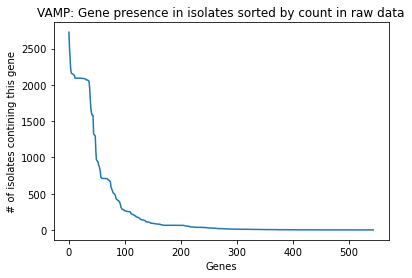

In [50]:
plt.plot(genotypic.describe().iloc[0].iloc[0:-1:2].sort_values(ascending=False).values)
plt.title('VAMP: Gene presence in isolates sorted by count in raw data')
plt.xlabel('Genes')
plt.ylabel('# of isolates contining this gene')

Text(0, 0.5, '# of isolates with this number of genes')

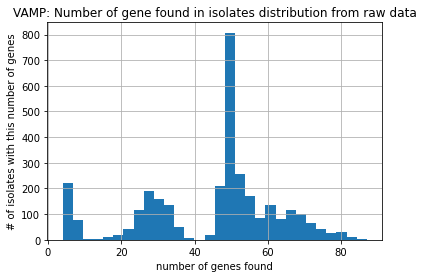

In [51]:
genotypic.set_index('run_id').count(axis=1).apply(lambda x: x/2).hist(bins=30)
plt.title('VAMP: Number of gene found in isolates distribution from raw data')
plt.xlabel('number of genes found')
plt.ylabel('# of isolates with this number of genes')

In [52]:
list(genotypic.describe().iloc[0].iloc[0:-1:2].sort_values(ascending=False).reset_index()['col_name'].apply(lambda x: x[:-8]).values)

['Bifidobacterium_adolescentis_rpoB_conferring_resistance_to_rifampicin',
 'acrB',
 'acrD',
 'ugd',
 'Nocardia_rifampin_resistant_beta-subunit_of_RNA_polymerase_(rpoB2)',
 'rosB',
 'msbA',
 'eptA',
 'macB',
 'CRP',
 'Klebsiella_pneumoniae_KpnF',
 'mdtG',
 'mdtC',
 'baeS',
 'baeR',
 'tolC',
 'mdtH',
 'Klebsiella_pneumoniae_OmpK37',
 'rosA',
 'mdtB',
 'Klebsiella_pneumoniae_KpnE',
 'marA',
 'Escherichia_coli_mdfA',
 'mdtK',
 'mdtA',
 'bacA',
 'Escherichia_coli_ampH',
 'H-NS',
 'cpxA',
 'yojI',
 'emrR',
 'acrE',
 'pmrF',
 'arnA',
 'sdiA',
 'acrF',
 'kdpE',
 'mdtM',
 'ramA',
 'emrB',
 'acrS',
 'Escherichia_coli_ampC1_beta-lactamase',
 'emrA',
 'Escherichia_coli_acrA',
 'golS',
 'mdsB',
 'mdsA',
 'mdsC',
 'mexK',
 'adeB',
 'APH(6)-Id',
 "AAC(6')-Ib7",
 "APH(3'')-Ib",
 'sul1',
 "AAC(6')-Iy",
 'adeJ',
 'sul2',
 'tet(A)',
 "ANT(3'')-IIa",
 'adeF',
 'abeM',
 'adeL',
 'adeN',
 'Acinetobacter_baumannii_AmvA',
 'adeH',
 'adeI',
 'adeG',
 'adeK',
 'abeS',
 'adeA',
 'adeR',
 'adeS',
 'aadA27',
 'Kle

In [53]:
len(list(genotypic.describe().iloc[0].iloc[0:-1:2].sort_values(ascending=False).reset_index()['col_name'].apply(lambda x: x[:-8]).values))

544

### Phen

In [54]:
AST_dir = "../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data"

In [55]:
phenotypic = pd.DataFrame({})
error_id = []
for sam_dir in os.listdir(AST_dir):
    sam_labels = get_isolate_labels(AST_dir+'/'+sam_dir, file_format='VAMP')
    if type(sam_labels) is not str:
        phenotypic = pd.concat([phenotypic, sam_labels], axis=0)
    else:
        print(sam_dir)
        error_id += [sam_dir]
# phenotypic = phenotypic.set_index('biosample_id')

SAMN08045836: not excepted measure values
SAMN08045835: not excepted measure values
SAMN07450858: not excepted measure values
SAMN07450857: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07450854.csv: problem loading file
None
SAMN07450854.csv
SAMN07450853: not excepted measure values
SAMN07450852: not excepted measure values
SAMN07450850: not excepted measure values
SAMN07450848: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07450847.csv: problem loading file
None
SAMN07450847.csv
SAMN07450845: not excepted measure values
SAMN07450844: not excepted measure values
SAMN07410719: not excepted measure values
SAMN07410718: not excepted measure values
SAMN07410716: not excepted measure values
SAMN07410714: not excepted measure values
SAMN07410713: not excepted measure values
SAMN07410712: not excepted measure values
SAMN07410711: not excepted

In [56]:
print('Vamp: ')
print('\tPhen: ')
print('\t\tOut of {} folders, only {} where valid'.format(len(os.listdir(AST_dir)), len(phenotypic)))
print('\t\tThis are the problematic IDs: {}'.format(error_id))

Vamp: 
	Phen: 
		Out of 3376 folders, only 3095 where valid
		This are the problematic IDs: ['SAMN07450854.csv', 'SAMN07450847.csv', 'SAMN07332520.csv', 'SAMN07332512.csv', 'SAMN07332509.csv', 'SAMN07325901.csv', 'SAMN07291545.csv', 'SAMN07291537.csv', 'SAMN07291533.csv', 'SAMN07291499.csv', 'SAMN07291497.csv', 'SAMN06754732.csv', 'SAMN06546420.csv', 'SAMN06015668.csv', 'SAMN06015658.csv', 'SAMN06007776.csv', 'SAMN05898666.csv', 'SAMN05898654.csv', 'SAMN05898639.csv', 'SAMN05898638.csv', 'SAMN05898606.csv', 'SAMN05898597.csv', 'SAMN05898595.csv', 'SAMN05898593.csv', 'SAMN05898590.csv', 'SAMN05898571.csv', 'SAMN05898564.csv', 'SAMN05898558.csv', 'SAMN05898556.csv', 'SAMN05806166.csv', 'SAMN05806165.csv', 'SAMN05774082.csv', 'SAMN05510457.csv', 'SAMN05463124.csv', 'SAMN05374483.csv', 'SAMN05202019.csv', 'SAMN05201998.csv', 'SAMN05201959.csv', 'SAMN05201949.csv', 'SAMN05201935.csv', 'SAMN05201925.csv', 'SAMN05201922.csv', 'SAMN05201912.csv', 'SAMN05201868.csv', 'SAMN05201865.csv', 'SAMN05

In [57]:
pd.DataFrame({"file_name": error_id}).to_csv('../resources/reports/vamp_missing_phen_file_biosample_id.txt')

In [58]:
[x[:-4] for x in error_id]

['SAMN07450854',
 'SAMN07450847',
 'SAMN07332520',
 'SAMN07332512',
 'SAMN07332509',
 'SAMN07325901',
 'SAMN07291545',
 'SAMN07291537',
 'SAMN07291533',
 'SAMN07291499',
 'SAMN07291497',
 'SAMN06754732',
 'SAMN06546420',
 'SAMN06015668',
 'SAMN06015658',
 'SAMN06007776',
 'SAMN05898666',
 'SAMN05898654',
 'SAMN05898639',
 'SAMN05898638',
 'SAMN05898606',
 'SAMN05898597',
 'SAMN05898595',
 'SAMN05898593',
 'SAMN05898590',
 'SAMN05898571',
 'SAMN05898564',
 'SAMN05898558',
 'SAMN05898556',
 'SAMN05806166',
 'SAMN05806165',
 'SAMN05774082',
 'SAMN05510457',
 'SAMN05463124',
 'SAMN05374483',
 'SAMN05202019',
 'SAMN05201998',
 'SAMN05201959',
 'SAMN05201949',
 'SAMN05201935',
 'SAMN05201925',
 'SAMN05201922',
 'SAMN05201912',
 'SAMN05201868',
 'SAMN05201865',
 'SAMN05201860',
 'SAMN05201856',
 'SAMN05201816',
 'SAMN05201781',
 'SAMN05201770',
 'SAMN05201767',
 'SAMN05201766',
 'SAMN05201748',
 'SAMN05201747',
 'SAMN05201719',
 'SAMN05201710',
 'SAMN05201682',
 'SAMN05201676',
 'SAMN05201657

In [59]:
phenotypic.describe().iloc[0].sort_values(ascending=False).index.values

array(['trimethoprim-sulfamethoxazole', 'ciprofloxacin', 'tetracycline',
       'gentamicin', 'ceftriaxone', 'ampicillin', 'cefoxitin',
       'amoxicillin-clavulanic acid', 'levofloxacin', 'chloramphenicol',
       'amikacin', 'ceftazidime', 'tobramycin', 'nalidixic acid',
       'ceftiofur', 'sulfisoxazole', 'streptomycin', 'azithromycin',
       'meropenem', 'cefotaxime', 'imipenem', 'aztreonam', 'cefazolin',
       'kanamycin', 'ampicillin-sulbactam', 'cefepime',
       'piperacillin-tazobactam', 'nitrofurantoin', 'tigecycline',
       'ertapenem', 'doripenem', 'colistin', 'polymyxin b',
       'erythromycin', 'penicillin', 'clindamycin',
       'cefotaxime-clavulanic acid', 'ceftazidime-clavulanic acid',
       'rifampin', 'linezolid', 'vancomycin', 'cefuroxime', 'synercid',
       'amoxicillin', 'minocycline', 'cefotetan', 'moxifloxacin',
       'doxycycline', 'ticarcillin-clavulanic acid',
       'ceftazidime-avibactam', 'cephalothin', 'daptomycin', 'oxacillin',
       'mupiroci

In [60]:
len(phenotypic.describe().iloc[0].sort_values(ascending=False).index.values)

61

Text(0, 0.5, '# of isolates having ASR measurement of this antibiotic')

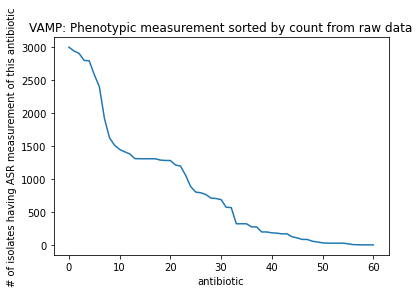

In [61]:
plt.plot(phenotypic.describe().iloc[0].sort_values(ascending=False).values)
plt.title('VAMP: Phenotypic measurement sorted by count from raw data')
plt.xlabel('antibiotic')
plt.ylabel('# of isolates having ASR measurement of this antibiotic')

In [62]:
for anti in phenotypic.columns:
    print(phenotypic[anti].astype('str').value_counts())

nan                       2330
>= 9.0                     621
<= 4.0                      69
= 8.0                       28
= 7.0                       15
= 6.0                       14
= 5.0                        9
>= 3.0                       5
> 6.0                        1
>= -3.0588936890535687       1
<= -3.0588936890535687       1
>= 8.321928094887362         1
Name: nitrofurantoin, dtype: int64
nan       2303
> 7.0      337
<= 2.0     101
>= 7.0      84
> 6.0       65
= 3.0       63
= 6.0       53
= 5.0       24
= 4.0       20
= 7.0       16
< 2.0       15
< 3.0        7
<= 4.0       5
>= 4.0       1
= 2.0        1
Name: piperacillin-tazobactam, dtype: int64
nan                     1647
<= 3.0                   271
> 5.0                    261
<= 1.0                   163
= 5.0                    106
> 6.0                     83
= 4.0                     76
< 0.0                     75
<= 4.0                    73
= 2.0                     64
= 3.0                     61
< 1.0

In [155]:
run2biosam_path = '../resources/28.12.21//VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_SAM_and_SRR_list.csv'

In [64]:
filter_list = '../resources/28.12.21//VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_filtered_SRR_list.20211228.xlsx'

In [157]:
import pandas as pd
run2biosam = pd.read_csv(run2biosam_path)

In [66]:
run2biosam.columns

Index(['SRR_ID', 'BioSample_ID'], dtype='object')

In [67]:
for col in run2biosam.columns:
    print(col + ' uniques is: ', len(np.unique(run2biosam[col].values)))

SRR_ID uniques is:  3596
BioSample_ID uniques is:  3313


In [68]:
run2biosam.columns = ['run_id', 'biosample_id']
run2biosam.describe()

run_id  biosample_id
count        3596          3596
unique       3596          3313
top     DRR065657  SAMN02356609
freq            1             8

In [69]:
filtered_data_vam = pd.read_excel(filter_list)
filtered_data_vam.columns = ['species_fam', 'run_id']
filtered_data_vam.describe()

species_fam      run_id
count         3031        3031
unique           8        3031
top      senterica  SRR2911724
freq          1325           1

In [70]:
filtered_data_vam = filtered_data_vam.merge(right=run2biosam, how='inner', on='run_id')
filtered_data_vam.describe()

species_fam      run_id  biosample_id
count         3031        3031          3031
unique           8        3031          2903
top      senterica  SRR2911724  SAMN04014992
freq          1325           1             4

In [71]:
filtered_data_vam = filtered_data_vam.merge(right=phenotypic, how='inner', on='biosample_id')
filtered_data_vam.describe()

species_fam      run_id  biosample_id nitrofurantoin  \
count         2769        2769          2769            693   
unique           8        2769          2655              9   
top      senterica  SRR2911724  SAMN04014993         >= 9.0   
freq          1221           1             4            587   

       piperacillin-tazobactam amikacin cefazolin cefepime cefoxitin  \
count                      554     1193      1054      576      2196   
unique                      13       21        12       16        16   
top                      > 7.0   <= 3.0    >= 6.0    > 5.0     = 1.0   
freq                       308      261       668      270       624   

       ceftazidime  ... ceftiofur cefotetan         piperacillin cephalothin  \
count         1169  ...      1257       103                    5          38   
unique          21  ...         7         5                    1           6   
top          > 4.0  ...     = 0.0    >= 6.0  = 2.584962500721156      <= 0.0   
freq           334  ...       680        97                    5          14   

           sulfamethoxazole ticarcillin-clavulanic acid            sulbactam  \
count                     4                          21                    1   
unique                    2                           3                    1   
top     = 2.584962500721156                       > 7.0  = 2.584962500721156   
freq                      2                          19                    1   

                  cefalexin synercid            amoxicillin  
count                     1      149                    149  
unique                    1        2                      9  
top     = 2.584962500721156   <= 0.0  <= -5.058893689053569  
freq                      1      148                    109  

[4 rows x 64 columns]

In [72]:
filtered_data_vam = filtered_data_vam.merge(right=genotypic, how='inner', on='run_id')
filtered_data_vam['DB'] = 'VAMP'
filtered_data_vam

species_fam      run_id  biosample_id nitrofurantoin  \
0     abaumannii  SRR2911724  SAMN04229826         >= 9.0   
1     abaumannii  SRR2911725  SAMN04229822         >= 9.0   
2     abaumannii  SRR2911726  SAMN04229823         >= 9.0   
3     abaumannii  SRR2911739  SAMN04229824         >= 9.0   
4     abaumannii  SRR2911742  SAMN04229825         >= 9.0   
...          ...         ...           ...            ...   
2764   senterica  SRR3665314  SAMN02699277            NaN   
2765   senterica  SRR3665316  SAMN02699278            NaN   
2766   senterica  SRR3665317  SAMN05201749            NaN   
2767   senterica  SRR3665318  SAMN05201750            NaN   
2768   senterica  SRR3665319  SAMN05201751            NaN   

     piperacillin-tazobactam amikacin cefazolin cefepime cefoxitin  \
0                        NaN   <= 4.0    >= 6.0      NaN    >= 6.0   
1                        NaN      NaN    >= 6.0      NaN       NaN   
2                        NaN    > 5.0    >= 6.0      NaN       NaN   
3                        NaN   <= 4.0    >= 6.0      NaN       NaN   
4                        NaN   <= 4.0    >= 6.0      NaN       NaN   
...                      ...      ...       ...      ...       ...   
2764                     NaN      NaN       NaN      NaN     = 1.0   
2765                     NaN      NaN       NaN      NaN     = 1.0   
2766                     NaN      NaN       NaN      NaN     = 5.0   
2767                     NaN      NaN       NaN      NaN     = 1.0   
2768                     NaN      NaN       NaN      NaN     = 1.0   

     ceftazidime  ... dfrA21->seq_cov CTX-M-65->seq_id CTX-M-65->seq_cov  \
0         >= 6.0  ...             NaN              NaN               NaN   
1            NaN  ...             NaN              NaN               NaN   
2          = 3.0  ...             NaN              NaN               NaN   
3          > 4.0  ...             NaN              NaN               NaN   
4          > 4.0  ...             NaN              NaN               NaN   
...          ...  ...             ...              ...               ...   
2764         NaN  ...             NaN              NaN               NaN   
2765         NaN  ...             NaN              NaN               NaN   
2766         NaN  ...             NaN              NaN               NaN   
2767         NaN  ...             NaN              NaN               NaN   
2768         NaN  ...             NaN              NaN               NaN   

     QnrS2->seq_id QnrS2->seq_cov CMY-111->seq_id CMY-111->seq_cov  \
0              NaN            NaN             NaN              NaN   
1              NaN            NaN             NaN              NaN   
2              NaN            NaN             NaN              NaN   
3              NaN            NaN             NaN              NaN   
4              NaN            NaN             NaN              NaN   
...            ...            ...             ...              ...   
2764           NaN            NaN             NaN              NaN   
2765           NaN            NaN             NaN              NaN   
2766           NaN            NaN             NaN              NaN   
2767           NaN            NaN             NaN              NaN   
2768           NaN            NaN             NaN              NaN   

     mefE->seq_id mefE->seq_cov    DB  
0             NaN           NaN  VAMP  
1             NaN           NaN  VAMP  
2             NaN           NaN  VAMP  
3             NaN           NaN  VAMP  
4             NaN           NaN  VAMP  
...           ...           ...   ...  
2764          NaN           NaN  VAMP  
2765          NaN           NaN  VAMP  
2766          NaN           NaN  VAMP  
2767          NaN           NaN  VAMP  
2768          NaN           NaN  VAMP  

[2769 rows x 1153 columns]

In [73]:
filtered_data_vam[['run_id','biosample_id']].describe()

run_id  biosample_id
count         2769          2769
unique        2769          2655
top     SRR2911724  SAMN04014993
freq             1             4

In [74]:
dup_bio = filtered_data_vam.groupby(by='biosample_id')['run_id'].count() > 1
dup_bio = dup_bio[dup_bio == True].index.values

In [75]:
filtered_data_vam[filtered_data_vam['biosample_id'].isin(dup_bio)][['run_id', 'biosample_id']].describe()

run_id  biosample_id
count          178           178
unique         178            64
top     SRR3242007  SAMN04014991
freq             1             4

In [76]:
dup_df = filtered_data_vam[filtered_data_vam['biosample_id'].isin(dup_bio)][['run_id', 'biosample_id']]

In [77]:
dup_df.to_csv('../resources/reports/vamp_dup_run_id_with_biosample_id.txt')

In [78]:
filtered_data_vam = filtered_data_vam.drop_duplicates(subset='biosample_id', keep='first')

In [79]:
filtered_data_vam[['run_id','biosample_id']].describe()

run_id  biosample_id
count         2655          2655
unique        2655          2655
top     SRR2911724  SAMN04229826
freq             1             1

<AxesSubplot:title={'center':'VAMP: Species distribution final data'}>

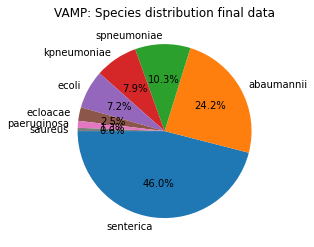

In [80]:
a = filtered_data_vam['species_fam'].value_counts()
a.name=''
a.plot.pie(title='VAMP: Species distribution final data', startangle=180, autopct='%1.1f%%')

In [81]:
vamp_labels = list(set(phenotypic.columns)-set(['biosample_id']))
vamp_features = list(set(genotypic.columns)-set(['run_id']))

In [65]:
ds_name = 'PATAKI+VAMP+PATRIC'


filtered_data_list, labels_list, features_list = [], [], []
for db_name, resource in resources.items():
    db_data, db_labels, db_features = p_utils.merge_gen2phen(
        geno = p_utils.get_genotype_per_db(resource['geno']), 
        pheno = p_utils.get_phenotype_per_db(resource['pheno'], db_name=db_name), 
        run2bio_match_path = resource['run2bio'], 
        filter_list_path = resource['filter_list'], 
        db_name = db_name,
    )
    filtered_data_list.append(db_data)
    labels_list.append(db_labels)
    features_list.append(db_features)
tot_data, labels, features = p_utils.merging_dbs(filtered_data_list, labels_list, features_list)


  9%|▉         | 302/3202 [00:15<02:48, 17.16it/s]

SRR5168376: is missing csv file


  0%|          | 13/3376 [00:00<00:26, 127.90it/s]

SAMN08045836: not excepted measure values
SAMN08045835: not excepted measure values
SAMN07450858: not excepted measure values
SAMN07450857: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07450854.csv: problem loading file
SAMN07450854.csv
SAMN07450853: not excepted measure values
SAMN07450852: not excepted measure values
SAMN07450850: not excepted measure values
SAMN07450848: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07450847.csv: problem loading file
SAMN07450847.csv
SAMN07450845: not excepted measure values
SAMN07450844: not excepted measure values
SAMN07410719: not excepted measure values
SAMN07410718: not excepted measure values
SAMN07410716: not excepted measure values
SAMN07410714: not excepted measure values
SAMN07410713: not excepted measure values
SAMN07410712: not excepted measure values
SAMN07410711: not excepted measure v

  1%|          | 38/3376 [00:00<00:28, 115.84it/s]

SAMN07332518: not excepted measure values
SAMN07332517: not excepted measure values
SAMN07332516: not excepted measure values
SAMN07332515: not excepted measure values
SAMN07332514: not excepted measure values
SAMN07332513: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07332512.csv: problem loading file
SAMN07332512.csv
SAMN07332511: not excepted measure values
SAMN07332510: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07332509.csv: problem loading file
SAMN07332509.csv
SAMN07332508: not excepted measure values
SAMN07332507: not excepted measure values
SAMN07325908: not excepted measure values
SAMN07325907: not excepted measure values
SAMN07325906: not excepted measure values
SAMN07325905: not excepted measure values
SAMN07325904: not excepted measure values
SAMN07325903: not excepted measure values
SAMN07325902: not excepted measure v

  2%|▏         | 61/3376 [00:00<00:32, 102.76it/s]

SAMN07325896: not excepted measure values
SAMN07325895: not excepted measure values
SAMN07325894: not excepted measure values
SAMN07325893: not excepted measure values
SAMN07291569: not excepted measure values
SAMN07291568: not excepted measure values
SAMN07291567: not excepted measure values
SAMN07291566: not excepted measure values
SAMN07291565: not excepted measure values
SAMN07291564: not excepted measure values
SAMN07291563: not excepted measure values
SAMN07291562: not excepted measure values
SAMN07291561: not excepted measure values
SAMN07291560: not excepted measure values
SAMN07291559: not excepted measure values
SAMN07291558: not excepted measure values
SAMN07291557: not excepted measure values
SAMN07291555: not excepted measure values
SAMN07291554: not excepted measure values
SAMN07291553: not excepted measure values


  2%|▏         | 83/3376 [00:00<00:33, 99.76it/s] 

SAMN07291552: not excepted measure values
SAMN07291551: not excepted measure values
SAMN07291550: not excepted measure values
SAMN07291549: not excepted measure values
SAMN07291548: not excepted measure values
SAMN07291547: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07291545.csv: problem loading file
SAMN07291545.csv
SAMN07291544: not excepted measure values
SAMN07291543: not excepted measure values
SAMN07291542: not excepted measure values
SAMN07291541: not excepted measure values
SAMN07291540: not excepted measure values
SAMN07291539: not excepted measure values
SAMN07291538: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07291537.csv: problem loading file
SAMN07291537.csv
SAMN07291536: not excepted measure values
SAMN07291535: not excepted measure values
SAMN07291534: not excepted measure values
../resources/28.12.21/VAMPr_3400samp

  3%|▎         | 104/3376 [00:01<00:35, 91.82it/s]

SAMN07291530: not excepted measure values
SAMN07291529: not excepted measure values
SAMN07291528: not excepted measure values
SAMN07291527: not excepted measure values
SAMN07291526: not excepted measure values
SAMN07291524: not excepted measure values
SAMN07291521: not excepted measure values
SAMN07291519: not excepted measure values
SAMN07291517: not excepted measure values
SAMN07291515: not excepted measure values
SAMN07291514: not excepted measure values
SAMN07291513: not excepted measure values
SAMN07291512: not excepted measure values
SAMN07291511: not excepted measure values
SAMN07291506: not excepted measure values
SAMN07291505: not excepted measure values
SAMN07291504: not excepted measure values


  3%|▎         | 115/3376 [00:01<00:34, 93.67it/s]

SAMN07291503: not excepted measure values
SAMN07291502: not excepted measure values
SAMN07291501: not excepted measure values
SAMN07291500: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07291499.csv: problem loading file
SAMN07291499.csv
SAMN07291498: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN07291497.csv: problem loading file
SAMN07291497.csv
SAMN07291496: not excepted measure values
SAMN07291495: not excepted measure values
SAMN07291494: not excepted measure values
SAMN07265011: not excepted measure values
SAMN06754743: not excepted measure values
SAMN06754743(1): not excepted measure values
SAMN06754742: not excepted measure values
SAMN06754741: not excepted measure values
SAMN06754739: not excepted measure values
SAMN06754738: not excepted measure values
SAMN06754737: not excepted measure values
SAMN06754736: not excepted measur

  4%|▍         | 134/3376 [00:01<00:36, 88.28it/s]

SAMN06754735: not excepted measure values
SAMN06754734: not excepted measure values
SAMN06754733: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN06754732.csv: problem loading file
SAMN06754732.csv
SAMN06754731: not excepted measure values
SAMN06754730: not excepted measure values
SAMN06754729: not excepted measure values
SAMN06680411: not excepted measure values
SAMN06680409: not excepted measure values
SAMN06680408: not excepted measure values
SAMN06680406: not excepted measure values
SAMN06680405: not excepted measure values
SAMN06680404: not excepted measure values
SAMN06680403: not excepted measure values
SAMN06680401: not excepted measure values
SAMN06680400: not excepted measure values
SAMN06680399: not excepted measure values


  5%|▍         | 153/3376 [00:01<00:37, 86.69it/s]

SAMN06680398: not excepted measure values
SAMN06672151: not excepted measure values
SAMN06672150: not excepted measure values
SAMN06672149: not excepted measure values
SAMN06546425: not excepted measure values
SAMN06546424: not excepted measure values
SAMN06546423: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN06546420.csv: problem loading file
SAMN06546420.csv
SAMN06546419: not excepted measure values
SAMN06311521: not excepted measure values
SAMN06311519: not excepted measure values
SAMN06311518: not excepted measure values
SAMN06311517: not excepted measure values
SAMN06311516: not excepted measure values
SAMN06311515: not excepted measure values
SAMN06129827: not excepted measure values
SAMN06129826: not excepted measure values


  5%|▌         | 173/3376 [00:01<00:35, 90.51it/s]

SAMN06129824: not excepted measure values
SAMN06124915: not excepted measure values
SAMN06015669: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN06015668.csv: problem loading file
SAMN06015668.csv
SAMN06015667: not excepted measure values
SAMN06015666: not excepted measure values
SAMN06015665: not excepted measure values
SAMN06015664: not excepted measure values
SAMN06015663: not excepted measure values
SAMN06015662: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN06015658.csv: problem loading file
SAMN06015658.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN06007776.csv: problem loading file
SAMN06007776.csv
SAMN06007775: not excepted measure values
SAMN06007774: not excepted measure values
SAMN06007773: not excepted measure values
SAMN06007771: not excepted measure values
SAMN06007770: no

  6%|▌         | 192/3376 [00:02<00:37, 84.98it/s]

SAMN06007767: not excepted measure values
SAMN05898669: not excepted measure values
SAMN05898668: not excepted measure values
SAMN05898667: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898666.csv: problem loading file
SAMN05898666.csv
SAMN05898665: not excepted measure values
SAMN05898664: not excepted measure values
SAMN05898663: not excepted measure values
SAMN05898662: not excepted measure values
SAMN05898661: not excepted measure values
SAMN05898660: not excepted measure values
SAMN05898659: not excepted measure values
SAMN05898658: not excepted measure values
SAMN05898657: not excepted measure values
SAMN05898656: not excepted measure values
SAMN05898655: not excepted measure values


  6%|▌         | 201/3376 [00:02<00:41, 76.15it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898654.csv: problem loading file
SAMN05898654.csv
SAMN05898653: not excepted measure values
SAMN05898652: not excepted measure values
SAMN05898651: not excepted measure values
SAMN05898650: not excepted measure values
SAMN05898649: not excepted measure values
SAMN05898648: not excepted measure values
SAMN05898647: not excepted measure values
SAMN05898646: not excepted measure values
SAMN05898645: not excepted measure values
SAMN05898644: not excepted measure values
SAMN05898643: not excepted measure values
SAMN05898642: not excepted measure values
SAMN05898641: not excepted measure values
SAMN05898640: not excepted measure values


  6%|▋         | 219/3376 [00:02<00:38, 82.21it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898639.csv: problem loading file
SAMN05898639.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898638.csv: problem loading file
SAMN05898638.csv
SAMN05898637: not excepted measure values
SAMN05898636: not excepted measure values
SAMN05898635: not excepted measure values
SAMN05898634: not excepted measure values
SAMN05898633: not excepted measure values
SAMN05898632: not excepted measure values
SAMN05898631: not excepted measure values
SAMN05898630: not excepted measure values
SAMN05898629: not excepted measure values
SAMN05898628: not excepted measure values
SAMN05898627: not excepted measure values
SAMN05898626: not excepted measure values
SAMN05898625: not excepted measure values
SAMN05898624: not excepted measure values
SAMN05898623: not excepted measure values
SAMN05898622: not excepted measure values


  7%|▋         | 237/3376 [00:02<00:41, 74.86it/s]

SAMN05898621: not excepted measure values
SAMN05898620: not excepted measure values
SAMN05898619: not excepted measure values
SAMN05898618: not excepted measure values
SAMN05898617: not excepted measure values
SAMN05898616: not excepted measure values
SAMN05898615: not excepted measure values
SAMN05898614: not excepted measure values
SAMN05898613: not excepted measure values
SAMN05898612: not excepted measure values
SAMN05898611: not excepted measure values
SAMN05898610: not excepted measure values
SAMN05898609: not excepted measure values
SAMN05898608: not excepted measure values
SAMN05898607: not excepted measure values


  8%|▊         | 257/3376 [00:02<00:37, 83.56it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898606.csv: problem loading file
SAMN05898606.csv
SAMN05898605: not excepted measure values
SAMN05898604: not excepted measure values
SAMN05898603: not excepted measure values
SAMN05898602: not excepted measure values
SAMN05898601: not excepted measure values
SAMN05898600: not excepted measure values
SAMN05898599: not excepted measure values
SAMN05898598: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898597.csv: problem loading file
SAMN05898597.csv
SAMN05898596: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898595.csv: problem loading file
SAMN05898595.csv
SAMN05898594: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898593.csv: problem loading file
SAMN05898593.

  8%|▊         | 275/3376 [00:03<00:40, 77.47it/s]

SAMN05898586: not excepted measure values
SAMN05898585: not excepted measure values
SAMN05898584: not excepted measure values
SAMN05898583: not excepted measure values
SAMN05898582: not excepted measure values
SAMN05898581: not excepted measure values
SAMN05898580: not excepted measure values
SAMN05898579: not excepted measure values
SAMN05898578: not excepted measure values
SAMN05898577: not excepted measure values
SAMN05898576: not excepted measure values
SAMN05898575: not excepted measure values
SAMN05898574: not excepted measure values
SAMN05898573: not excepted measure values


  9%|▊         | 295/3376 [00:03<00:35, 86.80it/s]

SAMN05898572: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898571.csv: problem loading file
SAMN05898571.csv
SAMN05898570: not excepted measure values
SAMN05898569: not excepted measure values
SAMN05898568: not excepted measure values
SAMN05898567: not excepted measure values
SAMN05898566: not excepted measure values
SAMN05898565: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898564.csv: problem loading file
SAMN05898564.csv
SAMN05898563: not excepted measure values
SAMN05898562: not excepted measure values
SAMN05898561: not excepted measure values
SAMN05898560: not excepted measure values
SAMN05898559: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05898558.csv: problem loading file
SAMN05898558.csv
SAMN05898557: not excepted measure values
../resources/28.

  9%|▉         | 304/3376 [00:03<00:36, 83.25it/s]

SAMN05898551: not excepted measure values
SAMN05898550: not excepted measure values
SAMN05898549: not excepted measure values
SAMN05898548: not excepted measure values
SAMN05898547: not excepted measure values
SAMN05898546: not excepted measure values
SAMN05898545: not excepted measure values
SAMN05898544: not excepted measure values
SAMN05898543: not excepted measure values
SAMN05898542: not excepted measure values
SAMN05898541: not excepted measure values
SAMN05898540: not excepted measure values
SAMN05898539: not excepted measure values
SAMN05898538: not excepted measure values
SAMN05898537: not excepted measure values


 10%|▉         | 322/3376 [00:03<00:39, 77.51it/s]

SAMN05898536: not excepted measure values
SAMN05898535: not excepted measure values
SAMN05898534: not excepted measure values
SAMN05898533: not excepted measure values
SAMN05806176: not excepted measure values
SAMN05806175: not excepted measure values
SAMN05806174: not excepted measure values
SAMN05806169: not excepted measure values
SAMN05806168: not excepted measure values
SAMN05806167: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05806166.csv: problem loading file
SAMN05806166.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05806165.csv: problem loading file
SAMN05806165.csv
SAMN05806164: not excepted measure values
SAMN05806164(1): not excepted measure values
SAMN05806162: not excepted measure values


 10%|█         | 339/3376 [00:03<00:40, 75.63it/s]

SAMN05806161: not excepted measure values
SAMN05774085: not excepted measure values
SAMN05774084: not excepted measure values
SAMN05774083: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05774082.csv: problem loading file
SAMN05774082.csv
SAMN05774081: not excepted measure values
SAMN05774080: not excepted measure values
SAMN05774079: not excepted measure values
SAMN05774078: not excepted measure values
SAMN05774077: not excepted measure values
SAMN05774076: not excepted measure values
SAMN05774075: not excepted measure values
SAMN05774073: not excepted measure values
SAMN05510459: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05510457.csv: problem loading file
SAMN05510457.csv
SAMN05510456: not excepted measure values
SAMN05510455: not excepted measure values


 11%|█         | 358/3376 [00:04<00:37, 79.47it/s]

SAMN05510454: not excepted measure values
SAMN05510453: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05463124.csv: problem loading file
SAMN05463124.csv
SAMN05463123: not excepted measure values
SAMN05374486: not excepted measure values
SAMN05374484: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05374483.csv: problem loading file
SAMN05374483.csv
SAMN05374482: not excepted measure values
SAMN05374481: not excepted measure values
SAMN05374480: not excepted measure values
SAMN05374479: not excepted measure values
SAMN05374478: not excepted measure values
SAMN05210256: not excepted measure values
SAMN05210136: not excepted measure values
SAMN05202020: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05202019.csv: problem loading file
SAMN05202019.csv
SAMN05202018: no

 11%|█         | 374/3376 [00:04<00:39, 75.47it/s]

SAMN05202016: not excepted measure values
SAMN05202015: not excepted measure values
SAMN05202014: not excepted measure values
SAMN05202013: not excepted measure values
SAMN05202012: not excepted measure values
SAMN05202011: not excepted measure values
SAMN05202010: not excepted measure values
SAMN05202009: not excepted measure values
SAMN05202008: not excepted measure values
SAMN05202007: not excepted measure values
SAMN05202006: not excepted measure values
SAMN05202005: not excepted measure values
SAMN05202004: not excepted measure values
SAMN05202003: not excepted measure values
SAMN05202002: not excepted measure values


 12%|█▏        | 391/3376 [00:04<00:39, 76.42it/s]

SAMN05202001: not excepted measure values
SAMN05202000: not excepted measure values
SAMN05201999: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201998.csv: problem loading file
SAMN05201998.csv
SAMN05201997: not excepted measure values
SAMN05201996: not excepted measure values
SAMN05201995: not excepted measure values
SAMN05201994: not excepted measure values
SAMN05201993: not excepted measure values
SAMN05201992: not excepted measure values
SAMN05201991: not excepted measure values
SAMN05201990: not excepted measure values
SAMN05201989: not excepted measure values
SAMN05201988: not excepted measure values
SAMN05201987: not excepted measure values
SAMN05201986: not excepted measure values


 12%|█▏        | 407/3376 [00:04<00:39, 74.62it/s]

SAMN05201985: not excepted measure values
SAMN05201984: not excepted measure values
SAMN05201983: not excepted measure values
SAMN05201982: not excepted measure values
SAMN05201981: not excepted measure values
SAMN05201980: not excepted measure values
SAMN05201979: not excepted measure values
SAMN05201978: not excepted measure values
SAMN05201977: not excepted measure values
SAMN05201976: not excepted measure values
SAMN05201975: not excepted measure values
SAMN05201974: not excepted measure values
SAMN05201973: not excepted measure values
SAMN05201973(1): not excepted measure values
SAMN05201972: not excepted measure values
SAMN05201971: not excepted measure values


 13%|█▎        | 424/3376 [00:05<00:39, 75.61it/s]

SAMN05201970: not excepted measure values
SAMN05201969: not excepted measure values
SAMN05201968: not excepted measure values
SAMN05201967: not excepted measure values
SAMN05201967(1): not excepted measure values
SAMN05201966: not excepted measure values
SAMN05201965: not excepted measure values
SAMN05201964: not excepted measure values
SAMN05201963: not excepted measure values
SAMN05201962: not excepted measure values
SAMN05201961: not excepted measure values
SAMN05201960: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201959.csv: problem loading file
SAMN05201959.csv
SAMN05201958: not excepted measure values
SAMN05201957: not excepted measure values
SAMN05201956: not excepted measure values
SAMN05201955: not excepted measure values


 13%|█▎        | 440/3376 [00:05<00:40, 73.08it/s]

SAMN05201954: not excepted measure values
SAMN05201953: not excepted measure values
SAMN05201952: not excepted measure values
SAMN05201951: not excepted measure values
SAMN05201950: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201949.csv: problem loading file
SAMN05201949.csv
SAMN05201948: not excepted measure values
SAMN05201947: not excepted measure values
SAMN05201946: not excepted measure values
SAMN05201945: not excepted measure values
SAMN05201944: not excepted measure values
SAMN05201943: not excepted measure values
SAMN05201942: not excepted measure values
SAMN05201941: not excepted measure values
SAMN05201940: not excepted measure values
SAMN05201939: not excepted measure values


 14%|█▎        | 457/3376 [00:05<00:38, 76.59it/s]

SAMN05201938: not excepted measure values
SAMN05201937: not excepted measure values
SAMN05201936: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201935.csv: problem loading file
SAMN05201935.csv
SAMN05201934: not excepted measure values
SAMN05201933: not excepted measure values
SAMN05201932: not excepted measure values
SAMN05201931: not excepted measure values
SAMN05201930: not excepted measure values
SAMN05201929: not excepted measure values
SAMN05201928: not excepted measure values
SAMN05201927: not excepted measure values
SAMN05201926: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201925.csv: problem loading file
SAMN05201925.csv
SAMN05201924: not excepted measure values
SAMN05201923: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201922.csv: problem load

 14%|█▍        | 473/3376 [00:05<00:38, 75.53it/s]

SAMN05201920: not excepted measure values
SAMN05201919: not excepted measure values
SAMN05201918: not excepted measure values
SAMN05201917: not excepted measure values
SAMN05201916: not excepted measure values
SAMN05201915: not excepted measure values
SAMN05201914: not excepted measure values
SAMN05201913: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201912.csv: problem loading file
SAMN05201912.csv
SAMN05201911: not excepted measure values
SAMN05201910: not excepted measure values
SAMN05201909: not excepted measure values
SAMN05201908: not excepted measure values
SAMN05201907: not excepted measure values
SAMN05201906: not excepted measure values


 14%|█▍        | 481/3376 [00:05<00:40, 72.11it/s]

SAMN05201905: not excepted measure values
SAMN05201904: not excepted measure values
SAMN05201903: not excepted measure values
SAMN05201902: not excepted measure values
SAMN05201901: not excepted measure values
SAMN05201900: not excepted measure values
SAMN05201899: not excepted measure values
SAMN05201898: not excepted measure values
SAMN05201897: not excepted measure values
SAMN05201896: not excepted measure values
SAMN05201895: not excepted measure values
SAMN05201894: not excepted measure values
SAMN05201893: not excepted measure values
SAMN05201892: not excepted measure values


 15%|█▍        | 497/3376 [00:06<00:42, 68.20it/s]

SAMN05201891: not excepted measure values
SAMN05201890: not excepted measure values
SAMN05201889: not excepted measure values
SAMN05201888: not excepted measure values
SAMN05201887: not excepted measure values
SAMN05201886: not excepted measure values
SAMN05201885: not excepted measure values
SAMN05201884: not excepted measure values
SAMN05201883: not excepted measure values
SAMN05201882: not excepted measure values
SAMN05201881: not excepted measure values
SAMN05201880: not excepted measure values
SAMN05201879: not excepted measure values
SAMN05201878: not excepted measure values


 15%|█▌        | 511/3376 [00:06<00:42, 68.03it/s]

SAMN05201877: not excepted measure values
SAMN05201876: not excepted measure values
SAMN05201875: not excepted measure values
SAMN05201874: not excepted measure values
SAMN05201873: not excepted measure values
SAMN05201872: not excepted measure values
SAMN05201871: not excepted measure values
SAMN05201870: not excepted measure values
SAMN05201869: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201868.csv: problem loading file
SAMN05201868.csv
SAMN05201867: not excepted measure values
SAMN05201866: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201865.csv: problem loading file
SAMN05201865.csv
SAMN05201864: not excepted measure values
SAMN05201863: not excepted measure values
SAMN05201862: not excepted measure values


 16%|█▌        | 529/3376 [00:06<00:36, 77.76it/s]

SAMN05201861: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201860.csv: problem loading file
SAMN05201860.csv
SAMN05201859: not excepted measure values
SAMN05201858: not excepted measure values
SAMN05201857: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201856.csv: problem loading file
SAMN05201856.csv
SAMN05201855: not excepted measure values
SAMN05201854: not excepted measure values
SAMN05201853: not excepted measure values
SAMN05201852: not excepted measure values
SAMN05201851: not excepted measure values
SAMN05201850: not excepted measure values
SAMN05201849: not excepted measure values
SAMN05201848: not excepted measure values
SAMN05201847: not excepted measure values
SAMN05201846: not excepted measure values
SAMN05201845: not excepted measure values


 16%|█▌        | 545/3376 [00:06<00:37, 75.04it/s]

SAMN05201844: not excepted measure values
SAMN05201843: not excepted measure values
SAMN05201842: not excepted measure values
SAMN05201841: not excepted measure values
SAMN05201840: not excepted measure values
SAMN05201839: not excepted measure values
SAMN05201838: not excepted measure values
SAMN05201837: not excepted measure values
SAMN05201836: not excepted measure values
SAMN05201835: not excepted measure values
SAMN05201834: not excepted measure values
SAMN05201833: not excepted measure values
SAMN05201832: not excepted measure values
SAMN05201831: not excepted measure values
SAMN05201830: not excepted measure values


 17%|█▋        | 561/3376 [00:06<00:39, 70.99it/s]

SAMN05201829: not excepted measure values
SAMN05201828: not excepted measure values
SAMN05201827: not excepted measure values
SAMN05201826: not excepted measure values
SAMN05201825: not excepted measure values
SAMN05201824: not excepted measure values
SAMN05201823: not excepted measure values
SAMN05201822: not excepted measure values
SAMN05201821: not excepted measure values
SAMN05201820: not excepted measure values
SAMN05201819: not excepted measure values
SAMN05201818: not excepted measure values
SAMN05201817: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201816.csv: problem loading file
SAMN05201816.csv
SAMN05201815: not excepted measure values
SAMN05201814: not excepted measure values


 17%|█▋        | 577/3376 [00:07<00:39, 71.70it/s]

SAMN05201813: not excepted measure values
SAMN05201812: not excepted measure values
SAMN05201811: not excepted measure values
SAMN05201810: not excepted measure values
SAMN05201809: not excepted measure values
SAMN05201808: not excepted measure values
SAMN05201807: not excepted measure values
SAMN05201806: not excepted measure values
SAMN05201805: not excepted measure values
SAMN05201804: not excepted measure values
SAMN05201803: not excepted measure values
SAMN05201802: not excepted measure values
SAMN05201801: not excepted measure values
SAMN05201800: not excepted measure values
SAMN05201799: not excepted measure values


 18%|█▊        | 593/3376 [00:07<00:39, 71.30it/s]

SAMN05201798: not excepted measure values
SAMN05201797: not excepted measure values
SAMN05201796: not excepted measure values
SAMN05201795: not excepted measure values
SAMN05201794: not excepted measure values
SAMN05201793: not excepted measure values
SAMN05201792: not excepted measure values
SAMN05201791: not excepted measure values
SAMN05201790: not excepted measure values
SAMN05201789: not excepted measure values
SAMN05201788: not excepted measure values
SAMN05201787: not excepted measure values
SAMN05201786: not excepted measure values
SAMN05201785: not excepted measure values
SAMN05201784: not excepted measure values


 18%|█▊        | 610/3376 [00:07<00:38, 71.33it/s]

SAMN05201783: not excepted measure values
SAMN05201782: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201781.csv: problem loading file
SAMN05201781.csv
SAMN05201780: not excepted measure values
SAMN05201779: not excepted measure values
SAMN05201778: not excepted measure values
SAMN05201777: not excepted measure values
SAMN05201776: not excepted measure values
SAMN05201775: not excepted measure values
SAMN05201774: not excepted measure values
SAMN05201773: not excepted measure values
SAMN05201772: not excepted measure values
SAMN05201771: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201770.csv: problem loading file
SAMN05201770.csv
SAMN05201769: not excepted measure values
SAMN05201768: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201767.csv: problem load

 19%|█▊        | 629/3376 [00:07<00:35, 76.70it/s]

SAMN05201764: not excepted measure values
SAMN05201763: not excepted measure values
SAMN05201762: not excepted measure values
SAMN05201761: not excepted measure values
SAMN05201760: not excepted measure values
SAMN05201759: not excepted measure values
SAMN05201758: not excepted measure values
SAMN05201757: not excepted measure values
SAMN05201756: not excepted measure values
SAMN05201755: not excepted measure values
SAMN05201754: not excepted measure values
SAMN05201753: not excepted measure values
SAMN05201751: not excepted measure values
SAMN05201750: not excepted measure values
SAMN05201749: not excepted measure values


 19%|█▉        | 639/3376 [00:07<00:34, 80.15it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201748.csv: problem loading file
SAMN05201748.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201747.csv: problem loading file
SAMN05201747.csv
SAMN05201746: not excepted measure values
SAMN05201745: not excepted measure values
SAMN05201744: not excepted measure values
SAMN05201743: not excepted measure values
SAMN05201742: not excepted measure values
SAMN05201741: not excepted measure values
SAMN05201740: not excepted measure values
SAMN05201739: not excepted measure values
SAMN05201738: not excepted measure values
SAMN05201737: not excepted measure values
SAMN05201736: not excepted measure values
SAMN05201735: not excepted measure values
SAMN05201734: not excepted measure values
SAMN05201733: not excepted measure values
SAMN05201732: not excepted measure values


 19%|█▉        | 656/3376 [00:08<00:36, 74.30it/s]

SAMN05201731: not excepted measure values
SAMN05201730: not excepted measure values
SAMN05201729: not excepted measure values
SAMN05201728: not excepted measure values
SAMN05201727: not excepted measure values
SAMN05201726: not excepted measure values
SAMN05201725: not excepted measure values
SAMN05201724: not excepted measure values
SAMN05201723: not excepted measure values
SAMN05201722: not excepted measure values
SAMN05201721: not excepted measure values
SAMN05201720: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201719.csv: problem loading file
SAMN05201719.csv
SAMN05201718: not excepted measure values


 20%|█▉        | 672/3376 [00:08<00:37, 72.79it/s]

SAMN05201717: not excepted measure values
SAMN05201716: not excepted measure values
SAMN05201715: not excepted measure values
SAMN05201714: not excepted measure values
SAMN05201713: not excepted measure values
SAMN05201712: not excepted measure values
SAMN05201711: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201710.csv: problem loading file
SAMN05201710.csv
SAMN05201709: not excepted measure values
SAMN05201708: not excepted measure values
SAMN05201707: not excepted measure values
SAMN05201706: not excepted measure values
SAMN05201705: not excepted measure values
SAMN05201704: not excepted measure values
SAMN05201703: not excepted measure values


 20%|██        | 688/3376 [00:08<00:37, 71.63it/s]

SAMN05201702: not excepted measure values
SAMN05201701: not excepted measure values
SAMN05201700: not excepted measure values
SAMN05201699: not excepted measure values
SAMN05201698: not excepted measure values
SAMN05201697: not excepted measure values
SAMN05201696: not excepted measure values
SAMN05201695: not excepted measure values
SAMN05201694: not excepted measure values
SAMN05201693: not excepted measure values
SAMN05201692: not excepted measure values
SAMN05201691: not excepted measure values
SAMN05201690: not excepted measure values
SAMN05201689: not excepted measure values
SAMN05201688: not excepted measure values


 21%|██        | 705/3376 [00:08<00:35, 75.35it/s]

SAMN05201687: not excepted measure values
SAMN05201686: not excepted measure values
SAMN05201685: not excepted measure values
SAMN05201684: not excepted measure values
SAMN05201683: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201682.csv: problem loading file
SAMN05201682.csv
SAMN05201681: not excepted measure values
SAMN05201680: not excepted measure values
SAMN05201679: not excepted measure values
SAMN05201678: not excepted measure values
SAMN05201677: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201676.csv: problem loading file
SAMN05201676.csv
SAMN05201675: not excepted measure values
SAMN05201674: not excepted measure values
SAMN05201673: not excepted measure values
SAMN05201672: not excepted measure values
SAMN05201671: not excepted measure values


 21%|██▏       | 721/3376 [00:09<00:36, 72.79it/s]

SAMN05201670: not excepted measure values
SAMN05201669: not excepted measure values
SAMN05201668: not excepted measure values
SAMN05201667: not excepted measure values
SAMN05201666: not excepted measure values
SAMN05201665: not excepted measure values
SAMN05201664: not excepted measure values
SAMN05201663: not excepted measure values
SAMN05201662: not excepted measure values
SAMN05201661: not excepted measure values
SAMN05201660: not excepted measure values
SAMN05201659: not excepted measure values
SAMN05201658: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201657.csv: problem loading file
SAMN05201657.csv
SAMN05201656: not excepted measure values
SAMN05201655: not excepted measure values


 22%|██▏       | 738/3376 [00:09<00:35, 73.96it/s]

SAMN05201654: not excepted measure values
SAMN05201653: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201652.csv: problem loading file
SAMN05201652.csv
SAMN05201651: not excepted measure values
SAMN05201650: not excepted measure values
SAMN05201649: not excepted measure values
SAMN05201648: not excepted measure values
SAMN05201647: not excepted measure values
SAMN05201646: not excepted measure values
SAMN05201645: not excepted measure values
SAMN05201644: not excepted measure values
SAMN05201643: not excepted measure values
SAMN05201642: not excepted measure values
SAMN05201641: not excepted measure values
SAMN05201640: not excepted measure values
SAMN05201639: not excepted measure values


 22%|██▏       | 754/3376 [00:09<00:35, 74.44it/s]

SAMN05201638: not excepted measure values
SAMN05201637: not excepted measure values
SAMN05201636: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201635.csv: problem loading file
SAMN05201635.csv
SAMN05201634: not excepted measure values
SAMN05201633: not excepted measure values
SAMN05201632: not excepted measure values
SAMN05201631: not excepted measure values
SAMN05201630: not excepted measure values
SAMN05201629: not excepted measure values
SAMN05201628: not excepted measure values
SAMN05201627: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201626.csv: problem loading file
SAMN05201626.csv
SAMN05201625: not excepted measure values
SAMN05201624: not excepted measure values
SAMN05201623: not excepted measure values


 23%|██▎       | 770/3376 [00:09<00:36, 71.11it/s]

SAMN05201622: not excepted measure values
SAMN05201621: not excepted measure values
SAMN05201620: not excepted measure values
SAMN05201619: not excepted measure values
SAMN05201618: not excepted measure values
SAMN05201617: not excepted measure values
SAMN05201616: not excepted measure values
SAMN05201615: not excepted measure values
SAMN05201614: not excepted measure values
SAMN05201613: not excepted measure values
SAMN05201612: not excepted measure values
SAMN05201611: not excepted measure values
SAMN05201610: not excepted measure values
SAMN05201609: not excepted measure values


 23%|██▎       | 786/3376 [00:10<00:36, 70.73it/s]

SAMN05201608: not excepted measure values
SAMN05201607: not excepted measure values
SAMN05201606: not excepted measure values
SAMN05201605: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201604.csv: problem loading file
SAMN05201604.csv
SAMN05201603: not excepted measure values
SAMN05201602: not excepted measure values
SAMN05201601: not excepted measure values
SAMN05201600: not excepted measure values
SAMN05201599: not excepted measure values
SAMN05201598: not excepted measure values
SAMN05201597: not excepted measure values
SAMN05201596: not excepted measure values
SAMN05201595: not excepted measure values
SAMN05201594: not excepted measure values
SAMN05201593: not excepted measure values


 24%|██▍       | 803/3376 [00:10<00:34, 74.84it/s]

SAMN05201592: not excepted measure values
SAMN05201591: not excepted measure values
SAMN05201590: not excepted measure values
SAMN05201589: not excepted measure values
SAMN05201588: not excepted measure values
SAMN05201587: not excepted measure values
SAMN05201586: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201585.csv: problem loading file
SAMN05201585.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201584.csv: problem loading file
SAMN05201584.csv
SAMN05201583: not excepted measure values
SAMN05201582: not excepted measure values
SAMN05201581: not excepted measure values
SAMN05201580: not excepted measure values
SAMN05201579: not excepted measure values
SAMN05201578: not excepted measure values
SAMN05201577: not excepted measure values
SAMN05201576: not excepted measure values


 24%|██▍       | 811/3376 [00:10<00:35, 72.58it/s]

SAMN05201575: not excepted measure values
SAMN05201574: not excepted measure values
SAMN05201573: not excepted measure values
SAMN05201572: not excepted measure values
SAMN05201571: not excepted measure values
SAMN05201570: not excepted measure values
SAMN05201569: not excepted measure values
SAMN05201568: not excepted measure values
SAMN05201567: not excepted measure values
SAMN05201566: not excepted measure values
SAMN05201565: not excepted measure values
SAMN05201564: not excepted measure values
SAMN05201563: not excepted measure values
SAMN05201562: not excepted measure values


 24%|██▍       | 827/3376 [00:10<00:34, 73.43it/s]

SAMN05201561: not excepted measure values
SAMN05201560: not excepted measure values
SAMN05201559: not excepted measure values
SAMN05201558: not excepted measure values
SAMN05201557: not excepted measure values
SAMN05201556: not excepted measure values
SAMN05201555: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201554.csv: problem loading file
SAMN05201554.csv
SAMN05201553: not excepted measure values
SAMN05201552: not excepted measure values
SAMN05201551: not excepted measure values
SAMN05201550: not excepted measure values
SAMN05201549: not excepted measure values
SAMN05201548: not excepted measure values
SAMN05201547: not excepted measure values
SAMN05201546: not excepted measure values


 25%|██▍       | 843/3376 [00:10<00:36, 69.73it/s]

SAMN05201545: not excepted measure values
SAMN05201544: not excepted measure values
SAMN05201543: not excepted measure values
SAMN05201542: not excepted measure values
SAMN05201541: not excepted measure values
SAMN05201540: not excepted measure values
SAMN05201539: not excepted measure values
SAMN05201538: not excepted measure values
SAMN05201537: not excepted measure values
SAMN05201536: not excepted measure values
SAMN05201535: not excepted measure values
SAMN05201534: not excepted measure values
SAMN05201533: not excepted measure values
SAMN05201532: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201531.csv: problem loading file
SAMN05201531.csv


 26%|██▌       | 861/3376 [00:11<00:33, 74.17it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201530.csv: problem loading file
SAMN05201530.csv
SAMN05201529: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201528.csv: problem loading file
SAMN05201528.csv
SAMN05201527: not excepted measure values
SAMN05201526: not excepted measure values
SAMN05201525: not excepted measure values
SAMN05201524: not excepted measure values
SAMN05201523: not excepted measure values
SAMN05201522: not excepted measure values
SAMN05201521: not excepted measure values
SAMN05201520: not excepted measure values
SAMN05201519: not excepted measure values
SAMN05201518: not excepted measure values
SAMN05201517: not excepted measure values


 26%|██▌       | 869/3376 [00:11<00:39, 64.17it/s]

SAMN05201516: not excepted measure values
SAMN05201515: not excepted measure values
SAMN05201514: not excepted measure values
SAMN05201513: not excepted measure values
SAMN05201512: not excepted measure values
SAMN05201511: not excepted measure values
SAMN05201510: not excepted measure values
SAMN05201509: not excepted measure values
SAMN05201508: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201507.csv: problem loading file
SAMN05201507.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201506.csv: problem loading file
SAMN05201506.csv
SAMN05201505: not excepted measure values
SAMN05201504: not excepted measure values
SAMN05201503: not excepted measure values
SAMN05201502: not excepted measure values


 26%|██▌       | 886/3376 [00:11<00:36, 68.80it/s]

SAMN05201501: not excepted measure values
SAMN05201500: not excepted measure values
SAMN05201499: not excepted measure values
SAMN05201498: not excepted measure values
SAMN05201497: not excepted measure values
SAMN05201496: not excepted measure values
SAMN05201495: not excepted measure values
SAMN05201494: not excepted measure values
SAMN05201493: not excepted measure values
SAMN05201492: not excepted measure values
SAMN05201491: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05201490.csv: problem loading file
SAMN05201490.csv
SAMN05201489: not excepted measure values
SAMN05201488: not excepted measure values
SAMN05201487: not excepted measure values


 27%|██▋       | 902/3376 [00:11<00:37, 66.30it/s]

SAMN05201486: not excepted measure values
SAMN05201485: not excepted measure values
SAMN05194544: not excepted measure values
SAMN05194543: not excepted measure values
SAMN05194542: not excepted measure values
SAMN05194541: not excepted measure values
SAMN05194540: not excepted measure values
SAMN05194539: not excepted measure values
SAMN05194538: not excepted measure values
SAMN05194537: not excepted measure values
SAMN05194535: not excepted measure values
SAMN05194531: not excepted measure values
SAMN05194390: not excepted measure values


 27%|██▋       | 916/3376 [00:11<00:39, 62.49it/s]

SAMN05194389: not excepted measure values
SAMN05178549: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05178548.csv: problem loading file
SAMN05178548.csv
SAMN05178547: not excepted measure values
SAMN05170360: not excepted measure values
SAMN05170359: not excepted measure values
SAMN05170358: not excepted measure values
SAMN05170357: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170356.csv: problem loading file
SAMN05170356.csv
SAMN05170355: not excepted measure values
SAMN05170354: not excepted measure values
SAMN05170353: not excepted measure values
SAMN05170352: not excepted measure values


 28%|██▊       | 931/3376 [00:12<00:38, 63.79it/s]

SAMN05170351: not excepted measure values
SAMN05170350: not excepted measure values
SAMN05170349: not excepted measure values
SAMN05170348: not excepted measure values
SAMN05170347: not excepted measure values
SAMN05170346: not excepted measure values
SAMN05170345: not excepted measure values
SAMN05170344: not excepted measure values
SAMN05170343: not excepted measure values
SAMN05170342: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170341.csv: problem loading file
SAMN05170341.csv
SAMN05170340: not excepted measure values
SAMN05170339: not excepted measure values
SAMN05170337: not excepted measure values


 28%|██▊       | 938/3376 [00:12<00:39, 62.04it/s]

SAMN05170336: not excepted measure values
SAMN05170335: not excepted measure values
SAMN05170334: not excepted measure values
SAMN05170332: not excepted measure values
SAMN05170331: not excepted measure values
SAMN05170330: not excepted measure values
SAMN05170329: not excepted measure values
SAMN05170328: not excepted measure values
SAMN05170327: not excepted measure values
SAMN05170326: not excepted measure values
SAMN05170325: not excepted measure values
SAMN05170324: not excepted measure values


 28%|██▊       | 952/3376 [00:12<00:38, 62.34it/s]

SAMN05170323: not excepted measure values
SAMN05170322: not excepted measure values
SAMN05170321: not excepted measure values
SAMN05170320: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170319.csv: problem loading file
SAMN05170319.csv
SAMN05170318: not excepted measure values
SAMN05170317: not excepted measure values
SAMN05170316: not excepted measure values
SAMN05170315: not excepted measure values
SAMN05170314: not excepted measure values
SAMN05170313: not excepted measure values
SAMN05170312: not excepted measure values
SAMN05170311: not excepted measure values
SAMN05170310: not excepted measure values


 29%|██▊       | 967/3376 [00:12<00:37, 63.61it/s]

SAMN05170309: not excepted measure values
SAMN05170308: not excepted measure values
SAMN05170307: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170306.csv: problem loading file
SAMN05170306.csv
SAMN05170305: not excepted measure values
SAMN05170304: not excepted measure values
SAMN05170272: not excepted measure values
SAMN05170271: not excepted measure values
SAMN05170270: not excepted measure values
SAMN05170269: not excepted measure values
SAMN05170268: not excepted measure values
SAMN05170267: not excepted measure values
SAMN05170266: not excepted measure values
SAMN05170265: not excepted measure values


 29%|██▉       | 981/3376 [00:12<00:38, 62.49it/s]

SAMN05170264: not excepted measure values
SAMN05170263: not excepted measure values
SAMN05170262: not excepted measure values
SAMN05170261: not excepted measure values
SAMN05170260: not excepted measure values
SAMN05170259: not excepted measure values
SAMN05170258: not excepted measure values
SAMN05170257: not excepted measure values
SAMN05170256: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170255.csv: problem loading file
SAMN05170255.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170254.csv: problem loading file
SAMN05170254.csv
SAMN05170253: not excepted measure values
SAMN05170252: not excepted measure values
SAMN05170251: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170250.csv: problem loading file
SAMN05170250.csv
SAMN05170249: not excepted measure values


 30%|██▉       | 999/3376 [00:13<00:34, 69.48it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170248.csv: problem loading file
SAMN05170248.csv
SAMN05170247: not excepted measure values
SAMN05170246: not excepted measure values
SAMN05170245: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170244.csv: problem loading file
SAMN05170244.csv
SAMN05170243: not excepted measure values
SAMN05170242: not excepted measure values
SAMN05170241: not excepted measure values
SAMN05170240: not excepted measure values
SAMN05170239: not excepted measure values
SAMN05170238: not excepted measure values
SAMN05170237: not excepted measure values
SAMN05170236: not excepted measure values
SAMN05170235: not excepted measure values


 30%|███       | 1016/3376 [00:13<00:33, 70.20it/s]

SAMN05170233: not excepted measure values
SAMN05170232: not excepted measure values
SAMN05170231: not excepted measure values
SAMN05170230: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170229.csv: problem loading file
SAMN05170229.csv
SAMN05170228: not excepted measure values
SAMN05170227: not excepted measure values
SAMN05170226: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170225.csv: problem loading file
SAMN05170225.csv
SAMN05170224: not excepted measure values
SAMN05170223: not excepted measure values
SAMN05170222: not excepted measure values
SAMN05170221: not excepted measure values
SAMN05170220: not excepted measure values
SAMN05170219: not excepted measure values


 30%|███       | 1024/3376 [00:13<00:33, 69.84it/s]

SAMN05170218: not excepted measure values
SAMN05170217: not excepted measure values
SAMN05170216: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170215.csv: problem loading file
SAMN05170215.csv
SAMN05170214: not excepted measure values
SAMN05170213: not excepted measure values
SAMN05170212: not excepted measure values
SAMN05170211: not excepted measure values
SAMN05170210: not excepted measure values
SAMN05170209: not excepted measure values
SAMN05170208: not excepted measure values
SAMN05170207: not excepted measure values
SAMN05170206: not excepted measure values
SAMN05170205: not excepted measure values


 31%|███       | 1040/3376 [00:13<00:34, 67.92it/s]

SAMN05170204: not excepted measure values
SAMN05170203: not excepted measure values
SAMN05170202: not excepted measure values
SAMN05170201: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170200.csv: problem loading file
SAMN05170200.csv
SAMN05170199: not excepted measure values
SAMN05170198: not excepted measure values
SAMN05170197: not excepted measure values
SAMN05170196: not excepted measure values
SAMN05170195: not excepted measure values
SAMN05170194: not excepted measure values
SAMN05170193: not excepted measure values
SAMN05170192: not excepted measure values
SAMN05170191: not excepted measure values


 31%|███▏      | 1055/3376 [00:14<00:34, 68.00it/s]

SAMN05170190: not excepted measure values
SAMN05170189: not excepted measure values
SAMN05170188: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170187.csv: problem loading file
SAMN05170187.csv
SAMN05170186: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170185.csv: problem loading file
SAMN05170185.csv
SAMN05170184: not excepted measure values
SAMN05170183: not excepted measure values
SAMN05170182: not excepted measure values
SAMN05170181: not excepted measure values
SAMN05170180: not excepted measure values
SAMN05170179: not excepted measure values
SAMN05170178: not excepted measure values
SAMN05170177: not excepted measure values


 32%|███▏      | 1069/3376 [00:14<00:35, 64.88it/s]

SAMN05170176: not excepted measure values
SAMN05170175: not excepted measure values
SAMN05170174: not excepted measure values
SAMN05170173: not excepted measure values
SAMN05170172: not excepted measure values
SAMN05170171: not excepted measure values
SAMN05170170: not excepted measure values
SAMN05170168: not excepted measure values
SAMN05170167: not excepted measure values
SAMN05170166: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170165.csv: problem loading file
SAMN05170165.csv
SAMN05170164: not excepted measure values
SAMN05170163: not excepted measure values
SAMN05170161: not excepted measure values


 32%|███▏      | 1083/3376 [00:14<00:34, 66.87it/s]

SAMN05170159: not excepted measure values
SAMN05170158: not excepted measure values
SAMN05170156: not excepted measure values
SAMN05170155: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170154.csv: problem loading file
SAMN05170154.csv
SAMN05170153: not excepted measure values
SAMN05170152: not excepted measure values
SAMN05170151: not excepted measure values
SAMN05170150: not excepted measure values
SAMN05170149: not excepted measure values
SAMN05170148: not excepted measure values
SAMN05170147: not excepted measure values
SAMN05170146: not excepted measure values
SAMN05170145: not excepted measure values


 33%|███▎      | 1098/3376 [00:14<00:33, 67.97it/s]

SAMN05170144: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170143.csv: problem loading file
SAMN05170143.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170142.csv: problem loading file
SAMN05170142.csv
SAMN05170141: not excepted measure values
SAMN05170140: not excepted measure values
SAMN05170139: not excepted measure values
SAMN05170138: not excepted measure values
SAMN05170137: not excepted measure values
SAMN05170136: not excepted measure values
SAMN05170135: not excepted measure values
SAMN05170134: not excepted measure values
SAMN05170133: not excepted measure values
SAMN05170132: not excepted measure values
SAMN05170131: not excepted measure values
SAMN05170130: not excepted measure values


 33%|███▎      | 1112/3376 [00:14<00:35, 63.56it/s]

SAMN05170129: not excepted measure values
SAMN05170128: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170127.csv: problem loading file
SAMN05170127.csv
SAMN05170126: not excepted measure values
SAMN05170125: not excepted measure values
SAMN05170124: not excepted measure values
SAMN05170123: not excepted measure values
SAMN05170122: not excepted measure values
SAMN05170121: not excepted measure values
SAMN05170120: not excepted measure values
SAMN05170119: not excepted measure values
SAMN05170118: not excepted measure values


 33%|███▎      | 1127/3376 [00:15<00:34, 65.83it/s]

SAMN05170117: not excepted measure values
SAMN05170116: not excepted measure values
SAMN05170115: not excepted measure values
SAMN05170115(1): not excepted measure values
SAMN05170114: not excepted measure values
SAMN05170113: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170112.csv: problem loading file
SAMN05170112.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170111.csv: problem loading file
SAMN05170111.csv
SAMN05170110: not excepted measure values
SAMN05170109: not excepted measure values
SAMN05170108: not excepted measure values
SAMN05170107: not excepted measure values
SAMN05170106: not excepted measure values
SAMN05170105: not excepted measure values
SAMN05170104: not excepted measure values


 34%|███▍      | 1141/3376 [00:15<00:35, 62.14it/s]

SAMN05170103: not excepted measure values
SAMN05170102: not excepted measure values
SAMN05170101: not excepted measure values
SAMN05170100: not excepted measure values
SAMN05170099: not excepted measure values
SAMN05170098: not excepted measure values
SAMN05170097: not excepted measure values
SAMN05170096: not excepted measure values
SAMN05170095: not excepted measure values
SAMN05170094: not excepted measure values
SAMN05170093: not excepted measure values
SAMN05170092: not excepted measure values


 34%|███▍      | 1148/3376 [00:15<00:41, 53.52it/s]

SAMN05170091: not excepted measure values
SAMN05170090: not excepted measure values
SAMN05170089: not excepted measure values
SAMN05170088: not excepted measure values
SAMN05170087: not excepted measure values
SAMN05170086: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN05170085.csv: problem loading file
SAMN05170085.csv
SAMN05170084: not excepted measure values
SAMN05170083: not excepted measure values


 34%|███▍      | 1160/3376 [00:15<00:42, 52.22it/s]

SAMN05170082: not excepted measure values
SAMN05170081: not excepted measure values
SAMN05170080: not excepted measure values
SAMN05170078: not excepted measure values
SAMN05170077: not excepted measure values
SAMN05170076: not excepted measure values
SAMN05170075: not excepted measure values
SAMN05170074: not excepted measure values
SAMN05170072: not excepted measure values
SAMN05170071: not excepted measure values
SAMN05170070: not excepted measure values


 35%|███▍      | 1172/3376 [00:15<00:39, 55.34it/s]

SAMN05170069: not excepted measure values
SAMN05170068: not excepted measure values
SAMN05170067: not excepted measure values
SAMN05170066: not excepted measure values
SAMN05170065: not excepted measure values
SAMN05170064: not excepted measure values
SAMN05170063: not excepted measure values
SAMN05170062: not excepted measure values
SAMN05170061: not excepted measure values
SAMN05170060: not excepted measure values
SAMN05170059: not excepted measure values
SAMN05170058: not excepted measure values
SAMN05170057: not excepted measure values


 35%|███▌      | 1186/3376 [00:16<00:36, 60.38it/s]

SAMN05170056: not excepted measure values
SAMN05170055: not excepted measure values
SAMN05170054: not excepted measure values
SAMN04901703: not excepted measure values
SAMN04901702: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04901701.csv: problem loading file
SAMN04901701.csv
SAMN04901700: not excepted measure values
SAMN04901699: not excepted measure values
SAMN04901698: not excepted measure values
SAMN04901697: not excepted measure values
SAMN04901696: not excepted measure values
SAMN04901695: not excepted measure values
SAMN04901694: not excepted measure values
SAMN04901693: not excepted measure values


 36%|███▌      | 1200/3376 [00:16<00:37, 58.51it/s]

SAMN04901692: not excepted measure values
SAMN04901691: not excepted measure values
SAMN04901690: not excepted measure values
SAMN04901689: not excepted measure values
SAMN04901688: not excepted measure values
SAMN04901687: not excepted measure values
SAMN04901686: not excepted measure values
SAMN04901685: not excepted measure values
SAMN04901684: not excepted measure values
SAMN04901683: not excepted measure values
SAMN04901682: not excepted measure values
SAMN04901681: not excepted measure values


 36%|███▌      | 1208/3376 [00:16<00:35, 61.90it/s]

SAMN04901680: not excepted measure values
SAMN04901679: not excepted measure values
SAMN04901678: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04901677.csv: problem loading file
SAMN04901677.csv
SAMN04901676: not excepted measure values
SAMN04901675: not excepted measure values
SAMN04901674: not excepted measure values
SAMN04901673: not excepted measure values
SAMN04901672: not excepted measure values
SAMN04901671: not excepted measure values
SAMN04901670: not excepted measure values
SAMN04901669: not excepted measure values
SAMN04901668: not excepted measure values
SAMN04901667: not excepted measure values


 36%|███▌      | 1222/3376 [00:16<00:35, 60.07it/s]

SAMN04901665: not excepted measure values
SAMN04901664: not excepted measure values
SAMN04901663: not excepted measure values
SAMN04901662: not excepted measure values
SAMN04901661: not excepted measure values
SAMN04901660: not excepted measure values
SAMN04901659: not excepted measure values
SAMN04901658: not excepted measure values
SAMN04901657: not excepted measure values
SAMN04901656: not excepted measure values
SAMN04901655: not excepted measure values
SAMN04901654: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04901653.csv: problem loading file
SAMN04901653.csv
SAMN04901652: not excepted measure values


 37%|███▋      | 1237/3376 [00:17<00:34, 62.88it/s]

SAMN04901651: not excepted measure values
SAMN04901650: not excepted measure values
SAMN04901649: not excepted measure values
SAMN04901648: not excepted measure values
SAMN04901647: not excepted measure values
SAMN04901646: not excepted measure values
SAMN04901645: not excepted measure values
SAMN04901644: not excepted measure values
SAMN04901643: not excepted measure values
SAMN04901642: not excepted measure values
SAMN04901641: not excepted measure values


 37%|███▋      | 1250/3376 [00:17<00:39, 54.23it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04901640.csv: problem loading file
SAMN04901640.csv
SAMN04901639: not excepted measure values
SAMN04901638: not excepted measure values
SAMN04901637: not excepted measure values
SAMN04901636: not excepted measure values
SAMN04901635: not excepted measure values
SAMN04901634: not excepted measure values
SAMN04901633: not excepted measure values
SAMN04901632: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04901631.csv: problem loading file
SAMN04901631.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04901630.csv: problem loading file
SAMN04901630.csv
SAMN04901629: not excepted measure values


 37%|███▋      | 1262/3376 [00:17<00:38, 54.90it/s]

SAMN04901628: not excepted measure values
SAMN04901627: not excepted measure values
SAMN04901626: not excepted measure values
SAMN04901625: not excepted measure values
SAMN04901624: not excepted measure values
SAMN04901623: not excepted measure values
SAMN04901622: not excepted measure values
SAMN04901621: not excepted measure values
SAMN04901620: not excepted measure values
SAMN04901619: not excepted measure values
SAMN04901618: not excepted measure values


 38%|███▊      | 1276/3376 [00:17<00:34, 60.31it/s]

SAMN04901617: not excepted measure values
SAMN04901616: not excepted measure values
SAMN04901615: not excepted measure values
SAMN04901614: not excepted measure values
SAMN04901613: not excepted measure values
SAMN04901612: not excepted measure values
SAMN04901611: not excepted measure values
SAMN04901610: not excepted measure values
SAMN04901609: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04901608.csv: problem loading file
SAMN04901608.csv
SAMN04901607: not excepted measure values
SAMN04901606: not excepted measure values
SAMN04901605: not excepted measure values
SAMN04622928: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04622927.csv: problem loading file
SAMN04622927.csv


 38%|███▊      | 1293/3376 [00:17<00:28, 72.02it/s]

SAMN04622926: not excepted measure values
SAMN04622925: not excepted measure values
SAMN04622924: not excepted measure values
SAMN04622923: not excepted measure values
SAMN04622922: not excepted measure values
SAMN04622921: not excepted measure values
SAMN04622920: not excepted measure values
SAMN04622919: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04622917.csv: problem loading file
SAMN04622917.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04571745.csv: problem loading file
SAMN04571745.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04571743.csv: problem loading file
SAMN04571743.csv
SAMN04571742: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04571741.csv: problem loading file
SAMN04571741.csv
SAMN04568523: not excepted measure val

 39%|███▊      | 1302/3376 [00:18<00:27, 75.64it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04568520.csv: problem loading file
SAMN04568520.csv
SAMN04568519: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04568518.csv: problem loading file
SAMN04568518.csv
SAMN04568517: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04568516.csv: problem loading file
SAMN04568516.csv
SAMN04568515: not excepted measure values
SAMN04568514: not excepted measure values
SAMN04568513: not excepted measure values
SAMN04568512: not excepted measure values
SAMN04568511: not excepted measure values
SAMN04568510: not excepted measure values
SAMN04568509: not excepted measure values
SAMN04568508: not excepted measure values
SAMN04568507: not excepted measure values
SAMN04568506: not excepted measure values


 39%|███▉      | 1318/3376 [00:18<00:29, 69.85it/s]

SAMN04568505: not excepted measure values
SAMN04568504: not excepted measure values
SAMN04568502: not excepted measure values
SAMN04555521: not excepted measure values
SAMN04555520: not excepted measure values
SAMN04555519: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555518.csv: problem loading file
SAMN04555518.csv
SAMN04555517: not excepted measure values
SAMN04555516: not excepted measure values
SAMN04555515: not excepted measure values
SAMN04555514: not excepted measure values
SAMN04555513: not excepted measure values
SAMN04555512: not excepted measure values
SAMN04555511: not excepted measure values


 39%|███▉      | 1333/3376 [00:18<00:31, 64.91it/s]

SAMN04555510: not excepted measure values
SAMN04555509: not excepted measure values
SAMN04555508: not excepted measure values
SAMN04555507: not excepted measure values
SAMN04555506: not excepted measure values
SAMN04555505: not excepted measure values
SAMN04555504: not excepted measure values
SAMN04555503: not excepted measure values
SAMN04555502: not excepted measure values
SAMN04555501: not excepted measure values
SAMN04555500: not excepted measure values
SAMN04555499: not excepted measure values
SAMN04555498: not excepted measure values


 40%|███▉      | 1347/3376 [00:18<00:33, 61.21it/s]

SAMN04555497: not excepted measure values
SAMN04555496: not excepted measure values
SAMN04555495: not excepted measure values
SAMN04555494: not excepted measure values
SAMN04555493: not excepted measure values
SAMN04555492: not excepted measure values
SAMN04555491: not excepted measure values
SAMN04555490: not excepted measure values
SAMN04555489: not excepted measure values
SAMN04555488: not excepted measure values
SAMN04555487: not excepted measure values
SAMN04555486: not excepted measure values


 40%|████      | 1361/3376 [00:19<00:31, 63.06it/s]

SAMN04555485: not excepted measure values
SAMN04555484: not excepted measure values
SAMN04555483: not excepted measure values
SAMN04555482: not excepted measure values
SAMN04555481: not excepted measure values
SAMN04555480: not excepted measure values
SAMN04555479: not excepted measure values
SAMN04555310: not excepted measure values
SAMN04555309: not excepted measure values
SAMN04555308: not excepted measure values
SAMN04555307: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555306.csv: problem loading file
SAMN04555306.csv
SAMN04555305: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555304.csv: problem loading file
SAMN04555304.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555303.csv: problem loading file
SAMN04555303.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Ami

 41%|████      | 1379/3376 [00:19<00:28, 71.14it/s]

SAMN04555300: not excepted measure values
SAMN04555299: not excepted measure values
SAMN04555298: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555297.csv: problem loading file
SAMN04555297.csv
SAMN04555296: not excepted measure values
SAMN04555295: not excepted measure values
SAMN04555294: not excepted measure values
SAMN04555293: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555292.csv: problem loading file
SAMN04555292.csv
SAMN04555291: not excepted measure values
SAMN04555290: not excepted measure values
SAMN04555289: not excepted measure values
SAMN04555234: not excepted measure values
SAMN04555233: not excepted measure values
SAMN04555232: not excepted measure values


 41%|████      | 1387/3376 [00:19<00:29, 66.34it/s]

SAMN04555231: not excepted measure values
SAMN04555230: not excepted measure values
SAMN04555229: not excepted measure values
SAMN04555228: not excepted measure values
SAMN04555227: not excepted measure values
SAMN04555226: not excepted measure values
SAMN04555225: not excepted measure values
SAMN04555224: not excepted measure values
SAMN04555223: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555222.csv: problem loading file
SAMN04555222.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555221.csv: problem loading file
SAMN04555221.csv
SAMN04555220: not excepted measure values
SAMN04555219: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555218.csv: problem loading file
SAMN04555218.csv
SAMN04555217: not excepted measure values
SAMN04555216: not excepted measure values


 42%|████▏     | 1404/3376 [00:19<00:29, 66.58it/s]

SAMN04555215: not excepted measure values
SAMN04555214: not excepted measure values
SAMN04555213: not excepted measure values
SAMN04555212: not excepted measure values
SAMN04555211: not excepted measure values
SAMN04555210: not excepted measure values
SAMN04555209: not excepted measure values
SAMN04555208: not excepted measure values
SAMN04555207: not excepted measure values
SAMN04555206: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555205.csv: problem loading file
SAMN04555205.csv
SAMN04555204: not excepted measure values
SAMN04555203: not excepted measure values


 42%|████▏     | 1418/3376 [00:19<00:30, 65.03it/s]

SAMN04555202: not excepted measure values
SAMN04555201: not excepted measure values
SAMN04555200: not excepted measure values
SAMN04555199: not excepted measure values
SAMN04555198: not excepted measure values
SAMN04555197: not excepted measure values
SAMN04555196: not excepted measure values
SAMN04555195: not excepted measure values
SAMN04555194: not excepted measure values
SAMN04555193: not excepted measure values
SAMN04555192: not excepted measure values
SAMN04555191: not excepted measure values
SAMN04555190: not excepted measure values


 42%|████▏     | 1432/3376 [00:20<00:29, 65.11it/s]

SAMN04555189: not excepted measure values
SAMN04555188: not excepted measure values
SAMN04555187: not excepted measure values
SAMN04555185: not excepted measure values
SAMN04555184: not excepted measure values
SAMN04555183: not excepted measure values
SAMN04555182: not excepted measure values
SAMN04555181: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04555180.csv: problem loading file
SAMN04555180.csv
SAMN04555179: not excepted measure values
SAMN04555178: not excepted measure values
SAMN04555176: not excepted measure values
SAMN04555175: not excepted measure values
SAMN04555174: not excepted measure values


 43%|████▎     | 1447/3376 [00:20<00:28, 67.22it/s]

SAMN04550124: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04550123.csv: problem loading file
SAMN04550123.csv
SAMN04550122: not excepted measure values
SAMN04550120: not excepted measure values
SAMN04550119: not excepted measure values
SAMN04550118: not excepted measure values
SAMN04550117: not excepted measure values
SAMN04550116: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04550115.csv: problem loading file
SAMN04550115.csv
SAMN04550114: not excepted measure values
SAMN04550113: not excepted measure values
SAMN04550112: not excepted measure values
SAMN04550111: not excepted measure values
SAMN04550110: not excepted measure values
SAMN04550109: not excepted measure values


 43%|████▎     | 1462/3376 [00:20<00:28, 66.95it/s]

SAMN04550108: not excepted measure values
SAMN04550107: not excepted measure values
SAMN04550106: not excepted measure values
SAMN04550105: not excepted measure values
SAMN04550095: not excepted measure values
SAMN04550094: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04550093.csv: problem loading file
SAMN04550093.csv
SAMN04550092: not excepted measure values
SAMN04550091: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04550090.csv: problem loading file
SAMN04550090.csv
SAMN04550089: not excepted measure values
SAMN04550088: not excepted measure values
SAMN04550087: not excepted measure values
SAMN04550086: not excepted measure values


 44%|████▎     | 1476/3376 [00:20<00:29, 64.92it/s]

SAMN04550085: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04550084.csv: problem loading file
SAMN04550084.csv
SAMN04550083: not excepted measure values
SAMN04550082: not excepted measure values
SAMN04550081: not excepted measure values
SAMN04550080: not excepted measure values
SAMN04550079: not excepted measure values
SAMN04550078: not excepted measure values
SAMN04550077: not excepted measure values
SAMN04550076: not excepted measure values
SAMN04550075: not excepted measure values
SAMN04549885: not excepted measure values
SAMN04549884: not excepted measure values
SAMN04549883: not excepted measure values


 44%|████▍     | 1490/3376 [00:20<00:29, 64.21it/s]

SAMN04549881: not excepted measure values
SAMN04549880: not excepted measure values
SAMN04549879: not excepted measure values
SAMN04549879(1): not excepted measure values
SAMN04549878: not excepted measure values
SAMN04549877: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04549876.csv: problem loading file
SAMN04549876.csv
SAMN04549875: not excepted measure values
SAMN04549874: not excepted measure values
SAMN04549873: not excepted measure values
SAMN04549872: not excepted measure values
SAMN04549871: not excepted measure values
SAMN04549870: not excepted measure values


 45%|████▍     | 1504/3376 [00:21<00:30, 62.24it/s]

SAMN04549869: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04549868.csv: problem loading file
SAMN04549868.csv
SAMN04549867: not excepted measure values
SAMN04549866: not excepted measure values
SAMN04549865: not excepted measure values
SAMN04549844: not excepted measure values
SAMN04549843: not excepted measure values
SAMN04549842: not excepted measure values
SAMN04549841: not excepted measure values
SAMN04549840: not excepted measure values
SAMN04549839: not excepted measure values
SAMN04549838: not excepted measure values
SAMN04549837: not excepted measure values


 45%|████▍     | 1511/3376 [00:21<00:31, 60.01it/s]

SAMN04549835: not excepted measure values
SAMN04549834: not excepted measure values
SAMN04549833: not excepted measure values
SAMN04549832: not excepted measure values
SAMN04549831: not excepted measure values
SAMN04549830: not excepted measure values
SAMN04549829: not excepted measure values
SAMN04549828: not excepted measure values
SAMN04549827: not excepted measure values
SAMN04549826: not excepted measure values
SAMN04549825: not excepted measure values
SAMN04549824: not excepted measure values
SAMN04549563: not excepted measure values


 45%|████▌     | 1525/3376 [00:21<00:30, 61.58it/s]

SAMN04549562: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04549561.csv: problem loading file
SAMN04549561.csv
SAMN04549560: not excepted measure values
SAMN04549559: not excepted measure values
SAMN04549558: not excepted measure values
SAMN04549557: not excepted measure values
SAMN04549556: not excepted measure values
SAMN04549555: not excepted measure values
SAMN04549554: not excepted measure values
SAMN04549553: not excepted measure values
SAMN04549552: not excepted measure values
SAMN04549551: not excepted measure values
SAMN04549550: not excepted measure values


 46%|████▌     | 1538/3376 [00:21<00:33, 55.61it/s]

SAMN04549549: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04549547.csv: problem loading file
SAMN04549547.csv
SAMN04549546: not excepted measure values
SAMN04549516: not excepted measure values
SAMN04549515: not excepted measure values
SAMN04549514: not excepted measure values
SAMN04549513: not excepted measure values
SAMN04549512: not excepted measure values
SAMN04549511: not excepted measure values
SAMN04549510: not excepted measure values


 46%|████▌     | 1551/3376 [00:21<00:31, 57.98it/s]

SAMN04549509: not excepted measure values
SAMN04549508: not excepted measure values
SAMN04549507: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04549506.csv: problem loading file
SAMN04549506.csv
SAMN04549505: not excepted measure values
SAMN04549504: not excepted measure values
SAMN04549503: not excepted measure values
SAMN04549502: not excepted measure values
SAMN04549501: not excepted measure values
SAMN04549500: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04549499.csv: problem loading file
SAMN04549499.csv
SAMN04549498: not excepted measure values
SAMN04549318: not excepted measure values
SAMN04549317: not excepted measure values


 46%|████▋     | 1565/3376 [00:22<00:29, 60.41it/s]

SAMN04549316: not excepted measure values
SAMN04549315: not excepted measure values
SAMN04549314: not excepted measure values
SAMN04549313: not excepted measure values
SAMN04549312: not excepted measure values
SAMN04549311: not excepted measure values
SAMN04549310: not excepted measure values
SAMN04549308: not excepted measure values
SAMN04549307: not excepted measure values
SAMN04549306: not excepted measure values
SAMN04549305: not excepted measure values
SAMN04549304: not excepted measure values
SAMN04549303: not excepted measure values


 47%|████▋     | 1579/3376 [00:22<00:28, 62.37it/s]

SAMN04549302: not excepted measure values
SAMN04549300: not excepted measure values
SAMN04549275: not excepted measure values
SAMN04549274: not excepted measure values
SAMN04549273: not excepted measure values
SAMN04549272: not excepted measure values
SAMN04549271: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04549270.csv: problem loading file
SAMN04549270.csv
SAMN04549269: not excepted measure values
SAMN04549268: not excepted measure values
SAMN04549266: not excepted measure values
SAMN04549264: not excepted measure values
SAMN04549263: not excepted measure values


 47%|████▋     | 1593/3376 [00:22<00:28, 63.12it/s]

SAMN04549262: not excepted measure values
SAMN04549261: not excepted measure values
SAMN04549260: not excepted measure values
SAMN04549259: not excepted measure values
SAMN04549257: not excepted measure values
SAMN04549256: not excepted measure values
SAMN04549255: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04547107.csv: problem loading file
SAMN04547107.csv
SAMN04547106: not excepted measure values
SAMN04547105: not excepted measure values
SAMN04547104: not excepted measure values
SAMN04547103: not excepted measure values
SAMN04547102: not excepted measure values
SAMN04547101: not excepted measure values


 48%|████▊     | 1607/3376 [00:22<00:28, 61.89it/s]

SAMN04547100: not excepted measure values
SAMN04547099: not excepted measure values
SAMN04547098: not excepted measure values
SAMN04547097: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04547096.csv: problem loading file
SAMN04547096.csv
SAMN04547095: not excepted measure values
SAMN04547094: not excepted measure values
SAMN04547093: not excepted measure values
SAMN04547092: not excepted measure values
SAMN04547091: not excepted measure values
SAMN04547090: not excepted measure values
SAMN04547089: not excepted measure values
SAMN04547088: not excepted measure values


 48%|████▊     | 1621/3376 [00:23<00:27, 63.43it/s]

SAMN04546731: not excepted measure values
SAMN04546730: not excepted measure values
SAMN04546729: not excepted measure values
SAMN04546728: not excepted measure values
SAMN04546727: not excepted measure values
SAMN04546726: not excepted measure values
SAMN04546725: not excepted measure values
SAMN04546724: not excepted measure values
SAMN04546723: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04546722.csv: problem loading file
SAMN04546722.csv
SAMN04546721: not excepted measure values
SAMN04546720: not excepted measure values
SAMN04546719: not excepted measure values
SAMN04546718: not excepted measure values


 48%|████▊     | 1628/3376 [00:23<00:28, 61.97it/s]

SAMN04546717: not excepted measure values
SAMN04546716: not excepted measure values
SAMN04545410: not excepted measure values
SAMN04545409: not excepted measure values
SAMN04545408: not excepted measure values
SAMN04545407: not excepted measure values
SAMN04545406: not excepted measure values
SAMN04545405: not excepted measure values
SAMN04545404: not excepted measure values
SAMN04545403: not excepted measure values
SAMN04545402: not excepted measure values
SAMN04545401: not excepted measure values


 49%|████▊     | 1642/3376 [00:23<00:28, 59.97it/s]

SAMN04545400: not excepted measure values
SAMN04545399: not excepted measure values
SAMN04545398: not excepted measure values
SAMN04545397: not excepted measure values
SAMN04545396: not excepted measure values
SAMN04545395: not excepted measure values
SAMN04545394: not excepted measure values
SAMN04545393: not excepted measure values
SAMN04545392: not excepted measure values
SAMN04545391: not excepted measure values
SAMN04545390: not excepted measure values
SAMN04545389: not excepted measure values


 49%|████▉     | 1655/3376 [00:23<00:30, 56.86it/s]

SAMN04544432: not excepted measure values
SAMN04544431: not excepted measure values
SAMN04544430: not excepted measure values
SAMN04544429: not excepted measure values
SAMN04525209: not excepted measure values
SAMN04525208: not excepted measure values
SAMN04525207: not excepted measure values
SAMN04525206: not excepted measure values
SAMN04525205: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04525204.csv: problem loading file
SAMN04525204.csv
SAMN04525203: not excepted measure values
SAMN04525202: not excepted measure values


 49%|████▉     | 1668/3376 [00:23<00:30, 56.80it/s]

SAMN04525201: not excepted measure values
SAMN04525200: not excepted measure values
SAMN04525199: not excepted measure values
SAMN04525197: not excepted measure values
SAMN04525196: not excepted measure values
SAMN04525195: not excepted measure values
SAMN04525194: not excepted measure values
SAMN04525193: not excepted measure values
SAMN04525192: not excepted measure values
SAMN04525191: not excepted measure values
SAMN04525190: not excepted measure values


 50%|████▉     | 1681/3376 [00:24<00:29, 58.08it/s]

SAMN04525189: not excepted measure values
SAMN04516582: not excepted measure values
SAMN04515809: not excepted measure values
SAMN04515808: not excepted measure values
SAMN04515807: not excepted measure values
SAMN04515806: not excepted measure values
SAMN04515805: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04515804.csv: problem loading file
SAMN04515804.csv
SAMN04515803: not excepted measure values
SAMN04515802: not excepted measure values
SAMN04515801: not excepted measure values
SAMN04515800: not excepted measure values
SAMN04515799: not excepted measure values


 50%|█████     | 1693/3376 [00:24<00:30, 56.03it/s]

SAMN04515798: not excepted measure values
SAMN04515797: not excepted measure values
SAMN04515796: not excepted measure values
SAMN04515794: not excepted measure values
SAMN04515793: not excepted measure values
SAMN04515792: not excepted measure values
SAMN04515791: not excepted measure values
SAMN04515790: not excepted measure values
SAMN04515789: not excepted measure values
SAMN04515409: not excepted measure values
SAMN04515408: not excepted measure values


 50%|█████     | 1700/3376 [00:24<00:29, 57.55it/s]

SAMN04515407: not excepted measure values
SAMN04515406: not excepted measure values
SAMN04515405: not excepted measure values
SAMN04515404: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04515403.csv: problem loading file
SAMN04515403.csv
SAMN04515402: not excepted measure values
SAMN04515401: not excepted measure values
SAMN04515400: not excepted measure values
SAMN04515399: not excepted measure values
SAMN04515397: not excepted measure values
SAMN04515395: not excepted measure values
SAMN04515394: not excepted measure values
SAMN04515393: not excepted measure values


 51%|█████     | 1714/3376 [00:24<00:26, 62.49it/s]

SAMN04515392: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04515391.csv: problem loading file
SAMN04515391.csv
SAMN04515390: not excepted measure values
SAMN04514124: not excepted measure values
SAMN04514123: not excepted measure values
SAMN04514122: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04514121.csv: problem loading file
SAMN04514121.csv
SAMN04514120: not excepted measure values
SAMN04514119: not excepted measure values
SAMN04491454: not excepted measure values
SAMN04491453: not excepted measure values
SAMN04491452: not excepted measure values
SAMN04491451: not excepted measure values
SAMN04491450: not excepted measure values
SAMN04491449: not excepted measure values


 51%|█████     | 1728/3376 [00:24<00:26, 61.90it/s]

SAMN04491448: not excepted measure values
SAMN04491447: not excepted measure values
SAMN04491446: not excepted measure values
SAMN04491445: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04491444.csv: problem loading file
SAMN04491444.csv
SAMN04491443: not excepted measure values
SAMN04491442: not excepted measure values
SAMN04491441: not excepted measure values
SAMN04491440: not excepted measure values
SAMN04491439: not excepted measure values
SAMN04491438: not excepted measure values
SAMN04491437: not excepted measure values
SAMN04491436: not excepted measure values


 52%|█████▏    | 1742/3376 [00:25<00:27, 59.69it/s]

SAMN04491435: not excepted measure values
SAMN04491434: not excepted measure values
SAMN04491433: not excepted measure values
SAMN04491042: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04491041.csv: problem loading file
SAMN04491041.csv
SAMN04491040: not excepted measure values
SAMN04491039: not excepted measure values
SAMN04491038: not excepted measure values
SAMN04491037: not excepted measure values
SAMN04491036: not excepted measure values
SAMN04491035: not excepted measure values
SAMN04488293: not excepted measure values


 52%|█████▏    | 1754/3376 [00:25<00:28, 56.03it/s]

SAMN04488291: not excepted measure values
SAMN04488290: not excepted measure values
SAMN04488289: not excepted measure values
SAMN04488287: not excepted measure values
SAMN04488286: not excepted measure values
SAMN04488285: not excepted measure values
SAMN04488284: not excepted measure values
SAMN04488283: not excepted measure values
SAMN04488282: not excepted measure values
SAMN04488281: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04488280.csv: problem loading file
SAMN04488280.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04488279.csv: problem loading file
SAMN04488279.csv
SAMN04488278: not excepted measure values


 52%|█████▏    | 1770/3376 [00:25<00:24, 64.84it/s]

SAMN04488277: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04488276.csv: problem loading file
SAMN04488276.csv
SAMN04488275: not excepted measure values
SAMN04488274: not excepted measure values
SAMN04488273: not excepted measure values
SAMN04488272: not excepted measure values
SAMN04488271: not excepted measure values
SAMN04488270: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04488269.csv: problem loading file
SAMN04488269.csv
SAMN04488268: not excepted measure values
SAMN04487149: not excepted measure values
SAMN04487148: not excepted measure values
SAMN04487147: not excepted measure values
SAMN04487145: not excepted measure values
SAMN04487144: not excepted measure values


 53%|█████▎    | 1784/3376 [00:25<00:24, 63.86it/s]

SAMN04487143: not excepted measure values
SAMN04487142: not excepted measure values
SAMN04487141: not excepted measure values
SAMN04487138: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04487137.csv: problem loading file
SAMN04487137.csv
SAMN04487136: not excepted measure values
SAMN04487135: not excepted measure values
SAMN04487134: not excepted measure values
SAMN04487133: not excepted measure values
SAMN04487132: not excepted measure values
SAMN04485918: not excepted measure values
SAMN04485917: not excepted measure values
SAMN04485916: not excepted measure values


 53%|█████▎    | 1799/3376 [00:26<00:24, 64.13it/s]

SAMN04485915: not excepted measure values
SAMN04485914: not excepted measure values
SAMN04485913: not excepted measure values
SAMN04485912: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04485911.csv: problem loading file
SAMN04485911.csv
SAMN04485910: not excepted measure values
SAMN04485909: not excepted measure values
SAMN04485908: not excepted measure values
SAMN04485907: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04485906.csv: problem loading file
SAMN04485906.csv
SAMN04485904: not excepted measure values
SAMN04485903: not excepted measure values
SAMN04485902: not excepted measure values


 54%|█████▎    | 1813/3376 [00:26<00:24, 64.01it/s]

SAMN04485901: not excepted measure values
SAMN04482455: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04482454.csv: problem loading file
SAMN04482454.csv
SAMN04482453: not excepted measure values
SAMN04482452: not excepted measure values
SAMN04482451: not excepted measure values
SAMN04482450: not excepted measure values
SAMN04482449: not excepted measure values
SAMN04482448: not excepted measure values
SAMN04482447: not excepted measure values
SAMN04482446: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04482445.csv: problem loading file
SAMN04482445.csv
SAMN04482444: not excepted measure values
SAMN04482443: not excepted measure values


 54%|█████▍    | 1830/3376 [00:26<00:21, 70.48it/s]

SAMN04482442: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04482441.csv: problem loading file
SAMN04482441.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04482440.csv: problem loading file
SAMN04482440.csv
SAMN04482439: not excepted measure values
SAMN04482438: not excepted measure values
SAMN04482437: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04482436.csv: problem loading file
SAMN04482436.csv
SAMN04482435: not excepted measure values
SAMN04482434: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04482433.csv: problem loading file
SAMN04482433.csv
SAMN04482432: not excepted measure values
SAMN04480668: not excepted measure values
SAMN04480666: not excepted measure values
SAMN04480665: not excepted measure val

 54%|█████▍    | 1838/3376 [00:26<00:23, 66.09it/s]

SAMN04480660: not excepted measure values
SAMN04480658: not excepted measure values
SAMN04480657: not excepted measure values
SAMN04480656: not excepted measure values
SAMN04480655: not excepted measure values
SAMN04480654: not excepted measure values
SAMN04480653: not excepted measure values
SAMN04480650: not excepted measure values
SAMN04480080: not excepted measure values
SAMN04480079: not excepted measure values
SAMN04480078: not excepted measure values
SAMN04479998: not excepted measure values


 55%|█████▍    | 1853/3376 [00:26<00:23, 65.23it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04479997.csv: problem loading file
SAMN04479997.csv
SAMN04479996: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04479995.csv: problem loading file
SAMN04479995.csv
SAMN04457331: not excepted measure values
SAMN04457330: not excepted measure values
SAMN04457329: not excepted measure values
SAMN04457328: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04457327.csv: problem loading file
SAMN04457327.csv
SAMN04457326: not excepted measure values
SAMN04457325: not excepted measure values
SAMN04457324: not excepted measure values
SAMN04457323: not excepted measure values
SAMN04457322: not excepted measure values
SAMN04456595: not excepted measure values


 55%|█████▌    | 1867/3376 [00:27<00:25, 60.35it/s]

SAMN04456594: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04456593.csv: problem loading file
SAMN04456593.csv
SAMN04456590: not excepted measure values
SAMN04456589: not excepted measure values
SAMN04456586: not excepted measure values
SAMN04456584: not excepted measure values
SAMN04456583: not excepted measure values
SAMN04456582: not excepted measure values
SAMN04456581: not excepted measure values
SAMN04450976: not excepted measure values
SAMN04450975: not excepted measure values
SAMN04450974: not excepted measure values


 56%|█████▌    | 1881/3376 [00:27<00:24, 60.37it/s]

SAMN04450973: not excepted measure values
SAMN04450972: not excepted measure values
SAMN04450971: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04450970.csv: problem loading file
SAMN04450970.csv
SAMN04450969: not excepted measure values
SAMN04450968: not excepted measure values
SAMN04450967: not excepted measure values
SAMN04450966: not excepted measure values
SAMN04450965: not excepted measure values
SAMN04450961: not excepted measure values
SAMN04450960: not excepted measure values
SAMN04450958: not excepted measure values
SAMN04450957: not excepted measure values


 56%|█████▌    | 1888/3376 [00:27<00:25, 59.40it/s]

SAMN04450956: not excepted measure values
SAMN04450955: not excepted measure values
SAMN04450954: not excepted measure values
SAMN04450953: not excepted measure values
SAMN04448648: not excepted measure values
SAMN04448596: not excepted measure values
SAMN04448249: not excepted measure values
SAMN04448248: not excepted measure values
SAMN04448247: not excepted measure values
SAMN04448246: not excepted measure values
SAMN04448245: not excepted measure values


 56%|█████▋    | 1900/3376 [00:27<00:25, 58.22it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04448244.csv: problem loading file
SAMN04448244.csv
SAMN04448243: not excepted measure values
SAMN04448242: not excepted measure values
SAMN04448241: not excepted measure values
SAMN04448240: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04448239.csv: problem loading file
SAMN04448239.csv
SAMN04448238: not excepted measure values
SAMN04448237: not excepted measure values
SAMN04448236: not excepted measure values
SAMN04448235: not excepted measure values
SAMN04448234: not excepted measure values
SAMN04448233: not excepted measure values
SAMN04448232: not excepted measure values


 57%|█████▋    | 1912/3376 [00:27<00:26, 55.30it/s]

SAMN04448231: not excepted measure values
SAMN04448230: not excepted measure values
SAMN04448229: not excepted measure values
SAMN04448228: not excepted measure values
SAMN04448227: not excepted measure values
SAMN04448226: not excepted measure values
SAMN04448226(1): not excepted measure values
SAMN04448225: not excepted measure values
SAMN04448224: not excepted measure values
SAMN04448223: not excepted measure values
SAMN04448222: not excepted measure values


 57%|█████▋    | 1924/3376 [00:28<00:26, 54.52it/s]

SAMN04448221: not excepted measure values
SAMN04448220: not excepted measure values
SAMN04448219: not excepted measure values
SAMN04447722: not excepted measure values
SAMN04447721: not excepted measure values
SAMN04447720: not excepted measure values
SAMN04447719: not excepted measure values
SAMN04447718: not excepted measure values
SAMN04447717: not excepted measure values
SAMN04447716: not excepted measure values
SAMN04447715: not excepted measure values
SAMN04447714: not excepted measure values


 57%|█████▋    | 1936/3376 [00:28<00:26, 54.48it/s]

SAMN04447713: not excepted measure values
SAMN04447712: not excepted measure values
SAMN04447711: not excepted measure values
SAMN04447710: not excepted measure values
SAMN04447709: not excepted measure values
SAMN04447708: not excepted measure values
SAMN04447707: not excepted measure values
SAMN04447706: not excepted measure values
SAMN04447705: not excepted measure values
SAMN04447704: not excepted measure values
SAMN04447703: not excepted measure values
SAMN04447702: not excepted measure values


 58%|█████▊    | 1948/3376 [00:28<00:25, 56.10it/s]

SAMN04447701: not excepted measure values
SAMN04447700: not excepted measure values
SAMN04447699: not excepted measure values
SAMN04446560: not excepted measure values
SAMN04446559: not excepted measure values
SAMN04446558: not excepted measure values
SAMN04446557: not excepted measure values
SAMN04446556: not excepted measure values
SAMN04446555: not excepted measure values
SAMN04446551: not excepted measure values
SAMN04446550: not excepted measure values
SAMN04446549: not excepted measure values


 58%|█████▊    | 1960/3376 [00:28<00:24, 57.31it/s]

SAMN04446548: not excepted measure values
SAMN04446547: not excepted measure values
SAMN04446546: not excepted measure values
SAMN04446545: not excepted measure values
SAMN04446544: not excepted measure values
SAMN04446543: not excepted measure values
SAMN04446542: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04446541.csv: problem loading file
SAMN04446541.csv
SAMN04446540: not excepted measure values
SAMN04446538: not excepted measure values
SAMN04446535: not excepted measure values
SAMN04446520: not excepted measure values
SAMN04446477: not excepted measure values


 58%|█████▊    | 1974/3376 [00:28<00:22, 62.76it/s]

SAMN04446476: not excepted measure values
SAMN04446475: not excepted measure values
SAMN04446474: not excepted measure values
SAMN04446473: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04446472.csv: problem loading file
SAMN04446472.csv
SAMN04446471: not excepted measure values
SAMN04446470: not excepted measure values
SAMN04446469: not excepted measure values
SAMN04446468: not excepted measure values
SAMN04446467: not excepted measure values
SAMN04446466: not excepted measure values
SAMN04446465: not excepted measure values
SAMN04446464: not excepted measure values


 59%|█████▉    | 1988/3376 [00:29<00:22, 60.37it/s]

SAMN04446463: not excepted measure values
SAMN04446462: not excepted measure values
SAMN04446461: not excepted measure values
SAMN04446460: not excepted measure values
SAMN04446459: not excepted measure values
SAMN04446458: not excepted measure values
SAMN04446457: not excepted measure values
SAMN04446456: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04446453.csv: problem loading file
SAMN04446453.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04446452.csv: problem loading file
SAMN04446452.csv
SAMN04446451: not excepted measure values
SAMN04446450: not excepted measure values
SAMN04446449: not excepted measure values


 59%|█████▉    | 2002/3376 [00:29<00:22, 61.99it/s]

SAMN04446448: not excepted measure values
SAMN04446447: not excepted measure values
SAMN04446446: not excepted measure values
SAMN04446445: not excepted measure values
SAMN04446444: not excepted measure values
SAMN04446443: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04446442.csv: problem loading file
SAMN04446442.csv
SAMN04446441: not excepted measure values
SAMN04446440: not excepted measure values
SAMN04446439: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04446438.csv: problem loading file
SAMN04446438.csv
SAMN04446437: not excepted measure values
SAMN04446436: not excepted measure values
SAMN04446435: not excepted measure values


 60%|█████▉    | 2016/3376 [00:29<00:22, 61.63it/s]

SAMN04445876: not excepted measure values
SAMN04445875: not excepted measure values
SAMN04445874: not excepted measure values
SAMN04445873: not excepted measure values
SAMN04445872: not excepted measure values
SAMN04393398: not excepted measure values
SAMN04393397: not excepted measure values
SAMN04393396: not excepted measure values
SAMN04393395: not excepted measure values
SAMN04393394: not excepted measure values
SAMN04393391: not excepted measure values
SAMN04393390: not excepted measure values


 60%|██████    | 2030/3376 [00:29<00:22, 61.03it/s]

SAMN04393388: not excepted measure values
SAMN04393387: not excepted measure values
SAMN04393386: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04393385.csv: problem loading file
SAMN04393385.csv
SAMN04339729: not excepted measure values
SAMN04339728: not excepted measure values
SAMN04339727: not excepted measure values
SAMN04339726: not excepted measure values
SAMN04339725: not excepted measure values
SAMN04339724: not excepted measure values
SAMN04339723: not excepted measure values
SAMN04339722: not excepted measure values
SAMN04339721: not excepted measure values


 60%|██████    | 2037/3376 [00:30<00:22, 59.08it/s]

SAMN04339720: not excepted measure values
SAMN04339719: not excepted measure values
SAMN04339718: not excepted measure values
SAMN04339716: not excepted measure values
SAMN04339715: not excepted measure values
SAMN04339714: not excepted measure values
SAMN04339712: not excepted measure values
SAMN04279650: not excepted measure values
SAMN04279649: not excepted measure values
SAMN04279648: not excepted measure values
SAMN04279647: not excepted measure values
SAMN04279646: not excepted measure values


 61%|██████    | 2050/3376 [00:30<00:21, 60.51it/s]

SAMN04279645: not excepted measure values
SAMN04254731: not excepted measure values
SAMN04254730: not excepted measure values
SAMN04254729: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04254728.csv: problem loading file
SAMN04254728.csv
SAMN04254727: not excepted measure values
SAMN04252827: not excepted measure values
SAMN04229826: not excepted measure values
SAMN04229825: not excepted measure values
SAMN04229824: not excepted measure values
SAMN04229823: not excepted measure values
SAMN04229822: not excepted measure values
SAMN04122823: not excepted measure values


 61%|██████    | 2063/3376 [00:30<00:22, 58.93it/s]

SAMN04122822: not excepted measure values
SAMN04122821: not excepted measure values
SAMN04122820: not excepted measure values
SAMN04122819: not excepted measure values
SAMN04122818: not excepted measure values
SAMN04122817: not excepted measure values
SAMN04122816: not excepted measure values
SAMN04122815: not excepted measure values
SAMN04122814: not excepted measure values
SAMN04122809: not excepted measure values
SAMN04122808: not excepted measure values
SAMN04122807: not excepted measure values


 61%|██████▏   | 2075/3376 [00:30<00:22, 58.43it/s]

SAMN04096292: not excepted measure values
SAMN04096291: not excepted measure values
SAMN04096289: not excepted measure values
SAMN04096288: not excepted measure values
SAMN04096287: not excepted measure values
SAMN04096286: not excepted measure values
SAMN04096285: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04096284.csv: problem loading file
SAMN04096284.csv
SAMN04096283: not excepted measure values
SAMN04096282: not excepted measure values
SAMN04096280: not excepted measure values
SAMN04096279: not excepted measure values
SAMN04096278: not excepted measure values


 62%|██████▏   | 2088/3376 [00:30<00:22, 58.34it/s]

SAMN04096276: not excepted measure values
SAMN04022946: not excepted measure values
SAMN04022944: not excepted measure values
SAMN04022943: not excepted measure values
SAMN04022942: not excepted measure values
SAMN04022941: not excepted measure values
SAMN04015004: not excepted measure values
SAMN04015003: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04015002.csv: problem loading file
SAMN04015002.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04015001.csv: problem loading file
SAMN04015001.csv
SAMN04014999: not excepted measure values
SAMN04014995: not excepted measure values
SAMN04014994: not excepted measure values
SAMN04014993: not excepted measure values


 62%|██████▏   | 2104/3376 [00:31<00:19, 65.69it/s]

SAMN04014992: not excepted measure values
SAMN04014991: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014990.csv: problem loading file
SAMN04014990.csv
SAMN04014989: not excepted measure values
SAMN04014989(1): not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014987.csv: problem loading file
SAMN04014987.csv
SAMN04014986: not excepted measure values
SAMN04014984: not excepted measure values
SAMN04014983: not excepted measure values
SAMN04014982: not excepted measure values
SAMN04014981: not excepted measure values
SAMN04014980: not excepted measure values
SAMN04014979: not excepted measure values
SAMN04014978: not excepted measure values


 63%|██████▎   | 2118/3376 [00:31<00:19, 63.26it/s]

SAMN04014977: not excepted measure values
SAMN04014976: not excepted measure values
SAMN04014970: not excepted measure values
SAMN04014969: not excepted measure values
SAMN04014968: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014967.csv: problem loading file
SAMN04014967.csv
SAMN04014966: not excepted measure values
SAMN04014961: not excepted measure values
SAMN04014960: not excepted measure values
SAMN04014959: not excepted measure values
SAMN04014958: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014956.csv: problem loading file
SAMN04014956.csv
SAMN04014955: not excepted measure values
SAMN04014954: not excepted measure values


 63%|██████▎   | 2132/3376 [00:31<00:20, 59.85it/s]

SAMN04014953: not excepted measure values
SAMN04014952: not excepted measure values
SAMN04014951: not excepted measure values
SAMN04014950: not excepted measure values
SAMN04014949: not excepted measure values
SAMN04014948: not excepted measure values
SAMN04014947: not excepted measure values
SAMN04014946: not excepted measure values
SAMN04014945: not excepted measure values
SAMN04014944: not excepted measure values
SAMN04014943: not excepted measure values


 64%|██████▎   | 2146/3376 [00:31<00:20, 59.48it/s]

SAMN04014942: not excepted measure values
SAMN04014941: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014939.csv: problem loading file
SAMN04014939.csv
SAMN04014938: not excepted measure values
SAMN04014937: not excepted measure values
SAMN04014936: not excepted measure values
SAMN04014935: not excepted measure values
SAMN04014934: not excepted measure values
SAMN04014933: not excepted measure values
SAMN04014931: not excepted measure values
SAMN04014930: not excepted measure values
SAMN04014929: not excepted measure values
SAMN04014928: not excepted measure values


 64%|██████▍   | 2153/3376 [00:31<00:20, 60.58it/s]

SAMN04014927: not excepted measure values
SAMN04014926: not excepted measure values
SAMN04014925: not excepted measure values
SAMN04014924: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014922.csv: problem loading file
SAMN04014922.csv
SAMN04014921: not excepted measure values
SAMN04014920: not excepted measure values
SAMN04014919: not excepted measure values
SAMN04014918: not excepted measure values
SAMN04014917: not excepted measure values
SAMN04014916: not excepted measure values
SAMN04014915: not excepted measure values
SAMN04014914: not excepted measure values


 64%|██████▍   | 2167/3376 [00:32<00:20, 60.38it/s]

SAMN04014913: not excepted measure values
SAMN04014911: not excepted measure values
SAMN04014910: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014909.csv: problem loading file
SAMN04014909.csv
SAMN04014908: not excepted measure values
SAMN04014907: not excepted measure values
SAMN04014906: not excepted measure values
SAMN04014905: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014904.csv: problem loading file
SAMN04014904.csv
SAMN04014903: not excepted measure values
SAMN04014902: not excepted measure values
SAMN04014901: not excepted measure values
SAMN04014899: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014897.csv: problem loading file
SAMN04014897.csv
SAMN04014896: not excepted measure values


 65%|██████▍   | 2182/3376 [00:32<00:20, 58.99it/s]

SAMN04014895: not excepted measure values
SAMN04014894: not excepted measure values
SAMN04014893: not excepted measure values
SAMN04014892: not excepted measure values
SAMN04014891: not excepted measure values
SAMN04014890: not excepted measure values
SAMN04014889: not excepted measure values
SAMN04014888: not excepted measure values
SAMN04014887: not excepted measure values
SAMN04014886: not excepted measure values
SAMN04014885: not excepted measure values


 65%|██████▌   | 2196/3376 [00:32<00:19, 61.60it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014884.csv: problem loading file
SAMN04014884.csv
SAMN04014883: not excepted measure values
SAMN04014882: not excepted measure values
SAMN04014881: not excepted measure values
SAMN04014880: not excepted measure values
SAMN04014879: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014878.csv: problem loading file
SAMN04014878.csv
SAMN04014877: not excepted measure values
SAMN04014876: not excepted measure values
SAMN04014875: not excepted measure values
SAMN04014874: not excepted measure values
SAMN04014873: not excepted measure values
SAMN04014872: not excepted measure values


 66%|██████▌   | 2212/3376 [00:32<00:17, 65.76it/s]

SAMN04014861: not excepted measure values
SAMN04014860: not excepted measure values
SAMN04014859: not excepted measure values
SAMN04014858: not excepted measure values
SAMN04014856: not excepted measure values
SAMN04014855: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014854.csv: problem loading file
SAMN04014854.csv
SAMN04014853: not excepted measure values
SAMN04014852: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014851.csv: problem loading file
SAMN04014851.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN04014850.csv: problem loading file
SAMN04014850.csv
SAMN04014849: not excepted measure values
SAMN04014848: not excepted measure values
SAMN04014847: not excepted measure values


 66%|██████▌   | 2219/3376 [00:33<00:18, 61.48it/s]

SAMN04014846: not excepted measure values
SAMN04014845: not excepted measure values
SAMN04014844: not excepted measure values
SAMN04014843: not excepted measure values
SAMN04014842: not excepted measure values
SAMN03988482: not excepted measure values
SAMN03988481: not excepted measure values
SAMN03988480: not excepted measure values
SAMN03988479: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988478.csv: problem loading file
SAMN03988478.csv
SAMN03988477: not excepted measure values
SAMN03988476: not excepted measure values
SAMN03988475: not excepted measure values


 66%|██████▌   | 2233/3376 [00:33<00:19, 59.12it/s]

SAMN03988474: not excepted measure values
SAMN03988473: not excepted measure values
SAMN03988472: not excepted measure values
SAMN03988471: not excepted measure values
SAMN03988470: not excepted measure values
SAMN03988469: not excepted measure values
SAMN03988468: not excepted measure values
SAMN03988467: not excepted measure values
SAMN03988466: not excepted measure values
SAMN03988465: not excepted measure values
SAMN03988464: not excepted measure values
SAMN03988463: not excepted measure values


 66%|██████▋   | 2245/3376 [00:33<00:19, 58.20it/s]

SAMN03988462: not excepted measure values
SAMN03988461: not excepted measure values
SAMN03988460: not excepted measure values
SAMN03988459: not excepted measure values
SAMN03988458: not excepted measure values
SAMN03988457: not excepted measure values
SAMN03988456: not excepted measure values
SAMN03988455: not excepted measure values
SAMN03988454: not excepted measure values
SAMN03988453: not excepted measure values
SAMN03988452: not excepted measure values
SAMN03988451: not excepted measure values


 67%|██████▋   | 2258/3376 [00:33<00:18, 60.39it/s]

SAMN03988450: not excepted measure values
SAMN03988449: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988448.csv: problem loading file
SAMN03988448.csv
SAMN03988447: not excepted measure values
SAMN03988446: not excepted measure values
SAMN03988445: not excepted measure values
SAMN03988444: not excepted measure values
SAMN03988443: not excepted measure values
SAMN03988442: not excepted measure values
SAMN03988441: not excepted measure values
SAMN03988440: not excepted measure values
SAMN03988439: not excepted measure values
SAMN03988438: not excepted measure values


 67%|██████▋   | 2272/3376 [00:33<00:17, 61.36it/s]

SAMN03988437: not excepted measure values
SAMN03988436: not excepted measure values
SAMN03988435: not excepted measure values
SAMN03988434: not excepted measure values
SAMN03988433: not excepted measure values
SAMN03988432: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988431.csv: problem loading file
SAMN03988431.csv
SAMN03988430: not excepted measure values
SAMN03988429: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988428.csv: problem loading file
SAMN03988428.csv
SAMN03988427: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988426.csv: problem loading file
SAMN03988426.csv
SAMN03988425: not excepted measure values
SAMN03988424: not excepted measure values
SAMN03988423: not excepted measure values


 68%|██████▊   | 2286/3376 [00:34<00:17, 61.42it/s]

SAMN03988422: not excepted measure values
SAMN03988421: not excepted measure values
SAMN03988420: not excepted measure values
SAMN03988419: not excepted measure values
SAMN03988418: not excepted measure values
SAMN03988417: not excepted measure values
SAMN03988416: not excepted measure values
SAMN03988415: not excepted measure values
SAMN03988414: not excepted measure values
SAMN03988413: not excepted measure values
SAMN03988412: not excepted measure values
SAMN03988411: not excepted measure values


 68%|██████▊   | 2300/3376 [00:34<00:17, 61.07it/s]

SAMN03988410: not excepted measure values
SAMN03988409: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988408.csv: problem loading file
SAMN03988408.csv
SAMN03988407: not excepted measure values
SAMN03988406: not excepted measure values
SAMN03988405: not excepted measure values
SAMN03988404: not excepted measure values
SAMN03988403: not excepted measure values
SAMN03988402: not excepted measure values
SAMN03988401: not excepted measure values
SAMN03988400: not excepted measure values
SAMN03988399: not excepted measure values
SAMN03988398: not excepted measure values


 69%|██████▊   | 2314/3376 [00:34<00:17, 60.25it/s]

SAMN03988397: not excepted measure values
SAMN03988396: not excepted measure values
SAMN03988395: not excepted measure values
SAMN03988394: not excepted measure values
SAMN03988393: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988392.csv: problem loading file
SAMN03988392.csv
SAMN03988391: not excepted measure values
SAMN03988390: not excepted measure values
SAMN03988389: not excepted measure values
SAMN03988388: not excepted measure values
SAMN03988387: not excepted measure values
SAMN03988386: not excepted measure values


 69%|██████▉   | 2321/3376 [00:34<00:18, 55.68it/s]

SAMN03988385: not excepted measure values
SAMN03988384: not excepted measure values
SAMN03988383: not excepted measure values
SAMN03988382: not excepted measure values
SAMN03988381: not excepted measure values
SAMN03988380: not excepted measure values
SAMN03988379: not excepted measure values
SAMN03988378: not excepted measure values
SAMN03988377: not excepted measure values
SAMN03988376: not excepted measure values
SAMN03988375: not excepted measure values


 69%|██████▉   | 2333/3376 [00:34<00:19, 54.15it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988374.csv: problem loading file
SAMN03988374.csv
SAMN03988373: not excepted measure values
SAMN03988372: not excepted measure values
SAMN03988371: not excepted measure values
SAMN03988370: not excepted measure values
SAMN03988369: not excepted measure values
SAMN03988368: not excepted measure values
SAMN03988367: not excepted measure values
SAMN03988366: not excepted measure values
SAMN03988365: not excepted measure values
SAMN03988364: not excepted measure values
SAMN03988363: not excepted measure values


 69%|██████▉   | 2345/3376 [00:35<00:18, 54.58it/s]

SAMN03988362: not excepted measure values
SAMN03988361: not excepted measure values
SAMN03988360: not excepted measure values
SAMN03988359: not excepted measure values
SAMN03988358: not excepted measure values
SAMN03988357: not excepted measure values
SAMN03988356: not excepted measure values
SAMN03988355: not excepted measure values
SAMN03988354: not excepted measure values
SAMN03988353: not excepted measure values
SAMN03988352: not excepted measure values
SAMN03988351: not excepted measure values


 70%|██████▉   | 2359/3376 [00:35<00:17, 59.63it/s]

SAMN03988350: not excepted measure values
SAMN03988349: not excepted measure values
SAMN03988348: not excepted measure values
SAMN03988347: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988346.csv: problem loading file
SAMN03988346.csv
SAMN03988345: not excepted measure values
SAMN03988344: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988343.csv: problem loading file
SAMN03988343.csv
SAMN03988342: not excepted measure values
SAMN03988341: not excepted measure values
SAMN03988340: not excepted measure values
SAMN03988339: not excepted measure values
SAMN03988338: not excepted measure values
SAMN03988337: not excepted measure values


 70%|███████   | 2371/3376 [00:35<00:17, 56.06it/s]

SAMN03988336: not excepted measure values
SAMN03988335: not excepted measure values
SAMN03988334: not excepted measure values
SAMN03988333: not excepted measure values
SAMN03988332: not excepted measure values
SAMN03988331: not excepted measure values
SAMN03988330: not excepted measure values
SAMN03988329: not excepted measure values
SAMN03988328: not excepted measure values
SAMN03988327: not excepted measure values
SAMN03988326: not excepted measure values


 71%|███████   | 2386/3376 [00:35<00:15, 63.72it/s]

SAMN03988325: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988324.csv: problem loading file
SAMN03988324.csv
SAMN03988323: not excepted measure values
SAMN03988322: not excepted measure values
SAMN03988321: not excepted measure values
SAMN03988320: not excepted measure values
SAMN03988319: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988318.csv: problem loading file
SAMN03988318.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988317.csv: problem loading file
SAMN03988317.csv
SAMN03988316: not excepted measure values
SAMN03988315: not excepted measure values
SAMN03988314: not excepted measure values
SAMN03988313: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988312.csv: problem loading file
SAMN03988312.

 71%|███████   | 2400/3376 [00:36<00:14, 65.35it/s]

SAMN03988309: not excepted measure values
SAMN03988308: not excepted measure values
SAMN03988307: not excepted measure values
SAMN03988306: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988305.csv: problem loading file
SAMN03988305.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988304.csv: problem loading file
SAMN03988304.csv
SAMN03988303: not excepted measure values
SAMN03988302: not excepted measure values
SAMN03988301: not excepted measure values
SAMN03988300: not excepted measure values
SAMN03988299: not excepted measure values
SAMN03988298: not excepted measure values
SAMN03988297: not excepted measure values


 72%|███████▏  | 2414/3376 [00:36<00:16, 59.74it/s]

SAMN03988296: not excepted measure values
SAMN03988295: not excepted measure values
SAMN03988294: not excepted measure values
SAMN03988293: not excepted measure values
SAMN03988292: not excepted measure values
SAMN03988291: not excepted measure values
SAMN03988290: not excepted measure values
SAMN03988289: not excepted measure values
SAMN03988288: not excepted measure values
SAMN03988287: not excepted measure values
SAMN03988286: not excepted measure values
SAMN03988285: not excepted measure values


 72%|███████▏  | 2421/3376 [00:36<00:17, 56.05it/s]

SAMN03988284: not excepted measure values
SAMN03988283: not excepted measure values
SAMN03988282: not excepted measure values
SAMN03988281: not excepted measure values
SAMN03988280: not excepted measure values
SAMN03988279: not excepted measure values
SAMN03988278: not excepted measure values
SAMN03988277: not excepted measure values
SAMN03988276: not excepted measure values
SAMN03988275: not excepted measure values
SAMN03988274: not excepted measure values


 72%|███████▏  | 2434/3376 [00:36<00:16, 56.86it/s]

SAMN03988273: not excepted measure values
SAMN03988272: not excepted measure values
SAMN03988271: not excepted measure values
SAMN03988270: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988269.csv: problem loading file
SAMN03988269.csv
SAMN03988268: not excepted measure values
SAMN03988267: not excepted measure values
SAMN03988266: not excepted measure values
SAMN03988265: not excepted measure values
SAMN03988264: not excepted measure values
SAMN03988263: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988262.csv: problem loading file
SAMN03988262.csv
SAMN03988261: not excepted measure values


 73%|███████▎  | 2449/3376 [00:36<00:14, 63.07it/s]

SAMN03988260: not excepted measure values
SAMN03988259: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988258.csv: problem loading file
SAMN03988258.csv
SAMN03988257: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988256.csv: problem loading file
SAMN03988256.csv
SAMN03988255: not excepted measure values
SAMN03988254: not excepted measure values
SAMN03988253: not excepted measure values
SAMN03988252: not excepted measure values
SAMN03988251: not excepted measure values
SAMN03988250: not excepted measure values
SAMN03988249: not excepted measure values
SAMN03988248: not excepted measure values
SAMN03988247: not excepted measure values


 73%|███████▎  | 2463/3376 [00:37<00:15, 59.14it/s]

SAMN03988246: not excepted measure values
SAMN03988245: not excepted measure values
SAMN03988244: not excepted measure values
SAMN03988243: not excepted measure values
SAMN03988242: not excepted measure values
SAMN03988241: not excepted measure values
SAMN03988240: not excepted measure values
SAMN03988239: not excepted measure values
SAMN03988238: not excepted measure values
SAMN03988237: not excepted measure values
SAMN03988236: not excepted measure values
SAMN03988235: not excepted measure values


 73%|███████▎  | 2477/3376 [00:37<00:15, 59.53it/s]

SAMN03988234: not excepted measure values
SAMN03988233: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03988232.csv: problem loading file
SAMN03988232.csv
SAMN03988231: not excepted measure values
SAMN03988230: not excepted measure values
SAMN03988229: not excepted measure values
SAMN03988228: not excepted measure values
SAMN03988227: not excepted measure values
SAMN03988226: not excepted measure values
SAMN03988225: not excepted measure values
SAMN03988224: not excepted measure values
SAMN03988223: not excepted measure values
SAMN03988222: not excepted measure values


 74%|███████▎  | 2489/3376 [00:37<00:15, 58.25it/s]

SAMN03988221: not excepted measure values
SAMN03988220: not excepted measure values
SAMN03988219: not excepted measure values
SAMN03988218: not excepted measure values
SAMN03988217: not excepted measure values
SAMN03988216: not excepted measure values
SAMN03988215: not excepted measure values
SAMN03988214: not excepted measure values
SAMN03988213: not excepted measure values
SAMN03988212: not excepted measure values
SAMN03894410: not excepted measure values
SAMN03894409: not excepted measure values


 74%|███████▍  | 2502/3376 [00:37<00:14, 59.70it/s]

SAMN03894408: not excepted measure values
SAMN03894407: not excepted measure values
SAMN03894406: not excepted measure values
SAMN03894405: not excepted measure values
SAMN03894404: not excepted measure values
SAMN03894403: not excepted measure values
SAMN03894402: not excepted measure values
SAMN03894401: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894400.csv: problem loading file
SAMN03894400.csv
SAMN03894399: not excepted measure values
SAMN03894398: not excepted measure values
SAMN03894397: not excepted measure values
SAMN03894396: not excepted measure values


 74%|███████▍  | 2515/3376 [00:38<00:14, 59.78it/s]

SAMN03894395: not excepted measure values
SAMN03894394: not excepted measure values
SAMN03894393: not excepted measure values
SAMN03894392: not excepted measure values
SAMN03894391: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894390.csv: problem loading file
SAMN03894390.csv
SAMN03894389: not excepted measure values
SAMN03894388: not excepted measure values
SAMN03894387: not excepted measure values
SAMN03894386: not excepted measure values
SAMN03894385: not excepted measure values
SAMN03894384: not excepted measure values
SAMN03894383: not excepted measure values


 75%|███████▍  | 2527/3376 [00:38<00:14, 58.13it/s]

SAMN03894382: not excepted measure values
SAMN03894381: not excepted measure values
SAMN03894380: not excepted measure values
SAMN03894379: not excepted measure values
SAMN03894378: not excepted measure values
SAMN03894377: not excepted measure values
SAMN03894376: not excepted measure values
SAMN03894375: not excepted measure values
SAMN03894374: not excepted measure values
SAMN03894373: not excepted measure values
SAMN03894372: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894371.csv: problem loading file
SAMN03894371.csv
SAMN03894370: not excepted measure values


 75%|███████▌  | 2541/3376 [00:38<00:13, 61.79it/s]

SAMN03894369: not excepted measure values
SAMN03894368: not excepted measure values
SAMN03894367: not excepted measure values
SAMN03894366: not excepted measure values
SAMN03894365: not excepted measure values
SAMN03894364: not excepted measure values
SAMN03894363: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894362.csv: problem loading file
SAMN03894362.csv
SAMN03894361: not excepted measure values
SAMN03894360: not excepted measure values
SAMN03894359: not excepted measure values
SAMN03894358: not excepted measure values
SAMN03894357: not excepted measure values


 75%|███████▌  | 2548/3376 [00:38<00:13, 59.82it/s]

SAMN03894356: not excepted measure values
SAMN03894355: not excepted measure values
SAMN03894354: not excepted measure values
SAMN03894353: not excepted measure values
SAMN03894352: not excepted measure values
SAMN03894351: not excepted measure values
SAMN03894350: not excepted measure values
SAMN03894349: not excepted measure values
SAMN03894348: not excepted measure values
SAMN03894347: not excepted measure values
SAMN03894346: not excepted measure values
SAMN03894345: not excepted measure values


 76%|███████▌  | 2561/3376 [00:38<00:14, 57.06it/s]

SAMN03894344: not excepted measure values
SAMN03894343: not excepted measure values
SAMN03894342: not excepted measure values
SAMN03894341: not excepted measure values
SAMN03894340: not excepted measure values
SAMN03894339: not excepted measure values
SAMN03894338: not excepted measure values
SAMN03894337: not excepted measure values
SAMN03894336: not excepted measure values
SAMN03894335: not excepted measure values
SAMN03894334: not excepted measure values
SAMN03894333: not excepted measure values


 76%|███████▌  | 2573/3376 [00:39<00:14, 56.54it/s]

SAMN03894332: not excepted measure values
SAMN03894331: not excepted measure values
SAMN03894330: not excepted measure values
SAMN03894329: not excepted measure values
SAMN03894328: not excepted measure values
SAMN03894327: not excepted measure values
SAMN03894326: not excepted measure values
SAMN03894325: not excepted measure values
SAMN03894324: not excepted measure values
SAMN03894323: not excepted measure values
SAMN03894322: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894321.csv: problem loading file
SAMN03894321.csv
SAMN03894320: not excepted measure values


 77%|███████▋  | 2588/3376 [00:39<00:12, 63.45it/s]

SAMN03894319: not excepted measure values
SAMN03894318: not excepted measure values
SAMN03894317: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894316.csv: problem loading file
SAMN03894316.csv
SAMN03894315: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894314.csv: problem loading file
SAMN03894314.csv
SAMN03894313: not excepted measure values
SAMN03894312: not excepted measure values
SAMN03894311: not excepted measure values
SAMN03894310: not excepted measure values
SAMN03894309: not excepted measure values
SAMN03894308: not excepted measure values
SAMN03894307: not excepted measure values
SAMN03894306: not excepted measure values


 77%|███████▋  | 2602/3376 [00:39<00:13, 58.97it/s]

SAMN03894305: not excepted measure values
SAMN03894304: not excepted measure values
SAMN03894303: not excepted measure values
SAMN03894302: not excepted measure values
SAMN03894301: not excepted measure values
SAMN03894300: not excepted measure values
SAMN03894299: not excepted measure values
SAMN03894298: not excepted measure values
SAMN03894297: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894296.csv: problem loading file
SAMN03894296.csv
SAMN03894295: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894294.csv: problem loading file
SAMN03894294.csv
SAMN03894293: not excepted measure values
SAMN03894292: not excepted measure values


 78%|███████▊  | 2617/3376 [00:39<00:13, 58.13it/s]

SAMN03894291: not excepted measure values
SAMN03894290: not excepted measure values
SAMN03894289: not excepted measure values
SAMN03894288: not excepted measure values
SAMN03894287: not excepted measure values
SAMN03894286: not excepted measure values
SAMN03894285: not excepted measure values
SAMN03894284: not excepted measure values
SAMN03894283: not excepted measure values
SAMN03894282: not excepted measure values
SAMN03894281: not excepted measure values


 78%|███████▊  | 2630/3376 [00:39<00:12, 59.05it/s]

SAMN03894280: not excepted measure values
SAMN03894279: not excepted measure values
SAMN03894278: not excepted measure values
SAMN03894277: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894276.csv: problem loading file
SAMN03894276.csv
SAMN03894275: not excepted measure values
SAMN03894274: not excepted measure values
SAMN03894273: not excepted measure values
SAMN03894272: not excepted measure values
SAMN03894271: not excepted measure values
SAMN03894270: not excepted measure values
SAMN03894269: not excepted measure values
SAMN03894268: not excepted measure values


 78%|███████▊  | 2644/3376 [00:40<00:12, 58.76it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894267.csv: problem loading file
SAMN03894267.csv
SAMN03894266: not excepted measure values
SAMN03894265: not excepted measure values
SAMN03894264: not excepted measure values
SAMN03894263: not excepted measure values
SAMN03894262: not excepted measure values
SAMN03894261: not excepted measure values
SAMN03894260: not excepted measure values
SAMN03894259: not excepted measure values
SAMN03894258: not excepted measure values
SAMN03894257: not excepted measure values
SAMN03894256: not excepted measure values
SAMN03894255: not excepted measure values


 79%|███████▊  | 2656/3376 [00:40<00:12, 56.26it/s]

SAMN03894254: not excepted measure values
SAMN03894253: not excepted measure values
SAMN03894252: not excepted measure values
SAMN03894251: not excepted measure values
SAMN03894250: not excepted measure values
SAMN03894249: not excepted measure values
SAMN03894248: not excepted measure values
SAMN03894247: not excepted measure values
SAMN03894246: not excepted measure values
SAMN03894245: not excepted measure values
SAMN03894244: not excepted measure values


 79%|███████▉  | 2663/3376 [00:40<00:12, 58.94it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894243.csv: problem loading file
SAMN03894243.csv
SAMN03894242: not excepted measure values
SAMN03894241: not excepted measure values
SAMN03894240: not excepted measure values
SAMN03894239: not excepted measure values
SAMN03894238: not excepted measure values
SAMN03894237: not excepted measure values
SAMN03894236: not excepted measure values
SAMN03894235: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894234.csv: problem loading file
SAMN03894234.csv
SAMN03894233: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894232.csv: problem loading file
SAMN03894232.csv
SAMN03894231: not excepted measure values
SAMN03894230: not excepted measure values
SAMN03894229: not excepted measure values


 79%|███████▉  | 2678/3376 [00:40<00:10, 63.55it/s]

SAMN03894228: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894227.csv: problem loading file
SAMN03894227.csv
SAMN03894226: not excepted measure values
SAMN03894225: not excepted measure values
SAMN03894224: not excepted measure values
SAMN03894223: not excepted measure values
SAMN03894222: not excepted measure values
SAMN03894221: not excepted measure values
SAMN03894220: not excepted measure values
SAMN03894219: not excepted measure values
SAMN03894218: not excepted measure values
SAMN03894217: not excepted measure values
SAMN03894216: not excepted measure values


 80%|███████▉  | 2693/3376 [00:41<00:10, 64.64it/s]

SAMN03894215: not excepted measure values
SAMN03894214: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894213.csv: problem loading file
SAMN03894213.csv
SAMN03894212: not excepted measure values
SAMN03894211: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894210.csv: problem loading file
SAMN03894210.csv
SAMN03894209: not excepted measure values
SAMN03894208: not excepted measure values
SAMN03894207: not excepted measure values
SAMN03894206: not excepted measure values
SAMN03894205: not excepted measure values
SAMN03894204: not excepted measure values
SAMN03894203: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894202.csv: problem loading file
SAMN03894202.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN038942

 80%|████████  | 2708/3376 [00:41<00:09, 67.27it/s]

SAMN03894199: not excepted measure values
SAMN03894198: not excepted measure values
SAMN03894197: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894196.csv: problem loading file
SAMN03894196.csv
SAMN03894195: not excepted measure values
SAMN03894194: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894193.csv: problem loading file
SAMN03894193.csv
SAMN03894192: not excepted measure values
SAMN03894191: not excepted measure values
SAMN03894190: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894189.csv: problem loading file
SAMN03894189.csv
SAMN03894188: not excepted measure values


 81%|████████  | 2721/3376 [00:41<00:12, 54.03it/s]

SAMN03894187: not excepted measure values
SAMN03894186: not excepted measure values
SAMN03894185: not excepted measure values
SAMN03894184: not excepted measure values
SAMN03894183: not excepted measure values
SAMN03894182: not excepted measure values
SAMN03894181: not excepted measure values
SAMN03894180: not excepted measure values
SAMN03894179: not excepted measure values
SAMN03894178: not excepted measure values


 81%|████████  | 2733/3376 [00:41<00:12, 53.46it/s]

SAMN03894177: not excepted measure values
SAMN03894176: not excepted measure values
SAMN03894175: not excepted measure values
SAMN03894174: not excepted measure values
SAMN03894173: not excepted measure values
SAMN03894172: not excepted measure values
SAMN03894171: not excepted measure values
SAMN03894170: not excepted measure values
SAMN03894169: not excepted measure values
SAMN03894168: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894167.csv: problem loading file
SAMN03894167.csv


 81%|████████  | 2739/3376 [00:41<00:12, 51.98it/s]

SAMN03894166: not excepted measure values
SAMN03894165: not excepted measure values
SAMN03894164: not excepted measure values
SAMN03894163: not excepted measure values
SAMN03894162: not excepted measure values
SAMN03894161: not excepted measure values
SAMN03894160: not excepted measure values
SAMN03894159: not excepted measure values
SAMN03894158: not excepted measure values
SAMN03894157: not excepted measure values


 81%|████████▏ | 2751/3376 [00:42<00:12, 48.81it/s]

SAMN03894156: not excepted measure values
SAMN03894155: not excepted measure values
SAMN03894154: not excepted measure values
SAMN03894153: not excepted measure values
SAMN03894152: not excepted measure values
SAMN03894151: not excepted measure values
SAMN03894150: not excepted measure values
SAMN03894149: not excepted measure values
SAMN03894148: not excepted measure values
SAMN03894147: not excepted measure values


 82%|████████▏ | 2764/3376 [00:42<00:11, 53.69it/s]

SAMN03894146: not excepted measure values
SAMN03894145: not excepted measure values
SAMN03894144: not excepted measure values
SAMN03894143: not excepted measure values
SAMN03894142: not excepted measure values
SAMN03894141: not excepted measure values
SAMN03894140: not excepted measure values
SAMN03894139: not excepted measure values
SAMN03894138: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894137.csv: problem loading file
SAMN03894137.csv
SAMN03894136: not excepted measure values
SAMN03894135: not excepted measure values
SAMN03894134: not excepted measure values


 82%|████████▏ | 2777/3376 [00:42<00:10, 56.62it/s]

SAMN03894133: not excepted measure values
SAMN03894132: not excepted measure values
SAMN03894131: not excepted measure values
SAMN03894130: not excepted measure values
SAMN03894129: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894128.csv: problem loading file
SAMN03894128.csv
SAMN03894127: not excepted measure values
SAMN03894126: not excepted measure values
SAMN03894125: not excepted measure values
SAMN03894124: not excepted measure values
SAMN03894123: not excepted measure values
SAMN03894122: not excepted measure values
SAMN03894121: not excepted measure values


 83%|████████▎ | 2789/3376 [00:42<00:10, 54.59it/s]

SAMN03894120: not excepted measure values
SAMN03894119: not excepted measure values
SAMN03894118: not excepted measure values
SAMN03894117: not excepted measure values
SAMN03894116: not excepted measure values
SAMN03894115: not excepted measure values
SAMN03894114: not excepted measure values
SAMN03894113: not excepted measure values
SAMN03894112: not excepted measure values
SAMN03894111: not excepted measure values
SAMN03894110: not excepted measure values


 83%|████████▎ | 2802/3376 [00:43<00:10, 56.51it/s]

SAMN03894109: not excepted measure values
SAMN03894108: not excepted measure values
SAMN03894107: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894106.csv: problem loading file
SAMN03894106.csv
SAMN03894105: not excepted measure values
SAMN03894104: not excepted measure values
SAMN03894103: not excepted measure values
SAMN03894102: not excepted measure values
SAMN03894101: not excepted measure values
SAMN03894100: not excepted measure values
SAMN03894099: not excepted measure values
SAMN03894098: not excepted measure values
SAMN03894097: not excepted measure values


 83%|████████▎ | 2816/3376 [00:43<00:09, 60.99it/s]

SAMN03894096: not excepted measure values
SAMN03894095: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894094.csv: problem loading file
SAMN03894094.csv
SAMN03894093: not excepted measure values
SAMN03894092: not excepted measure values
SAMN03894091: not excepted measure values
SAMN03894090: not excepted measure values
SAMN03894089: not excepted measure values
SAMN03894088: not excepted measure values
SAMN03894087: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894086.csv: problem loading file
SAMN03894086.csv
SAMN03894085: not excepted measure values
SAMN03894084: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894083.csv: problem loading file
SAMN03894083.csv
SAMN03894082: not excepted measure values


 84%|████████▎ | 2823/3376 [00:43<00:08, 62.05it/s]

SAMN03894081: not excepted measure values
SAMN03894080: not excepted measure values
SAMN03894079: not excepted measure values
SAMN03894078: not excepted measure values
SAMN03894077: not excepted measure values
SAMN03894076: not excepted measure values
SAMN03894075: not excepted measure values
SAMN03894074: not excepted measure values
SAMN03894073: not excepted measure values
SAMN03894072: not excepted measure values
SAMN03894071: not excepted measure values
SAMN03894070: not excepted measure values


 84%|████████▍ | 2838/3376 [00:43<00:08, 62.95it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894069.csv: problem loading file
SAMN03894069.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894068.csv: problem loading file
SAMN03894068.csv
SAMN03894067: not excepted measure values
SAMN03894066: not excepted measure values
SAMN03894065: not excepted measure values
SAMN03894064: not excepted measure values
SAMN03894063: not excepted measure values
SAMN03894062: not excepted measure values
SAMN03894061: not excepted measure values
SAMN03894060: not excepted measure values
SAMN03894059: not excepted measure values
SAMN03894058: not excepted measure values
SAMN03894057: not excepted measure values


 85%|████████▍ | 2853/3376 [00:43<00:08, 64.93it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03894056.csv: problem loading file
SAMN03894056.csv
SAMN03892129: not excepted measure values
SAMN03892128: not excepted measure values
SAMN03892127: not excepted measure values
SAMN03892126: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03892123.csv: problem loading file
SAMN03892123.csv
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03892121.csv: problem loading file
SAMN03892121.csv
SAMN03892119: not excepted measure values
SAMN03765106: not excepted measure values
SAMN03765105: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03765104.csv: problem loading file
SAMN03765104.csv
SAMN03765103: not excepted measure values
SAMN03765102: not excepted measure values
../resources/28.12.21/VAMPr_3400sample

 85%|████████▍ | 2867/3376 [00:44<00:08, 60.80it/s]

SAMN03765098: not excepted measure values
SAMN03765097: not excepted measure values
SAMN03765096: not excepted measure values
SAMN03765095: not excepted measure values
SAMN03765094: not excepted measure values
SAMN03765093: not excepted measure values
SAMN03765092: not excepted measure values
SAMN03765091: not excepted measure values
SAMN03765090: not excepted measure values
SAMN03765089: not excepted measure values
SAMN03765088: not excepted measure values


 85%|████████▌ | 2880/3376 [00:44<00:08, 56.36it/s]

SAMN03765087: not excepted measure values
SAMN03765086: not excepted measure values
SAMN03765085: not excepted measure values
SAMN03765084: not excepted measure values
SAMN03765083: not excepted measure values
SAMN03765082: not excepted measure values
SAMN03765081: not excepted measure values
SAMN03765080: not excepted measure values
SAMN03765079: not excepted measure values
SAMN03765078: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03765077.csv: problem loading file
SAMN03765077.csv
SAMN03765076: not excepted measure values


 86%|████████▌ | 2887/3376 [00:44<00:08, 58.93it/s]

SAMN03765075: not excepted measure values
SAMN03765074: not excepted measure values
SAMN03765073: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03765072.csv: problem loading file
SAMN03765072.csv
SAMN03765071: not excepted measure values
SAMN03765070: not excepted measure values
SAMN03765069: not excepted measure values
SAMN03765068: not excepted measure values
SAMN03765067: not excepted measure values
SAMN03765066: not excepted measure values
SAMN03765065: not excepted measure values


 86%|████████▌ | 2899/3376 [00:44<00:09, 52.66it/s]

SAMN03765064: not excepted measure values
SAMN03765063: not excepted measure values
SAMN03765062: not excepted measure values
SAMN03765061: not excepted measure values
SAMN03765060: not excepted measure values
SAMN03765059: not excepted measure values
SAMN03765058: not excepted measure values
SAMN03765057: not excepted measure values
SAMN03765056: not excepted measure values
SAMN03765055: not excepted measure values


 86%|████████▌ | 2911/3376 [00:44<00:08, 52.41it/s]

SAMN03765054: not excepted measure values
SAMN03765053: not excepted measure values
SAMN03765052: not excepted measure values
SAMN03765051: not excepted measure values
SAMN03765049: not excepted measure values
SAMN03765048: not excepted measure values
SAMN03765047: not excepted measure values
SAMN03765046: not excepted measure values
SAMN03765045: not excepted measure values
SAMN03765044: not excepted measure values
SAMN03765043: not excepted measure values


 87%|████████▋ | 2923/3376 [00:45<00:08, 52.50it/s]

SAMN03765042: not excepted measure values
SAMN03765041: not excepted measure values
SAMN03765040: not excepted measure values
SAMN03765039: not excepted measure values
SAMN03765038: not excepted measure values
SAMN03765037: not excepted measure values
SAMN03765036: not excepted measure values
SAMN03765035: not excepted measure values
SAMN03765034: not excepted measure values
SAMN03765033: not excepted measure values
SAMN03765032: not excepted measure values


 87%|████████▋ | 2936/3376 [00:45<00:08, 54.62it/s]

SAMN03765031: not excepted measure values
SAMN03765030: not excepted measure values
SAMN03765029: not excepted measure values
SAMN03765028: not excepted measure values
SAMN03765027: not excepted measure values
SAMN03765026: not excepted measure values
SAMN03765025: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03765024.csv: problem loading file
SAMN03765024.csv
SAMN03765023: not excepted measure values
SAMN03765022: not excepted measure values
SAMN03765021: not excepted measure values
SAMN03765020: not excepted measure values


 87%|████████▋ | 2942/3376 [00:45<00:08, 53.95it/s]

SAMN03765019: not excepted measure values
SAMN03765018: not excepted measure values
SAMN03765017: not excepted measure values
SAMN03765016: not excepted measure values
SAMN03765015: not excepted measure values
SAMN03765014: not excepted measure values
SAMN03765013: not excepted measure values
SAMN03765012: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03765011.csv: problem loading file
SAMN03765011.csv
SAMN03765010: not excepted measure values
SAMN03765009: not excepted measure values
SAMN03765008: not excepted measure values


 88%|████████▊ | 2955/3376 [00:45<00:07, 54.74it/s]

SAMN03765007: not excepted measure values
SAMN03765006: not excepted measure values
SAMN03765005: not excepted measure values
SAMN03765004: not excepted measure values
SAMN03765003: not excepted measure values
SAMN03765002: not excepted measure values
SAMN03765001: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03765000.csv: problem loading file
SAMN03765000.csv
SAMN03764999: not excepted measure values
SAMN03764998: not excepted measure values
SAMN03764997: not excepted measure values
SAMN03764996: not excepted measure values


 88%|████████▊ | 2969/3376 [00:45<00:07, 57.63it/s]

SAMN03764995: not excepted measure values
SAMN03764994: not excepted measure values
SAMN03764993: not excepted measure values
SAMN03764992: not excepted measure values
SAMN03764991: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03764990.csv: problem loading file
SAMN03764990.csv
SAMN03764989: not excepted measure values
SAMN03764988: not excepted measure values
SAMN03764987: not excepted measure values
SAMN03764986: not excepted measure values
SAMN03764985: not excepted measure values
SAMN03764984: not excepted measure values


 88%|████████▊ | 2981/3376 [00:46<00:07, 54.19it/s]

SAMN03764983: not excepted measure values
SAMN03764982: not excepted measure values
SAMN03764981: not excepted measure values
SAMN03764980: not excepted measure values
SAMN03764978: not excepted measure values
SAMN03764977: not excepted measure values
SAMN03764976: not excepted measure values
SAMN03764975: not excepted measure values
SAMN03764974: not excepted measure values
SAMN03764973: not excepted measure values


 89%|████████▊ | 2992/3376 [00:46<00:08, 45.36it/s]

SAMN03764972: not excepted measure values
SAMN03764971: not excepted measure values
SAMN03764970: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03764969.csv: problem loading file
SAMN03764969.csv
SAMN03764968: not excepted measure values
SAMN03764967: not excepted measure values
SAMN03764966: not excepted measure values
SAMN03764965: not excepted measure values
SAMN03764964: not excepted measure values


 89%|████████▉ | 2997/3376 [00:46<00:09, 40.84it/s]

SAMN03764963: not excepted measure values
SAMN03764962: not excepted measure values
SAMN03764961: not excepted measure values
SAMN03764959: not excepted measure values
SAMN03764958: not excepted measure values
SAMN03764957: not excepted measure values
SAMN03764956: not excepted measure values
SAMN03764955: not excepted measure values


 89%|████████▉ | 3007/3376 [00:46<00:08, 43.31it/s]

SAMN03764954: not excepted measure values
SAMN03764953: not excepted measure values
SAMN03764952: not excepted measure values
SAMN03764951: not excepted measure values
SAMN03764950: not excepted measure values
SAMN03764949: not excepted measure values
SAMN03764948: not excepted measure values
SAMN03764947: not excepted measure values
SAMN03764946: not excepted measure values
SAMN03764945: not excepted measure values


 89%|████████▉ | 3019/3376 [00:47<00:07, 47.19it/s]

SAMN03764944: not excepted measure values
SAMN03764943: not excepted measure values
SAMN03764942: not excepted measure values
SAMN03764941: not excepted measure values
SAMN03764940: not excepted measure values
SAMN03764939: not excepted measure values
SAMN03764938: not excepted measure values
SAMN03764937: not excepted measure values
SAMN03764936: not excepted measure values
SAMN03764935: not excepted measure values
SAMN03764934: not excepted measure values


 90%|████████▉ | 3033/3376 [00:47<00:06, 53.86it/s]

SAMN03764933: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03764932.csv: problem loading file
SAMN03764932.csv
SAMN03764931: not excepted measure values
SAMN03764930: not excepted measure values
SAMN03764929: not excepted measure values
SAMN03764928: not excepted measure values
SAMN03764927: not excepted measure values
SAMN03764926: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03764925.csv: problem loading file
SAMN03764925.csv
SAMN03764924: not excepted measure values
SAMN03177690: not excepted measure values
SAMN03177689: not excepted measure values
SAMN03177688: not excepted measure values


 90%|█████████ | 3041/3376 [00:47<00:05, 58.61it/s]

../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03177687.csv: problem loading file
SAMN03177687.csv
SAMN03177686: not excepted measure values
SAMN03177685: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03177684.csv: problem loading file
SAMN03177684.csv
SAMN03177683: not excepted measure values
SAMN03177682: not excepted measure values
SAMN03177681: not excepted measure values
SAMN03177680: not excepted measure values
SAMN03177679: not excepted measure values
SAMN03177678: not excepted measure values
SAMN03177677: not excepted measure values
SAMN03177676: not excepted measure values
SAMN03177675: not excepted measure values


 90%|█████████ | 3053/3376 [00:47<00:05, 54.74it/s]

SAMN03177674: not excepted measure values
SAMN03177673: not excepted measure values
SAMN03177672: not excepted measure values
SAMN03177671: not excepted measure values
SAMN03177670: not excepted measure values
SAMN03177669: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03177668.csv: problem loading file
SAMN03177668.csv
SAMN03177667: not excepted measure values
SAMN03177666: not excepted measure values
SAMN03177665: not excepted measure values
SAMN03177664: not excepted measure values
SAMN03177663: not excepted measure values


 91%|█████████ | 3065/3376 [00:47<00:05, 55.94it/s]

SAMN03177662: not excepted measure values
SAMN03177661: not excepted measure values
SAMN03177660: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03177659.csv: problem loading file
SAMN03177659.csv
SAMN03177658: not excepted measure values
SAMN03177657: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03177656.csv: problem loading file
SAMN03177656.csv
SAMN03177655: not excepted measure values
SAMN03177654: not excepted measure values
SAMN03177653: not excepted measure values
SAMN03177652: not excepted measure values
SAMN03177651: not excepted measure values


 91%|█████████ | 3077/3376 [00:48<00:05, 54.40it/s]

SAMN03177650: not excepted measure values
SAMN03177649: not excepted measure values
SAMN03177648: not excepted measure values
SAMN03177647: not excepted measure values
SAMN03177646: not excepted measure values
SAMN03177645: not excepted measure values
SAMN03177644: not excepted measure values
SAMN03177643: not excepted measure values
SAMN03177642: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03177641.csv: problem loading file
SAMN03177641.csv
SAMN03177640: not excepted measure values
SAMN03177639: not excepted measure values


 92%|█████████▏| 3091/3376 [00:48<00:04, 57.29it/s]

SAMN03177638: not excepted measure values
SAMN03177637: not excepted measure values
SAMN03177636: not excepted measure values
SAMN03177635: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03177634.csv: problem loading file
SAMN03177634.csv
SAMN03177633: not excepted measure values
SAMN03177632: not excepted measure values
SAMN03177631: not excepted measure values
SAMN03177630: not excepted measure values
SAMN03177629: not excepted measure values
SAMN03177628: not excepted measure values
SAMN03177627: not excepted measure values


 92%|█████████▏| 3104/3376 [00:48<00:04, 56.39it/s]

SAMN03177626: not excepted measure values
SAMN03177625: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN03177624.csv: problem loading file
SAMN03177624.csv
SAMN03177623: not excepted measure values
SAMN03177622: not excepted measure values
SAMN03177621: not excepted measure values
SAMN03177620: not excepted measure values
SAMN03177619: not excepted measure values
SAMN03177618: not excepted measure values
SAMN03177617: not excepted measure values
SAMN03177616: not excepted measure values
SAMN03177615: not excepted measure values


 92%|█████████▏| 3118/3376 [00:48<00:04, 58.83it/s]

SAMN02950159: not excepted measure values
SAMN02699366: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699365.csv: problem loading file
SAMN02699365.csv
SAMN02699364: not excepted measure values
SAMN02699363: not excepted measure values
SAMN02699362: not excepted measure values
SAMN02699361: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699360.csv: problem loading file
SAMN02699360.csv
SAMN02699359: not excepted measure values
SAMN02699358: not excepted measure values
SAMN02699357: not excepted measure values
SAMN02699356: not excepted measure values
SAMN02699355: not excepted measure values


 93%|█████████▎| 3130/3376 [00:49<00:04, 55.72it/s]

SAMN02699354: not excepted measure values
SAMN02699353: not excepted measure values
SAMN02699352: not excepted measure values
SAMN02699351: not excepted measure values
SAMN02699350: not excepted measure values
SAMN02699349: not excepted measure values
SAMN02699348: not excepted measure values
SAMN02699347: not excepted measure values
SAMN02699346: not excepted measure values
SAMN02699345: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699344.csv: problem loading file
SAMN02699344.csv
SAMN02699343: not excepted measure values


 93%|█████████▎| 3137/3376 [00:49<00:04, 56.99it/s]

SAMN02699342: not excepted measure values
SAMN02699341: not excepted measure values
SAMN02699340: not excepted measure values
SAMN02699339: not excepted measure values
SAMN02699338: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699337.csv: problem loading file
SAMN02699337.csv
SAMN02699336: not excepted measure values
SAMN02699335: not excepted measure values
SAMN02699334: not excepted measure values
SAMN02699333: not excepted measure values
SAMN02699332: not excepted measure values
SAMN02699331: not excepted measure values


 93%|█████████▎| 3151/3376 [00:49<00:03, 58.86it/s]

SAMN02699330: not excepted measure values
SAMN02699329: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699328.csv: problem loading file
SAMN02699328.csv
SAMN02699327: not excepted measure values
SAMN02699326: not excepted measure values
SAMN02699325: not excepted measure values
SAMN02699324: not excepted measure values
SAMN02699323: not excepted measure values
SAMN02699322: not excepted measure values
SAMN02699321: not excepted measure values
SAMN02699320: not excepted measure values
SAMN02699319: not excepted measure values


 94%|█████████▎| 3164/3376 [00:49<00:03, 58.13it/s]

SAMN02699318: not excepted measure values
SAMN02699317: not excepted measure values
SAMN02699316: not excepted measure values
SAMN02699315: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699314.csv: problem loading file
SAMN02699314.csv
SAMN02699313: not excepted measure values
SAMN02699312: not excepted measure values
SAMN02699311: not excepted measure values
SAMN02699310: not excepted measure values
SAMN02699309: not excepted measure values
SAMN02699308: not excepted measure values
SAMN02699307: not excepted measure values


 94%|█████████▍| 3177/3376 [00:49<00:03, 57.91it/s]

SAMN02699306: not excepted measure values
SAMN02699305: not excepted measure values
SAMN02699304: not excepted measure values
SAMN02699303: not excepted measure values
SAMN02699302: not excepted measure values
SAMN02699301: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699300.csv: problem loading file
SAMN02699300.csv
SAMN02699299: not excepted measure values
SAMN02699298: not excepted measure values
SAMN02699297: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699296.csv: problem loading file
SAMN02699296.csv
SAMN02699295: not excepted measure values
SAMN02699294: not excepted measure values


 94%|█████████▍| 3190/3376 [00:50<00:03, 55.72it/s]

SAMN02699293: not excepted measure values
SAMN02699292: not excepted measure values
SAMN02699291: not excepted measure values
SAMN02699290: not excepted measure values
SAMN02699289: not excepted measure values
SAMN02699288: not excepted measure values
SAMN02699287: not excepted measure values
SAMN02699286: not excepted measure values
SAMN02699285: not excepted measure values
SAMN02699284: not excepted measure values
SAMN02699283: not excepted measure values


 95%|█████████▍| 3203/3376 [00:50<00:03, 55.90it/s]

SAMN02699282: not excepted measure values
SAMN02699281: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699280.csv: problem loading file
SAMN02699280.csv
SAMN02699279: not excepted measure values
SAMN02699278: not excepted measure values
SAMN02699277: not excepted measure values
SAMN02699276: not excepted measure values
SAMN02699275: not excepted measure values
SAMN02699274: not excepted measure values
SAMN02699273: not excepted measure values
SAMN02699272: not excepted measure values
SAMN02699271: not excepted measure values


 95%|█████████▌| 3216/3376 [00:50<00:02, 55.93it/s]

SAMN02699270: not excepted measure values
SAMN02699269: not excepted measure values
SAMN02699268: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699267.csv: problem loading file
SAMN02699267.csv
SAMN02699266: not excepted measure values
SAMN02699265: not excepted measure values
SAMN02699264: not excepted measure values
SAMN02699263: not excepted measure values
SAMN02699262: not excepted measure values
SAMN02699261: not excepted measure values
SAMN02699260: not excepted measure values
SAMN02699259: not excepted measure values


 95%|█████████▌| 3223/3376 [00:50<00:02, 57.44it/s]

SAMN02699258: not excepted measure values
SAMN02699257: not excepted measure values
SAMN02699256: not excepted measure values
SAMN02699255: not excepted measure values
SAMN02699254: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699253.csv: problem loading file
SAMN02699253.csv
SAMN02699252: not excepted measure values
SAMN02699251: not excepted measure values
SAMN02699250: not excepted measure values
SAMN02699249: not excepted measure values
SAMN02699248: not excepted measure values
SAMN02699247: not excepted measure values


 96%|█████████▌| 3235/3376 [00:50<00:02, 56.68it/s]

SAMN02699246: not excepted measure values
SAMN02699245: not excepted measure values
SAMN02699244: not excepted measure values
SAMN02699243: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699242.csv: problem loading file
SAMN02699242.csv
SAMN02699241: not excepted measure values
SAMN02699240: not excepted measure values
SAMN02699239: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699238.csv: problem loading file
SAMN02699238.csv
SAMN02699237: not excepted measure values
SAMN02699236: not excepted measure values
SAMN02699235: not excepted measure values
SAMN02699234: not excepted measure values


 96%|█████████▌| 3248/3376 [00:51<00:02, 56.33it/s]

SAMN02699233: not excepted measure values
SAMN02699232: not excepted measure values
SAMN02699231: not excepted measure values
SAMN02699230: not excepted measure values
SAMN02699229: not excepted measure values
SAMN02699228: not excepted measure values
SAMN02699227: not excepted measure values
SAMN02699226: not excepted measure values
SAMN02699225: not excepted measure values
SAMN02699224: not excepted measure values
SAMN02699223: not excepted measure values


 97%|█████████▋| 3260/3376 [00:51<00:02, 54.26it/s]

SAMN02699222: not excepted measure values
SAMN02699221: not excepted measure values
SAMN02699220: not excepted measure values
SAMN02699219: not excepted measure values
SAMN02699218: not excepted measure values
SAMN02699217: not excepted measure values
SAMN02699216: not excepted measure values
SAMN02699215: not excepted measure values
SAMN02699214: not excepted measure values
SAMN02699213: not excepted measure values
SAMN02699212: not excepted measure values


 97%|█████████▋| 3273/3376 [00:51<00:01, 55.10it/s]

SAMN02699211: not excepted measure values
SAMN02699210: not excepted measure values
SAMN02699209: not excepted measure values
SAMN02699208: not excepted measure values
SAMN02699207: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699206.csv: problem loading file
SAMN02699206.csv
SAMN02699205: not excepted measure values
SAMN02699204: not excepted measure values
SAMN02699203: not excepted measure values
SAMN02699202: not excepted measure values
SAMN02699201: not excepted measure values
SAMN02699200: not excepted measure values


 97%|█████████▋| 3285/3376 [00:51<00:01, 53.59it/s]

SAMN02699199: not excepted measure values
SAMN02699198: not excepted measure values
SAMN02699196: not excepted measure values
SAMN02699195: not excepted measure values
SAMN02699194: not excepted measure values
SAMN02699193: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02699192.csv: problem loading file
SAMN02699192.csv
SAMN02699191: not excepted measure values
SAMN02699190: not excepted measure values
SAMN02699189: not excepted measure values
SAMN02699188: not excepted measure values


 97%|█████████▋| 3291/3376 [00:51<00:01, 50.89it/s]

SAMN02699187: not excepted measure values
SAMN02437332: not excepted measure values
SAMN02437318: not excepted measure values
SAMN02356624: not excepted measure values
SAMN02356623: not excepted measure values


 98%|█████████▊| 3302/3376 [00:52<00:01, 48.39it/s]

SAMN02356622: not excepted measure values
SAMN02356621: not excepted measure values
SAMN02356617: not excepted measure values
SAMN02356614: not excepted measure values


 98%|█████████▊| 3312/3376 [00:52<00:01, 47.02it/s]

SAMN02356606: not excepted measure values
SAMN02356605: not excepted measure values
SAMN02356602: not excepted measure values
SAMN02356601: not excepted measure values
SAMN02356600: not excepted measure values
SAMN02356599: not excepted measure values
SAMN02356597: not excepted measure values


 99%|█████████▊| 3327/3376 [00:52<00:01, 46.42it/s]

SAMN02142051: not excepted measure values
SAMN02142050: not excepted measure values
SAMN02142049: not excepted measure values
SAMN02142048: not excepted measure values
SAMN02142047: not excepted measure values
SAMN02142044: not excepted measure values
SAMN02142043: not excepted measure values
SAMN02142042: not excepted measure values
SAMN02142041: not excepted measure values
SAMN02142029: not excepted measure values


 99%|█████████▉| 3338/3376 [00:52<00:00, 47.47it/s]

SAMN02142028: not excepted measure values
SAMN02142027: not excepted measure values
SAMN02142026: not excepted measure values
SAMN02142023: not excepted measure values
SAMN02142022: not excepted measure values
SAMN02142021: not excepted measure values
SAMN02142020: not excepted measure values
SAMN02142019: not excepted measure values
SAMN02142018: not excepted measure values
SAMN02142017: not excepted measure values


 99%|█████████▉| 3349/3376 [00:53<00:00, 51.04it/s]

SAMN02142016: not excepted measure values
SAMN02142015: not excepted measure values
SAMN02142014: not excepted measure values
SAMN02142001: not excepted measure values
SAMN02142000: not excepted measure values
SAMN02141996: not excepted measure values
SAMN02141995: not excepted measure values
SAMN02141994: not excepted measure values
SAMN02141993: not excepted measure values
../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data/SAMN02141992.csv: problem loading file
SAMN02141992.csv
SAMN02141991: not excepted measure values


100%|█████████▉| 3360/3376 [00:53<00:00, 49.33it/s]

SAMN02141990: not excepted measure values
SAMN02141989: not excepted measure values
SAMN02141988: not excepted measure values
SAMN02141987: not excepted measure values
SAMN02141986: not excepted measure values
SAMN02141985: not excepted measure values
SAMN02141984: not excepted measure values
SAMN02141983: not excepted measure values
SAMN02141982: not excepted measure values
SAMN02141981: not excepted measure values
SAMN02141980: not excepted measure values
SAMN02141979: not excepted measure values


100%|█████████▉| 3371/3376 [00:53<00:00, 49.74it/s]

SAMN02141978: not excepted measure values
SAMN02141977: not excepted measure values
SAMN02141976: not excepted measure values
SAMN02141975: not excepted measure values
SAMN02141974: not excepted measure values
SAMN02141973: not excepted measure values
SAMN02141972: not excepted measure values
SAMN02141971: not excepted measure values
SAMN02141970: not excepted measure values
SAMN02141969: not excepted measure values
SAMN02141968: not excepted measure values


100%|██████████| 3376/3376 [00:53<00:00, 62.90it/s]


SAMN02141967: not excepted measure values
SAMN02141966: not excepted measure values
SAMN02141705: not excepted measure values


AttributeError: 'tuple' object has no attribute 'columns'

In [151]:
tot_data, labels, features = p_utils.merging_dbs(
    [filtered_data_PATAKI, filtered_data_VAMP, filtered_data_PATRIC, filtered_data_PA],
    [labels_PATAKI, labels_VAMP, labels_PATRIC, labels_PA],
    [features_PATAKI, features_VAMP, features_PATRIC, features_PA]
)
p_utils.save_dataset(tot_data, labels, features, 'base_line', 'PATAKI+VAMP+PATRIC+PA')

In [145]:
meta_col = list(set(tot_data.columns.values)-set(labels)-set(features))
meta_col

['biosample_id', 'species_fam', 'run_id', 'DB', 'order']

In [146]:
tot_data['species_fam'].value_counts()

Salmonella enterica           2743
Escherichia coli              1499
Acinetobacter baumannii        682
Mycobacterium tubercolosis     584
Pseudomonas aeuruginosa        548
Streptococcus pneumoniae       487
Klebsiella pneumoniae          395
Enterobacter Sp.               224
kpneumoniae                    211
Enterococcus faecium            94
Staphylococcus aureus           16
Name: species_fam, dtype: int64

In [147]:
tot_data

species_fam      run_id  biosample_id sulfisoxazole  \
412   Pseudomonas aeuruginosa  SRR8737525         F2045           NaN   
130   Pseudomonas aeuruginosa  SRR8737297        CH5362           NaN   
131   Pseudomonas aeuruginosa  SRR8737320        ESP032           NaN   
132   Pseudomonas aeuruginosa  SRR8737321        ESP033           NaN   
133   Pseudomonas aeuruginosa  SRR8737289        ESP046           NaN   
...                       ...         ...           ...           ...   
1163    Klebsiella pneumoniae  SRR1180799  SAMN02581265           NaN   
1164    Klebsiella pneumoniae  SRR1159295  SAMN02581266           NaN   
1165    Klebsiella pneumoniae  SRR1180856  SAMN02581267           NaN   
1154    Klebsiella pneumoniae  SRR1187748  SAMN02581247           NaN   
1179         Escherichia coli  SRR1180832  SAMN02581285           NaN   

     ampicillin chloramphenicol tetracycline amoxicillin_clavulanic_acid  \
412         NaN             NaN          NaN                         NaN   
130         NaN             NaN          NaN                         NaN   
131         NaN             NaN          NaN                         NaN   
132         NaN             NaN          NaN                         NaN   
133         NaN             NaN          NaN                         NaN   
...         ...             ...          ...                         ...   
1163    >= 32.0             NaN          NaN                         NaN   
1164    >= 32.0             NaN          NaN                         NaN   
1165    >= 32.0             NaN          NaN                         NaN   
1154     = 16.0             NaN          NaN                         NaN   
1179     > 16.0             NaN        > 8.0                         NaN   

     azithromycin nalidixic_acid  ... VIM-13->seq_cov OXA-74->seq_id  \
412           NaN            NaN  ...             NaN            NaN   
130           NaN            NaN  ...             NaN            NaN   
131           NaN            NaN  ...             NaN            NaN   
132           NaN            NaN  ...             NaN            NaN   
133           NaN            NaN  ...             NaN            NaN   
...           ...            ...  ...             ...            ...   
1163          NaN            NaN  ...             NaN            NaN   
1164          NaN            NaN  ...             NaN            NaN   
1165          NaN            NaN  ...             NaN            NaN   
1154          NaN            NaN  ...             NaN            NaN   
1179          NaN            NaN  ...             NaN            NaN   

     OXA-74->seq_cov OXA-141->seq_id OXA-141->seq_cov VIM-4->seq_id  \
412              NaN             NaN              NaN           NaN   
130              NaN             NaN              NaN           NaN   
131              NaN             NaN              NaN           NaN   
132              NaN             NaN              NaN           NaN   
133              NaN             NaN              NaN           NaN   
...              ...             ...              ...           ...   
1163             NaN             NaN              NaN           NaN   
1164             NaN             NaN              NaN           NaN   
1165             NaN             NaN              NaN           NaN   
1154             NaN             NaN              NaN           NaN   
1179             NaN             NaN              NaN           NaN   

     VIM-4->seq_cov OXA-392->seq_id OXA-392->seq_cov order  
412             NaN             NaN              NaN     0  
130             NaN             NaN              NaN     0  
131             NaN             NaN              NaN     0  
132             NaN             NaN              NaN     0  
133             NaN             NaN              NaN     0  
...             ...             ...              ...   ...  
1163            NaN             NaN              NaN     3  
1164            NaN   

In [ ]:
resources = {'PATAKI': '../resources/26.12.21/Pataki_paper/AST_2548_all', 
           'VAMP': "../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data",
}
all_ASR = pd.DataFrame({})
error_id = []
for file_format, AST_dir in resources.items():
    for sam_dir in os.listdir(AST_dir):
        print(file_format, AST_dir, sam_dir)
        sam_phen = load_all_phen_data(AST_dir+'/'+sam_dir, file_format=file_format)
        if type(sam_phen) is not str:
            all_ASR = pd.concat([all_ASR, sam_phen], axis=0)
        else:
            print(sam_dir)
            error_id += [sam_dir]

PATAKI ../resources/26.12.21/Pataki_paper/AST_2548_all SAMN05771806.tsv_SAMN05771806
PATAKI ../resources/26.12.21/Pataki_paper/AST_2548_all SAMN05771805.tsv_SAMN05771805
PATAKI ../resources/26.12.21/Pataki_paper/AST_2548_all SAMN05771804.tsv_SAMN05771804
PATAKI ../resources/26.12.21/Pataki_paper/AST_2548_all SAMN05771803.tsv_SAMN05771803
PATAKI ../resources/26.12.21/Pataki_paper/AST_2548_all SAMN05771802.tsv_SAMN05771802
PATAKI ../resources/26.12.21/Pataki_paper/AST_2548_all SAMN05771801.tsv_SAMN05771801
PATAKI ../resources/26.12.21/Pataki_paper/AST_2548_all SAMN05771800.tsv_SAMN05771800
PATAKI ../resources/26.12.21/Pataki_paper/AST_2548_all SAMN05771799.tsv_SAMN05771799
PATAKI ../resources/26.12.21/Pataki_paper/AST_2548_all SAMN05771798.tsv_SAMN05771798
PATAKI ../resources/26.12.21/Pataki_paper/AST_2548_all SAMN05771797.tsv_SAMN05771797
PATAKI ../resources/26.12.21/Pataki_paper/AST_2548_all SAMN05771796.tsv_SAMN05771796
PATAKI ../resources/26.12.21/Pataki_paper/AST_2548_all SAMN057717

In [ ]:
all_ASR.drop(['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21'], axis=1, inplace=True)

In [ ]:
all_ASR.columns

In [ ]:
all_ASR['biosample_id'].describe()

In [ ]:
all_ASR = all_ASR.rename(columns={'species': 'species_fam'})

In [ ]:
all_ASR['units'].fillna(all_ASR['measurement_units'], inplace=True)
all_ASR = all_ASR.drop('measurement_units', axis=1)
all_ASR['units'].replace(to_replace='mg/l', value='mg/L', inplace=True)
all_ASR['measurement_has_/'].fillna(False, inplace=True)

In [ ]:
all_ASR['measurement_has_/'].describe()

In [ ]:
pd.DataFrame({
    'antibiotic_name': list(all_ASR[all_ASR['measurement_has_/']==True]['antibiotic_name'].unique())
}).to_csv('../resources/reports/list_of_vamp_mic_antibiotics_containing_dash.txt')

In [ ]:
all_ASR['platform'].fillna(all_ASR['platform '], inplace=True)

In [ ]:
all_ASR['platform'].describe()

In [ ]:
all_ASR = all_ASR.drop('platform ', axis=1)

In [ ]:
all_ASR.columns

In [ ]:
all_ASR['biosample_id'].describe()

In [ ]:
all_ASR.drop_duplicates(subset=['biosample_id', 'antibiotic_name'], keep='first', inplace=True)

### generate unique ID

In [ ]:
all_ASR[['biosample_id', 'DB']].describe()

In [ ]:
tot_data[['biosample_id', 'DB']].describe()

In [ ]:
filtered_ASR = all_ASR[all_ASR['biosample_id'].isin(tot_data['biosample_id'])]

In [ ]:
filtered_ASR[['biosample_id', 'species_fam', 'antibiotic_name', 'DB']].describe()

In [ ]:
filtered_ASR.to_csv('../resources/filtered_ASR_data.csv')

In [ ]:
all_ASR[['biosample_id', 'species_fam', 'antibiotic_name', 'DB']].describe()

In [ ]:
def look_at_anti_dist(all_ASR, col_name, col_order=None):
    col_dist = all_ASR.groupby(by='antibiotic_name')[col_name].apply(lambda x: x.value_counts()).reset_index()
    col_dist.columns = ['antibiotic_name', col_name, 'count']
    order = col_dist.groupby(by='antibiotic_name')['count'].apply(sum).sort_values().index
    col_dist = pd.pivot_table(col_dist, values='count', index=['antibiotic_name'],
                    columns=[col_name], aggfunc=np.sum).fillna(0)
    if col_order is not None:
        col_dist = col_dist[col_order]
    ax = col_dist.loc[order].plot.barh(stacked=True, rot=0, figsize=(20,15))
    plt.title('Distribution of ' + col_name+' for each anti-biotics')
    plt.ylabel('antibiotics')
    plt.xlabel('# of measurements')
    plt.legend(loc='lower right')

<IPython.core.display.Javascript object>


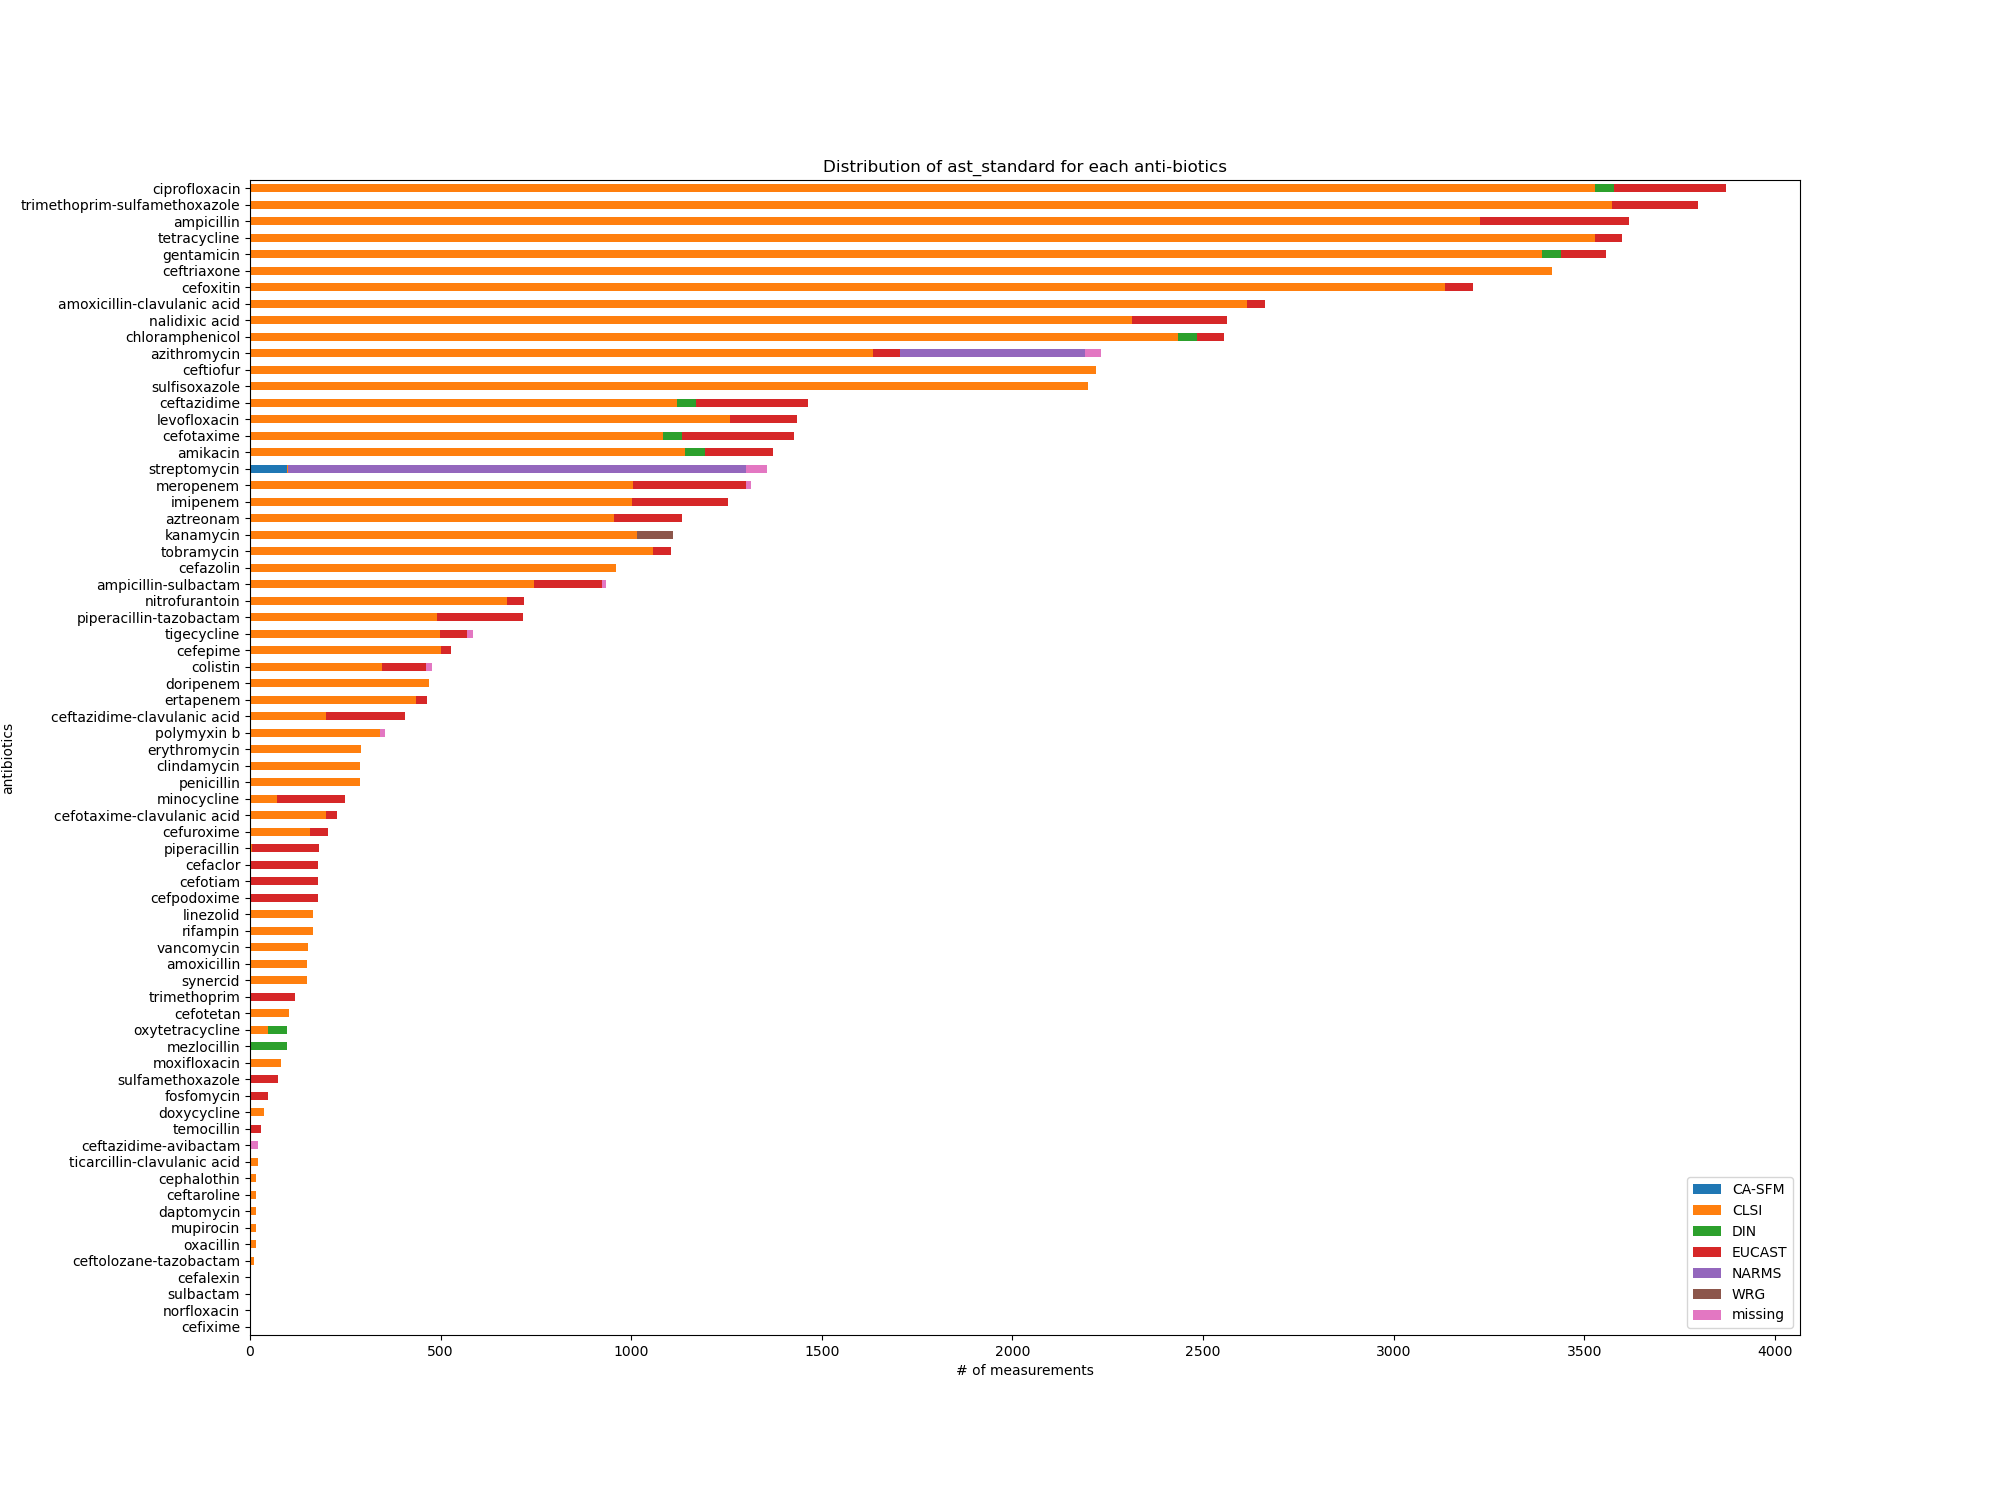

In [156]:
look_at_anti_dist(filtered_ASR, 'ast_standard')

### check DB sidtribution:

<IPython.core.display.Javascript object>


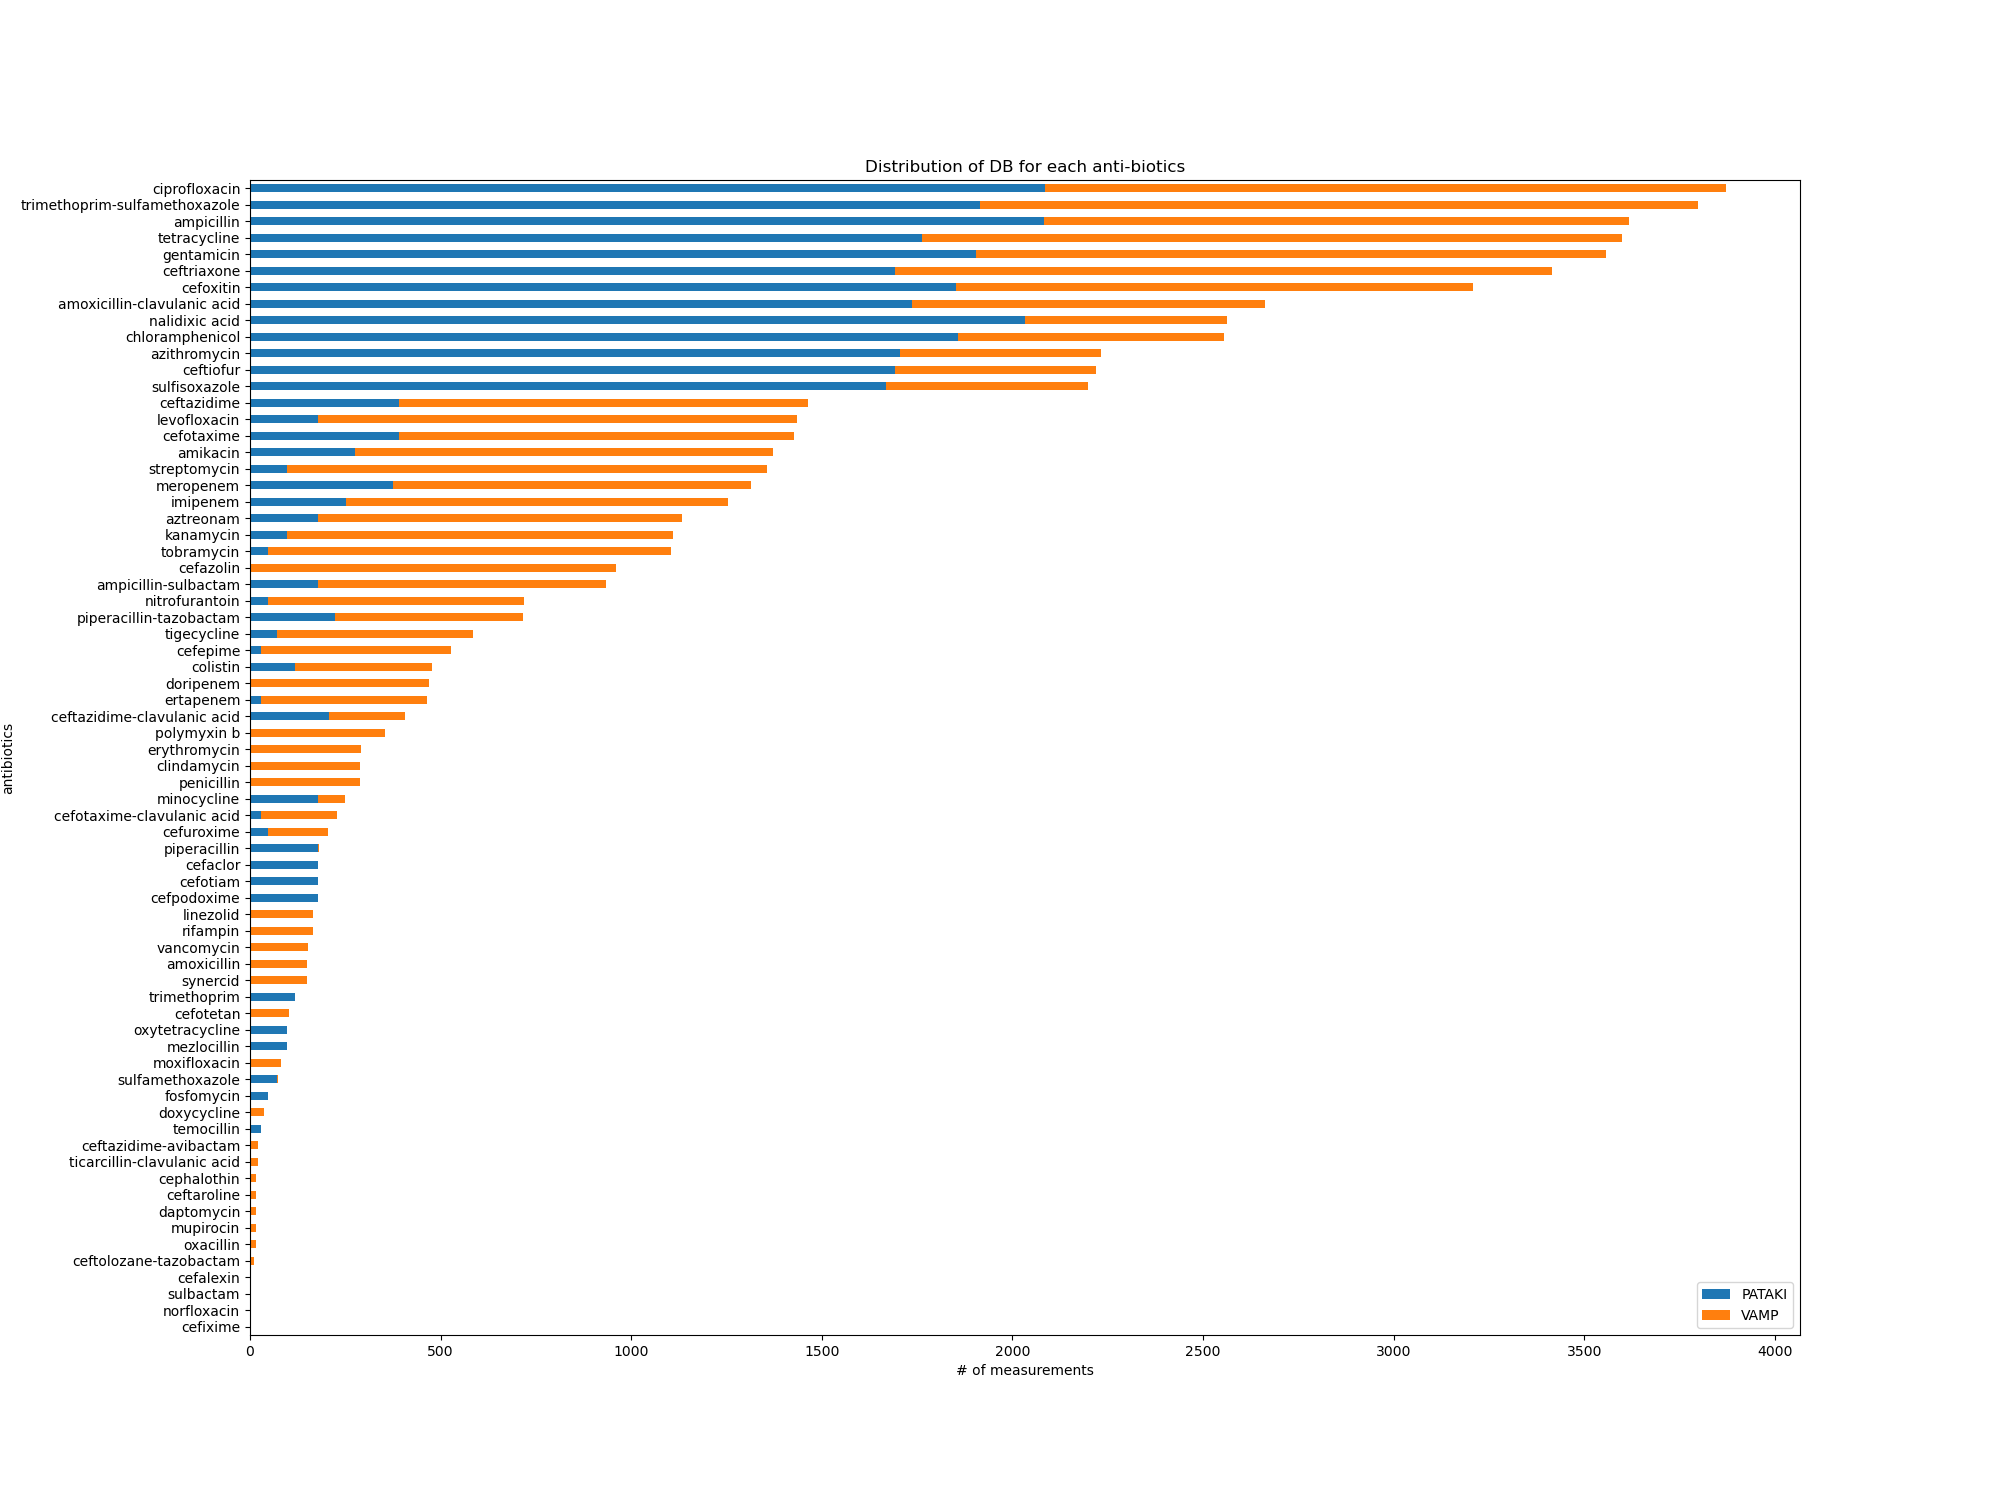

In [157]:
look_at_anti_dist(filtered_ASR, 'DB')

### species distribution

In [ ]:
species2merge = tot_data[['biosample_id', 'species_fam']]

In [ ]:
species2merge.describe()

In [160]:
species2merge['species_fam'].unique()

array(['ecoli', 'senterica', 'abaumannii', 'ecloacae', 'kpneumoniae',
       'spneumoniae', 'paeruginosa', 'saureus'], dtype=object)

In [ ]:
species_ASR = filtered_ASR.drop('species_fam', axis=1).merge(species2merge, on='biosample_id')

In [31]:
look_at_anti_dist(species_ASR, 'species_fam')

NameError: name 'look_at_anti_dist' is not defined

### dash antibiotics:

<IPython.core.display.Javascript object>


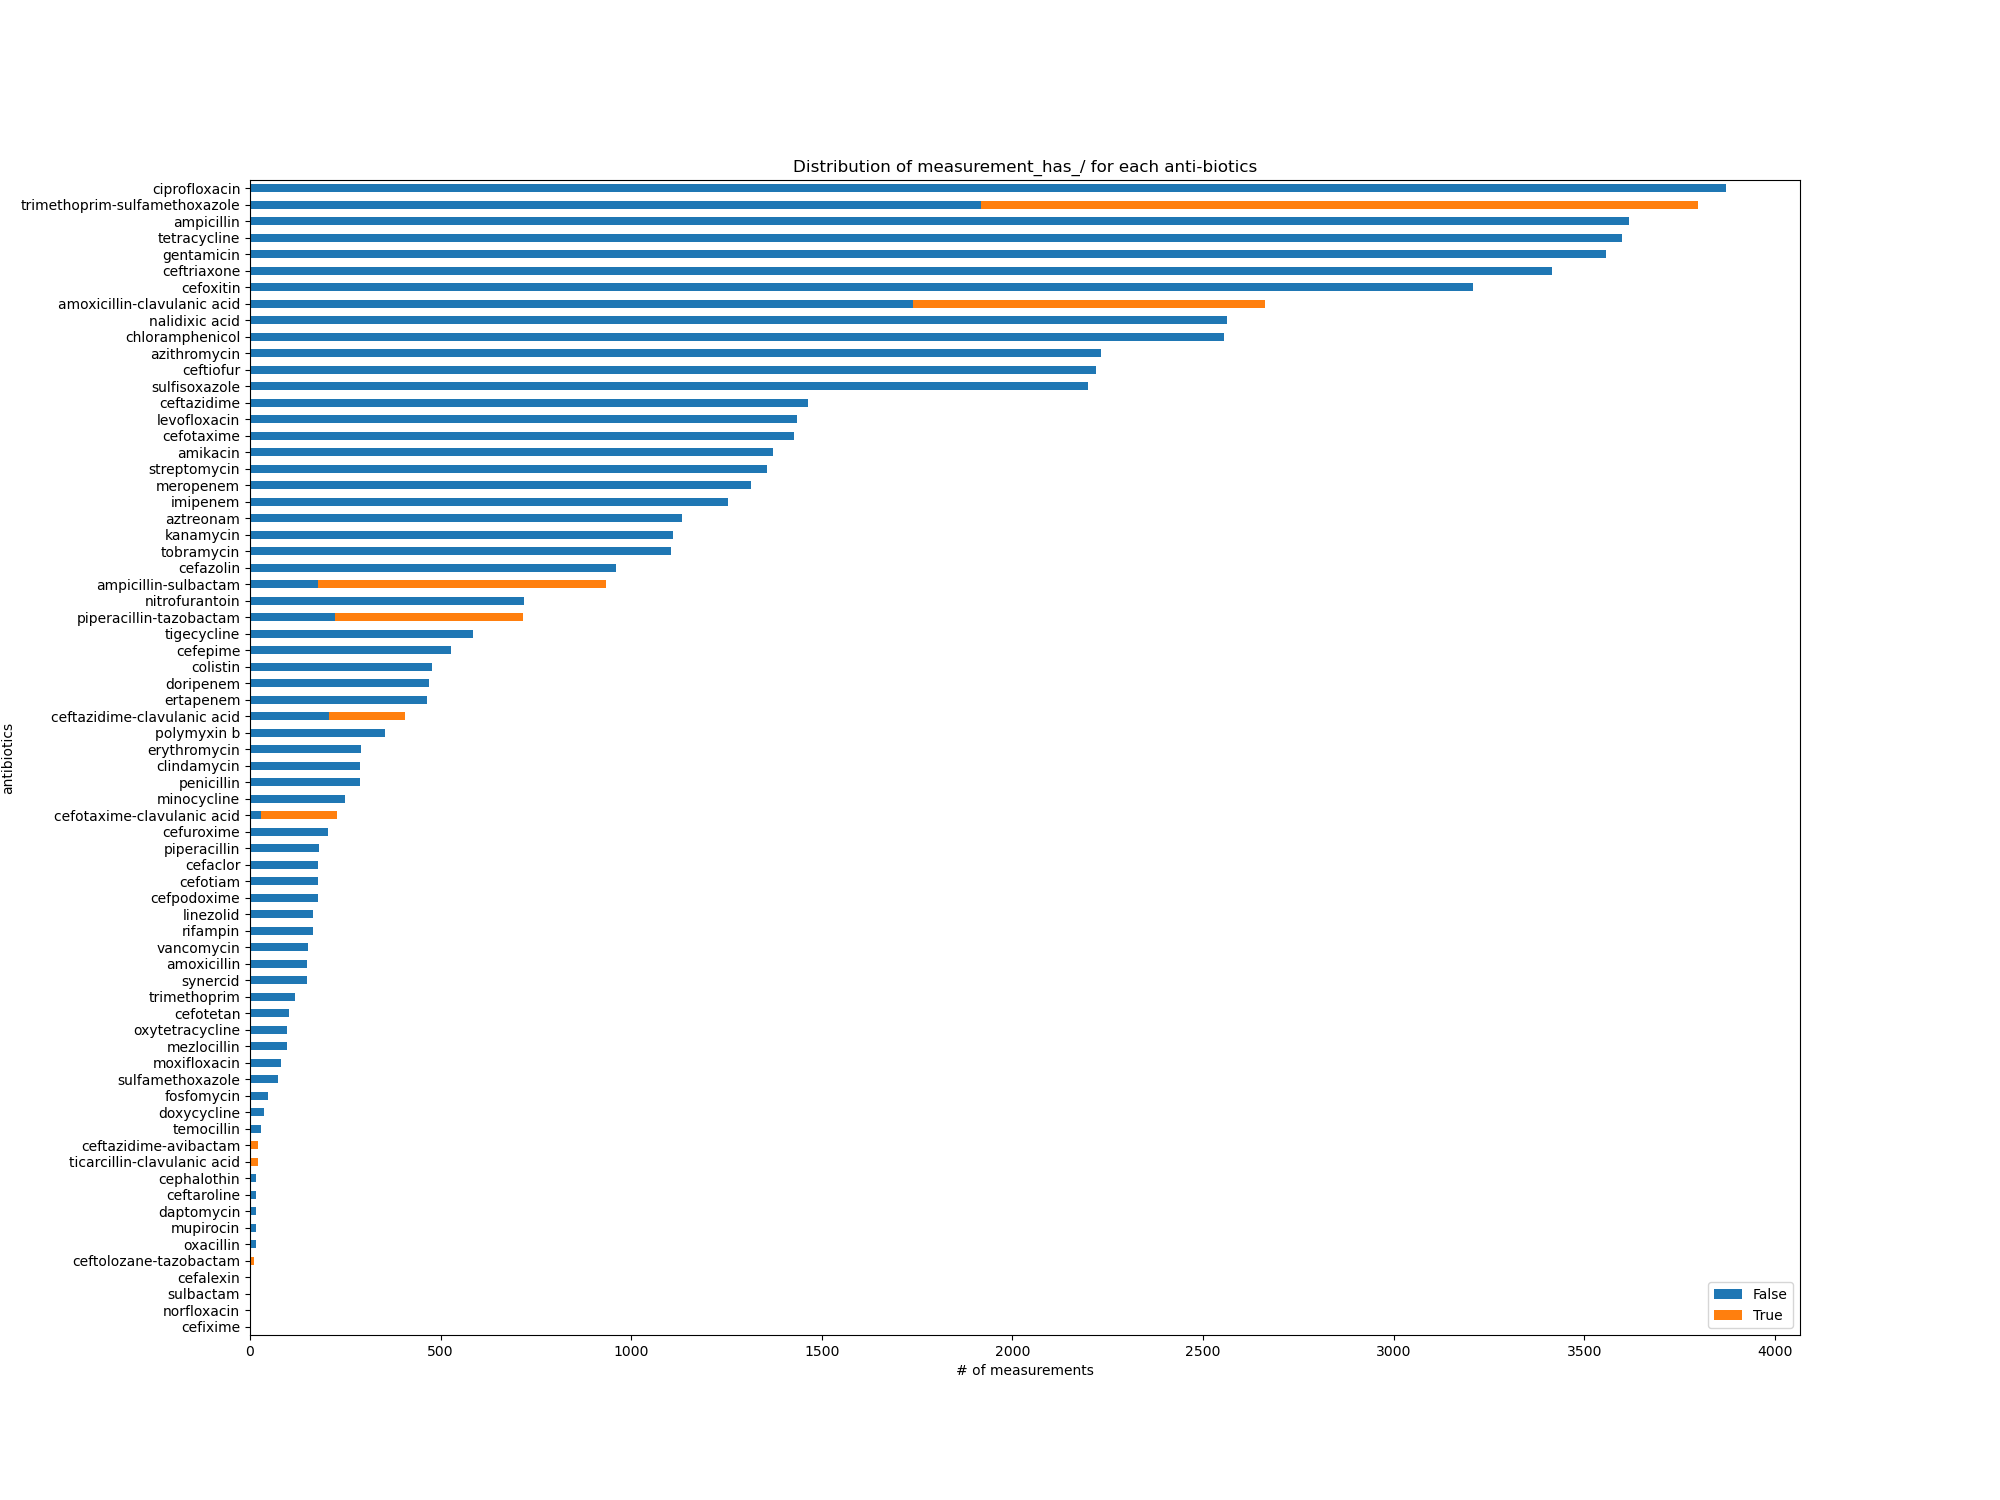

In [163]:
look_at_anti_dist(filtered_ASR, 'measurement_has_/')

### mm untis IDS

<IPython.core.display.Javascript object>


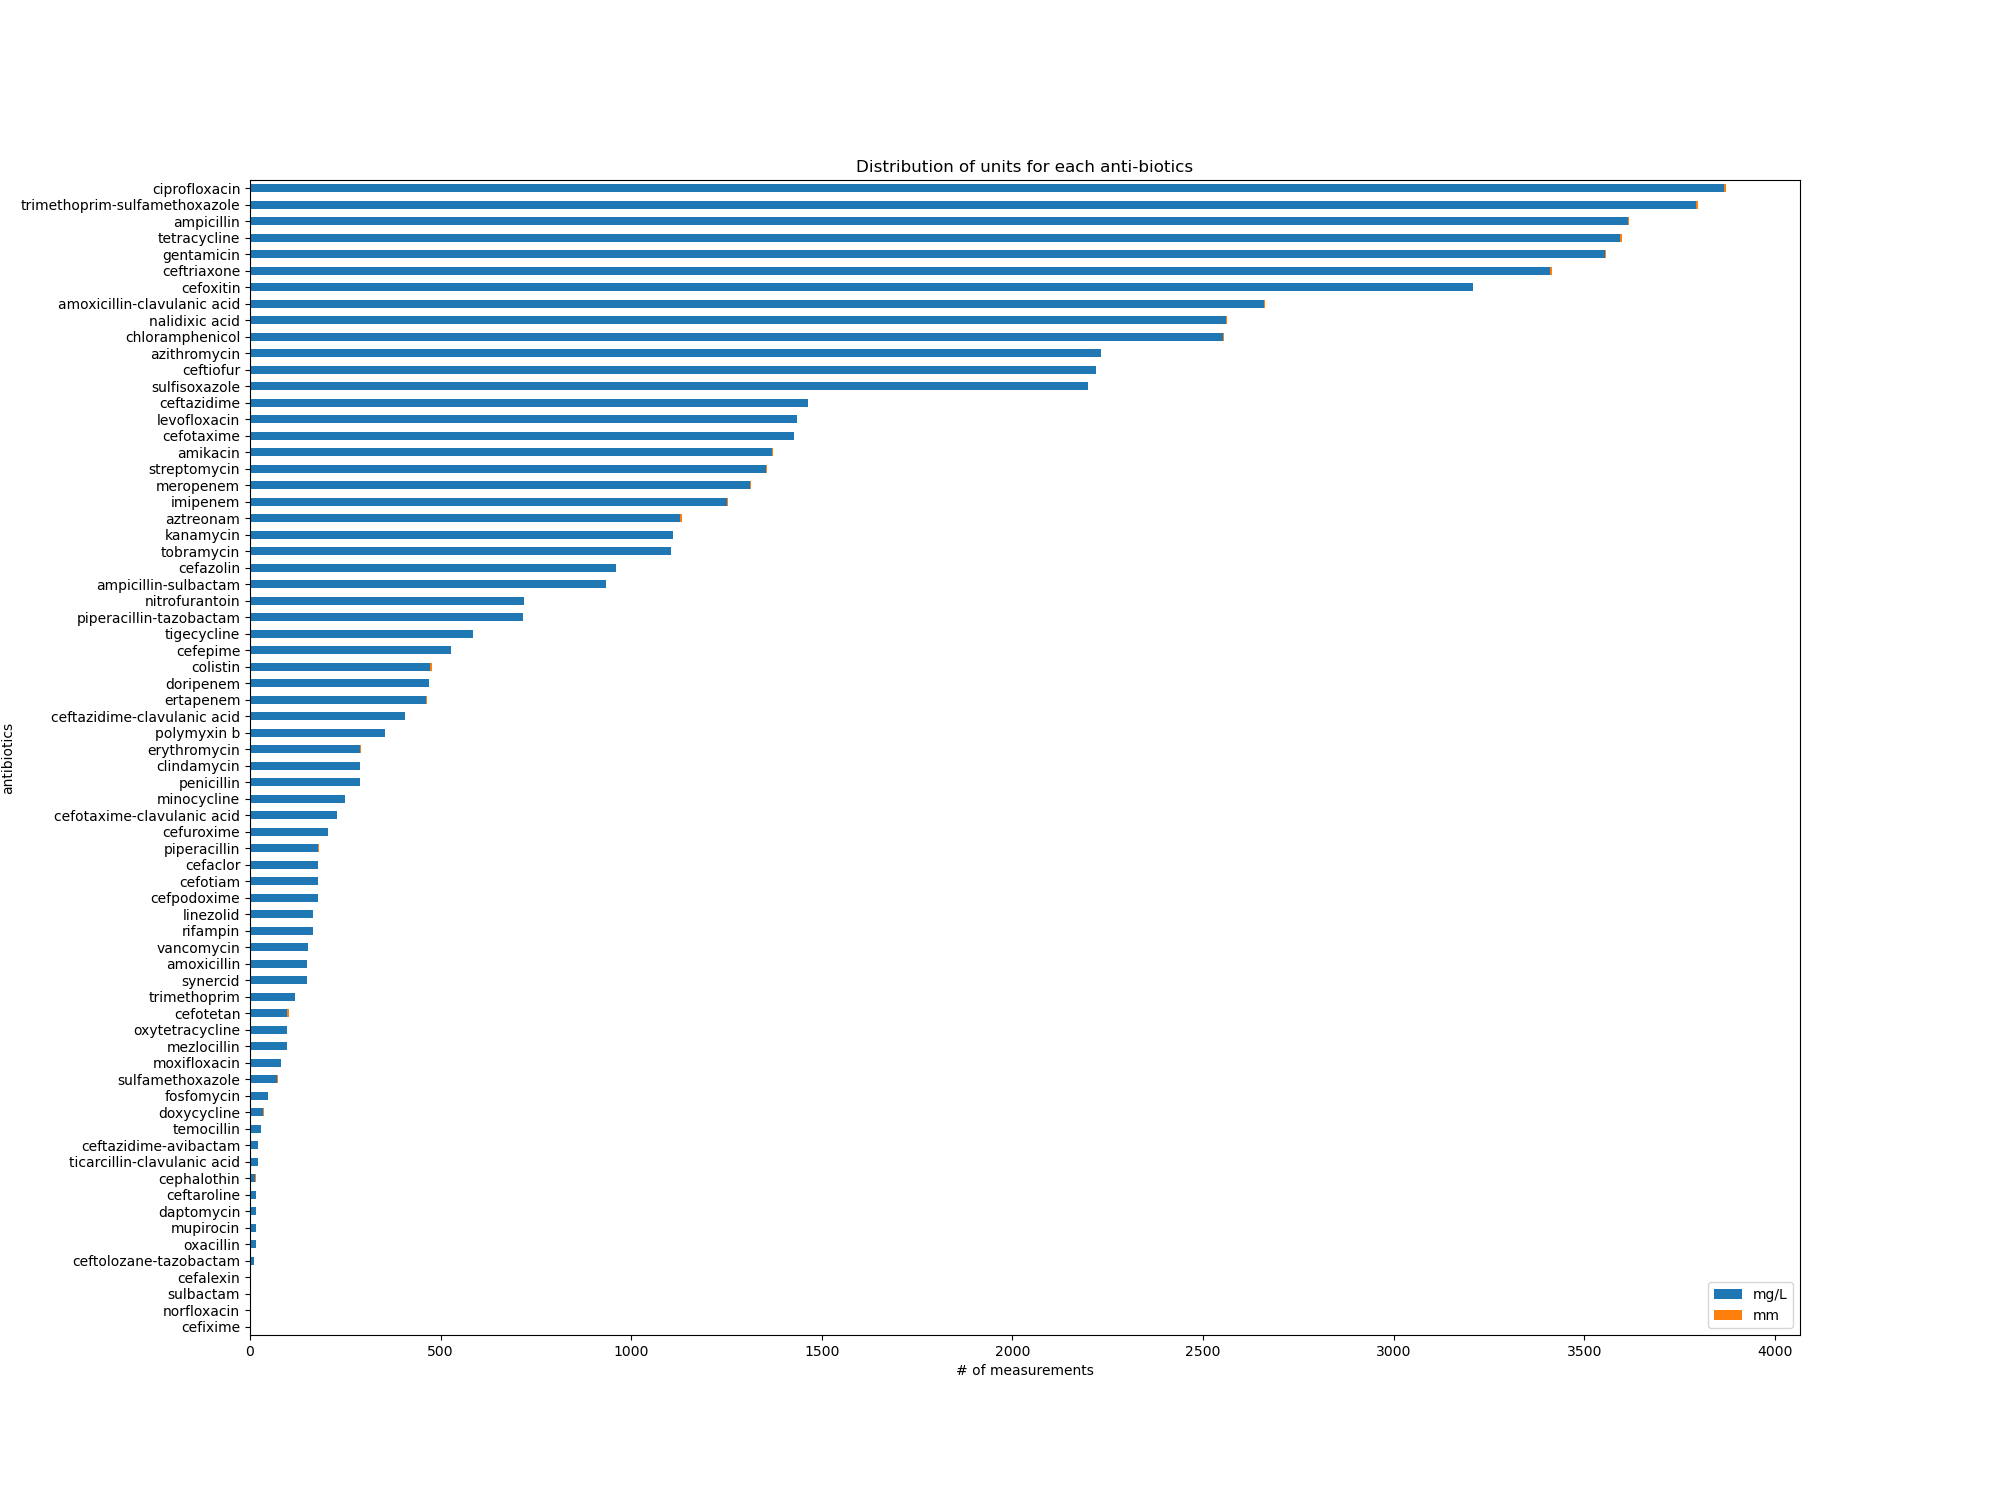

In [164]:
look_at_anti_dist(filtered_ASR, 'units')

In [112]:
mm_values = filtered_ASR[filtered_ASR['units']=='mm']

In [113]:
mm_values.head()

biosample_id       species_fam antibiotic_name ast_standard  \
5  SAMEA104128304  escherichia coli   ciprofloxacin         CLSI   
4  SAMEA104128304  escherichia coli     ceftriaxone         CLSI   
9  SAMEA104128304  escherichia coli     norfloxacin         CLSI   
0  SAMEA104128304  escherichia coli        amikacin         CLSI   
6  SAMEA104128304  escherichia coli     doxycycline         CLSI   

  breakpoint_version laboratory_typing_method  measurement measurement_sign  \
5           M100-S24           Disc-diffusion         22.0                =   
4           M100-S24           Disc-diffusion         20.0                =   
9           M100-S24           Disc-diffusion         20.0                =   
0           M100-S24           Disc-diffusion         19.0                =   
6           M100-S24           Disc-diffusion         19.0                =   

  resistance_phenotype platform      DB  measurement_has_/  measurement2  \
5          susceptible      NaN  PATAKI              False           NaN   
4          susceptible      NaN  PATAKI              False           NaN   
9          susceptible      NaN  PATAKI              False           NaN   
0          susceptible      NaN  PATAKI              False           NaN   
6          susceptible      NaN  PATAKI              False           NaN   

  units measurement_type    1  1.1  1.2             unique_id  
5    mm              NaN  NaN  NaN  NaN  SAMEA104128304PATAKI  
4    mm              NaN  NaN  NaN  NaN  SAMEA104128304PATAKI  
9    mm              NaN  NaN  NaN  NaN  SAMEA104128304PATAKI  
0    mm              NaN  NaN  NaN  NaN  SAMEA104128304PATAKI  
6    mm              NaN  NaN  NaN  NaN  SAMEA104128304PATAKI

In [114]:
mm_values[['unique_id', 'species_fam', 'antibiotic_name', 'ast_standard', 'laboratory_typing_method', 'measurement_type',  'DB']].describe()

unique_id       species_fam antibiotic_name ast_standard  \
count                 72                13              72           72   
unique                 6                 1              31            1   
top     SAMN01163409VAMP  escherichia coli   ciprofloxacin         CLSI   
freq                  22                13               5           72   

       laboratory_typing_method measurement_type    DB  
count                        13               59    72  
unique                        1                1     2  
top              Disc-diffusion   disk diffusion  VAMP  
freq                         13               59    59

In [119]:
mm_ids = mm_values[['biosample_id', 'DB']].drop_duplicates()
mm_ids.to_csv('../resources/reports/mm_units_biosamples_and_db.txt')

In [112]:
 mm_values['antibiotic_name'].unique()

array(['ciprofloxacin', 'ceftriaxone', 'norfloxacin', 'amikacin',
       'doxycycline', 'nalidixic acid', 'tetracycline', 'streptomycin',
       'trimethoprim-sulfamethoxazole', 'ampicillin', 'azithromycin',
       'cefixime', 'erythromycin', 'imipenem', 'colistin', 'meropenem',
       'chloramphenicol', 'ertapenem', 'piperacillin', 'aztreonam',
       'cefotetan', 'cephalothin', 'sulfamethoxazole', 'gentamicin',
       'sulbactam', 'cefalexin', 'tobramycin', 'levofloxacin', 'cefepime',
       'amoxicillin-clavulanic acid', 'ceftazidime'], dtype=object)

In [113]:
filtered_ASR[filtered_ASR['unique_id'].isin(mm_ids)]['antibiotic_name'].describe()

count               114
unique               34
top       ciprofloxacin
freq                  6
Name: antibiotic_name, dtype: object

In [114]:
mm_values

biosample_id       species_fam antibiotic_name ast_standard  \
5   SAMEA104128304  escherichia coli   ciprofloxacin         CLSI   
4   SAMEA104128304  escherichia coli     ceftriaxone         CLSI   
9   SAMEA104128304  escherichia coli     norfloxacin         CLSI   
0   SAMEA104128304  escherichia coli        amikacin         CLSI   
6   SAMEA104128304  escherichia coli     doxycycline         CLSI   
..             ...               ...             ...          ...   
12    SAMN01163409               NaN    piperacillin         CLSI   
15    SAMN01163409               NaN     ceftriaxone         CLSI   
10    SAMN01163409               NaN     ceftazidime         CLSI   
7     SAMN01163409               NaN     cephalothin         CLSI   
2     SAMN01163409               NaN      ampicillin         CLSI   

   breakpoint_version laboratory_typing_method  measurement measurement_sign  \
5            M100-S24           Disc-diffusion         22.0                =   
4            M100-S24           Disc-diffusion         20.0                =   
9            M100-S24           Disc-diffusion         20.0                =   
0            M100-S24           Disc-diffusion         19.0                =   
6            M100-S24           Disc-diffusion         19.0                =   
..                ...                      ...          ...              ...   
12                NaN                      NaN          6.0                =   
15                NaN                      NaN          6.0                =   
10                NaN                      NaN          6.0                =   
7                 NaN                      NaN          6.0                =   
2                 NaN                      NaN          6.0                =   

   resistance_phenotype platform      DB  measurement_has_/  measurement2  \
5           susceptible      NaN  PATAKI              False           NaN   
4           susceptible      NaN  PATAKI              False           NaN   
9           susceptible      NaN  PATAKI              False           NaN   
0           susceptible      NaN  PATAKI              False           NaN   
6           susceptible      NaN  PATAKI              False           NaN   
..                  ...      ...     ...                ...           ...   
12            resistant      NaN    VAMP              False           NaN   
15            resistant      NaN    VAMP              False           NaN   
10            resistant      NaN    VAMP              False           NaN   
7             resistant      NaN    VAMP              False           NaN   
2             resistant      NaN    VAMP              False           NaN   

   units measurement_type                  1         1.1      1.2  \
5     mm              NaN                NaN         NaN      NaN   
4     mm              NaN                NaN         NaN      NaN   
9     mm              NaN                NaN         NaN      NaN   
0     mm              NaN                NaN         NaN      NaN   
6     mm              NaN                NaN         NaN      NaN   
..   ...              ...                ...         ...      ...   
12    mm   disk diffusion  Vitek GM-NEG card  Biomérieux  missing   
15    mm   disk diffusion  Vitek GM-NEG card  Biomérieux  missing   
10    mm   disk diffusion  Vitek GM-NEG card  Biomérieux  missing   
7     mm   disk diffusion  Vitek GM-NEG card  Biomérieux  missing   
2     mm   disk diffusion  Vitek GM-NEG card  Biomérieux  missing   

               unique_id  
5   SAMEA104128304PATAKI  
4   SAMEA104128304PATAKI  
9   SAMEA104128304PATAKI  
0   SAMEA104128304PATAKI  
6   SAMEA104128304PATAKI  
..                   ...  
12      SAMN01163409VAMP  
15      SAMN01163409VAMP  
10      SAMN01163409VAMP  
7       SAMN01163409VAMP  
2       SAMN01163409VAMP  

[72 rows x 19 columns]

In [150]:
col_name='measurement_sign'
col_order = ['<', '<=', '=', '>=', '>']
col_dist = all_ASR.groupby(by='antibiotic_name')[col_name].apply(lambda x: x.value_counts()).reset_index()
col_dist.columns = ['antibiotic_name', col_name, 'count']
order = col_dist.groupby(by='antibiotic_name')['count'].apply(sum).sort_values().index
col_dist = pd.pivot_table(col_dist, values='count', index=['antibiotic_name'],
                columns=[col_name], aggfunc=np.sum).fillna(0)
col_dist = col_dist[col_order]

<IPython.core.display.Javascript object>


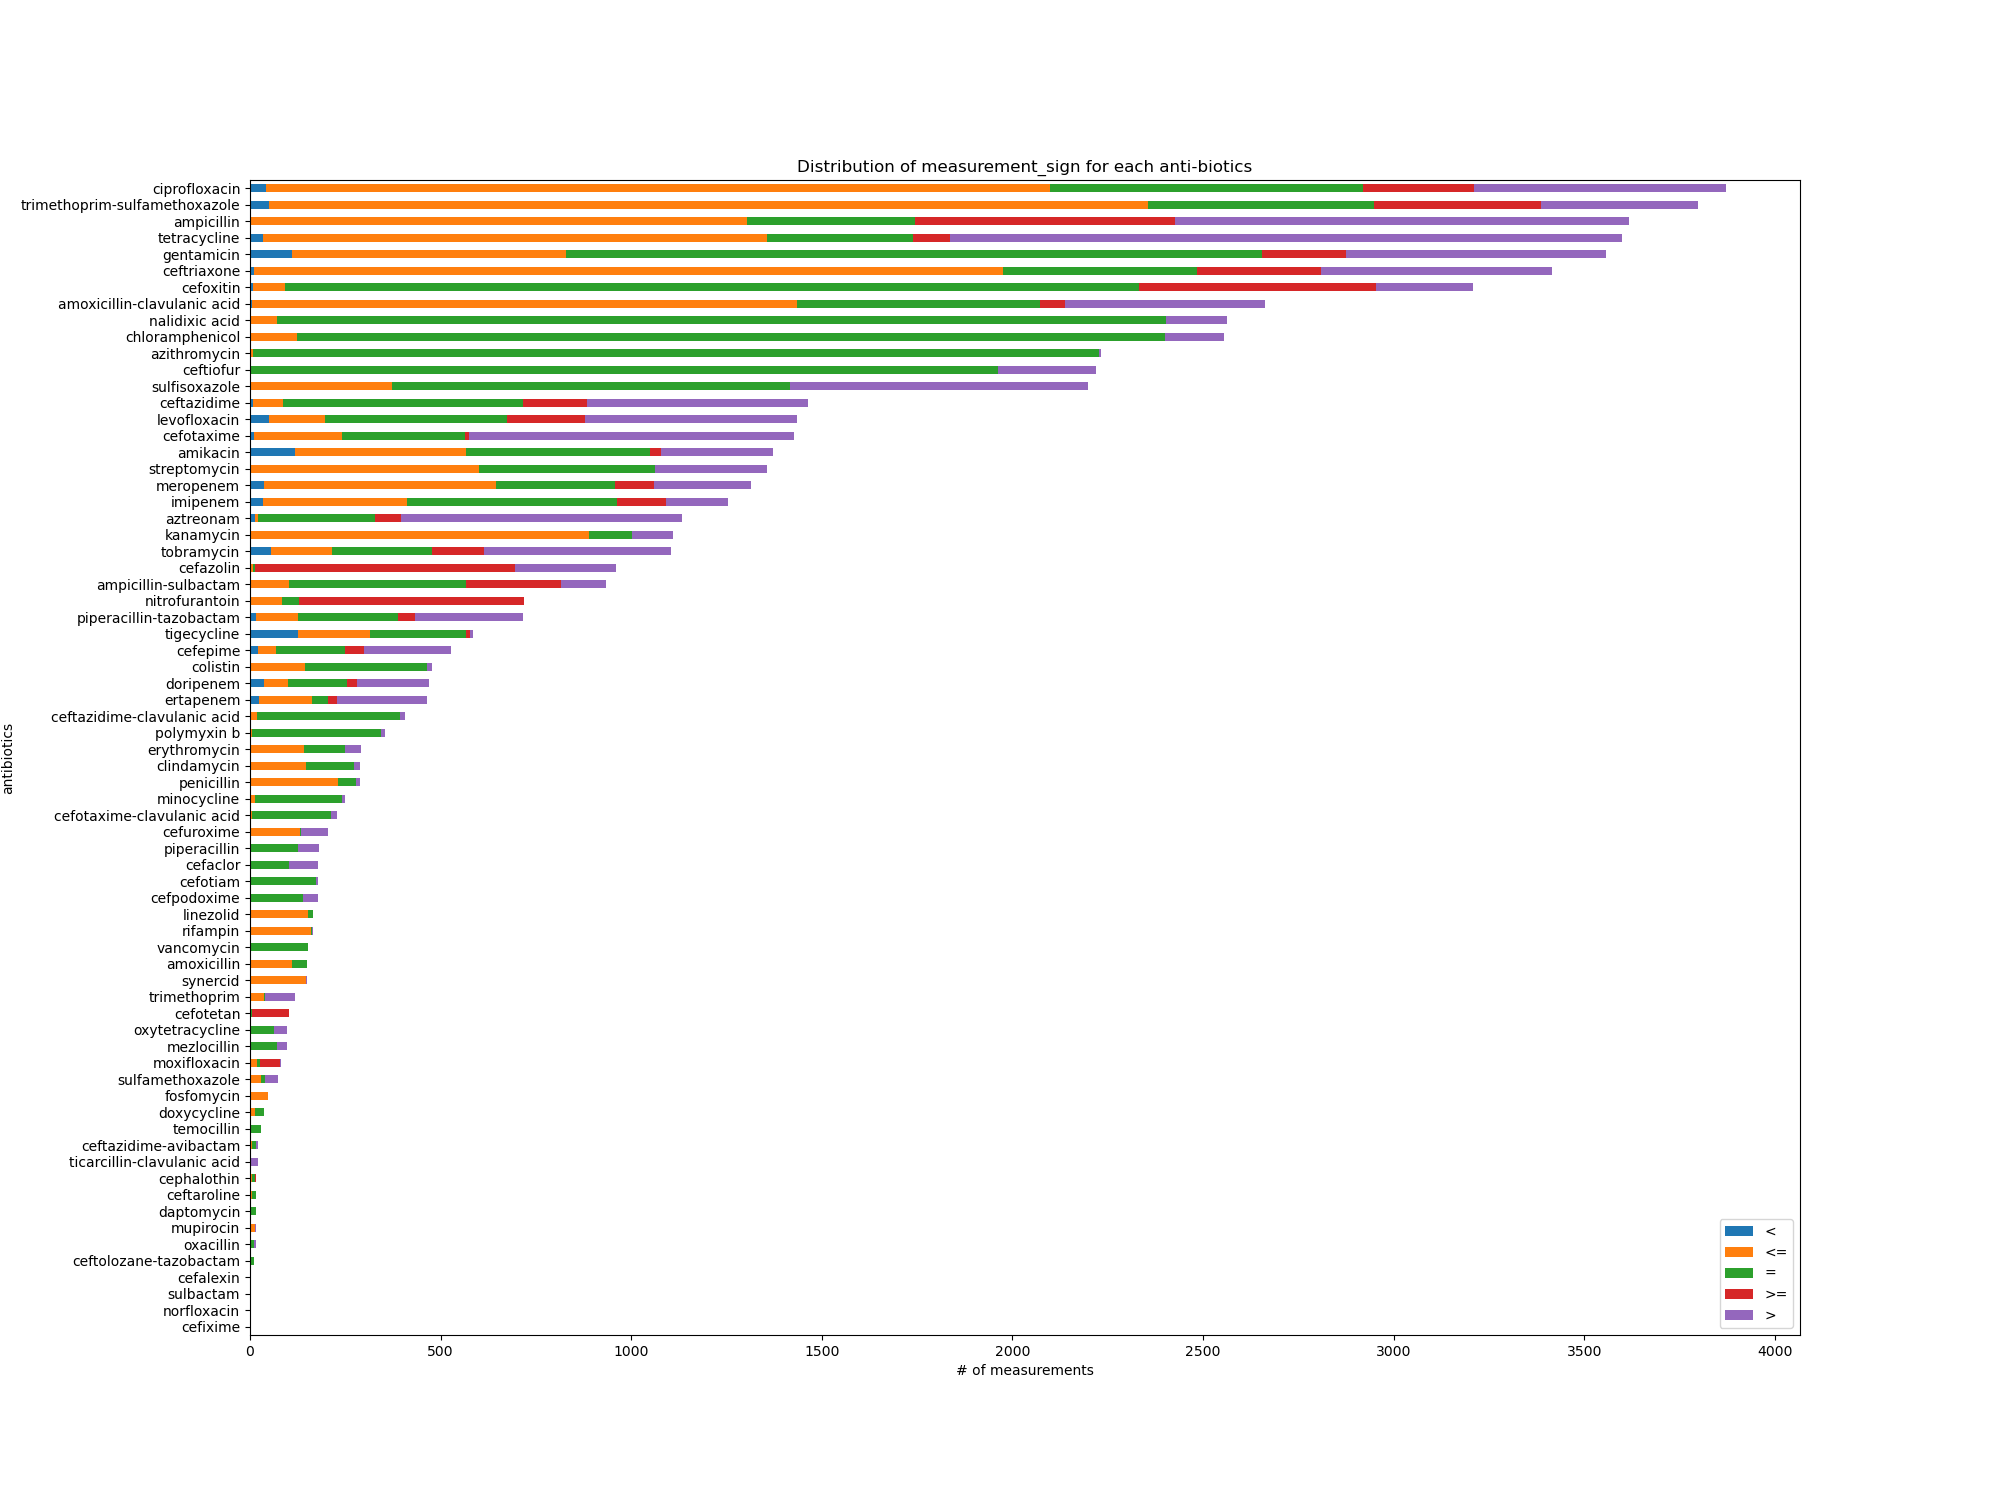

In [165]:
look_at_anti_dist(filtered_ASR, 'measurement_sign', col_order=['<', '<=', '=', '>=', '>'])

<IPython.core.display.Javascript object>


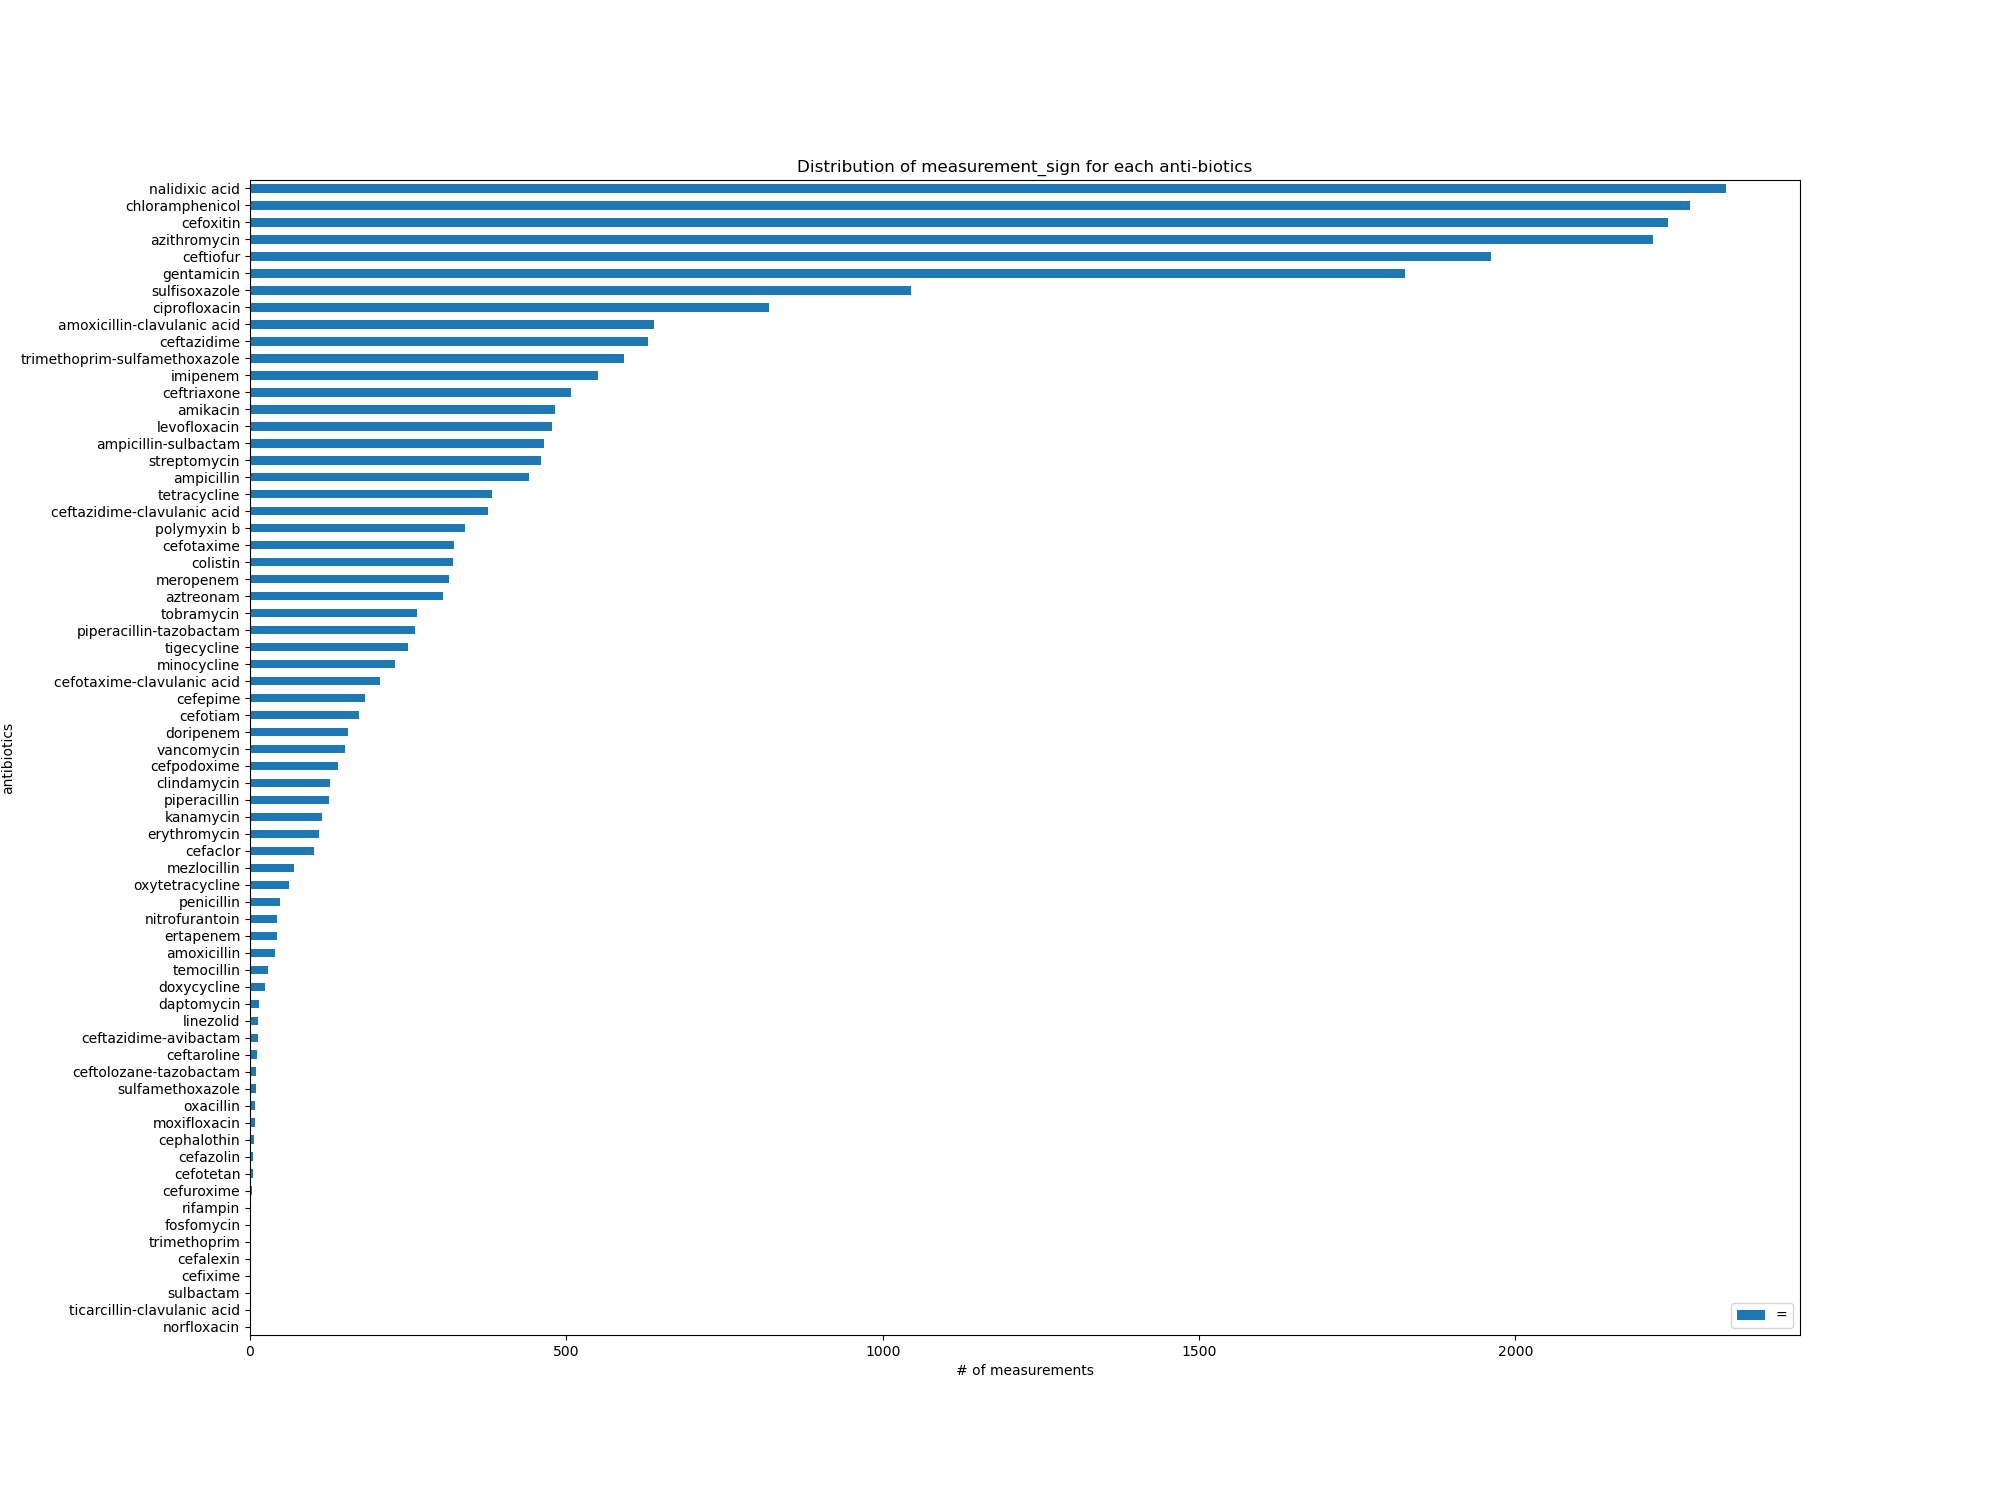

In [166]:
look_at_anti_dist(filtered_ASR[filtered_ASR['measurement_sign'] == '='], 'measurement_sign')

<IPython.core.display.Javascript object>


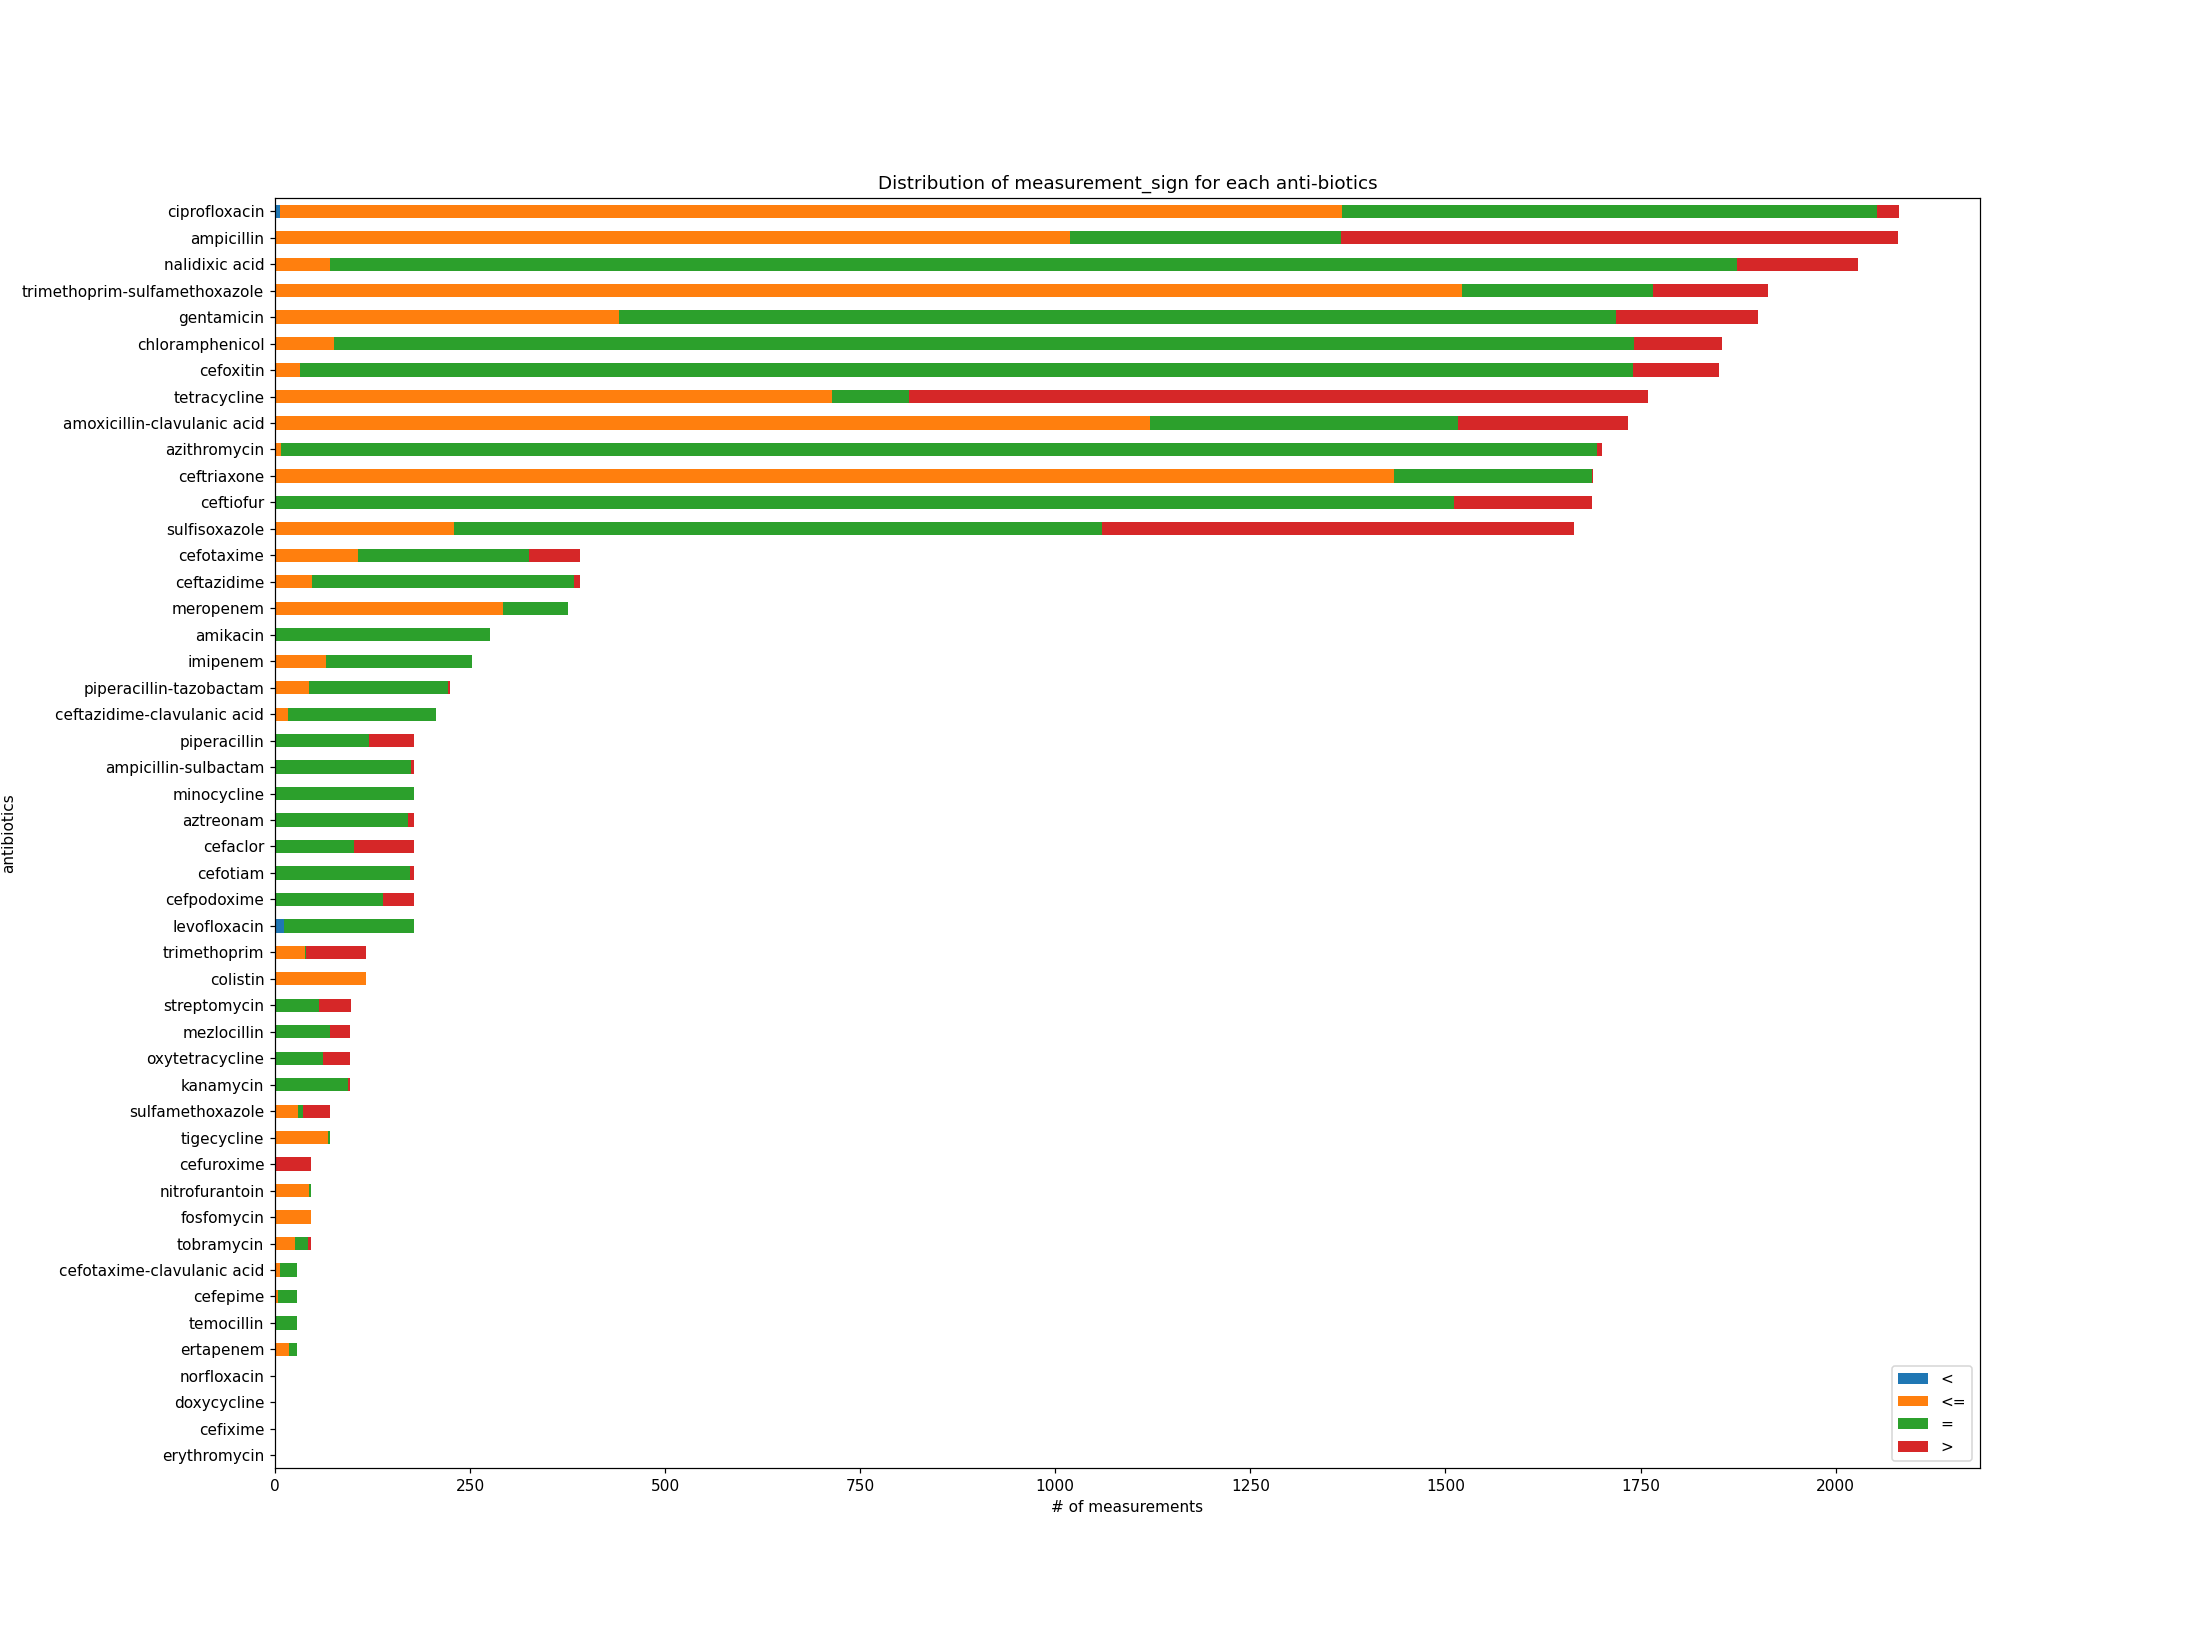

In [134]:
look_at_anti_dist(filtered_ASR[filtered_ASR['DB']=='PATAKI'], 'measurement_sign')

<IPython.core.display.Javascript object>


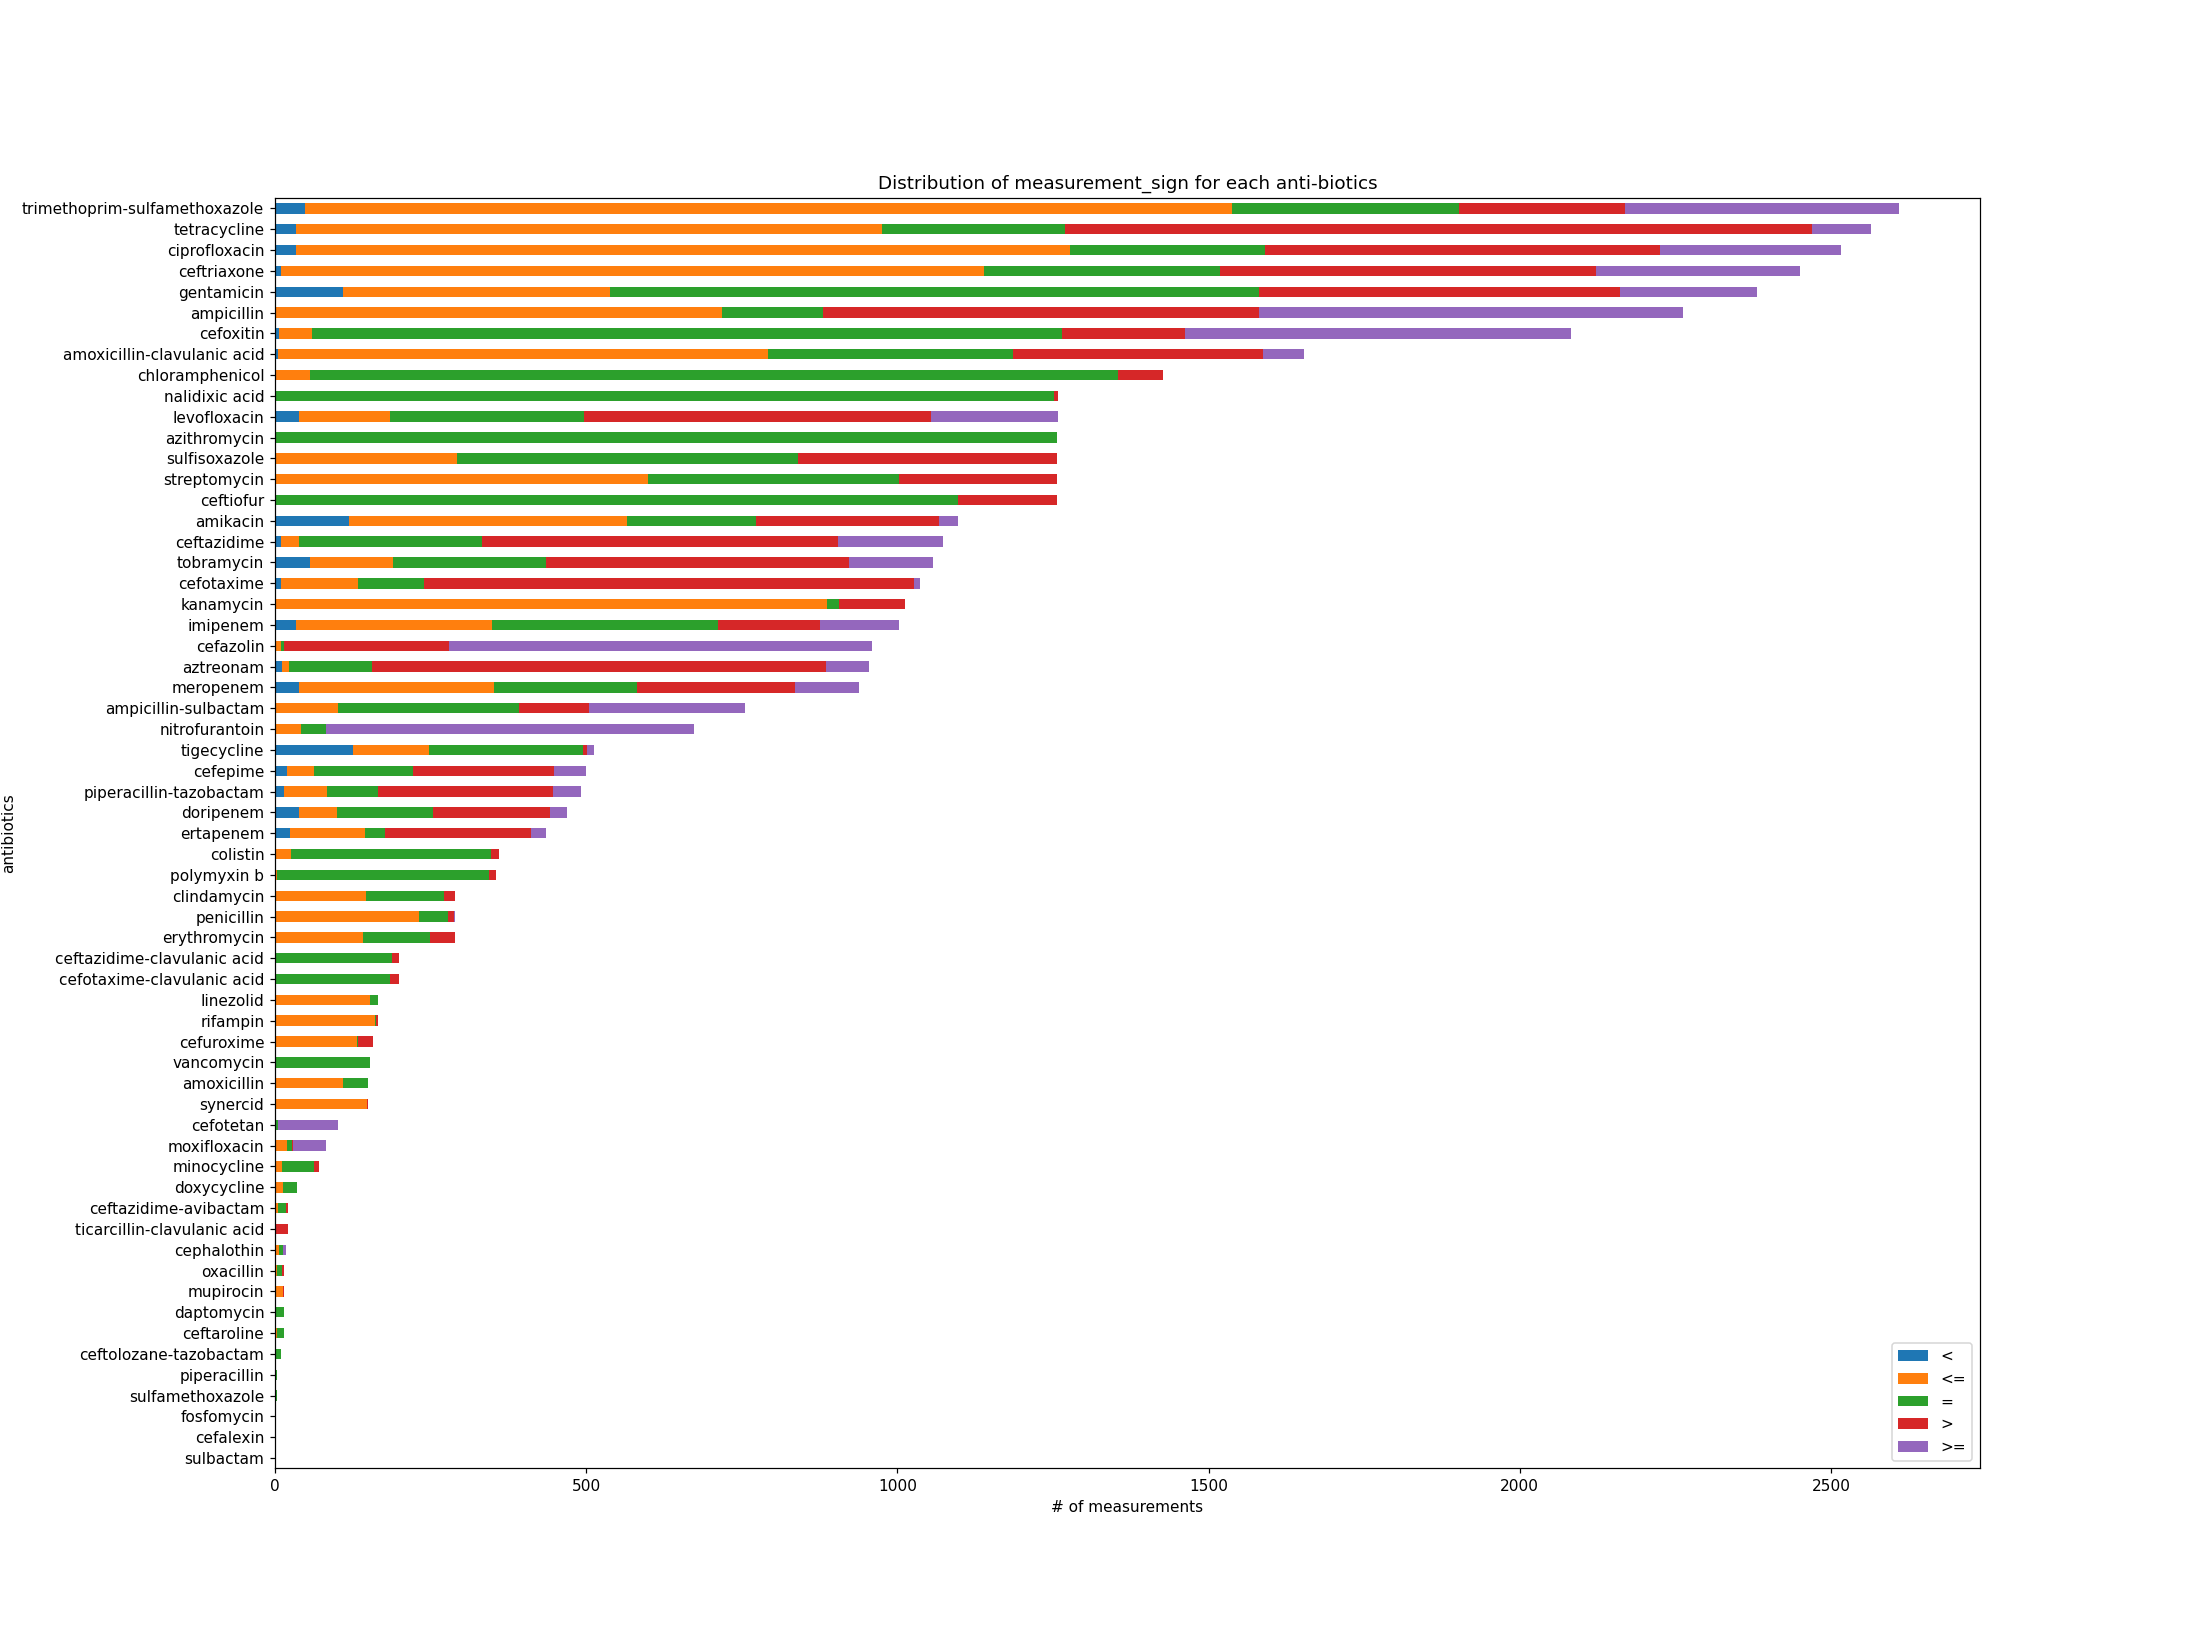

In [135]:
look_at_anti_dist(filtered_ASR[filtered_ASR['DB']=='VAMP'], 'measurement_sign')

In [166]:
all_ASR.columns

Index(['bioSample_ID', 'species', 'antibiotic_name', 'ast_standard',
       'breakpoint_version', 'laboratory_typing_method', 'measurement',
       'measurement_units', 'measurement_sign', 'resistance_phenotype',
       'platform', 'DB', 'measurement_has_/', 'measurement2', 'platform ',
       'units', 'measurement_type', '1', '1.1', '1.2'],
      dtype='object')

In [142]:
def print_anti_measure(all_ASR, anti_index):
    anti = all_ASR['antibiotic_name'].value_counts().index[anti_index]
    anti_MIC = all_ASR[all_ASR['antibiotic_name'] == anti]
    anti_MIC['measurement'] = anti_MIC['measurement'].apply(np.log2)
    low = anti_MIC['measurement'].min().round()
    high = anti_MIC['measurement'].max().round()
    hist_range = np.arange(low-0.5, high+1, 1)
    bins_count = anti_MIC.groupby(by='measurement_sign')['measurement'].apply(lambda x: np.histogram(x, bins=hist_range)[0]).loc[['=', '<=', '>=', '<', '>']]
    pd.DataFrame(bins_count.tolist(), index= bins_count.index, columns=hist_range[:-1]+0.5).T.plot.bar(stacked=True)
    plt.title(anti)
    plt.xlabel('log2(mg//L)')
    plt.ylabel('#')


/home/amitdanw/.conda/envs/gps/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


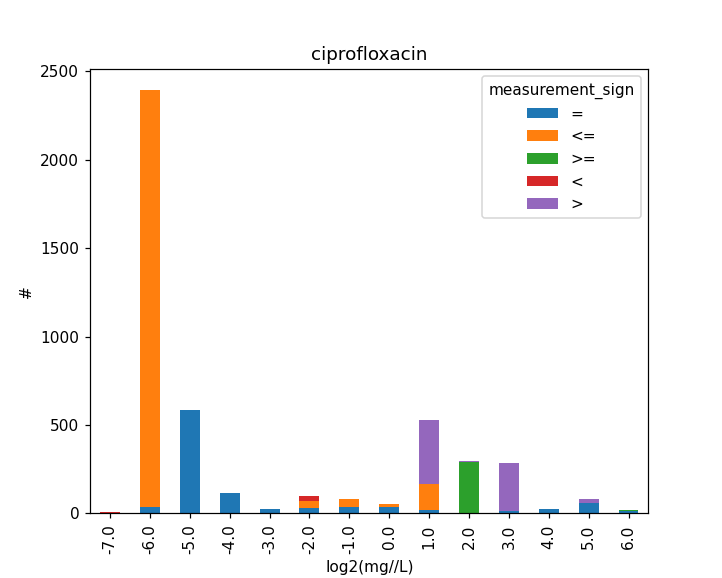

<IPython.core.display.Javascript object>


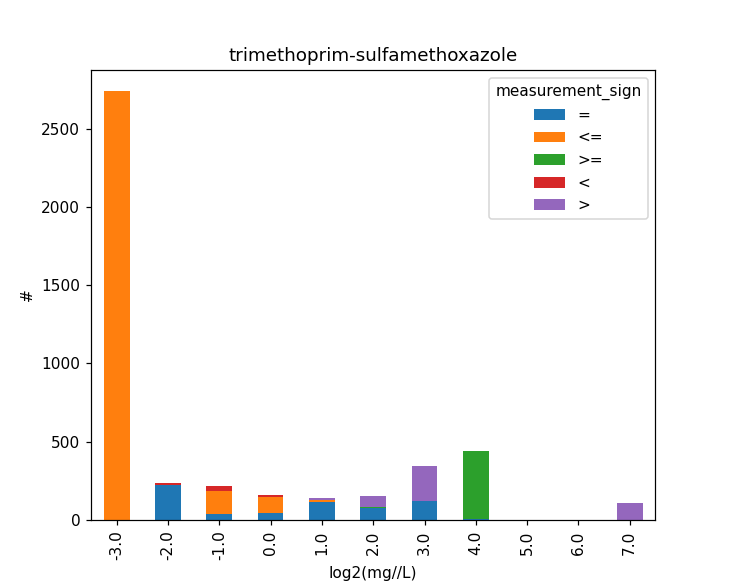

<IPython.core.display.Javascript object>


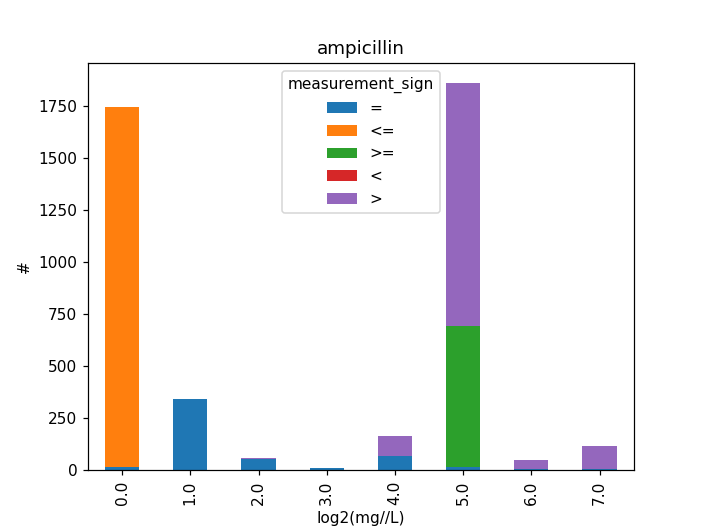

<IPython.core.display.Javascript object>


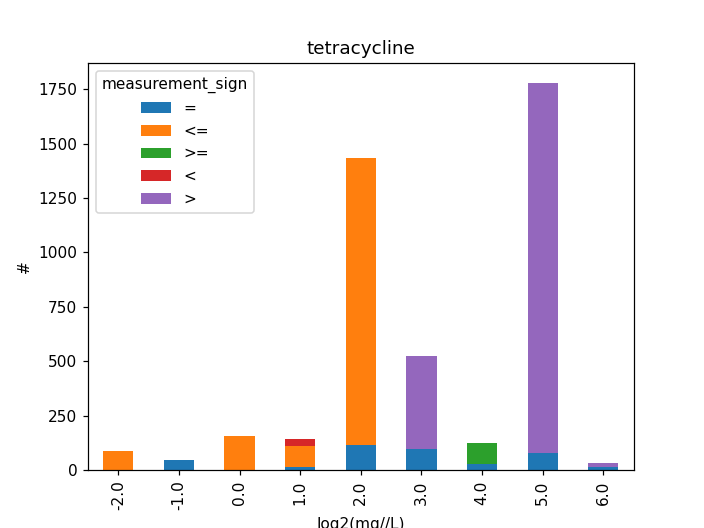

<IPython.core.display.Javascript object>


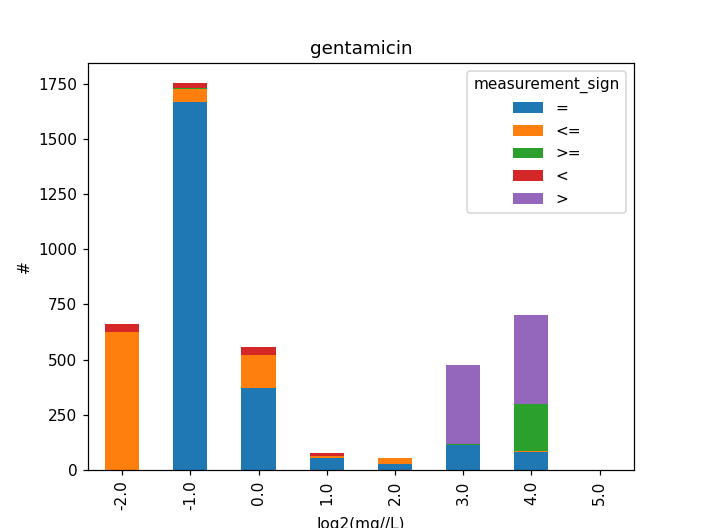

<IPython.core.display.Javascript object>


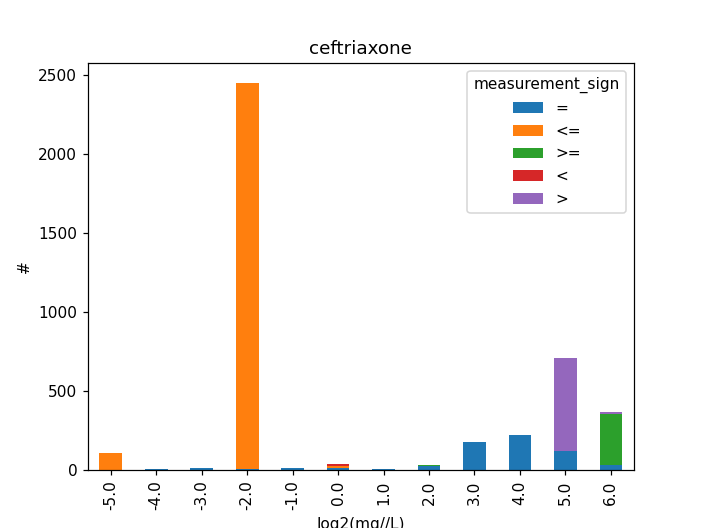

<IPython.core.display.Javascript object>


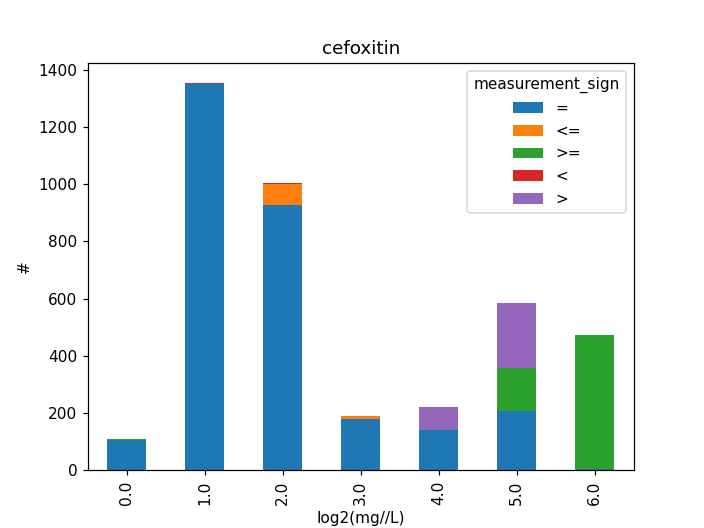

<IPython.core.display.Javascript object>


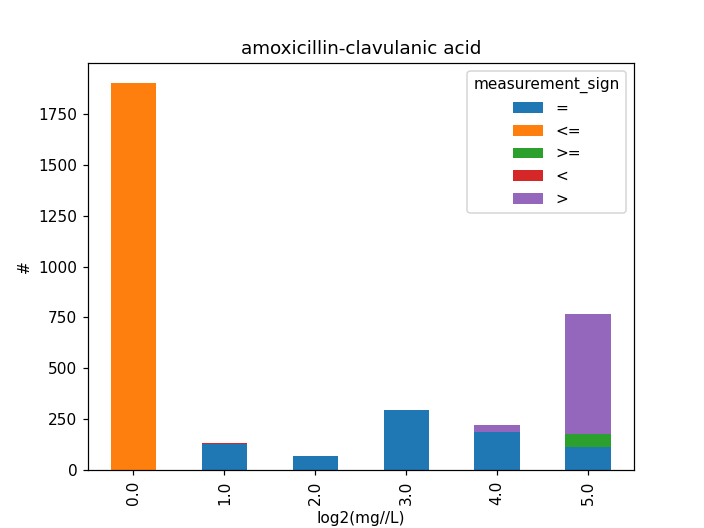

KeyError: "['>=', '<'] not in index"

In [143]:
for i in np.arange(20):
    print_anti_measure(filtered_ASR, i)

In [147]:
find_incosistent = filtered_ASR[filtered_ASR['antibiotic_name'] == 'ciprofloxacin']
find_incosistent = find_incosistent[find_incosistent['measurement'] == 2.0]
less_incosistent = find_incosistent[find_incosistent['measurement_sign'] == '<=']
more_incosistent = find_incosistent[find_incosistent['measurement_sign'] == '>']

In [154]:
less_incosistent.drop(['measurement', 'measurement2'], axis=1).describe()

biosample_id species_fam antibiotic_name ast_standard  \
count            149           0             149          149   
unique           149           0               1            1   
top     SAMN03765106         NaN   ciprofloxacin         CLSI   
freq               1         NaN             149          149   

       breakpoint_version laboratory_typing_method measurement_sign  \
count                   0                        0              149   
unique                  0                        0                1   
top                   NaN                      NaN               <=   
freq                  NaN                      NaN              149   

       resistance_phenotype platform    DB measurement_has_/ units  \
count                   149        0   149               149   149   
unique                    1        0     1                 1     1   
top             susceptible      NaN  VAMP             False  mg/L   
freq                    149      NaN   149               149   149   

       measurement_type                1   1.1                     1.2  \
count               149              149   149                     149   
unique                1                1     1                       1   
top                 MIC  Trek sensititre  Trek  Trek Specialized panel   
freq                149              149   149                     149   

               unique_id  
count                149  
unique               149  
top     SAMN03765106VAMP  
freq                   1

In [153]:
more_incosistent.drop(['measurement', 'measurement2'], axis=1).describe()

biosample_id species_fam antibiotic_name ast_standard  \
count            360           0             360          360   
unique           360           0               1            1   
top     SAMN04568523         NaN   ciprofloxacin         CLSI   
freq               1         NaN             360          360   

       breakpoint_version laboratory_typing_method measurement_sign  \
count                   0                        0              360   
unique                  0                        0                1   
top                   NaN                      NaN                >   
freq                  NaN                      NaN              360   

       resistance_phenotype platform    DB measurement_has_/ units  \
count                   360        0   360               360   360   
unique                    1        0     1                 1     1   
top               resistant      NaN  VAMP             False  mg/L   
freq                    360      NaN   360               360   360   

       measurement_type        1               1.1  1.2         unique_id  
count               360      360               360    0               360  
unique                1        3                 3    0               360  
top                 MIC  Phoenix  Becton Dickinson  NaN  SAMN04568523VAMP  
freq                360      331               331  NaN                 1

In [155]:
find_incosistent = filtered_ASR[filtered_ASR['antibiotic_name'] == 'ciprofloxacin']
find_incosistent = find_incosistent[find_incosistent['measurement'] == 4.0]
thresh_value_incosistent = find_incosistent[find_incosistent['measurement_sign'] == '>=']

In [156]:
thresh_value_incosistent.drop(['measurement', 'measurement2'], axis=1).describe()

biosample_id species_fam antibiotic_name ast_standard  \
count            287           0             287          287   
unique           287           0               1            1   
top     SAMN06754742         NaN   ciprofloxacin         CLSI   
freq               1         NaN             287          287   

       breakpoint_version laboratory_typing_method measurement_sign  \
count                   0                        0              287   
unique                  0                        0                1   
top                   NaN                      NaN               >=   
freq                  NaN                      NaN              287   

       resistance_phenotype platform    DB measurement_has_/ units  \
count                   287        0   287               287   287   
unique                    1        0     1                 1     1   
top               resistant      NaN  VAMP             False  mg/L   
freq                    287      NaN   287               287   287   

       measurement_type      1         1.1      1.2         unique_id  
count               287    285         285      106               287  
unique                1      2           2        3               287  
top                 MIC  Vitek  Biomérieux  missing  SAMN06754742VAMP  
freq                287    284         247       98                 1

In [272]:
filtered_slash_problem = all_ASR[np.logical_and(all_ASR['DB']=='VAMP', all_ASR['measurement_has_/']==True)]

<IPython.core.display.Javascript object>


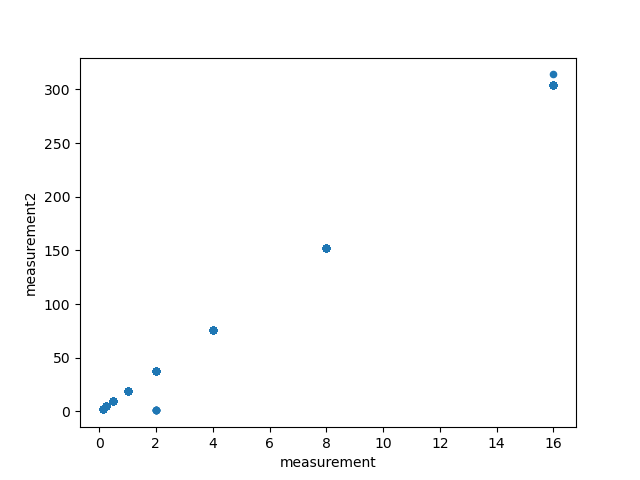

<AxesSubplot:xlabel='measurement', ylabel='measurement2'>

In [277]:
filtered_slash_problem[filtered_slash_problem['antibiotic_name']=='trimethoprim-sulfamethoxazole'].plot.scatter(x='measurement', y='measurement2')

### The Naive approuch

In [161]:
def print_anti_measure(all_ASR, anbtibiotic):
    anti_MIC = all_ASR[all_ASR['antibiotic_name'] == anbtibiotic]
    anti_MIC['measurement'] = anti_MIC['measurement'].apply(np.log2)
    low = anti_MIC['measurement'].min().round()
    high = anti_MIC['measurement'].max().round()
    hist_range = np.arange(low-0.5, high+1, 1)
    bins_count = anti_MIC.groupby(by='measurement_sign')['measurement'].apply(lambda x: np.histogram(x, bins=hist_range)[0]).loc[['=', '<=', '>']]
    pd.DataFrame(bins_count.tolist(), index= bins_count.index, columns=hist_range[:-1]+0.5).T.plot.bar(stacked=True)
    plt.title(anbtibiotic)
    plt.xlabel('log2(mg//L)')
    plt.ylabel('#')


/home/amitdanw/.conda/envs/gps/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


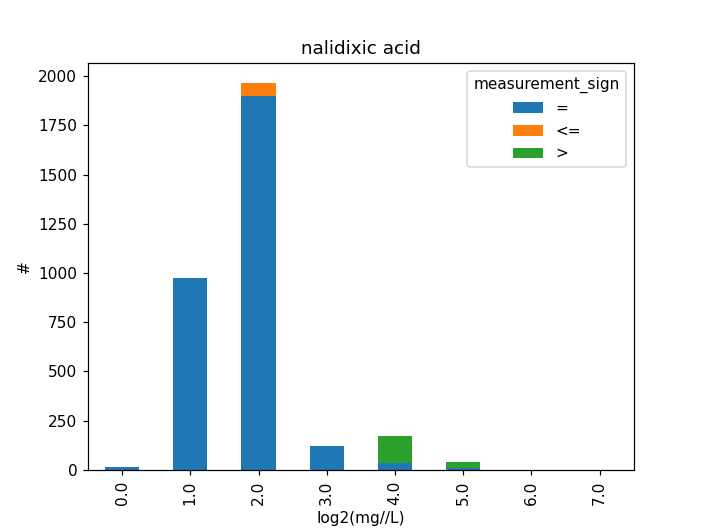

In [162]:
print_anti_measure(filtered_ASR, 'nalidixic acid')

### Genotype

### Phenotype

In [99]:
phenotypic.columns

Index(['sulfisoxazole', 'ampicillin', 'chloramphenicol', 'tetracycline',
       'amoxicillin-clavulanic acid', 'azithromycin', 'nalidixic acid',
       'cefoxitin', 'ceftiofur', 'gentamicin', 'ceftriaxone',
       'trimethoprim-sulfamethoxazole', 'ciprofloxacin', 'species_fam',
       'vancomycin', 'ampicillin-sulbactam', 'imipenem', 'linezolid',
       'quinupristin-dalfopristin', 'teicoplanin', 'tigecycline',
       'sulfamethoxazole', 'trimethoprim', 'cefotaxime', 'temocillin',
       'cefepime', 'ceftazidime', 'colistin', 'ceftazidime-clavulanic acid',
       'cefotaxime-clavulanic acid', 'meropenem', 'ertapenem', 'cefuroxime',
       'fosfomycin', 'nitrofurantoin', 'tobramycin', 'piperacillin-tazobactam',
       'amikacin', 'cefixime', 'norfloxacin', 'doxycycline', 'streptomycin',
       'erythromycin', 'kanamycin', 'mezlocillin', 'oxytetracycline',
       'piperacillin', 'cefaclor', 'cefotiam', 'levofloxacin', 'aztreonam',
       'minocycline', 'cefpodoxime'],
      dtype='object

In [107]:
phenotypic.describe().loc['count'].sort_values(ascending=False)

antibiotic_name
species_fam                      2547
ciprofloxacin                    2518
ampicillin                       2515
nalidixic acid                   2398
trimethoprim-sulfamethoxazole    2176
gentamicin                       2168
chloramphenicol                  2057
tetracycline                     2056
azithromycin                     1995
cefoxitin                        1961
amoxicillin-clavulanic acid      1829
ceftriaxone                      1818
ceftiofur                        1717
sulfisoxazole                    1694
ceftazidime                       698
cefotaxime                        697
meropenem                         683
amikacin                          448
imipenem                          424
piperacillin-tazobactam           358
trimethoprim                      350
colistin                          350
ceftazidime-clavulanic acid       288
ampicillin-sulbactam              273
tigecycline                       264
minocycline                       

In [13]:
phen.head()

strain     germ Amoxicillin - Clavulanic acid Amikacin  \
0  100548-2-19   klevar                           <=2      <=2   
1    121261-18  klepnee                            16      <=2   
2    127940-19   klepne                             4      <=2   
3    130765-18  klepnee                             4      <=2   
4    138096-18  klepnee                             4      <=2   

  Ampicillin / Amoxicillin Cefepime Ciprofloxacin Cefpodoxim Colistin   \
0                       16      <=1         <=.25          0      <=.5   
1                     >=32        2           >=4          0      <=.5   
2                     >=32      <=1         <=.25          0      <=.5   
3                     >=32      <=1             1          0      <=.5   
4                     >=32        2             1          0      <=.5   

  Ceftriaxon  ... Gentamicin  Imipenem  Levofloxacin Meropenem Nitrofurantoin  \
0        <=1  ...        NaN     <=.25           0.0     <=.25              0   
1       >=64  ...        NaN     <=.25           0.0     <=.25              0   
2        <=1  ...        NaN     <=.25           0.0     <=.25              0   
3          8  ...        NaN     <=.25           0.0     <=.25              0   
4       >=64  ...        NaN     <=.25           0.0     <=.25              0   

  Norfloxacin Piperacillin-Tazobactam  Cotrimoxazol Tetracyclin Tobramycin  
0           0                       2          <=20         NaN        <=1  
1           0                       8         >=320         NaN          8  
2           0                       3          <=20         NaN        <=1  
3           0                       2         >=320         NaN        <=1  
4           0                       3            40         NaN        <=1  

[5 rows x 25 columns]

<IPython.core.display.Javascript object>


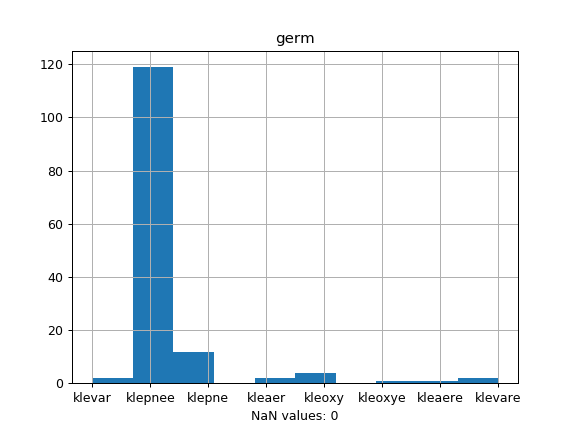

<IPython.core.display.Javascript object>


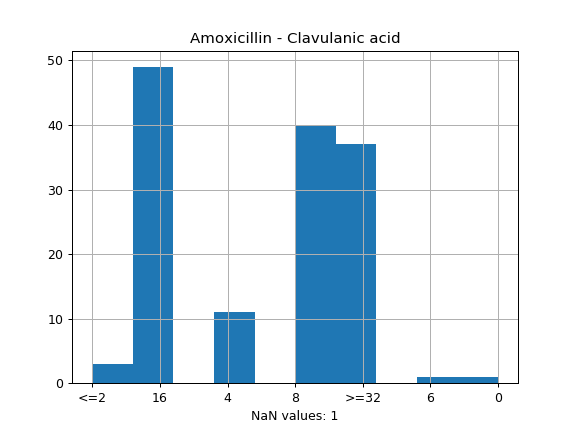

<IPython.core.display.Javascript object>


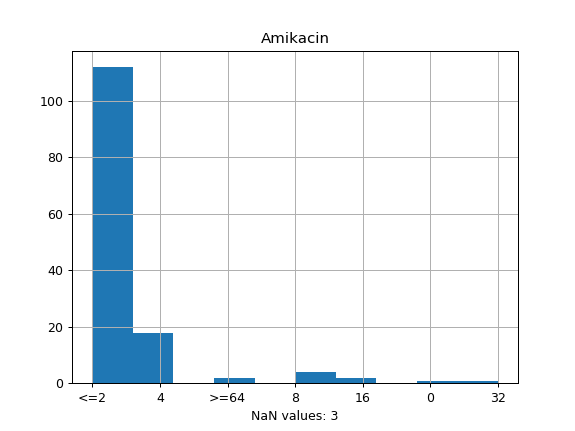

<IPython.core.display.Javascript object>


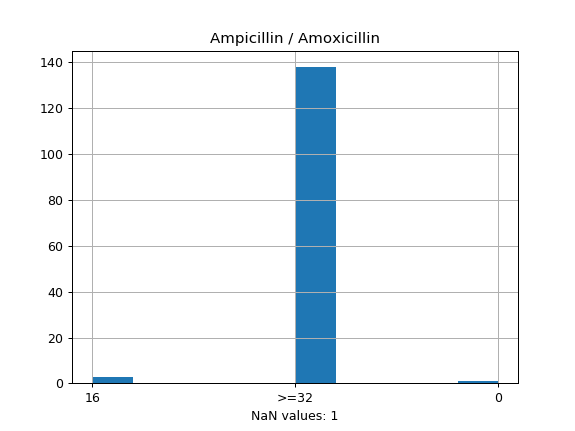

<IPython.core.display.Javascript object>


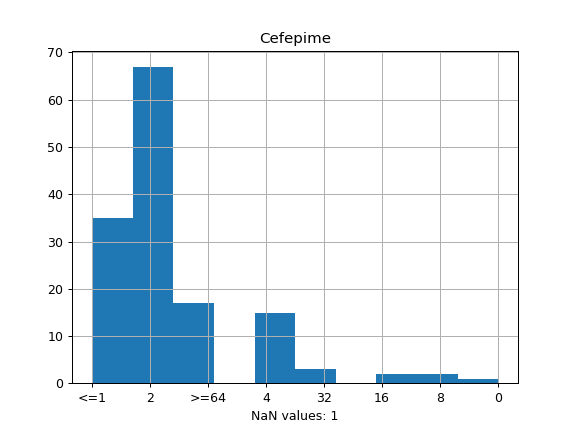

<IPython.core.display.Javascript object>


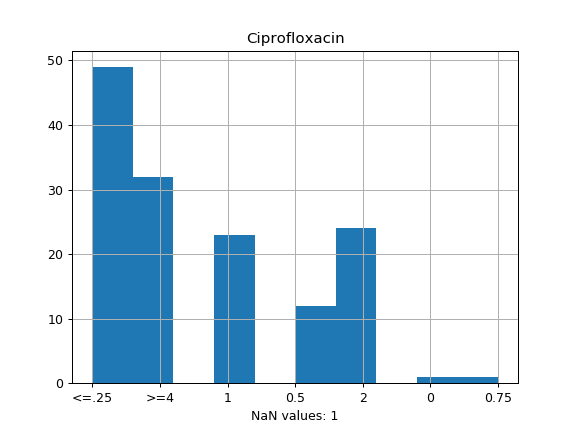

<IPython.core.display.Javascript object>


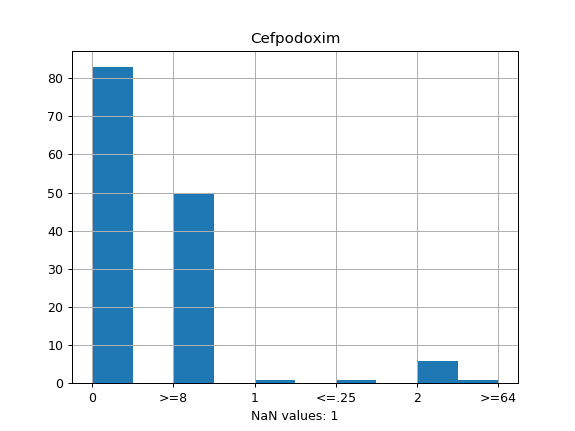

<IPython.core.display.Javascript object>


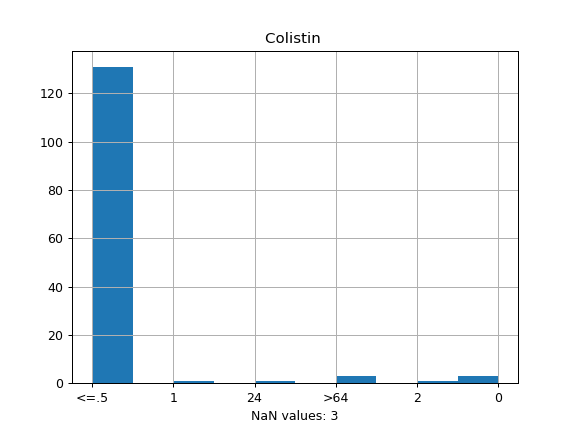

<IPython.core.display.Javascript object>


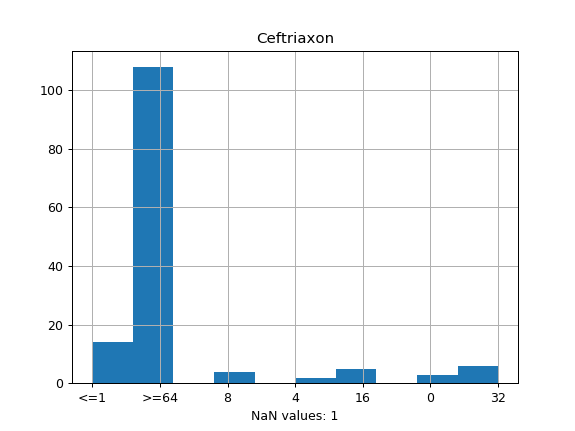

<IPython.core.display.Javascript object>


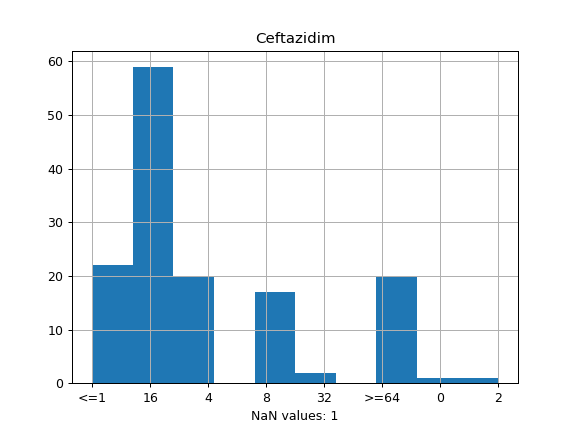

<IPython.core.display.Javascript object>


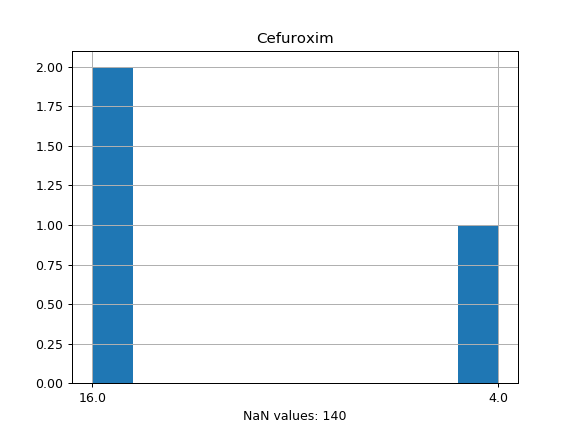

<IPython.core.display.Javascript object>


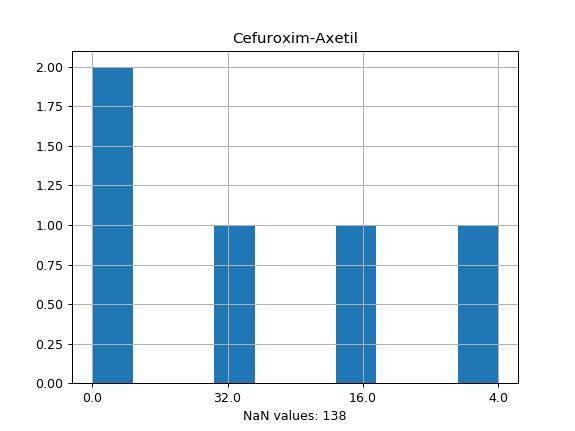

<IPython.core.display.Javascript object>


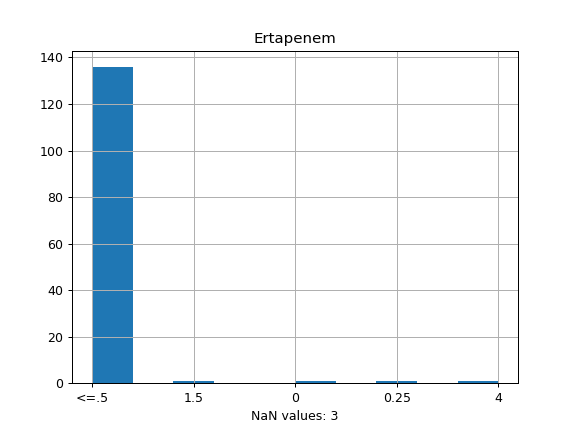

<IPython.core.display.Javascript object>


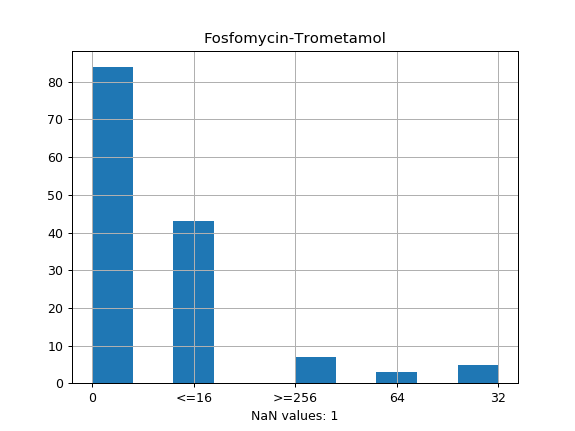

<IPython.core.display.Javascript object>


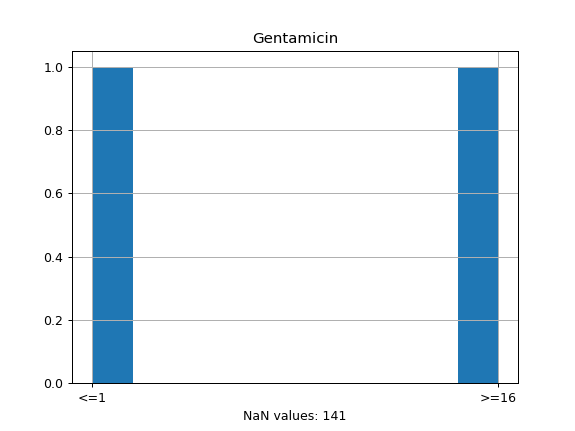

<IPython.core.display.Javascript object>


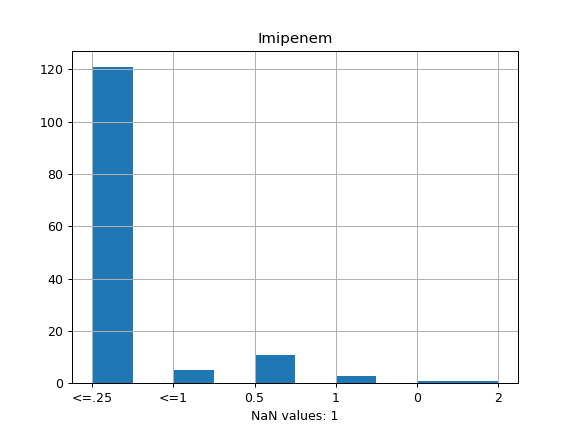

<IPython.core.display.Javascript object>


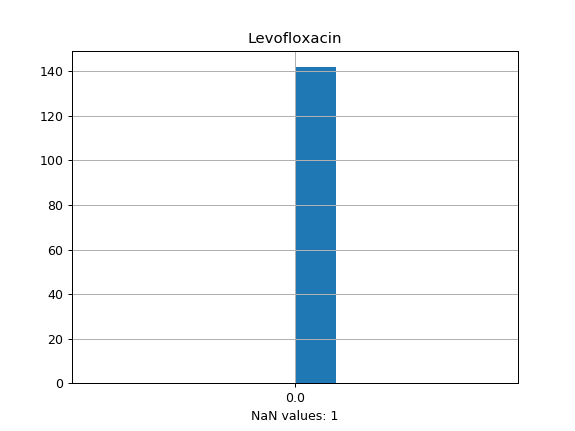

<IPython.core.display.Javascript object>


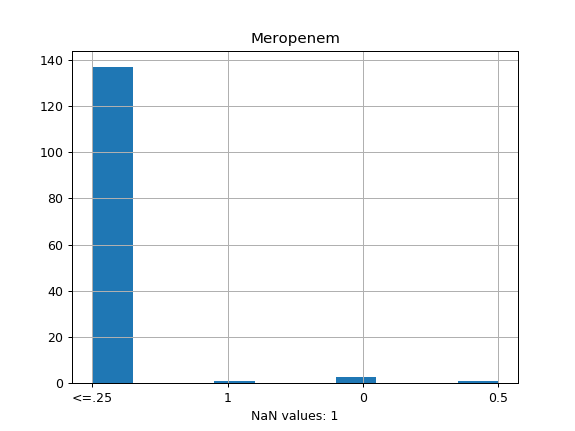

<IPython.core.display.Javascript object>


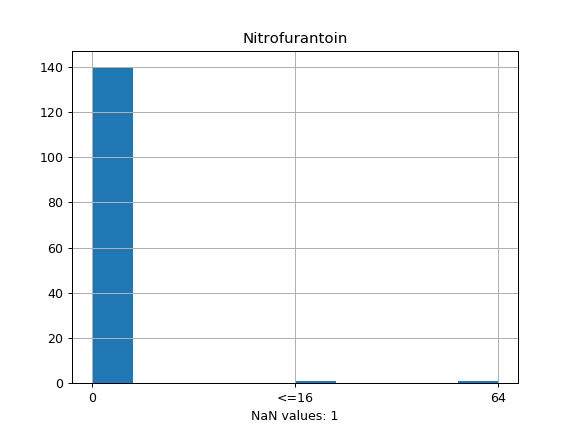

<IPython.core.display.Javascript object>


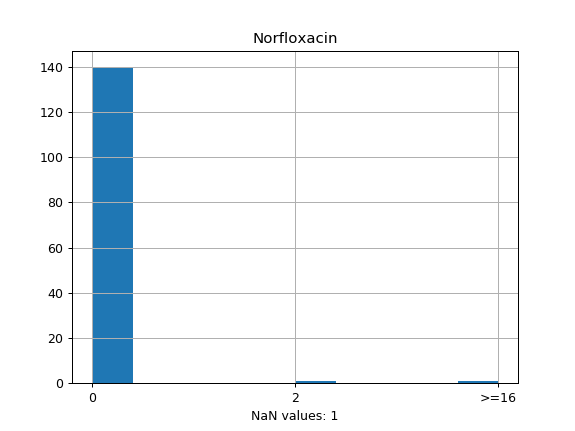

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


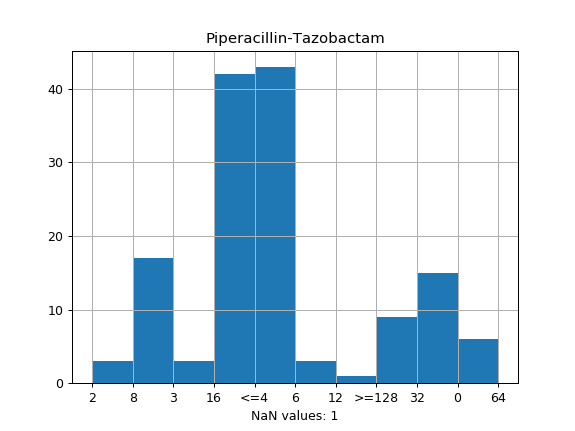

<IPython.core.display.Javascript object>


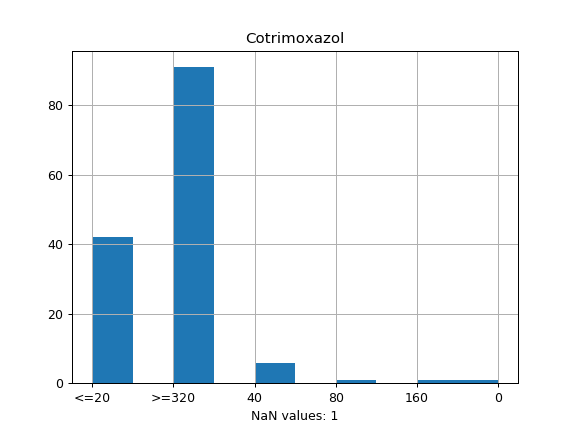

<IPython.core.display.Javascript object>


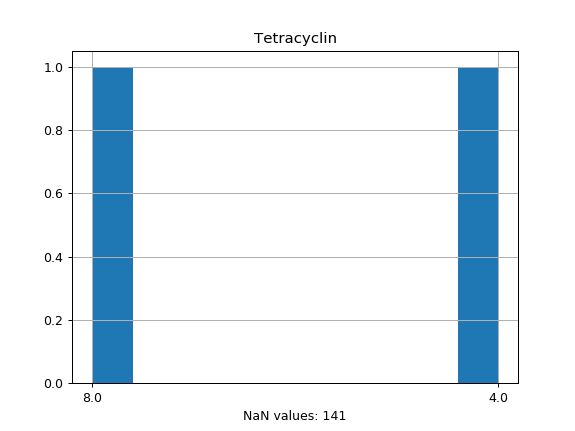

<IPython.core.display.Javascript object>


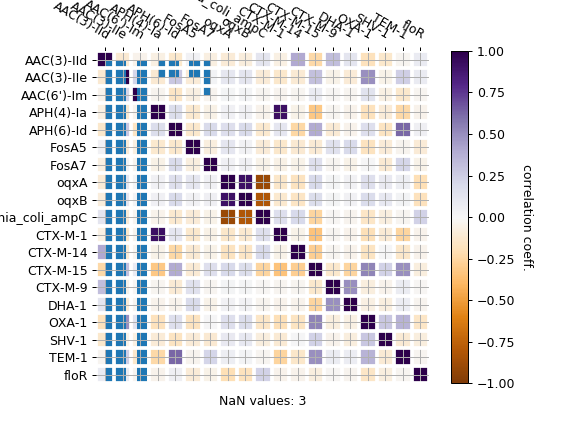

In [18]:
for col in phen.columns[1:]:
    fig = plt.figure()
    phen[col].astype(str).unique()
    phen[col].dropna().astype(str).hist()
    plt.title(col)
    plt.xlabel('NaN values: ' + str(sum(phen[col].isna())))
    plt.show()

In [19]:
for col in phen.columns[1:]:
    print(col, " missing values: ", str(sum(phen[col].isna())))

germ  missing values:  0
Amoxicillin - Clavulanic acid  missing values:  1
Amikacin  missing values:  3
Ampicillin / Amoxicillin  missing values:  1
Cefepime  missing values:  1
Ciprofloxacin  missing values:  1
Cefpodoxim  missing values:  1
Colistin   missing values:  3
Ceftriaxon  missing values:  1
Ceftazidim  missing values:  1
Cefuroxim  missing values:  140
Cefuroxim-Axetil  missing values:  138
Ertapenem  missing values:  3
Fosfomycin-Trometamol  missing values:  1
Gentamicin  missing values:  141
Imipenem  missing values:  1
Levofloxacin  missing values:  1
Meropenem  missing values:  1
Nitrofurantoin  missing values:  1
Norfloxacin  missing values:  1
Piperacillin-Tazobactam  missing values:  1
Cotrimoxazol  missing values:  1
Tetracyclin  missing values:  141
Tobramycin  missing values:  3


In [29]:
phen['germ'].unique()

array(['klevar', 'klepnee', 'klepne', 'kleaer', 'kleoxy', 'kleoxye',
       'kleaere', 'klevare'], dtype=object)

In [30]:
phen['Gentamicin'].unique()

array([nan, '<=1', '>=16'], dtype=object)

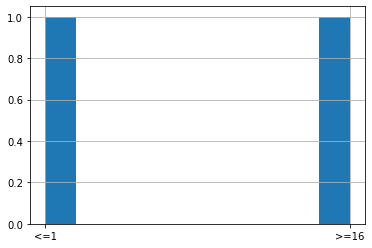

In [32]:
phen['Gentamicin'].hist()

In [31]:
phen['Tetracyclin'].unique()

array([nan,  8.,  4.])

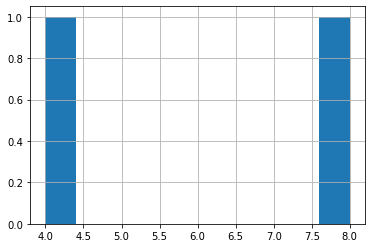

In [33]:
phen['Tetracyclin'].hist()

### gen FULL

In [8]:
gen_full.columns

Index(['#FILE', 'SEQUENCE', 'START', 'END', 'STRAND', 'GENE', 'COVERAGE',
       'COVERAGE_MAP', 'GAPS', '%COVERAGE', '%IDENTITY', 'DATABASE',
       'ACCESSION', 'PRODUCT', 'RESISTANCE'],
      dtype='object')

In [29]:
gen_full[gen_full['%COVERAGE'] > 50][['%COVERAGE', 'COVERAGE', 'COVERAGE_MAP', '%IDENTITY', 'GAPS']].head(20)

%COVERAGE       COVERAGE     COVERAGE_MAP  %IDENTITY   GAPS
2       96.09      1-369/384  ===============      81.30    0/0
3      100.00      1-861/861  ===============     100.00    0/0
4       99.03    1-3080/3105  ========/======      75.99    5/7
5       85.15  109-1106/1158  .=======/======      73.25   2/12
6       99.91    1-1125/1125  ========/======      95.16   7/32
7      100.00      1-363/363  ===============      99.17    0/0
8      100.00      1-330/330  ===============      99.39    0/0
13      85.85  115-1007/1032  .=======/======      64.33   7/11
14     100.00    1-1749/1749  ===============      80.62    0/0
15      83.91   46-1055/1125  ========/======      66.15  24/87
16      93.82    1-1403/1488  ========/======      78.25   4/11
17     100.00      1-822/822  ===============      79.44    0/0
18      60.65      1-380/615  ========/=.....      70.80  10/14
19     100.00      1-633/633  ===============      87.99    0/0
20      99.49    1-1367/1374  ===============      81.93    0/0
23      99.59    1-1232/1233  ========/======      77.43    4/8
24      90.82   61-1562/1644  ========/======      71.74  11/18
25      98.82      1-673/678  ========/======      76.48    2/6
27      94.40     21-375/375  ========/======      80.84    1/1
28      94.43     16-932/969  ========/======      77.26    3/4

In [19]:
gen_full['#FILE'].iloc[76]

'01.rawreads_bgu_1.unicycler/801532-18/assembly.fasta'

In [75]:
gen = gen[meaningfull_features]

In [82]:
gen=gen.set_index("Isolate")
meaningfull_features = meaningfull_features[1:]

In [77]:
gen = gen.replace('.', 0)

In [78]:
gen.corr().shape

(19, 19)

In [79]:
gen.corr()

AAC(3)-IId  AAC(3)-IIe  AAC(6')-Im  APH(4)-Ia  \
AAC(3)-IId               1.000000   -0.115907   -0.032547  -0.057190   
AAC(3)-IIe              -0.115907    1.000000    0.215111  -0.116733   
AAC(6')-Im              -0.032547    0.215111    1.000000  -0.024924   
APH(4)-Ia               -0.057190   -0.116733   -0.024924   1.000000   
APH(6)-Id               -0.125562    0.278181   -0.148447   0.167900   
FosA5                    0.036098   -0.094164   -0.069080  -0.121384   
FosA7                   -0.065182    0.023861   -0.028407  -0.049916   
oqxA                    -0.100690    0.106175    0.022670   0.039835   
oqxB                    -0.082384    0.117490    0.025086   0.044080   
Escherichia_coli_ampC    0.123759   -0.094624   -0.020204  -0.035501   
CTX-M-1                 -0.061902   -0.126350   -0.026978   0.917379   
CTX-M-14                 0.406106   -0.106175   -0.022670  -0.039835   
CTX-M-15                -0.227559    0.309635    0.079437  -0.313910   
CTX-M-9                  0.313689   -0.046809   -0.009995  -0.017562   
DHA-1                    0.123759   -0.094624   -0.020204  -0.035501   
OXA-1                   -0.175509    0.497200    0.140078  -0.177931   
SHV-1                   -0.125787   -0.039128   -0.054819  -0.096326   
TEM-1                   -0.021553    0.244663   -0.132321  -0.232509   
floR                     0.079903    0.080039   -0.020204  -0.035501   

                       APH(6)-Id     FosA5     FosA7      oqxA      oqxB  \
AAC(3)-IId             -0.125562  0.036098 -0.065182 -0.100690 -0.082384   
AAC(3)-IIe              0.278181 -0.094164  0.023861  0.106175  0.117490   
AAC(6')-Im             -0.148447 -0.069080 -0.028407  0.022670  0.025086   
APH(4)-Ia               0.167900 -0.121384 -0.049916  0.039835  0.044080   
APH(6)-Id               1.000000 -0.127858  0.191362  0.159259  0.191060   
FosA5                  -0.127858  1.000000 -0.077475  0.110406  0.038499   
FosA7                   0.191362 -0.077475  1.000000  0.045401  0.050239   
oqxA                    0.159259  0.110406  0.045401  1.000000  0.909536   
oqxB                    0.191060  0.038499  0.050239  0.909536  1.000000   
Escherichia_coli_ampC  -0.124555 -0.098394 -0.040462 -0.891204 -0.810582   
CTX-M-1                 0.113955 -0.131384 -0.054028 -0.136981 -0.117335   
CTX-M-14               -0.237253 -0.110406 -0.045401 -0.171014 -0.149833   
CTX-M-15                0.396710 -0.101594  0.159089  0.203023  0.165265   
CTX-M-9                -0.104598  0.145388 -0.020016  0.015974  0.017676   
DHA-1                  -0.037670  0.192098 -0.040462  0.032290  0.035731   
OXA-1                   0.159571 -0.167325  0.012865  0.161839  0.178526   
SHV-1                  -0.158793 -0.098287 -0.109787  0.087614  0.096951   
TEM-1                   0.632059 -0.028966  0.214683  0.058358  0.023529   
floR                    0.049215 -0.098394 -0.040462 -0.198584 -0.175847   

                       Escherichia_coli_ampC   CTX-M-1  CTX-M-14  CTX-M-15  \
AAC(3)-IId                          0.123759 -0.061902  0.406106 -0.227559   
AAC(3)-IIe                         -0.094624 -0.126350 -0.106175  0.309635   
AAC(6')-Im                         -0.020204 -0.026978 -0.022670  0.079437   
APH(4)-Ia                          -0.035501  0.917379 -0.039835 -0.313910   
APH(6)-Id                          -0.124555  0.113955 -0.237253  0.396710   
FosA5                              -0.098394 -0.131384 -0.110406 -0.101594   
FosA7                              -0.040462 -0.054028 -0.045401  0.159089   
oqxA                               -0.891204 -0.136981 -0.171014  0.203023   
oqxB                               -0.810582 -0.117335 -0.149833  0.165265   
Escherichia_coli_ampC               1.000000  0.162204  0.198584 -0.254456   
CTX-M-1                             0.162204  1.000000 -0.043116 -0.339771   
CTX-M-14                            0.198584 -0.043116  1.000000 -0.285519   
CTX-M-15                           -0.254456 -0

In [110]:
gen.head()

AAC(3)-IId  AAC(3)-IIe  AAC(6')-Im  APH(4)-Ia  APH(6)-Id  FosA5  \
Isolate                                                                        
100548-2-19         0.0         0.0           0          0          0  100.0   
121261-18           0.0         0.0           0          0        100    0.0   
127940-19           0.0         0.0           0          0          0  100.0   
130765-18           0.0         0.0           0          0          0    0.0   
138096-18           0.0         0.0           0          0        100    0.0   

             FosA7  oqxA   oqxB  Escherichia_coli_ampC  CTX-M-1  CTX-M-14  \
Isolate                                                                     
100548-2-19    0.0   100  100.0                      0      0.0         0   
121261-18      0.0   100  100.0                      0      0.0         0   
127940-19      0.0   100  100.0                      0      0.0         0   
130765-18      0.0   100  100.0                      0      0.0       100   
138096-18      0.0   100  100.0                      0      0.0         0   

             CTX-M-15  CTX-M-9  DHA-1  OXA-1  SHV-1  TEM-1  floR  
Isolate                                                           
100548-2-19       0.0        0      0      0      0      0     0  
121261-18       100.0        0      0    100      0    100     0  
127940-19         0.0        0      0      0      0      0     0  
130765-18         0.0        0      0      0    100      0     0  
138096-18       100.0        0      0      0    100      0     0

<IPython.core.display.Javascript object>


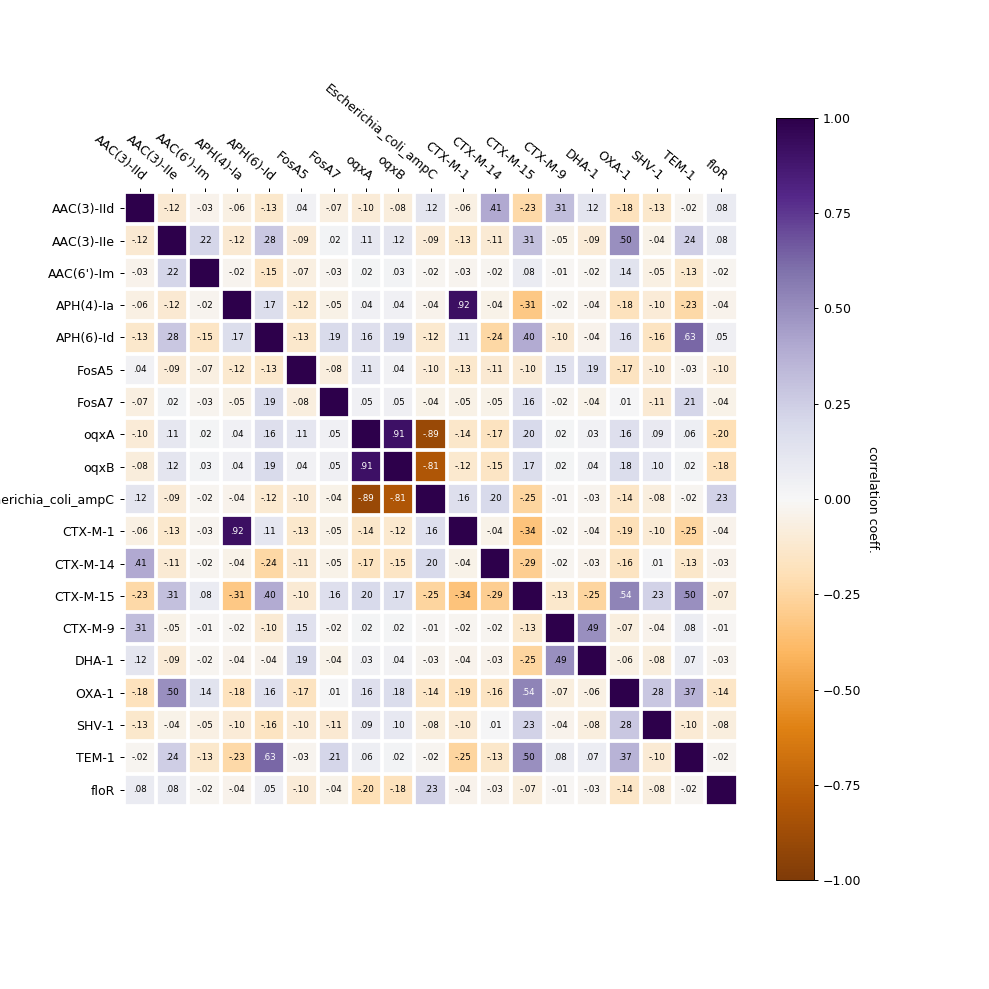

In [109]:
fig = plt.figure(figsize=(11,11))
im, _ = heatmap(gen.corr(), meaningfull_features, meaningfull_features,
                cmap="PuOr", vmin=-1, vmax=1,
                cbarlabel="correlation coeff.")


def func(x, pos):
    return "{:.2f}".format(x).replace("0.", ".").replace("1.00", "")

annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=7, threshold=0.5)



plt.show()

In [114]:
phen = phen.set_index("strain")

### Examine one col

In [264]:
values_dict = {
    0     : 1.0,
    '<=2' : 1.0,
    4     : 2.0,
    6     : 3.0,
    8     : 3.0,
    16    : 4.0,
    '>=32': 5.0,
}

final_dict = {
    '<=2' : 1.0,
    4     : 2.0,
    8     : 3.0,
    16    : 4.0,
    '>=32': 5.0,
}

In [265]:
target1 = phen.iloc[:,1]

In [266]:
target1.unique()

array(['<=2', 16, 4, 8, '>=32', 6, 0, nan], dtype=object)

In [267]:
target1 = target1.dropna()

In [268]:
target1.unique()

array(['<=2', 16, 4, 8, '>=32', 6, 0], dtype=object)

In [269]:
for key in values_dict.keys():
    target1 = target1.replace(key, values_dict[key])

In [270]:
target1

strain
100548-2-19       1.0
121261-18         4.0
127940-19         2.0
130765-18         2.0
138096-18         2.0
145605-17         4.0
402121-18         2.0
500122-18         3.0
500888-12         3.0
500965-13         2.0
502451-18         5.0
502839-19         1.0
503158-18         3.0
503171-19         3.0
601529-13         3.0
602149-19         3.0
602723-12         2.0
602822-14         5.0
605997-18         5.0
700207-18         5.0
700607-17         3.0
701520-11         3.0
701615-18         4.0
702603-18         5.0
703613-19         2.0
704193-17         4.0
705349-17         4.0
706120-19         4.0
706143-1-17       4.0
706143-2-17       4.0
706229-18         4.0
706508-16-wh      1.0
706827-19         3.0
706961-11         5.0
706965-17         3.0
708350-18         5.0
708620-18         4.0
709064Mo1-18      5.0
709064Mo2-18      5.0
709064Mo3-18      5.0
709347-19         2.0
709472-19         3.0
709716-17         4.0
711057-17         3.0
712459-19         3.0
712

In [162]:
import h2o

In [195]:
best_label = filtered_data[labels].describe().iloc[0].sort_values().reset_index().iloc[-1]
best_label = best_label['index']

In [196]:
best_label

'ciprofloxacin'

In [201]:
filtered_data[best_label].value_counts()

<= -6.058893689053569    1356
= -5.058893689053569      347
= -4.058893689053568      106
= 5.0                      61
= -6.058893689053569       33
= -1.0                     27
= -2.0                     25
> 5.0                      20
= 4.0                      19
= -3.0588936890535687      17
= 6.0                      13
= 0.0                       9
< -6.643856189774724        7
= -2.9434164716336326       6
> 6.0                       5
<= -2.0                     5
= 3.0                       4
= 1.0                       4
= -1.3959286763311392       4
> 2.0                       3
= -2.395928676331139        2
= -3.0                      2
= -5.965784284662086        2
= -5.442222328605074        1
= 3.5849625007211565        1
= 4.459431618637297         1
= 2.0                       1
Name: ciprofloxacin, dtype: int64

In [206]:
filtered_data[best_label+'_filtered'] = filtered_data[best_label].apply(lambda x: float(x.split(' ')[1]))

In [207]:
y=best_label+'_filtered'

In [203]:
filtered_data[features].describe()

ramA->seq_id  Klebsiella_pneumoniae_KpnE->seq_id  amrB->seq_cov  \
count   1783.000000                         2080.000000            0.0   
mean      79.698615                           77.587986            NaN   
std        0.253849                            2.126444            NaN   
min       78.870000                           75.560000            NaN   
25%       79.440000                           76.110000            NaN   
50%       79.720000                           76.430000            NaN   
75%       80.000000                           80.990000            NaN   
max       80.280000                           82.640000            NaN   

       floR->seq_cov  TEM-102->seq_id  APH(6)-Id->seq_id  APH(6)-Ic->seq_id  \
count     118.000000              0.0         635.000000          19.000000   
mean       99.979661              NaN          99.864016          99.971579   
std         0.034983              NaN           0.058610           0.067434   
min        99.920000              NaN          99.470000          99.820000   
25%        99.940000              NaN          99.880000         100.000000   
50%       100.000000              NaN          99.880000         100.000000   
75%       100.000000              NaN          99.880000         100.000000   
max       100.000000              NaN         100.000000         100.000000   

       TEM-135->seq_cov  CTX-M-103->seq_id  APH(6)-Ic->seq_cov  ...  \
count               0.0                0.0           19.000000  ...   
mean                NaN                NaN           95.130526  ...   
std                 NaN                NaN           11.553723  ...   
min                 NaN                NaN           69.160000  ...   
25%                 NaN                NaN          100.000000  ...   
50%                 NaN                NaN          100.000000  ...   
75%                 NaN                NaN          100.000000  ...   
max                 NaN                NaN          100.000000  ...   

       dfrB4->seq_id  rosA->seq_id  QepA2->seq_id  smeF->seq_id  \
count            0.0   2080.000000            0.0           0.0   
mean             NaN     69.133760            NaN           NaN   
std              NaN      0.431912            NaN           NaN   
min              NaN     68.630000            NaN           NaN   
25%              NaN     68.860000            NaN           NaN   
50%              NaN     68.950000            NaN           NaN   
75%              NaN     69.160000            NaN           NaN   
max              NaN     70.560000            NaN           NaN   

       Klebsiella_pneumoniae_KpnF->seq_cov  vanRB->seq_cov  emrY->seq_id  \
count                          2076.000000             0.0    297.000000   
mean                             99.522543             NaN     98.089731   
std                               0.446352             NaN      0.713453   
min                              93.640000             NaN     97.210000   
25%                              99.700000             NaN     97.660000   
50%                              99.700000             NaN     97.730000   
75%                              99.700000             NaN     98.310000   
max                              99.700000             NaN     99.940000   

       mdtP->seq_id  AAC(3)-IIb->seq_id  TEM-102->seq_cov  
count    302.000000                1.00               0.0  
mean      97.469073               78.42               NaN  
std        2.884562                 NaN               NaN  
min       75.860000               78.42               NaN  
25%       97.610000               78.42               NaN  
50%       97.610000               78.42               NaN  
75%       98.160000               78.42               NaN  
max      100.000000               78.42               NaN  

[8 rows x 548 columns]

In [209]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(filtered_data, test_size=0.2)
train.to_csv('PATAKI_train.csv')
test.to_csv('PATAKI_test.csv')

In [222]:
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

# Import a sample binary outcome train/test set into H2O
trainH2o = h2o.import_file("PATAKI_train.csv")
testH2o = h2o.import_file("PATAKI_test.csv")

# Identify predictors and response
x = features
y=best_label+'_filtered'

# Run AutoML for 20 base models
aml = H2OAutoML(max_models=20, seed=1, max_runtime_secs=86400)
aml.train(x=x, y=y, training_frame=trainH2o)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# model_id                                                  auc    logloss    mean_per_class_error      rmse       mse
# ---------------------------------------------------  --------  ---------  ----------------------  --------  --------
# StackedEnsemble_AllModels_AutoML_20181212_105540     0.789801   0.551109                0.333174  0.43211   0.186719
# StackedEnsemble_BestOfFamily_AutoML_20181212_105540  0.788425   0.552145                0.323192  0.432625  0.187165
# XGBoost_1_AutoML_20181212_105540                     0.784651   0.55753                 0.325471  0.434949  0.189181
# XGBoost_grid_1_AutoML_20181212_105540_model_4        0.783523   0.557854                0.318819  0.435249  0.189441
# XGBoost_grid_1_AutoML_20181212_105540_model_3        0.783004   0.559613                0.325081  0.435708  0.189841
# XGBoost_2_AutoML_20181212_105540                     0.78136    0.55888                 0.347074  0.435907  0.190015
# XGBoost_3_AutoML_20181212_105540                     0.780847   0.559589                0.330739  0.43613   0.190209
# GBM_5_AutoML_20181212_105540                         0.780837   0.559903                0.340848  0.436191  0.190263
# GBM_2_AutoML_20181212_105540                         0.780036   0.559806                0.339926  0.436415  0.190458
# GBM_1_AutoML_20181212_105540                         0.779827   0.560857                0.335096  0.436616  0.190633
# GBM_3_AutoML_20181212_105540                         0.778669   0.56179                 0.325538  0.437189  0.191134
# XGBoost_grid_1_AutoML_20181212_105540_model_2        0.774411   0.575017                0.322811  0.4427    0.195984
# GBM_4_AutoML_20181212_105540                         0.771426   0.569712                0.33742   0.44107   0.194543
# GBM_grid_1_AutoML_20181212_105540_model_1            0.769752   0.572583                0.344331  0.442452  0.195764
# GBM_grid_1_AutoML_20181212_105540_model_2            0.754366   0.918567                0.355855  0.496638  0.246649
# DRF_1_AutoML_20181212_105540                         0.742892   0.595883                0.355403  0.452774  0.205004
# XRT_1_AutoML_20181212_105540                         0.742091   0.599346                0.356583  0.453117  0.205315
# DeepLearning_grid_1_AutoML_20181212_105540_model_2   0.741795   0.601497                0.368291  0.454904  0.206937
# XGBoost_grid_1_AutoML_20181212_105540_model_1        0.693554   0.620702                0.40588   0.465791  0.216961
# DeepLearning_1_AutoML_20181212_105540                0.69137    0.637954                0.409351  0.47178   0.222576
# DeepLearning_grid_1_AutoML_20181212_105540_model_1   0.690084   0.661794                0.418469  0.476635  0.227181
# GLM_grid_1_AutoML_20181212_105540_model_1            0.682648   0.63852                 0.397234  0.472683  0.223429
#
# [22 rows x 6 columns]

# The leader model is stored here
aml.leader

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ----------------------------------------------------------------------------
H2O_cluster_uptime:         55 mins 03 secs
H2O_cluster_timezone:       Asia/Jerusalem
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.0.1
H2O_cluster_version_age:    10 days
H2O_cluster_name:           H2O_from_python_amitdanw_auth_ad_bgu_ac_il_bjcv32
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    7.515 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, Infogram, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.10.0 final
--------------------------  ----------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
02:32:16.813: _train param, Dropping bad and constant columns: [qnrE1->seq_cov, vanXB->seq_id, ACC-5->seq_cov, SAT-4->seq_id, CMY-39->seq_id, vanHA->seq_id, adeB->seq_cov, QepA2->seq_cov, mexQ->seq_id, FosA5->seq_cov, TriC->seq_cov, vatF->seq_cov, QnrB20->seq_cov, CTX-M-65->seq_id, CTX-M-101->seq_cov, SHV-108->seq_id, QnrA1->seq_id, TEM-147->seq_id, AAC(6')-Ib8->seq_id, AAC(6')-Ie-APH(2'')-Ia->seq_cov, vanHB->seq_cov, catA4->seq_cov, dfrB4->seq_cov, CTX-M-2->seq_id, vanSD->seq_cov, patA->seq_cov, MCR-3.10->seq_id, ACT-22->seq_id, Klebsiella_pneumoniae_KpnG->seq_cov, dfrF->seq_id, dfrG->seq_cov, vanRA->seq_id, aadA25->seq_cov, Klebsiella_pneumoniae_acrA->seq_cov, OprM->seq_id, tet(D)->seq_id, CTX-M-2->seq_cov, QepA2->seq_id, vanRA->seq_cov, vanRD->seq_cov, vanXB->seq_cov, smeF->seq

In [223]:
X = filtered_data[features]
y = filtered_data[best_label+'_filtered']

In [226]:
kf = KFold(n_splits=10, shuffle=True, random_state=rng)

In [228]:
tot_actuals = []
tot_predictions = []
tot_rounded_predictions = []
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor(n_jobs=1, tree_method='gpu_hist', gpu_id=0).fit(X.iloc[train_index], y.iloc[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    rounded_predictions = [min(final_dict.values(), key=lambda x:abs(x-pred)) for pred in predictions]
    print("rounded: ", rounded_predictions)
    print("actual: ", actuals.T[0])
    print(mean_squared_error(actuals, predictions))
    print(confusion_matrix([str(x) for x in actuals.T[0]], [str(x) for x in rounded_predictions]))
    tot_actuals += list(actuals.T[0])
    tot_rounded_predictions += rounded_predictions
    tot_predictions += list(predictions)

XGBoostError: [11:31:40] /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/gbm/../common/common.h:157: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1a393b) [0x7f992193f93b]
  [bt] (1) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1a39cc) [0x7f992193f9cc]
  [bt] (2) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(xgboost::gbm::GBTree::ConfigureUpdaters()+0xa5) [0x7f992193fa85]
  [bt] (3) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(xgboost::gbm::GBTree::Configure(std::vector<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > >, std::allocator<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&)+0x309) [0x7f9921956039]
  [bt] (4) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1e67fd) [0x7f99219827fd]
  [bt] (5) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1d5787) [0x7f9921971787]
  [bt] (6) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(XGBoosterUpdateOneIter+0x4c) [0x7f9921855abc]
  [bt] (7) /home/amitdanw/.conda/envs/gps/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f999bbf1a4a]
  [bt] (8) /home/amitdanw/.conda/envs/gps/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f999bbf0fea]



In [291]:
print(mean_squared_error(tot_actuals, tot_predictions))

0.7742366563759465


<IPython.core.display.Javascript object>


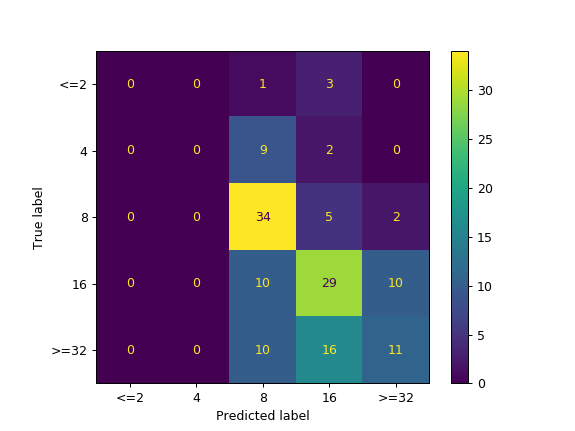

In [292]:
cm = confusion_matrix(
    [str(x) for x in tot_actuals], 
    [str(x) for x in tot_rounded_predictions], 
    labels=[str(x) for x in final_dict.values()],
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[str(x) for x in final_dict.keys()],
)
disp.plot() 

### run Parameter Opt

In [319]:
param_grid = {
    'max_depth':[3, 4, 6, 8, 10], 
    'n_estimators': [20, 50, 100, 200],
    'eta': uniform(loc=0, scale=1),
    'gamma': uniform(loc=0, scale=100),
    'min_child_weight': uniform(loc=0, scale=10),
    ''
}

In [320]:
xgb_model = xgb.XGBRegressor(n_jobs=1, tree_method='gpu_hist', gpu_id=0)

In [321]:
kf = KFold(n_splits=10, shuffle=True, random_state=rng)

In [322]:
clf = RandomizedSearchCV(xgb_model, param_distributions=param_grid, random_state=rng, cv = kf)

In [323]:
search = clf.fit(X, y)
search.best_params_
search.best_score_

[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

0.2719582886878314

[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

<IPython.core.display.Javascript object>


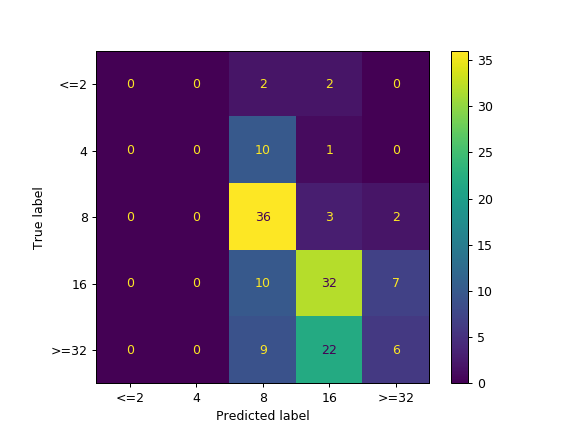

In [324]:
tot_actuals = []
tot_predictions = []
tot_rounded_predictions = []
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor(n_jobs=1, **search.best_params_).fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    rounded_predictions = [min(final_dict.values(), key=lambda x:abs(x-pred)) for pred in predictions]
    tot_actuals += list(actuals.T[0])
    tot_rounded_predictions += rounded_predictions
    tot_predictions += list(predictions)
    
print(mean_squared_error(tot_actuals, tot_predictions))
cm = confusion_matrix(
    [str(x) for x in tot_actuals], 
    [str(x) for x in tot_rounded_predictions], 
    labels=[str(x) for x in final_dict.values()],
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[str(x) for x in final_dict.keys()],
)
disp.plot() 

In [318]:
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)